# CIFAR10 classification with EfficientNetV2L from scratch ( not using ImageNet weights)
* **EfficientNet V2L has about 118 milion parameters!**
* **TPU Distributed Training with Keras-3 and jax as its backend**

In [1]:
!pip install -q -U tensorflow-cpu
!pip install --upgrade -q keras


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# if you face OOM, uncomment this line bellow
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

## Setting Keras DataParallel strategy for distributed training

In [3]:
import keras

devices = keras.distribution.list_devices()
print(devices)
data_parallel = keras.distribution.DataParallel(devices=devices)

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
mesh_1d = keras.distribution.DeviceMesh(
    shape=(8, ), axis_names=["data"], devices=devices
)
data_parallel = keras.distribution.DataParallel(device_mesh=mesh_1d)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

E0000 00:00:1738414382.156338      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetV2L

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32 * len(devices)

## Mixed Precision Computation for lower memory usage and higher training speed

In [5]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

## Reproduction

In [6]:
keras.utils.set_random_seed(0)

## Downloading dataset

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
NUM_CLASSES = 10
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

        0/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

     8192/170498071 ━━━━━━━━━━━━━━━━━━━━ 31:49 11us/step

    40960/170498071 ━━━━━━━━━━━━━━━━━━━━ 12:47 5us/step 

    98304/170498071 ━━━━━━━━━━━━━━━━━━━━ 7:59 3us/step 

   212992/170498071 ━━━━━━━━━━━━━━━━━━━━ 4:55 2us/step

   442368/170498071 ━━━━━━━━━━━━━━━━━━━━ 2:57 1us/step

   909312/170498071 ━━━━━━━━━━━━━━━━━━━━ 1:43 1us/step

  1826816/170498071 ━━━━━━━━━━━━━━━━━━━━ 59s 0us/step 

  3678208/170498071 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

  6791168/170498071 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

  9863168/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 12951552/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 15597568/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 16130048/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 19079168/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 21585920/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 22241280/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 24526848/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 25698304/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 27836416/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 29270016/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 31268864/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 32407552/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 34676736/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 35577856/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 38051840/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 39190528/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 41590784/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 42803200/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 44703744/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 47030272/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 47874048/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 50913280/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 52822016/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 54059008/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 57032704/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 58941440/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 60186624/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 63037440/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 63488000/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 66191360/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 67452928/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 69345280/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 71753728/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 72794112/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 74924032/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 76546048/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 78225408/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 80502784/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 81854464/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 84123648/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 85311488/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 87220224/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 88981504/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 90652672/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 92389376/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 93863936/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 95723520/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 97312768/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 99467264/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

100933632/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

103006208/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

104759296/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

106266624/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

108052480/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

109666304/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

111419392/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

112943104/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

114630656/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

116162560/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

117972992/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

119463936/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

121675776/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

123060224/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

125075456/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

126869504/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

128327680/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

130179072/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

131629056/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

133390336/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

134864896/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

136593408/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

138141696/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

139821056/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

141443072/170498071 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

143196160/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

144736256/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

146472960/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

148037632/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

149864448/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

151347200/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

153477120/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

154935296/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

156876800/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

158547968/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

160169984/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

161873920/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

163389440/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

165150720/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

166699008/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

168517632/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

170049536/170498071 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
import tensorflow as tf

# Create TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [9]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

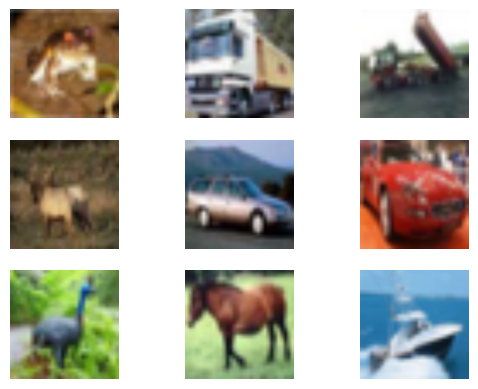

In [10]:



for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

    plt.axis("off")

In [11]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

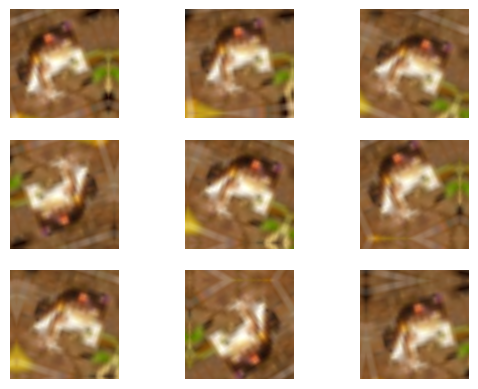

In [12]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.axis("off")

## Data Augmentation

In [13]:


# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [14]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

def get_model():
    model = EfficientNetV2L(
    include_top=False,
    weights=None, # Training from scratch
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = True


    classifier = Sequential([
                             model,
                             GlobalAveragePooling2D(),
                             Dropout(0.1),
                             Dense(NUM_CLASSES, activation = 'softmax')])
    
    
    return classifier

In [15]:
model = get_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetv2-l            │ (None, 7, 7, 1280)    │ 117,746,8… │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 10)            │     12,810 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 117,759,658 (449.22 MB)

 Trainable params: 117,247,082 (447.26 MB)

 Non-trainable params: 512,576 (1.96 MB)

## Training the model

In [17]:
history = model.fit(ds_train, validation_data = ds_test, epochs = 100)

Epoch 1/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 14:59:44 278s/step - accuracy: 0.0820 - loss: 2.3872

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:04:09 20s/step - accuracy: 0.0820 - loss: 2.3809  

  3/195 ━━━━━━━━━━━━━━━━━━━━ 32:28 10s/step - accuracy: 0.0877 - loss: 2.3754  

  4/195 ━━━━━━━━━━━━━━━━━━━━ 21:55 7s/step - accuracy: 0.0931 - loss: 2.3780 

  5/195 ━━━━━━━━━━━━━━━━━━━━ 16:38 5s/step - accuracy: 0.0956 - loss: 2.4031

  6/195 ━━━━━━━━━━━━━━━━━━━━ 13:28 4s/step - accuracy: 0.0969 - loss: 2.4120

  7/195 ━━━━━━━━━━━━━━━━━━━━ 11:21 4s/step - accuracy: 0.0977 - loss: 2.4262

  8/195 ━━━━━━━━━━━━━━━━━━━━ 9:50 3s/step - accuracy: 0.0983 - loss: 2.4403 

  9/195 ━━━━━━━━━━━━━━━━━━━━ 8:42 3s/step - accuracy: 0.0987 - loss: 2.4461

 10/195 ━━━━━━━━━━━━━━━━━━━━ 7:49 3s/step - accuracy: 0.0988 - loss: 2.4485

 11/195 ━━━━━━━━━━━━━━━━━━━━ 7:07 2s/step - accuracy: 0.0987 - loss: 2.4523

 13/195 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.0989 - loss: 2.4569

 15/195 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.0995 - loss: 2.4582

 14/195 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.0992 - loss: 2.4579

 17/195 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.1002 - loss: 2.4576

 16/195 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.0998 - loss: 2.4580

 22/195 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - accuracy: 0.1020 - loss: 2.4567

 20/195 ━━━━━━━━━━━━━━━━━━━━ 4:04 1s/step - accuracy: 0.1014 - loss: 2.4572

 23/195 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.1022 - loss: 2.4561

 24/195 ━━━━━━━━━━━━━━━━━━━━ 3:28 1s/step - accuracy: 0.1025 - loss: 2.4561

 28/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.1034 - loss: 2.4548

 29/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.1036 - loss: 2.4548

 30/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.1039 - loss: 2.4548

 31/195 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.1041 - loss: 2.4548

 34/195 ━━━━━━━━━━━━━━━━━━━━ 2:34 960ms/step - accuracy: 0.1048 - loss: 2.4532

 35/195 ━━━━━━━━━━━━━━━━━━━━ 2:30 943ms/step - accuracy: 0.1050 - loss: 2.4514

 36/195 ━━━━━━━━━━━━━━━━━━━━ 2:27 926ms/step - accuracy: 0.1053 - loss: 2.4514

 37/195 ━━━━━━━━━━━━━━━━━━━━ 2:23 911ms/step - accuracy: 0.1055 - loss: 2.4504

 38/195 ━━━━━━━━━━━━━━━━━━━━ 2:20 896ms/step - accuracy: 0.1058 - loss: 2.4483

 39/195 ━━━━━━━━━━━━━━━━━━━━ 2:17 882ms/step - accuracy: 0.1062 - loss: 2.4459

 40/195 ━━━━━━━━━━━━━━━━━━━━ 2:14 869ms/step - accuracy: 0.1065 - loss: 2.4423

 41/195 ━━━━━━━━━━━━━━━━━━━━ 2:11 856ms/step - accuracy: 0.1069 - loss: 2.4410

 43/195 ━━━━━━━━━━━━━━━━━━━━ 2:06 833ms/step - accuracy: 0.1077 - loss: 2.4354

 44/195 ━━━━━━━━━━━━━━━━━━━━ 2:04 823ms/step - accuracy: 0.1081 - loss: 2.4325

 45/195 ━━━━━━━━━━━━━━━━━━━━ 2:01 812ms/step - accuracy: 0.1086 - loss: 2.4295

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:59 802ms/step - accuracy: 0.1090 - loss: 2.4265

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:57 793ms/step - accuracy: 0.1095 - loss: 2.4265

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:47 751ms/step - accuracy: 0.1119 - loss: 2.4220

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:45 744ms/step - accuracy: 0.1124 - loss: 2.4191

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:40 723ms/step - accuracy: 0.1139 - loss: 2.4177

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:37 711ms/step - accuracy: 0.1149 - loss: 2.4163

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:31 688ms/step - accuracy: 0.1170 - loss: 2.4149

 64/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 678ms/step - accuracy: 0.1179 - loss: 2.4136

 65/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 673ms/step - accuracy: 0.1184 - loss: 2.4123

 66/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 668ms/step - accuracy: 0.1189 - loss: 2.4110

 67/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 664ms/step - accuracy: 0.1194 - loss: 2.4097

 68/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 659ms/step - accuracy: 0.1198 - loss: 2.4071

 69/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 655ms/step - accuracy: 0.1203 - loss: 2.4033

 70/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 651ms/step - accuracy: 0.1207 - loss: 2.4009

 71/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 647ms/step - accuracy: 0.1212 - loss: 2.3997

 72/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 643ms/step - accuracy: 0.1216 - loss: 2.3974

 73/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 639ms/step - accuracy: 0.1221 - loss: 2.3953

 75/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 632ms/step - accuracy: 0.1229 - loss: 2.3911

 74/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 636ms/step - accuracy: 0.1225 - loss: 2.3932

 76/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 628ms/step - accuracy: 0.1234 - loss: 2.3901

 78/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 622ms/step - accuracy: 0.1243 - loss: 2.3881

 84/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 603ms/step - accuracy: 0.1268 - loss: 2.3842

 83/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 606ms/step - accuracy: 0.1264 - loss: 2.3852

 86/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 598ms/step - accuracy: 0.1277 - loss: 2.3833

 87/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 595ms/step - accuracy: 0.1281 - loss: 2.3833

 90/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 587ms/step - accuracy: 0.1293 - loss: 2.3833

 89/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 590ms/step - accuracy: 0.1289 - loss: 2.3833

 91/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 585ms/step - accuracy: 0.1297 - loss: 2.3824

 93/195 ━━━━━━━━━━━━━━━━━━━━ 59s 580ms/step - accuracy: 0.1304 - loss: 2.3815 

 94/195 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - accuracy: 0.1308 - loss: 2.3806

 95/195 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - accuracy: 0.1311 - loss: 2.3788

 96/195 ━━━━━━━━━━━━━━━━━━━━ 56s 573ms/step - accuracy: 0.1315 - loss: 2.3788

 97/195 ━━━━━━━━━━━━━━━━━━━━ 55s 571ms/step - accuracy: 0.1318 - loss: 2.3771

 98/195 ━━━━━━━━━━━━━━━━━━━━ 55s 569ms/step - accuracy: 0.1322 - loss: 2.3762

 99/195 ━━━━━━━━━━━━━━━━━━━━ 54s 567ms/step - accuracy: 0.1325 - loss: 2.3745

100/195 ━━━━━━━━━━━━━━━━━━━━ 53s 565ms/step - accuracy: 0.1329 - loss: 2.3728

101/195 ━━━━━━━━━━━━━━━━━━━━ 52s 563ms/step - accuracy: 0.1332 - loss: 2.3711

102/195 ━━━━━━━━━━━━━━━━━━━━ 52s 561ms/step - accuracy: 0.1335 - loss: 2.3694

104/195 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accuracy: 0.1342 - loss: 2.3661

105/195 ━━━━━━━━━━━━━━━━━━━━ 50s 556ms/step - accuracy: 0.1345 - loss: 2.3645

108/195 ━━━━━━━━━━━━━━━━━━━━ 47s 550ms/step - accuracy: 0.1355 - loss: 2.3629

106/195 ━━━━━━━━━━━━━━━━━━━━ 49s 554ms/step - accuracy: 0.1348 - loss: 2.3629

107/195 ━━━━━━━━━━━━━━━━━━━━ 48s 552ms/step - accuracy: 0.1351 - loss: 2.3621

109/195 ━━━━━━━━━━━━━━━━━━━━ 47s 549ms/step - accuracy: 0.1358 - loss: 2.3621

110/195 ━━━━━━━━━━━━━━━━━━━━ 46s 547ms/step - accuracy: 0.1361 - loss: 2.3613

112/195 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.1367 - loss: 2.3605

113/195 ━━━━━━━━━━━━━━━━━━━━ 44s 542ms/step - accuracy: 0.1370 - loss: 2.3597

114/195 ━━━━━━━━━━━━━━━━━━━━ 43s 541ms/step - accuracy: 0.1373 - loss: 2.3589

118/195 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.1384 - loss: 2.3589

120/195 ━━━━━━━━━━━━━━━━━━━━ 39s 532ms/step - accuracy: 0.1390 - loss: 2.3581

122/195 ━━━━━━━━━━━━━━━━━━━━ 38s 529ms/step - accuracy: 0.1396 - loss: 2.3565

123/195 ━━━━━━━━━━━━━━━━━━━━ 38s 528ms/step - accuracy: 0.1399 - loss: 2.3557

124/195 ━━━━━━━━━━━━━━━━━━━━ 37s 527ms/step - accuracy: 0.1402 - loss: 2.3557

125/195 ━━━━━━━━━━━━━━━━━━━━ 36s 525ms/step - accuracy: 0.1404 - loss: 2.3549

126/195 ━━━━━━━━━━━━━━━━━━━━ 36s 524ms/step - accuracy: 0.1407 - loss: 2.3533

127/195 ━━━━━━━━━━━━━━━━━━━━ 35s 523ms/step - accuracy: 0.1410 - loss: 2.3525

128/195 ━━━━━━━━━━━━━━━━━━━━ 34s 522ms/step - accuracy: 0.1413 - loss: 2.3509

129/195 ━━━━━━━━━━━━━━━━━━━━ 34s 520ms/step - accuracy: 0.1416 - loss: 2.3493

130/195 ━━━━━━━━━━━━━━━━━━━━ 33s 519ms/step - accuracy: 0.1418 - loss: 2.3478

131/195 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy: 0.1421 - loss: 2.3462

132/195 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.1424 - loss: 2.3446

133/195 ━━━━━━━━━━━━━━━━━━━━ 31s 516ms/step - accuracy: 0.1426 - loss: 2.3430

138/195 ━━━━━━━━━━━━━━━━━━━━ 29s 510ms/step - accuracy: 0.1439 - loss: 2.3391

136/195 ━━━━━━━━━━━━━━━━━━━━ 30s 512ms/step - accuracy: 0.1434 - loss: 2.3399

139/195 ━━━━━━━━━━━━━━━━━━━━ 28s 509ms/step - accuracy: 0.1442 - loss: 2.3383

144/195 ━━━━━━━━━━━━━━━━━━━━ 25s 504ms/step - accuracy: 0.1454 - loss: 2.3360

141/195 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - accuracy: 0.1447 - loss: 2.3368

142/195 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - accuracy: 0.1449 - loss: 2.3360

143/195 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step - accuracy: 0.1451 - loss: 2.3368

145/195 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.1456 - loss: 2.3360

148/195 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.1464 - loss: 2.3344

150/195 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.1468 - loss: 2.3344

152/195 ━━━━━━━━━━━━━━━━━━━━ 21s 497ms/step - accuracy: 0.1473 - loss: 2.3329

153/195 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - accuracy: 0.1476 - loss: 2.3329

154/195 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step - accuracy: 0.1478 - loss: 2.3321

155/195 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.1480 - loss: 2.3313

157/195 ━━━━━━━━━━━━━━━━━━━━ 18s 493ms/step - accuracy: 0.1485 - loss: 2.3275

158/195 ━━━━━━━━━━━━━━━━━━━━ 18s 492ms/step - accuracy: 0.1487 - loss: 2.3275

159/195 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.1490 - loss: 2.3260

160/195 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.1492 - loss: 2.3244

161/195 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - accuracy: 0.1495 - loss: 2.3229

163/195 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step - accuracy: 0.1499 - loss: 2.3222

162/195 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.1497 - loss: 2.3214

164/195 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - accuracy: 0.1502 - loss: 2.3199

166/195 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - accuracy: 0.1506 - loss: 2.3176

165/195 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.1504 - loss: 2.3191

168/195 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - accuracy: 0.1511 - loss: 2.3147

172/195 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - accuracy: 0.1520 - loss: 2.3139

174/195 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.1524 - loss: 2.3132

176/195 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.1529 - loss: 2.3117 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - accuracy: 0.1527 - loss: 2.3117 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.1536 - loss: 2.3110

178/195 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - accuracy: 0.1533 - loss: 2.3110

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - accuracy: 0.1544 - loss: 2.3095

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - accuracy: 0.1547 - loss: 2.3095

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.1555 - loss: 2.3051

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.1553 - loss: 2.3066

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 0.1559 - loss: 2.3037

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1570 - loss: 2.3037

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1566 - loss: 2.3037

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1568 - loss: 2.3037

195/195 ━━━━━━━━━━━━━━━━━━━━ 409s 672ms/step - accuracy: 0.1572 - loss: 2.3029 - val_accuracy: 0.2647 - val_loss: 1.8699


Epoch 2/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.2891 - loss: 1.8936

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.2861 - loss: 1.9078

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.2823 - loss: 1.9114

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.2777 - loss: 1.9135

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.2751 - loss: 1.9154

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2727 - loss: 1.9172

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.2706 - loss: 1.9176

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.2687 - loss: 1.9184

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2674 - loss: 1.9186

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.2662 - loss: 1.9191

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2654 - loss: 1.9199

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2643 - loss: 1.9206

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2633 - loss: 1.9207

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2639 - loss: 1.9207

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2611 - loss: 1.9205

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2613 - loss: 1.9205

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2610 - loss: 1.9205

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.2599 - loss: 1.9203

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.2603 - loss: 1.9203

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2597 - loss: 1.9203 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2596 - loss: 1.9203

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2595 - loss: 1.9202

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2594 - loss: 1.9201

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2594 - loss: 1.9199

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2594 - loss: 1.9196

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2593 - loss: 1.9195

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2594 - loss: 1.9193

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2594 - loss: 1.9190

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2594 - loss: 1.9189

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2595 - loss: 1.9186

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2595 - loss: 1.9182

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2596 - loss: 1.9179

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2597 - loss: 1.9177

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2597 - loss: 1.9178

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2600 - loss: 1.9175

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2599 - loss: 1.9176

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.2598 - loss: 1.9175

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2602 - loss: 1.9172

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2604 - loss: 1.9173

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.2606 - loss: 1.9171

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.2607 - loss: 1.9171

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2609 - loss: 1.9170

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2604 - loss: 1.9172

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2610 - loss: 1.9169

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2612 - loss: 1.9168

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.2616 - loss: 1.9163

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2617 - loss: 1.9162

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 373ms/step - accuracy: 0.2620 - loss: 1.9158

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2621 - loss: 1.9158

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2623 - loss: 1.9157

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2624 - loss: 1.9154

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2625 - loss: 1.9152

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2626 - loss: 1.9147

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2627 - loss: 1.9144

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.2629 - loss: 1.9143

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2631 - loss: 1.9134

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2635 - loss: 1.9134

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2636 - loss: 1.9132

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2638 - loss: 1.9130

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2637 - loss: 1.9130

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2640 - loss: 1.9128

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2641 - loss: 1.9126

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2644 - loss: 1.9126

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2645 - loss: 1.9124

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2647 - loss: 1.9124

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2648 - loss: 1.9119

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2653 - loss: 1.9117

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2654 - loss: 1.9115

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2656 - loss: 1.9115

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2657 - loss: 1.9111

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2659 - loss: 1.9109

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2660 - loss: 1.9107

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2662 - loss: 1.9098

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2663 - loss: 1.9096

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2665 - loss: 1.9092

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2666 - loss: 1.9087

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2668 - loss: 1.9080

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2671 - loss: 1.9075

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2674 - loss: 1.9073

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2672 - loss: 1.9073

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2675 - loss: 1.9070

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2680 - loss: 1.9066

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2678 - loss: 1.9066

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.2689 - loss: 1.9061

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.2683 - loss: 1.9063

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.2686 - loss: 1.9059

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.2692 - loss: 1.9059

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2695 - loss: 1.9052

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2696 - loss: 1.9052

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2698 - loss: 1.9050

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2699 - loss: 1.9047

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2701 - loss: 1.9047

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2702 - loss: 1.9043

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2704 - loss: 1.9038

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2705 - loss: 1.9034

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2707 - loss: 1.9031

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2708 - loss: 1.9027

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2710 - loss: 1.9022

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2711 - loss: 1.9018

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2716 - loss: 1.9004

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2718 - loss: 1.9002

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2720 - loss: 1.9002

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2721 - loss: 1.8997

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2726 - loss: 1.8997

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2723 - loss: 1.8995

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2729 - loss: 1.8992

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2735 - loss: 1.8990

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2734 - loss: 1.8990

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2733 - loss: 1.8990

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2740 - loss: 1.8983

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2741 - loss: 1.8981

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2742 - loss: 1.8978

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2745 - loss: 1.8974

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2747 - loss: 1.8971

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2748 - loss: 1.8964

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2749 - loss: 1.8962

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2751 - loss: 1.8955

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2752 - loss: 1.8950

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2754 - loss: 1.8948

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2756 - loss: 1.8939 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2755 - loss: 1.8944

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2758 - loss: 1.8935 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2762 - loss: 1.8930

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2763 - loss: 1.8928

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2759 - loss: 1.8930

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2761 - loss: 1.8932

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2765 - loss: 1.8926

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2769 - loss: 1.8923

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2766 - loss: 1.8923

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2771 - loss: 1.8919

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2775 - loss: 1.8917

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2778 - loss: 1.8914

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2781 - loss: 1.8912

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2779 - loss: 1.8912

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2785 - loss: 1.8905

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2790 - loss: 1.8903

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2786 - loss: 1.8905

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2791 - loss: 1.8903

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2788 - loss: 1.8903

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2789 - loss: 1.8903

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.2793 - loss: 1.8901 - val_accuracy: 0.3935 - val_loss: 1.6528


Epoch 3/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 894ms/step - accuracy: 0.3828 - loss: 1.7133

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.3828 - loss: 1.7221

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3780 - loss: 1.7232

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3780 - loss: 1.7246

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3785 - loss: 1.7268

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3780 - loss: 1.7278

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3771 - loss: 1.7292

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3762 - loss: 1.7291

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3752 - loss: 1.7291

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3746 - loss: 1.7291

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3726 - loss: 1.7300

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3717 - loss: 1.7302

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3705 - loss: 1.7303

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3693 - loss: 1.7304

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.3683 - loss: 1.7303

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3675 - loss: 1.7303

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3672 - loss: 1.7303

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3668 - loss: 1.7305

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3651 - loss: 1.7305

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3655 - loss: 1.7305

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3647 - loss: 1.7308

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3640 - loss: 1.7308

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3637 - loss: 1.7310

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3634 - loss: 1.7310 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3631 - loss: 1.7312

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3628 - loss: 1.7313

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3625 - loss: 1.7318

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3622 - loss: 1.7318

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3620 - loss: 1.7325

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3617 - loss: 1.7326

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3615 - loss: 1.7330

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3613 - loss: 1.7333

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3608 - loss: 1.7339

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3604 - loss: 1.7341

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3606 - loss: 1.7341

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3599 - loss: 1.7342

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3597 - loss: 1.7342

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3594 - loss: 1.7343

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3596 - loss: 1.7343

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3591 - loss: 1.7345

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3588 - loss: 1.7345

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3582 - loss: 1.7347

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3584 - loss: 1.7346

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.3581 - loss: 1.7349

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3577 - loss: 1.7351

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3578 - loss: 1.7351

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3579 - loss: 1.7351

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3576 - loss: 1.7353

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.3574 - loss: 1.7355

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.3573 - loss: 1.7355

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3572 - loss: 1.7356

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3572 - loss: 1.7356

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3572 - loss: 1.7356

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3571 - loss: 1.7355

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3571 - loss: 1.7354

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3571 - loss: 1.7352

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3571 - loss: 1.7353

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3571 - loss: 1.7351

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3571 - loss: 1.7349

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.3571 - loss: 1.7347

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.3570 - loss: 1.7344

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3570 - loss: 1.7342

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.3570 - loss: 1.7342

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3570 - loss: 1.7341

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3570 - loss: 1.7341

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3570 - loss: 1.7340

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3571 - loss: 1.7337

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3572 - loss: 1.7336

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3572 - loss: 1.7333

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3573 - loss: 1.7333

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3573 - loss: 1.7332

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3574 - loss: 1.7330

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3574 - loss: 1.7327

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3574 - loss: 1.7324

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3575 - loss: 1.7320

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3575 - loss: 1.7315

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3576 - loss: 1.7313

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.3576 - loss: 1.7309

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3578 - loss: 1.7302

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3580 - loss: 1.7294

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3581 - loss: 1.7290

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3580 - loss: 1.7296

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3582 - loss: 1.7288

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3584 - loss: 1.7286

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3586 - loss: 1.7284

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3587 - loss: 1.7282

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3588 - loss: 1.7282

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3589 - loss: 1.7281

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3590 - loss: 1.7279

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3591 - loss: 1.7275

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3592 - loss: 1.7275

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3592 - loss: 1.7270

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3593 - loss: 1.7268

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3593 - loss: 1.7264

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3594 - loss: 1.7261

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3595 - loss: 1.7257

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3596 - loss: 1.7250

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3596 - loss: 1.7246

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3597 - loss: 1.7244

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3598 - loss: 1.7241

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3601 - loss: 1.7237

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3600 - loss: 1.7237

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3603 - loss: 1.7236

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3604 - loss: 1.7232

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3605 - loss: 1.7232

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3607 - loss: 1.7230

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3608 - loss: 1.7227

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3608 - loss: 1.7227

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3610 - loss: 1.7223

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3609 - loss: 1.7223

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3610 - loss: 1.7222

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3611 - loss: 1.7220

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3612 - loss: 1.7216

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3612 - loss: 1.7211

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3613 - loss: 1.7208

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3614 - loss: 1.7202 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3614 - loss: 1.7201

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3615 - loss: 1.7196

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3616 - loss: 1.7194

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3617 - loss: 1.7187

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3619 - loss: 1.7187

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3618 - loss: 1.7187

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3620 - loss: 1.7183

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3622 - loss: 1.7181

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3619 - loss: 1.7185

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3627 - loss: 1.7176

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3623 - loss: 1.7180

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3630 - loss: 1.7172

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3629 - loss: 1.7172

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3632 - loss: 1.7172

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3631 - loss: 1.7170

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3632 - loss: 1.7170

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.3633 - loss: 1.7169 - val_accuracy: 0.4309 - val_loss: 1.5603


Epoch 4/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.4453 - loss: 1.5323

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.4502 - loss: 1.5620

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.4421 - loss: 1.5712

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.4355 - loss: 1.5806

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.4314 - loss: 1.5855

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.4298 - loss: 1.5882

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4285 - loss: 1.5892

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4270 - loss: 1.5902

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4256 - loss: 1.5907

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4242 - loss: 1.5910

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.4222 - loss: 1.5914

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.4182 - loss: 1.5911

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.4213 - loss: 1.5913

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.4197 - loss: 1.5912

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.4173 - loss: 1.5911

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4160 - loss: 1.5913

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4151 - loss: 1.5914

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4153 - loss: 1.5914

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4148 - loss: 1.5913

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4146 - loss: 1.5915

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4147 - loss: 1.5915

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4144 - loss: 1.5917 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4144 - loss: 1.5919

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4143 - loss: 1.5919

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4141 - loss: 1.5921

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4140 - loss: 1.5926

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4138 - loss: 1.5934

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4137 - loss: 1.5937

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4136 - loss: 1.5944

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4134 - loss: 1.5949

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4133 - loss: 1.5954

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4132 - loss: 1.5962

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4131 - loss: 1.5964

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4129 - loss: 1.5971

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4125 - loss: 1.5978

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4123 - loss: 1.5984

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4119 - loss: 1.5984

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4115 - loss: 1.5986

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4117 - loss: 1.5986

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4116 - loss: 1.5991

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4110 - loss: 1.5991

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4113 - loss: 1.5993

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4111 - loss: 1.5993

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4108 - loss: 1.5996

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4107 - loss: 1.5998

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4106 - loss: 1.6000

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4106 - loss: 1.6003

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4105 - loss: 1.6003

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4104 - loss: 1.6007

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4103 - loss: 1.6010

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4103 - loss: 1.6016

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4102 - loss: 1.6016

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4101 - loss: 1.6019

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4101 - loss: 1.6020

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4100 - loss: 1.6023

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4100 - loss: 1.6022

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.4099 - loss: 1.6024

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4098 - loss: 1.6024

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4096 - loss: 1.6025

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4096 - loss: 1.6025

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4096 - loss: 1.6025

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4097 - loss: 1.6025

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4097 - loss: 1.6024

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4097 - loss: 1.6024

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4097 - loss: 1.6023

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4097 - loss: 1.6022

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4098 - loss: 1.6021

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4098 - loss: 1.6020

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4098 - loss: 1.6018

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4098 - loss: 1.6016

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4099 - loss: 1.6012

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4099 - loss: 1.6014

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4099 - loss: 1.6011

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4101 - loss: 1.6007

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4101 - loss: 1.6006

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4102 - loss: 1.6006

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4103 - loss: 1.6005

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4102 - loss: 1.6005

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4104 - loss: 1.6003

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4107 - loss: 1.6001

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4107 - loss: 1.5999

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4108 - loss: 1.5998

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4109 - loss: 1.5995

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4109 - loss: 1.5994

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4110 - loss: 1.5990

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4110 - loss: 1.5989

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4111 - loss: 1.5986

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4111 - loss: 1.5982

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4113 - loss: 1.5975

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4112 - loss: 1.5978

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4114 - loss: 1.5969

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4116 - loss: 1.5963

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4117 - loss: 1.5965

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4118 - loss: 1.5963

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4121 - loss: 1.5962

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4119 - loss: 1.5963

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4123 - loss: 1.5959

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4123 - loss: 1.5959

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4124 - loss: 1.5957

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4125 - loss: 1.5955

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4125 - loss: 1.5954

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4126 - loss: 1.5951

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4126 - loss: 1.5948

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4127 - loss: 1.5947

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4128 - loss: 1.5943

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4128 - loss: 1.5940

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4129 - loss: 1.5936

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4130 - loss: 1.5934

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4132 - loss: 1.5927

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4131 - loss: 1.5929

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4134 - loss: 1.5925 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4134 - loss: 1.5922

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4135 - loss: 1.5921

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4138 - loss: 1.5921

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4137 - loss: 1.5921

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4140 - loss: 1.5919

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4138 - loss: 1.5918

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4142 - loss: 1.5917

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4143 - loss: 1.5915

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4142 - loss: 1.5915

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4144 - loss: 1.5912

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4145 - loss: 1.5911

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4150 - loss: 1.5905

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4149 - loss: 1.5904

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4151 - loss: 1.5904

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4149 - loss: 1.5905

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.4151 - loss: 1.5902 - val_accuracy: 0.4893 - val_loss: 1.4163


Epoch 5/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.5312 - loss: 1.3634

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 407ms/step - accuracy: 0.5078 - loss: 1.3884

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.4965 - loss: 1.4298

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.4891 - loss: 1.4422

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.4855 - loss: 1.4515

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.4823 - loss: 1.4538

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.4803 - loss: 1.4586

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.4783 - loss: 1.4615

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.4767 - loss: 1.4627

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.4753 - loss: 1.4649

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.4742 - loss: 1.4677

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.4725 - loss: 1.4709

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.4733 - loss: 1.4697

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.4708 - loss: 1.4725

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.4686 - loss: 1.4729

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.4700 - loss: 1.4725

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.4664 - loss: 1.4742

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.4682 - loss: 1.4733

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.4661 - loss: 1.4742

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.4646 - loss: 1.4746

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.4644 - loss: 1.4756

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.4636 - loss: 1.4756 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.4633 - loss: 1.4765 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.4630 - loss: 1.4765 

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4627 - loss: 1.4773

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4625 - loss: 1.4777

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4623 - loss: 1.4777

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4620 - loss: 1.4786

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4618 - loss: 1.4789

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4616 - loss: 1.4794

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4614 - loss: 1.4798

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4612 - loss: 1.4801

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4611 - loss: 1.4805

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4609 - loss: 1.4808

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4607 - loss: 1.4811

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4596 - loss: 1.4823

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4601 - loss: 1.4819

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4598 - loss: 1.4821

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4594 - loss: 1.4823

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4592 - loss: 1.4823

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4594 - loss: 1.4824

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4589 - loss: 1.4826

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.4587 - loss: 1.4832

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4588 - loss: 1.4832

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4586 - loss: 1.4832

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4586 - loss: 1.4833

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4586 - loss: 1.4835

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4586 - loss: 1.4835

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4586 - loss: 1.4836

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4585 - loss: 1.4837

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4585 - loss: 1.4837

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4585 - loss: 1.4838

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4585 - loss: 1.4838

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4585 - loss: 1.4837

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4585 - loss: 1.4838

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4584 - loss: 1.4836

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4584 - loss: 1.4836

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4584 - loss: 1.4837

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4584 - loss: 1.4837

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4584 - loss: 1.4836

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4584 - loss: 1.4836

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4585 - loss: 1.4835

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4585 - loss: 1.4834

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4585 - loss: 1.4835

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4585 - loss: 1.4834

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4585 - loss: 1.4833

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4586 - loss: 1.4832

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4586 - loss: 1.4832

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4586 - loss: 1.4830

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4587 - loss: 1.4829

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4587 - loss: 1.4827

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4587 - loss: 1.4825

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4588 - loss: 1.4822

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4588 - loss: 1.4818

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4588 - loss: 1.4820

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4589 - loss: 1.4815

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4589 - loss: 1.4813

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4590 - loss: 1.4808

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4590 - loss: 1.4808

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4589 - loss: 1.4809

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4591 - loss: 1.4805

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4591 - loss: 1.4804

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4593 - loss: 1.4803

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4591 - loss: 1.4804

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4593 - loss: 1.4803

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4595 - loss: 1.4800

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4596 - loss: 1.4799

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4597 - loss: 1.4799

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4597 - loss: 1.4797

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4598 - loss: 1.4796

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4598 - loss: 1.4796

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4598 - loss: 1.4795

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4599 - loss: 1.4794

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4599 - loss: 1.4790

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4600 - loss: 1.4788

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4600 - loss: 1.4786

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4600 - loss: 1.4784

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4601 - loss: 1.4781

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4602 - loss: 1.4777

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4602 - loss: 1.4774

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4603 - loss: 1.4773

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4604 - loss: 1.4772

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4606 - loss: 1.4768

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4604 - loss: 1.4771

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4605 - loss: 1.4771

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4607 - loss: 1.4767

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4607 - loss: 1.4767

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4608 - loss: 1.4766

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4610 - loss: 1.4765

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4610 - loss: 1.4765

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4611 - loss: 1.4762

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4611 - loss: 1.4761

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4612 - loss: 1.4760

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4612 - loss: 1.4759

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4613 - loss: 1.4757

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4613 - loss: 1.4754

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4614 - loss: 1.4750

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4614 - loss: 1.4749 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4615 - loss: 1.4746

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4616 - loss: 1.4744

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4617 - loss: 1.4741

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4618 - loss: 1.4740

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4619 - loss: 1.4737

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4620 - loss: 1.4736

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4620 - loss: 1.4735

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4622 - loss: 1.4734

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4623 - loss: 1.4732

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4626 - loss: 1.4729

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4624 - loss: 1.4731

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4625 - loss: 1.4729

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4627 - loss: 1.4726

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4626 - loss: 1.4726

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4628 - loss: 1.4726

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4628 - loss: 1.4726

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.4629 - loss: 1.4725 - val_accuracy: 0.5444 - val_loss: 1.2470


Epoch 6/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.5156 - loss: 1.3663

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 404ms/step - accuracy: 0.5312 - loss: 1.3337

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 386ms/step - accuracy: 0.5286 - loss: 1.3458

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.5283 - loss: 1.3499

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.5286 - loss: 1.3541

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.5269 - loss: 1.3551

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.5259 - loss: 1.3557

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.5249 - loss: 1.3566

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.5246 - loss: 1.3579

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.5240 - loss: 1.3593

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.5229 - loss: 1.3648

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.5234 - loss: 1.3622

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.5206 - loss: 1.3665

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.5218 - loss: 1.3653

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.5173 - loss: 1.3665

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.5195 - loss: 1.3660

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.5167 - loss: 1.3669

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.5178 - loss: 1.3665

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.5189 - loss: 1.3665

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.5148 - loss: 1.3674

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.5144 - loss: 1.3674

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.5133 - loss: 1.3680

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.5131 - loss: 1.3682 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.5128 - loss: 1.3682

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.5125 - loss: 1.3684

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.5122 - loss: 1.3688

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.5120 - loss: 1.3690

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5118 - loss: 1.3691

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5115 - loss: 1.3693

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5113 - loss: 1.3696

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5110 - loss: 1.3697

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5108 - loss: 1.3697

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5106 - loss: 1.3699

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5099 - loss: 1.3700

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5103 - loss: 1.3699

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5094 - loss: 1.3701

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5096 - loss: 1.3701

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5092 - loss: 1.3702

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5084 - loss: 1.3703

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.5082 - loss: 1.3704

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5080 - loss: 1.3705

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5079 - loss: 1.3707

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5078 - loss: 1.3707

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5074 - loss: 1.3707

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5076 - loss: 1.3707

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5075 - loss: 1.3707

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5073 - loss: 1.3708

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5072 - loss: 1.3709

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5071 - loss: 1.3709

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5070 - loss: 1.3709

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5069 - loss: 1.3711

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5068 - loss: 1.3712

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5067 - loss: 1.3712

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5063 - loss: 1.3712

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5062 - loss: 1.3712

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5061 - loss: 1.3711

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5061 - loss: 1.3711

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5060 - loss: 1.3710

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5060 - loss: 1.3709

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5059 - loss: 1.3709

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5057 - loss: 1.3707

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5058 - loss: 1.3708

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5056 - loss: 1.3706

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5056 - loss: 1.3706

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5057 - loss: 1.3706

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5056 - loss: 1.3705

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5055 - loss: 1.3705

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5055 - loss: 1.3705

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5054 - loss: 1.3703

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5055 - loss: 1.3702

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5054 - loss: 1.3701

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5054 - loss: 1.3700

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5054 - loss: 1.3698

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5054 - loss: 1.3698

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5054 - loss: 1.3698

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5054 - loss: 1.3698

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5054 - loss: 1.3694

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5054 - loss: 1.3691

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5054 - loss: 1.3692

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5054 - loss: 1.3688

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5054 - loss: 1.3687

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5054 - loss: 1.3683

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5054 - loss: 1.3682

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5054 - loss: 1.3682

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5054 - loss: 1.3680

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5055 - loss: 1.3680

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5055 - loss: 1.3678

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5055 - loss: 1.3679

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5055 - loss: 1.3676

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5055 - loss: 1.3674

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5055 - loss: 1.3674

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5056 - loss: 1.3669

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5056 - loss: 1.3666

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5056 - loss: 1.3665

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5057 - loss: 1.3665

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5057 - loss: 1.3663

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5058 - loss: 1.3662

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5058 - loss: 1.3660

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5059 - loss: 1.3657

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5059 - loss: 1.3654

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5060 - loss: 1.3654

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5061 - loss: 1.3647

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5060 - loss: 1.3650

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5061 - loss: 1.3646

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5062 - loss: 1.3642

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5062 - loss: 1.3639

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5062 - loss: 1.3637

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5063 - loss: 1.3635

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5064 - loss: 1.3633

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5065 - loss: 1.3632

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5065 - loss: 1.3632

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5064 - loss: 1.3631

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5066 - loss: 1.3630

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5066 - loss: 1.3628

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5067 - loss: 1.3627

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5068 - loss: 1.3626

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5069 - loss: 1.3623

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5069 - loss: 1.3623

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5070 - loss: 1.3621

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5070 - loss: 1.3620

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5071 - loss: 1.3620

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5071 - loss: 1.3617

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5072 - loss: 1.3617

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5072 - loss: 1.3616

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5073 - loss: 1.3613

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5073 - loss: 1.3611

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5074 - loss: 1.3608

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5074 - loss: 1.3604

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5075 - loss: 1.3602

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5075 - loss: 1.3601

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5076 - loss: 1.3601

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5077 - loss: 1.3597 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5077 - loss: 1.3597

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5078 - loss: 1.3596

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5079 - loss: 1.3596

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5078 - loss: 1.3593

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5080 - loss: 1.3592

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5080 - loss: 1.3592

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5081 - loss: 1.3590

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5082 - loss: 1.3590

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5082 - loss: 1.3589

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5083 - loss: 1.3588

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5084 - loss: 1.3585

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5085 - loss: 1.3584

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5085 - loss: 1.3584

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5090 - loss: 1.3575

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5086 - loss: 1.3575

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5088 - loss: 1.3575

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5088 - loss: 1.3575

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.5090 - loss: 1.3574 - val_accuracy: 0.5815 - val_loss: 1.1778


Epoch 7/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.5742 - loss: 1.1868

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 430ms/step - accuracy: 0.5820 - loss: 1.1791

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 399ms/step - accuracy: 0.5790 - loss: 1.2051

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 394ms/step - accuracy: 0.5751 - loss: 1.2128

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 390ms/step - accuracy: 0.5734 - loss: 1.2202

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 384ms/step - accuracy: 0.5710 - loss: 1.2212

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.5692 - loss: 1.2221

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.5675 - loss: 1.2222

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.5668 - loss: 1.2229

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.5661 - loss: 1.2245

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.5658 - loss: 1.2271

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.5654 - loss: 1.2287

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.5651 - loss: 1.2312

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.5642 - loss: 1.2329

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.5628 - loss: 1.2344

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.5624 - loss: 1.2350

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.5608 - loss: 1.2365

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.5605 - loss: 1.2365

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.5592 - loss: 1.2371

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.5578 - loss: 1.2384

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.5574 - loss: 1.2384

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5567 - loss: 1.2390

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5564 - loss: 1.2399

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.5560 - loss: 1.2403

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.5558 - loss: 1.2408

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5555 - loss: 1.2408

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5553 - loss: 1.2416

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.5551 - loss: 1.2428

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5549 - loss: 1.2431

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5547 - loss: 1.2442

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5545 - loss: 1.2445

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.5542 - loss: 1.2460

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.5543 - loss: 1.2457

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.5538 - loss: 1.2470

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.5535 - loss: 1.2473

 54/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.5528 - loss: 1.2486

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.5533 - loss: 1.2480

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.5525 - loss: 1.2489

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.5524 - loss: 1.2492

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.5527 - loss: 1.2486

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.5520 - loss: 1.2495

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.5522 - loss: 1.2492

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.5519 - loss: 1.2498

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.5518 - loss: 1.2498

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.5516 - loss: 1.2502

 68/195 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.5515 - loss: 1.2507

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.5515 - loss: 1.2507

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.5513 - loss: 1.2508

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.5513 - loss: 1.2510

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.5512 - loss: 1.2513

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.5512 - loss: 1.2515

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.5511 - loss: 1.2518

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.5511 - loss: 1.2520

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5511 - loss: 1.2522

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5511 - loss: 1.2525

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5510 - loss: 1.2528

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5510 - loss: 1.2530

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5509 - loss: 1.2531

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5508 - loss: 1.2532

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5507 - loss: 1.2532

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5507 - loss: 1.2532

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5506 - loss: 1.2532

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5506 - loss: 1.2532

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5506 - loss: 1.2532

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5506 - loss: 1.2532

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5506 - loss: 1.2532

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5506 - loss: 1.2532

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5506 - loss: 1.2532

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5506 - loss: 1.2532

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5506 - loss: 1.2531

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5506 - loss: 1.2531

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5506 - loss: 1.2531

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5507 - loss: 1.2531

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5507 - loss: 1.2530

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5507 - loss: 1.2528

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5507 - loss: 1.2526

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5507 - loss: 1.2525

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5508 - loss: 1.2522

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5507 - loss: 1.2523

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5508 - loss: 1.2519

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5508 - loss: 1.2519

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5509 - loss: 1.2517

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5509 - loss: 1.2515

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5511 - loss: 1.2514

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5510 - loss: 1.2515

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5511 - loss: 1.2512

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5512 - loss: 1.2513

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5513 - loss: 1.2512

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5512 - loss: 1.2512

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5513 - loss: 1.2511

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5513 - loss: 1.2511

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5514 - loss: 1.2511

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5514 - loss: 1.2509

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5515 - loss: 1.2509

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5515 - loss: 1.2508

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5515 - loss: 1.2507

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5516 - loss: 1.2506

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5516 - loss: 1.2504

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5516 - loss: 1.2502

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5516 - loss: 1.2501

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5517 - loss: 1.2500

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5517 - loss: 1.2499

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5517 - loss: 1.2498

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5518 - loss: 1.2495

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5518 - loss: 1.2495

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5518 - loss: 1.2493

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5519 - loss: 1.2492

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5519 - loss: 1.2492

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5519 - loss: 1.2491

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5521 - loss: 1.2490

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5520 - loss: 1.2491

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5520 - loss: 1.2490

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5522 - loss: 1.2488

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5522 - loss: 1.2487

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5522 - loss: 1.2488

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5522 - loss: 1.2487

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5523 - loss: 1.2487

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5523 - loss: 1.2486

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5523 - loss: 1.2485

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5523 - loss: 1.2485

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5524 - loss: 1.2484

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5524 - loss: 1.2482 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5524 - loss: 1.2481

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5525 - loss: 1.2479

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5525 - loss: 1.2476

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5526 - loss: 1.2473

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5526 - loss: 1.2469

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5529 - loss: 1.2463

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5530 - loss: 1.2463

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5531 - loss: 1.2462

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5531 - loss: 1.2462

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5532 - loss: 1.2461

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.5533 - loss: 1.2460 - val_accuracy: 0.6401 - val_loss: 1.0203


Epoch 8/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.6367 - loss: 1.0431

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.6260 - loss: 1.0431

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6183 - loss: 1.1068

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6126 - loss: 1.1144

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.6099 - loss: 1.1225

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6081 - loss: 1.1272

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6066 - loss: 1.1290

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6050 - loss: 1.1315

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.6039 - loss: 1.1342

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6028 - loss: 1.1364

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6022 - loss: 1.1389

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6016 - loss: 1.1417

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6010 - loss: 1.1447

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6004 - loss: 1.1461

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5991 - loss: 1.1478

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5979 - loss: 1.1478

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5983 - loss: 1.1478

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5987 - loss: 1.1481

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5963 - loss: 1.1485

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5960 - loss: 1.1483

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5954 - loss: 1.1486

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5957 - loss: 1.1486

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5947 - loss: 1.1486

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5950 - loss: 1.1486

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5945 - loss: 1.1486 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5942 - loss: 1.1487

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5940 - loss: 1.1490

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5938 - loss: 1.1491

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5936 - loss: 1.1491

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5933 - loss: 1.1492

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5931 - loss: 1.1493

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5929 - loss: 1.1494

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5928 - loss: 1.1495

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5926 - loss: 1.1496

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5925 - loss: 1.1497

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5923 - loss: 1.1499

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5922 - loss: 1.1502

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5918 - loss: 1.1508

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5919 - loss: 1.1507

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5916 - loss: 1.1510

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5917 - loss: 1.1510

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5913 - loss: 1.1513

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5912 - loss: 1.1513

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5909 - loss: 1.1514

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5906 - loss: 1.1516

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5905 - loss: 1.1517

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5902 - loss: 1.1518

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5901 - loss: 1.1518

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5904 - loss: 1.1518

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5900 - loss: 1.1519

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5899 - loss: 1.1521

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5898 - loss: 1.1521

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5898 - loss: 1.1522

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5897 - loss: 1.1523

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5897 - loss: 1.1524

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5896 - loss: 1.1525

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5896 - loss: 1.1526

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5894 - loss: 1.1528

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5895 - loss: 1.1527

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5892 - loss: 1.1528

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5894 - loss: 1.1528

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5893 - loss: 1.1528

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.5893 - loss: 1.1528

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5891 - loss: 1.1528

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5890 - loss: 1.1528

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5889 - loss: 1.1528

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5889 - loss: 1.1528

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5889 - loss: 1.1528

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5889 - loss: 1.1528

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5888 - loss: 1.1527

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5888 - loss: 1.1527

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5888 - loss: 1.1525

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5888 - loss: 1.1525

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5888 - loss: 1.1524

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5888 - loss: 1.1523

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5888 - loss: 1.1521

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5888 - loss: 1.1521

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5888 - loss: 1.1520

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5889 - loss: 1.1517

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5889 - loss: 1.1515

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5889 - loss: 1.1514

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5889 - loss: 1.1513

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5889 - loss: 1.1512

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5889 - loss: 1.1510

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5890 - loss: 1.1510

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5890 - loss: 1.1509

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5890 - loss: 1.1508

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5890 - loss: 1.1507

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5891 - loss: 1.1506

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5891 - loss: 1.1506

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5891 - loss: 1.1504

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5891 - loss: 1.1504

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5892 - loss: 1.1501

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5892 - loss: 1.1500

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5892 - loss: 1.1497

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5892 - loss: 1.1496

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5893 - loss: 1.1493

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5893 - loss: 1.1491

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5893 - loss: 1.1489

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5894 - loss: 1.1486

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5894 - loss: 1.1486

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5894 - loss: 1.1485

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5895 - loss: 1.1483

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5896 - loss: 1.1482

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5896 - loss: 1.1482

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5897 - loss: 1.1480

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5897 - loss: 1.1480

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5898 - loss: 1.1480

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5898 - loss: 1.1477

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5898 - loss: 1.1477

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5899 - loss: 1.1476

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5899 - loss: 1.1475

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5899 - loss: 1.1475

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5900 - loss: 1.1471

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5900 - loss: 1.1469

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5900 - loss: 1.1467

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5901 - loss: 1.1466

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5901 - loss: 1.1464

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5901 - loss: 1.1462

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5902 - loss: 1.1460

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5903 - loss: 1.1457

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5902 - loss: 1.1456

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5905 - loss: 1.1451 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5903 - loss: 1.1452

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5905 - loss: 1.1450

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5907 - loss: 1.1449

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5907 - loss: 1.1449

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5907 - loss: 1.1448

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5908 - loss: 1.1446

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5908 - loss: 1.1447

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5908 - loss: 1.1446

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5909 - loss: 1.1445

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5910 - loss: 1.1441

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5910 - loss: 1.1440

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5910 - loss: 1.1440

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5912 - loss: 1.1439

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.5912 - loss: 1.1438 - val_accuracy: 0.6488 - val_loss: 0.9986


Epoch 9/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.6680 - loss: 0.9640

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.6572 - loss: 1.0114

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6482 - loss: 1.0205

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.6444 - loss: 1.0326

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6416 - loss: 1.0390

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6394 - loss: 1.0401

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6386 - loss: 1.0422

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6379 - loss: 1.0435

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6382 - loss: 1.0478

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6378 - loss: 1.0508

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6376 - loss: 1.0537

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6364 - loss: 1.0597

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6370 - loss: 1.0579

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6356 - loss: 1.0604

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6333 - loss: 1.0623

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6341 - loss: 1.0618

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.6319 - loss: 1.0623

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6305 - loss: 1.0628

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.6293 - loss: 1.0632

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.6296 - loss: 1.0632

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6286 - loss: 1.0636

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6283 - loss: 1.0636

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6280 - loss: 1.0645

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6274 - loss: 1.0649 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6271 - loss: 1.0649

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6266 - loss: 1.0652

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6263 - loss: 1.0657

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6261 - loss: 1.0660

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6259 - loss: 1.0662

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6257 - loss: 1.0666

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6255 - loss: 1.0673

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6253 - loss: 1.0675

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6251 - loss: 1.0679

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6249 - loss: 1.0684

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6247 - loss: 1.0686

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6245 - loss: 1.0690

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6243 - loss: 1.0693

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6236 - loss: 1.0699

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6239 - loss: 1.0697

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6232 - loss: 1.0703

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6230 - loss: 1.0703

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6234 - loss: 1.0703

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6224 - loss: 1.0707

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.6227 - loss: 1.0707

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6221 - loss: 1.0709

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6219 - loss: 1.0711

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6218 - loss: 1.0716

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6215 - loss: 1.0717

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6215 - loss: 1.0719

 67/195 ━━━━━━━━━━━━━━━━━━━━ 48s 376ms/step - accuracy: 0.6214 - loss: 1.0720

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6212 - loss: 1.0721

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6212 - loss: 1.0723

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6211 - loss: 1.0724

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6211 - loss: 1.0725

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6210 - loss: 1.0727

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6210 - loss: 1.0729

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6209 - loss: 1.0733

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6208 - loss: 1.0735

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6208 - loss: 1.0738

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6207 - loss: 1.0739

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6207 - loss: 1.0739

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6205 - loss: 1.0740

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6206 - loss: 1.0740

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6203 - loss: 1.0740

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6202 - loss: 1.0740

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6201 - loss: 1.0740

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6204 - loss: 1.0740

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6201 - loss: 1.0740

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6200 - loss: 1.0741

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6199 - loss: 1.0740

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6199 - loss: 1.0740

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6199 - loss: 1.0740

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6199 - loss: 1.0740

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6199 - loss: 1.0740

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6198 - loss: 1.0739

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6198 - loss: 1.0739

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6198 - loss: 1.0738

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6198 - loss: 1.0737

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6198 - loss: 1.0736

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6198 - loss: 1.0734

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6198 - loss: 1.0733

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6198 - loss: 1.0732

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6198 - loss: 1.0730

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6198 - loss: 1.0730

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6198 - loss: 1.0729

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6199 - loss: 1.0729

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6199 - loss: 1.0728

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6199 - loss: 1.0726

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6199 - loss: 1.0727

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6199 - loss: 1.0726

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6200 - loss: 1.0725

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6200 - loss: 1.0725

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6200 - loss: 1.0724

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6200 - loss: 1.0724

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6201 - loss: 1.0723

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6201 - loss: 1.0722

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6201 - loss: 1.0721

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6201 - loss: 1.0720

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6201 - loss: 1.0719

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6201 - loss: 1.0718

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6201 - loss: 1.0717

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6202 - loss: 1.0713

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6201 - loss: 1.0714

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6202 - loss: 1.0712

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6202 - loss: 1.0712

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6202 - loss: 1.0711

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6203 - loss: 1.0710

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6203 - loss: 1.0710

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6203 - loss: 1.0709

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6203 - loss: 1.0708

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6203 - loss: 1.0709

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6204 - loss: 1.0708

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6204 - loss: 1.0708

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6204 - loss: 1.0707

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6204 - loss: 1.0706

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6204 - loss: 1.0707

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6204 - loss: 1.0706

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6204 - loss: 1.0705

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6205 - loss: 1.0703

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6205 - loss: 1.0702

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6205 - loss: 1.0700

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6205 - loss: 1.0699

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6205 - loss: 1.0698 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6206 - loss: 1.0697 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6206 - loss: 1.0695

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6206 - loss: 1.0692

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6207 - loss: 1.0691

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6207 - loss: 1.0690

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6207 - loss: 1.0691

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6208 - loss: 1.0689

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6208 - loss: 1.0688

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6208 - loss: 1.0688

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6210 - loss: 1.0686

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6210 - loss: 1.0684

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6210 - loss: 1.0684

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6211 - loss: 1.0683

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.6211 - loss: 1.0682 - val_accuracy: 0.6728 - val_loss: 0.9211


Epoch 10/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.6875 - loss: 0.8763

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.6855 - loss: 0.9012

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.6814 - loss: 0.9333

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6790 - loss: 0.9385

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6781 - loss: 0.9433

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6769 - loss: 0.9473

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6754 - loss: 0.9505

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.6736 - loss: 0.9518

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.6724 - loss: 0.9551

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6706 - loss: 0.9567

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6692 - loss: 0.9622

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6696 - loss: 0.9609

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6687 - loss: 0.9653

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6671 - loss: 0.9672

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6680 - loss: 0.9672

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6676 - loss: 0.9672

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.6647 - loss: 0.9698

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6639 - loss: 0.9706

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6666 - loss: 0.9681

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6643 - loss: 0.9706

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.6652 - loss: 0.9698

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.6629 - loss: 0.9720

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6621 - loss: 0.9726

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6618 - loss: 0.9726

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6615 - loss: 0.9726

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6612 - loss: 0.9738

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6608 - loss: 0.9738 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6605 - loss: 0.9742

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6602 - loss: 0.9742

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6599 - loss: 0.9747

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6596 - loss: 0.9761

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6594 - loss: 0.9765

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6592 - loss: 0.9773

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6589 - loss: 0.9780

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6585 - loss: 0.9795

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6580 - loss: 0.9804

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6582 - loss: 0.9801

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6576 - loss: 0.9813

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6578 - loss: 0.9810

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6569 - loss: 0.9819

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6574 - loss: 0.9813

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6565 - loss: 0.9823

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.6558 - loss: 0.9823

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6567 - loss: 0.9823

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6564 - loss: 0.9825

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6560 - loss: 0.9823

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6554 - loss: 0.9828

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.6557 - loss: 0.9825

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6553 - loss: 0.9828

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6551 - loss: 0.9832

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6550 - loss: 0.9832

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6549 - loss: 0.9834

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6548 - loss: 0.9836

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6547 - loss: 0.9838

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6546 - loss: 0.9845

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6545 - loss: 0.9846

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6545 - loss: 0.9847

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6544 - loss: 0.9849

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6543 - loss: 0.9851

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 376ms/step - accuracy: 0.6542 - loss: 0.9852

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.6542 - loss: 0.9852

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6541 - loss: 0.9854

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6540 - loss: 0.9855

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6539 - loss: 0.9857

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6538 - loss: 0.9859

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6537 - loss: 0.9860

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6537 - loss: 0.9861

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6536 - loss: 0.9862

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6534 - loss: 0.9862

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6535 - loss: 0.9862

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6534 - loss: 0.9862

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6534 - loss: 0.9863

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6532 - loss: 0.9863

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6532 - loss: 0.9863

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6531 - loss: 0.9863

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6531 - loss: 0.9863

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6531 - loss: 0.9863

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6531 - loss: 0.9863

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6530 - loss: 0.9862

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6530 - loss: 0.9862

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6530 - loss: 0.9861

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6530 - loss: 0.9860

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6530 - loss: 0.9858

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6530 - loss: 0.9857

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6529 - loss: 0.9855

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6529 - loss: 0.9855

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6529 - loss: 0.9855

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6529 - loss: 0.9854

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6529 - loss: 0.9855

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6529 - loss: 0.9853

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6529 - loss: 0.9853

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6529 - loss: 0.9853

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6530 - loss: 0.9852

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6530 - loss: 0.9850

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6530 - loss: 0.9851

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6530 - loss: 0.9849

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6531 - loss: 0.9848

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6531 - loss: 0.9847

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6531 - loss: 0.9846

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6531 - loss: 0.9844

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6532 - loss: 0.9843

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6532 - loss: 0.9841

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6532 - loss: 0.9838

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6533 - loss: 0.9836

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6533 - loss: 0.9832

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6533 - loss: 0.9833

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6534 - loss: 0.9831

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6534 - loss: 0.9829

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6534 - loss: 0.9830

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6534 - loss: 0.9830

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6535 - loss: 0.9829

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6535 - loss: 0.9829

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6535 - loss: 0.9827

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6535 - loss: 0.9828

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6536 - loss: 0.9827

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6536 - loss: 0.9825

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6536 - loss: 0.9825

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6536 - loss: 0.9824

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6536 - loss: 0.9824

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6536 - loss: 0.9824

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6536 - loss: 0.9823

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6537 - loss: 0.9822

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6537 - loss: 0.9822

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6537 - loss: 0.9820

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6537 - loss: 0.9819

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6537 - loss: 0.9818

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6537 - loss: 0.9816

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6537 - loss: 0.9816

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6537 - loss: 0.9815

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6538 - loss: 0.9814

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6538 - loss: 0.9813

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6538 - loss: 0.9812 

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6538 - loss: 0.9812

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6538 - loss: 0.9812 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6539 - loss: 0.9810

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6539 - loss: 0.9810

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6539 - loss: 0.9810

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6539 - loss: 0.9809

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6539 - loss: 0.9808

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6540 - loss: 0.9807

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6540 - loss: 0.9806

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6540 - loss: 0.9806

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6541 - loss: 0.9803

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6541 - loss: 0.9801

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6542 - loss: 0.9799

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6543 - loss: 0.9799

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6542 - loss: 0.9799

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.6543 - loss: 0.9798 - val_accuracy: 0.6849 - val_loss: 0.8948


Epoch 11/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 871ms/step - accuracy: 0.6914 - loss: 0.9078

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.7012 - loss: 0.8817

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6962 - loss: 0.9000

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.6930 - loss: 0.9088

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6921 - loss: 0.9152

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6901 - loss: 0.9195

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6889 - loss: 0.9207

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6877 - loss: 0.9214

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6869 - loss: 0.9221

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6862 - loss: 0.9235

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6861 - loss: 0.9262

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6863 - loss: 0.9248

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6861 - loss: 0.9270

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6859 - loss: 0.9276

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6853 - loss: 0.9279

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.6837 - loss: 0.9282

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6849 - loss: 0.9281

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6827 - loss: 0.9282

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.6841 - loss: 0.9282

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6833 - loss: 0.9282

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.6822 - loss: 0.9282

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6818 - loss: 0.9282

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6814 - loss: 0.9282

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6811 - loss: 0.9281

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6809 - loss: 0.9281 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6808 - loss: 0.9279

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6806 - loss: 0.9279

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6806 - loss: 0.9277

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6805 - loss: 0.9276

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6804 - loss: 0.9273

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6804 - loss: 0.9271

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6804 - loss: 0.9266

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6803 - loss: 0.9264

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6803 - loss: 0.9263

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6802 - loss: 0.9261

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6801 - loss: 0.9259

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6801 - loss: 0.9259

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6801 - loss: 0.9259

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6801 - loss: 0.9258

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6801 - loss: 0.9258

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6798 - loss: 0.9258

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6796 - loss: 0.9258

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6799 - loss: 0.9258

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6796 - loss: 0.9258

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6794 - loss: 0.9258

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6793 - loss: 0.9257

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6792 - loss: 0.9257

 69/195 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.6792 - loss: 0.9257

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6791 - loss: 0.9257

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6791 - loss: 0.9256

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6790 - loss: 0.9256

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6790 - loss: 0.9256

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6789 - loss: 0.9256

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6789 - loss: 0.9255

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6788 - loss: 0.9254

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6787 - loss: 0.9253

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6787 - loss: 0.9253

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6786 - loss: 0.9252

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6786 - loss: 0.9252

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6785 - loss: 0.9251

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6786 - loss: 0.9251

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6784 - loss: 0.9250

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6784 - loss: 0.9250

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6782 - loss: 0.9250

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6782 - loss: 0.9249

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6782 - loss: 0.9249

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6781 - loss: 0.9249

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6781 - loss: 0.9249

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6781 - loss: 0.9248

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6781 - loss: 0.9248

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6780 - loss: 0.9247

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6780 - loss: 0.9245

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6780 - loss: 0.9245

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6780 - loss: 0.9243

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6780 - loss: 0.9242

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6780 - loss: 0.9237

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6780 - loss: 0.9239

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6780 - loss: 0.9235

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6780 - loss: 0.9235

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6780 - loss: 0.9231

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6780 - loss: 0.9232

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6780 - loss: 0.9230

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6780 - loss: 0.9229

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6780 - loss: 0.9229

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6780 - loss: 0.9230

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6780 - loss: 0.9228

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6781 - loss: 0.9228

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6781 - loss: 0.9226

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6781 - loss: 0.9226

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6781 - loss: 0.9226

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6782 - loss: 0.9225

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6782 - loss: 0.9224

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6782 - loss: 0.9223

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6782 - loss: 0.9223

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6782 - loss: 0.9222

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6782 - loss: 0.9220

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6782 - loss: 0.9219

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6782 - loss: 0.9218

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6783 - loss: 0.9215

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6783 - loss: 0.9215

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6783 - loss: 0.9213

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6783 - loss: 0.9211

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6783 - loss: 0.9211

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6784 - loss: 0.9208

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6783 - loss: 0.9209

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6784 - loss: 0.9208

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6784 - loss: 0.9205

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6784 - loss: 0.9205

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6784 - loss: 0.9205

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6785 - loss: 0.9204

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6785 - loss: 0.9205

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6785 - loss: 0.9204

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6785 - loss: 0.9203

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6785 - loss: 0.9203

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6785 - loss: 0.9202

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6785 - loss: 0.9201

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6786 - loss: 0.9201

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6786 - loss: 0.9200

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6786 - loss: 0.9199

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6786 - loss: 0.9197

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6786 - loss: 0.9196

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6786 - loss: 0.9194

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6787 - loss: 0.9191 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6787 - loss: 0.9193

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6787 - loss: 0.9190 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6787 - loss: 0.9187

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6788 - loss: 0.9186

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6788 - loss: 0.9185

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6789 - loss: 0.9184

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6788 - loss: 0.9184

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6789 - loss: 0.9183

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6789 - loss: 0.9183

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6790 - loss: 0.9183

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6791 - loss: 0.9181

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6791 - loss: 0.9182

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6791 - loss: 0.9179

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6791 - loss: 0.9179

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6791 - loss: 0.9179

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.6792 - loss: 0.9178 - val_accuracy: 0.7198 - val_loss: 0.7998


Epoch 12/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:47 862ms/step - accuracy: 0.7344 - loss: 0.8154

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 373ms/step - accuracy: 0.7344 - loss: 0.8311

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7279 - loss: 0.8399

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7239 - loss: 0.8422

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7225 - loss: 0.8445

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7214 - loss: 0.8482

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7206 - loss: 0.8483

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7195 - loss: 0.8482

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7186 - loss: 0.8480

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7171 - loss: 0.8484

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7158 - loss: 0.8494

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7164 - loss: 0.8493

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7153 - loss: 0.8496

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7121 - loss: 0.8497

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7135 - loss: 0.8497

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7129 - loss: 0.8497

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7115 - loss: 0.8498

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7104 - loss: 0.8498

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7111 - loss: 0.8498

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7109 - loss: 0.8498

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7102 - loss: 0.8497

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7100 - loss: 0.8497

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7099 - loss: 0.8497

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7097 - loss: 0.8497 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7094 - loss: 0.8498

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7092 - loss: 0.8498

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7091 - loss: 0.8498

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7089 - loss: 0.8499

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7088 - loss: 0.8498

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7086 - loss: 0.8499

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7085 - loss: 0.8500

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7084 - loss: 0.8500

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7083 - loss: 0.8500

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7082 - loss: 0.8502

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7076 - loss: 0.8507

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7079 - loss: 0.8504

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7078 - loss: 0.8505

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7075 - loss: 0.8509

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7076 - loss: 0.8509

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7072 - loss: 0.8509

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7071 - loss: 0.8510

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7071 - loss: 0.8511

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7068 - loss: 0.8511

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7069 - loss: 0.8511

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7067 - loss: 0.8512

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7064 - loss: 0.8513

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7065 - loss: 0.8514

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7063 - loss: 0.8515

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7062 - loss: 0.8515

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7061 - loss: 0.8517

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7060 - loss: 0.8517

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7060 - loss: 0.8518

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7059 - loss: 0.8518

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7058 - loss: 0.8520

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7057 - loss: 0.8520

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7056 - loss: 0.8521

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7054 - loss: 0.8523

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7055 - loss: 0.8523

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7052 - loss: 0.8524

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.7051 - loss: 0.8524

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7050 - loss: 0.8524

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7049 - loss: 0.8524

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7045 - loss: 0.8525

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7045 - loss: 0.8525

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7044 - loss: 0.8525

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7044 - loss: 0.8525

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7043 - loss: 0.8525

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7043 - loss: 0.8525

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7042 - loss: 0.8524

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7042 - loss: 0.8524

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7042 - loss: 0.8524

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7041 - loss: 0.8524

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7041 - loss: 0.8523

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7041 - loss: 0.8522

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7040 - loss: 0.8522

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7040 - loss: 0.8521

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7040 - loss: 0.8520

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7039 - loss: 0.8520

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7039 - loss: 0.8519

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7040 - loss: 0.8520

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7039 - loss: 0.8518

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7038 - loss: 0.8518

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7039 - loss: 0.8518

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7039 - loss: 0.8518

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7038 - loss: 0.8518

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7038 - loss: 0.8518

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7038 - loss: 0.8516

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7038 - loss: 0.8516

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7037 - loss: 0.8515

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7037 - loss: 0.8515

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7037 - loss: 0.8514

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7037 - loss: 0.8514

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7037 - loss: 0.8513

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7037 - loss: 0.8512

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7037 - loss: 0.8512

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7037 - loss: 0.8511

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7037 - loss: 0.8510

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7037 - loss: 0.8510

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7037 - loss: 0.8509

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7037 - loss: 0.8507

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7037 - loss: 0.8508

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7037 - loss: 0.8507

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7036 - loss: 0.8506

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7036 - loss: 0.8507

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7036 - loss: 0.8505

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7036 - loss: 0.8505

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7036 - loss: 0.8505

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7036 - loss: 0.8505

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7036 - loss: 0.8505

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7035 - loss: 0.8504

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7035 - loss: 0.8504

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7035 - loss: 0.8504

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7035 - loss: 0.8504

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7035 - loss: 0.8503

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7035 - loss: 0.8503

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7035 - loss: 0.8503

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7035 - loss: 0.8502

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7035 - loss: 0.8502

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7035 - loss: 0.8501

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7034 - loss: 0.8501

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7034 - loss: 0.8500

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7034 - loss: 0.8500

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7034 - loss: 0.8500

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7034 - loss: 0.8500 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7034 - loss: 0.8499

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7033 - loss: 0.8499

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7033 - loss: 0.8499

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7033 - loss: 0.8499

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7033 - loss: 0.8499

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7033 - loss: 0.8499

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7033 - loss: 0.8498

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7033 - loss: 0.8498

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7033 - loss: 0.8498

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7033 - loss: 0.8498

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7033 - loss: 0.8498

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7033 - loss: 0.8497

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7033 - loss: 0.8496

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7032 - loss: 0.8495

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7033 - loss: 0.8497

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7032 - loss: 0.8495

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7033 - loss: 0.8495

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7032 - loss: 0.8495

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7033 - loss: 0.8494 - val_accuracy: 0.7356 - val_loss: 0.7538


Epoch 13/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.7461 - loss: 0.7344

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 402ms/step - accuracy: 0.7432 - loss: 0.7296

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.7342 - loss: 0.7628

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.7276 - loss: 0.7690

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.7263 - loss: 0.7818

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.7249 - loss: 0.7843

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.7239 - loss: 0.7892

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.7230 - loss: 0.7919

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.7219 - loss: 0.7964

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.7217 - loss: 0.7986

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.7212 - loss: 0.8002

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7189 - loss: 0.8031

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.7200 - loss: 0.8025

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.7184 - loss: 0.8033

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.7181 - loss: 0.8036

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7177 - loss: 0.8036

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7177 - loss: 0.8037

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7177 - loss: 0.8039

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.7179 - loss: 0.8036

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7177 - loss: 0.8039

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7177 - loss: 0.8041 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7176 - loss: 0.8043

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7176 - loss: 0.8047

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7176 - loss: 0.8048

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7176 - loss: 0.8051

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7176 - loss: 0.8053

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7176 - loss: 0.8054

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7176 - loss: 0.8056

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7175 - loss: 0.8058

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7175 - loss: 0.8060

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7175 - loss: 0.8060

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7175 - loss: 0.8063

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7174 - loss: 0.8063

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7173 - loss: 0.8063

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7173 - loss: 0.8063

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7173 - loss: 0.8063

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7172 - loss: 0.8064

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7172 - loss: 0.8063

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7172 - loss: 0.8063

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7170 - loss: 0.8064

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7171 - loss: 0.8064

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7170 - loss: 0.8064

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7169 - loss: 0.8064

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7169 - loss: 0.8065

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7169 - loss: 0.8065

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7169 - loss: 0.8066

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7169 - loss: 0.8066

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7169 - loss: 0.8066

 69/195 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.7168 - loss: 0.8066

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7168 - loss: 0.8066

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7168 - loss: 0.8067

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7168 - loss: 0.8067

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7168 - loss: 0.8068

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7168 - loss: 0.8069

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7168 - loss: 0.8069

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7167 - loss: 0.8070

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7168 - loss: 0.8070

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7167 - loss: 0.8071

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7167 - loss: 0.8072

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7166 - loss: 0.8073

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7167 - loss: 0.8073

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7165 - loss: 0.8073

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7165 - loss: 0.8073

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7165 - loss: 0.8073

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7165 - loss: 0.8073

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7165 - loss: 0.8073

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7165 - loss: 0.8073

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7165 - loss: 0.8073

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7165 - loss: 0.8073

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7165 - loss: 0.8072

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7165 - loss: 0.8071

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7165 - loss: 0.8071

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7165 - loss: 0.8070

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7165 - loss: 0.8069

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7165 - loss: 0.8068

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7166 - loss: 0.8066

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7166 - loss: 0.8065

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7166 - loss: 0.8064

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7167 - loss: 0.8062

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7167 - loss: 0.8062

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7168 - loss: 0.8061

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7167 - loss: 0.8061

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7168 - loss: 0.8061

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7169 - loss: 0.8060

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7168 - loss: 0.8061

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7169 - loss: 0.8060

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7170 - loss: 0.8060

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7170 - loss: 0.8059

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7170 - loss: 0.8058

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7170 - loss: 0.8058

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7170 - loss: 0.8058

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7170 - loss: 0.8058

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7171 - loss: 0.8057

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7171 - loss: 0.8056

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7171 - loss: 0.8055

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7171 - loss: 0.8053

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7171 - loss: 0.8053

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7171 - loss: 0.8052

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7171 - loss: 0.8051

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7172 - loss: 0.8050

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7172 - loss: 0.8049

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7172 - loss: 0.8049

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7173 - loss: 0.8047

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7173 - loss: 0.8047

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7173 - loss: 0.8047

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7173 - loss: 0.8047

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7174 - loss: 0.8046

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7173 - loss: 0.8046

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7174 - loss: 0.8046

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7174 - loss: 0.8046

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7174 - loss: 0.8046

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7174 - loss: 0.8046

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7174 - loss: 0.8044

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7174 - loss: 0.8044 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7174 - loss: 0.8044

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7174 - loss: 0.8043

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7174 - loss: 0.8042

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7175 - loss: 0.8042

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7175 - loss: 0.8041

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7175 - loss: 0.8040

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7175 - loss: 0.8038

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7176 - loss: 0.8037

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7176 - loss: 0.8037

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7177 - loss: 0.8037

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7177 - loss: 0.8036

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7177 - loss: 0.8036 - val_accuracy: 0.7549 - val_loss: 0.7085


Epoch 14/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.7930 - loss: 0.6127

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.7881 - loss: 0.6563

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7789 - loss: 0.6835

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7731 - loss: 0.6912

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7708 - loss: 0.7005

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7691 - loss: 0.7069

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7676 - loss: 0.7110

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7659 - loss: 0.7140

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.7645 - loss: 0.7176

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7634 - loss: 0.7202

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7621 - loss: 0.7247

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7613 - loss: 0.7266

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7585 - loss: 0.7294

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7592 - loss: 0.7288

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7567 - loss: 0.7305

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7573 - loss: 0.7310

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7550 - loss: 0.7314

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7560 - loss: 0.7314

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7534 - loss: 0.7317

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7531 - loss: 0.7317

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7525 - loss: 0.7321

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7520 - loss: 0.7324 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7518 - loss: 0.7331 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7516 - loss: 0.7331

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7514 - loss: 0.7333

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7511 - loss: 0.7335

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7510 - loss: 0.7337

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7508 - loss: 0.7344

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7506 - loss: 0.7349

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7505 - loss: 0.7354

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7503 - loss: 0.7358

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7502 - loss: 0.7362

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7500 - loss: 0.7367

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7498 - loss: 0.7371

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7496 - loss: 0.7375

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7495 - loss: 0.7375

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7492 - loss: 0.7377

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7489 - loss: 0.7383

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7487 - loss: 0.7383

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7486 - loss: 0.7384

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7480 - loss: 0.7384

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7477 - loss: 0.7388

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7474 - loss: 0.7388

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7472 - loss: 0.7391

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7471 - loss: 0.7392

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7469 - loss: 0.7392

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7468 - loss: 0.7395

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7467 - loss: 0.7395

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7466 - loss: 0.7400

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7465 - loss: 0.7400

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7464 - loss: 0.7403

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7463 - loss: 0.7404

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.7461 - loss: 0.7406

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7462 - loss: 0.7406

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7459 - loss: 0.7409

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7458 - loss: 0.7410

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7457 - loss: 0.7411

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7456 - loss: 0.7414

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7455 - loss: 0.7415

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7453 - loss: 0.7418

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7454 - loss: 0.7417

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7452 - loss: 0.7419

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7452 - loss: 0.7419

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7450 - loss: 0.7420

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7451 - loss: 0.7420

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7449 - loss: 0.7420

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7447 - loss: 0.7422

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7446 - loss: 0.7422

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7445 - loss: 0.7422

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7444 - loss: 0.7423

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7444 - loss: 0.7424

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7443 - loss: 0.7424

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7443 - loss: 0.7427

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7442 - loss: 0.7428

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7441 - loss: 0.7429

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7440 - loss: 0.7432

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7439 - loss: 0.7433

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7440 - loss: 0.7433

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7439 - loss: 0.7434

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7438 - loss: 0.7434

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7437 - loss: 0.7435

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7437 - loss: 0.7435

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7438 - loss: 0.7435

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7436 - loss: 0.7435

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7436 - loss: 0.7436

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7436 - loss: 0.7436

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7435 - loss: 0.7436

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7434 - loss: 0.7436

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7434 - loss: 0.7437

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7434 - loss: 0.7437

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7433 - loss: 0.7437

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7433 - loss: 0.7438

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7433 - loss: 0.7438

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7433 - loss: 0.7439

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7433 - loss: 0.7440

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7432 - loss: 0.7441

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7432 - loss: 0.7442

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7432 - loss: 0.7442

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7431 - loss: 0.7443

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7431 - loss: 0.7443

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7431 - loss: 0.7444

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7429 - loss: 0.7445

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7430 - loss: 0.7445

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7429 - loss: 0.7446

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7429 - loss: 0.7445

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7428 - loss: 0.7446

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7427 - loss: 0.7446

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7428 - loss: 0.7446

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7427 - loss: 0.7446

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7427 - loss: 0.7447

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7426 - loss: 0.7447

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7426 - loss: 0.7447

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7426 - loss: 0.7448

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7425 - loss: 0.7449

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7425 - loss: 0.7450

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7425 - loss: 0.7451

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7425 - loss: 0.7451

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7424 - loss: 0.7452

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7424 - loss: 0.7453

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7424 - loss: 0.7454

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7424 - loss: 0.7454

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7422 - loss: 0.7455

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7423 - loss: 0.7455

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7422 - loss: 0.7456 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7421 - loss: 0.7456

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7421 - loss: 0.7456

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7420 - loss: 0.7456

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7420 - loss: 0.7456

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7419 - loss: 0.7457

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7419 - loss: 0.7458

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7419 - loss: 0.7458

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7418 - loss: 0.7459

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7417 - loss: 0.7459

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7417 - loss: 0.7460

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7416 - loss: 0.7460

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7417 - loss: 0.7460

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7416 - loss: 0.7460 - val_accuracy: 0.7570 - val_loss: 0.7173


Epoch 15/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 881ms/step - accuracy: 0.7695 - loss: 0.6202

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.7617 - loss: 0.6595

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7561 - loss: 0.7041

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7546 - loss: 0.7126

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7546 - loss: 0.7166

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.7539 - loss: 0.7171

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7536 - loss: 0.7165

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7536 - loss: 0.7167

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7539 - loss: 0.7165

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7541 - loss: 0.7165

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7545 - loss: 0.7172

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7546 - loss: 0.7178

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7545 - loss: 0.7177

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7545 - loss: 0.7177

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7543 - loss: 0.7176

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7542 - loss: 0.7176

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7537 - loss: 0.7175

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7532 - loss: 0.7175

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7531 - loss: 0.7175

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7528 - loss: 0.7175

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7524 - loss: 0.7175

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7522 - loss: 0.7175

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7521 - loss: 0.7175

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7520 - loss: 0.7175 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7518 - loss: 0.7174

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7517 - loss: 0.7174

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7516 - loss: 0.7173

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7515 - loss: 0.7174

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7515 - loss: 0.7175

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7514 - loss: 0.7176

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7513 - loss: 0.7179

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7512 - loss: 0.7181

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7511 - loss: 0.7184

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7510 - loss: 0.7188

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7507 - loss: 0.7195

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7505 - loss: 0.7197

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7504 - loss: 0.7199

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7503 - loss: 0.7201

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7499 - loss: 0.7204

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7497 - loss: 0.7205

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7497 - loss: 0.7207

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7496 - loss: 0.7207

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7498 - loss: 0.7205

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7496 - loss: 0.7208

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7495 - loss: 0.7210

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7495 - loss: 0.7213

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7494 - loss: 0.7214

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7494 - loss: 0.7215

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7493 - loss: 0.7217

 68/195 ━━━━━━━━━━━━━━━━━━━━ 47s 377ms/step - accuracy: 0.7494 - loss: 0.7217

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 372ms/step - accuracy: 0.7493 - loss: 0.7217

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7493 - loss: 0.7219

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7492 - loss: 0.7224

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7492 - loss: 0.7225

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7492 - loss: 0.7228

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7491 - loss: 0.7231

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7491 - loss: 0.7233

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7490 - loss: 0.7236

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7489 - loss: 0.7241

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7487 - loss: 0.7243

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7488 - loss: 0.7243

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7486 - loss: 0.7244

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7486 - loss: 0.7244

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7485 - loss: 0.7245

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7485 - loss: 0.7245

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7484 - loss: 0.7245

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7484 - loss: 0.7245

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7483 - loss: 0.7247

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7483 - loss: 0.7247

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7482 - loss: 0.7247

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7482 - loss: 0.7248

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7482 - loss: 0.7249

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7481 - loss: 0.7250

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7481 - loss: 0.7250

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7481 - loss: 0.7251

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7481 - loss: 0.7252

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7481 - loss: 0.7252

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7480 - loss: 0.7252

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7480 - loss: 0.7251

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7480 - loss: 0.7251

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7480 - loss: 0.7251

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7479 - loss: 0.7250

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7479 - loss: 0.7250

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7479 - loss: 0.7249

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7479 - loss: 0.7249

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7479 - loss: 0.7249

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7479 - loss: 0.7249

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7480 - loss: 0.7248

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7480 - loss: 0.7248

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7480 - loss: 0.7248

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7480 - loss: 0.7247

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7480 - loss: 0.7247

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7480 - loss: 0.7247

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7480 - loss: 0.7247

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7480 - loss: 0.7246

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7480 - loss: 0.7246

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7480 - loss: 0.7246

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7480 - loss: 0.7245

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7480 - loss: 0.7245

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7480 - loss: 0.7244

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7480 - loss: 0.7243

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7480 - loss: 0.7242

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7480 - loss: 0.7242

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7480 - loss: 0.7242

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7480 - loss: 0.7242

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7480 - loss: 0.7241

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7480 - loss: 0.7241

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7480 - loss: 0.7241

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7480 - loss: 0.7241

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7480 - loss: 0.7241

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7480 - loss: 0.7240

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7480 - loss: 0.7240

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7481 - loss: 0.7239

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7481 - loss: 0.7239

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7481 - loss: 0.7239

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7481 - loss: 0.7238

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7481 - loss: 0.7237

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7481 - loss: 0.7237

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7481 - loss: 0.7236

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7481 - loss: 0.7235

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7481 - loss: 0.7234

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7481 - loss: 0.7234

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7481 - loss: 0.7233

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7481 - loss: 0.7231 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7481 - loss: 0.7232

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7481 - loss: 0.7229 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7481 - loss: 0.7229 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7481 - loss: 0.7229

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7481 - loss: 0.7229

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7481 - loss: 0.7228

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7482 - loss: 0.7228

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7482 - loss: 0.7227

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7482 - loss: 0.7227

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7482 - loss: 0.7227

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7482 - loss: 0.7226

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7482 - loss: 0.7225

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7483 - loss: 0.7223

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7483 - loss: 0.7223

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7483 - loss: 0.7223

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7483 - loss: 0.7223

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7483 - loss: 0.7222 - val_accuracy: 0.7862 - val_loss: 0.6150


Epoch 16/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 891ms/step - accuracy: 0.7852 - loss: 0.5703

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 405ms/step - accuracy: 0.7744 - loss: 0.5981

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.7689 - loss: 0.6444

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.7664 - loss: 0.6525

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.7654 - loss: 0.6544

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.7635 - loss: 0.6554

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.7635 - loss: 0.6542

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.7635 - loss: 0.6531

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.7638 - loss: 0.6526

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.7639 - loss: 0.6521

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.7646 - loss: 0.6523

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.7652 - loss: 0.6523

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.7664 - loss: 0.6523

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7669 - loss: 0.6523

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.7666 - loss: 0.6523

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7674 - loss: 0.6523

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.7675 - loss: 0.6523

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.7678 - loss: 0.6523

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7683 - loss: 0.6523

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.7687 - loss: 0.6523

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7692 - loss: 0.6524

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7694 - loss: 0.6524 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7694 - loss: 0.6525

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7695 - loss: 0.6524

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7695 - loss: 0.6524

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7696 - loss: 0.6525

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7697 - loss: 0.6526

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7697 - loss: 0.6528

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.7697 - loss: 0.6529

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.7697 - loss: 0.6532

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.7698 - loss: 0.6542

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.7698 - loss: 0.6542

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7698 - loss: 0.6542

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7698 - loss: 0.6544

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7697 - loss: 0.6546

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7697 - loss: 0.6548

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7696 - loss: 0.6554

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7695 - loss: 0.6554

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7694 - loss: 0.6556

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7696 - loss: 0.6554

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7693 - loss: 0.6558

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7694 - loss: 0.6560

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7692 - loss: 0.6562

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7691 - loss: 0.6562

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7692 - loss: 0.6562

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7691 - loss: 0.6568

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7689 - loss: 0.6568

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7689 - loss: 0.6571

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7688 - loss: 0.6575

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7687 - loss: 0.6576

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7687 - loss: 0.6579

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7687 - loss: 0.6581

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7686 - loss: 0.6584

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7685 - loss: 0.6589

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7686 - loss: 0.6588

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7685 - loss: 0.6589

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7685 - loss: 0.6589

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7684 - loss: 0.6590

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7685 - loss: 0.6590

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7683 - loss: 0.6591

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7683 - loss: 0.6591

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7683 - loss: 0.6591

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7682 - loss: 0.6592

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7682 - loss: 0.6592

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7682 - loss: 0.6592

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7682 - loss: 0.6593

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7682 - loss: 0.6593

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7682 - loss: 0.6594

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7681 - loss: 0.6594

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7681 - loss: 0.6595

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7681 - loss: 0.6595

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7681 - loss: 0.6595

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7681 - loss: 0.6595

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7681 - loss: 0.6594

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7681 - loss: 0.6594

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7681 - loss: 0.6594

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7681 - loss: 0.6594

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7681 - loss: 0.6593

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7681 - loss: 0.6593

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7681 - loss: 0.6593

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7681 - loss: 0.6593

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7681 - loss: 0.6593

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7681 - loss: 0.6593

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7681 - loss: 0.6593

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7681 - loss: 0.6593

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7681 - loss: 0.6592

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7682 - loss: 0.6592

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7682 - loss: 0.6592

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7682 - loss: 0.6591

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7682 - loss: 0.6591

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7682 - loss: 0.6591

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7682 - loss: 0.6591

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7682 - loss: 0.6591

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7682 - loss: 0.6591

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7682 - loss: 0.6590

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7682 - loss: 0.6590

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7682 - loss: 0.6590

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7682 - loss: 0.6590

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7683 - loss: 0.6590

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7683 - loss: 0.6590

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7683 - loss: 0.6590

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7683 - loss: 0.6590

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7683 - loss: 0.6589

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7683 - loss: 0.6589

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7683 - loss: 0.6589

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7683 - loss: 0.6589

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7683 - loss: 0.6589

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7683 - loss: 0.6589

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7683 - loss: 0.6589

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7683 - loss: 0.6589

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7683 - loss: 0.6589

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7683 - loss: 0.6589

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7683 - loss: 0.6589

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7683 - loss: 0.6589

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7683 - loss: 0.6589

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7683 - loss: 0.6589

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7683 - loss: 0.6589

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7683 - loss: 0.6589

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7683 - loss: 0.6589

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7683 - loss: 0.6589

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7683 - loss: 0.6589

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7684 - loss: 0.6589 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7684 - loss: 0.6589

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7684 - loss: 0.6589 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7684 - loss: 0.6589

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7684 - loss: 0.6589

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7684 - loss: 0.6589

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7684 - loss: 0.6589

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7684 - loss: 0.6589

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7684 - loss: 0.6589

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7684 - loss: 0.6589

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7684 - loss: 0.6589

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7684 - loss: 0.6589

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7684 - loss: 0.6589

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7684 - loss: 0.6589

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7684 - loss: 0.6589

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7685 - loss: 0.6589

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7685 - loss: 0.6589

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7685 - loss: 0.6589

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7685 - loss: 0.6589

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7685 - loss: 0.6589

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.7685 - loss: 0.6589 - val_accuracy: 0.7936 - val_loss: 0.6041


Epoch 17/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.7930 - loss: 0.6176

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 381ms/step - accuracy: 0.7998 - loss: 0.5836

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.7980 - loss: 0.6004

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.7965 - loss: 0.6043

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.7956 - loss: 0.6059

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.7945 - loss: 0.6071

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.7937 - loss: 0.6068

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 378ms/step - accuracy: 0.7929 - loss: 0.6069

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.7925 - loss: 0.6076

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.7921 - loss: 0.6080

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.7919 - loss: 0.6093

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.7916 - loss: 0.6096

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.7915 - loss: 0.6097

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.7908 - loss: 0.6099

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7893 - loss: 0.6100

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7898 - loss: 0.6099

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7892 - loss: 0.6100

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7886 - loss: 0.6100

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7884 - loss: 0.6101

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7883 - loss: 0.6101

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7881 - loss: 0.6101

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7880 - loss: 0.6101

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7879 - loss: 0.6102

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7878 - loss: 0.6103 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7877 - loss: 0.6103

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7874 - loss: 0.6103

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7873 - loss: 0.6104

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7873 - loss: 0.6105

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7872 - loss: 0.6106

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7871 - loss: 0.6107

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7870 - loss: 0.6109

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7869 - loss: 0.6109

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7868 - loss: 0.6112

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7864 - loss: 0.6117

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7865 - loss: 0.6117

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7862 - loss: 0.6119

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7861 - loss: 0.6119

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7860 - loss: 0.6120

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7858 - loss: 0.6120

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7856 - loss: 0.6122

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7855 - loss: 0.6124

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7854 - loss: 0.6126

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7854 - loss: 0.6131

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7853 - loss: 0.6137

 68/195 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.7851 - loss: 0.6141

 67/195 ━━━━━━━━━━━━━━━━━━━━ 48s 379ms/step - accuracy: 0.7851 - loss: 0.6141

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7849 - loss: 0.6144

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7848 - loss: 0.6147

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7848 - loss: 0.6151

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7847 - loss: 0.6155

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7846 - loss: 0.6157

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7846 - loss: 0.6159

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7845 - loss: 0.6162

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7845 - loss: 0.6163

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7844 - loss: 0.6164

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7843 - loss: 0.6166

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7842 - loss: 0.6169

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7842 - loss: 0.6169

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7841 - loss: 0.6170

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7841 - loss: 0.6170

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7840 - loss: 0.6171

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7840 - loss: 0.6172

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7839 - loss: 0.6172

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7839 - loss: 0.6173

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7839 - loss: 0.6173

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7839 - loss: 0.6174

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7839 - loss: 0.6174

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7838 - loss: 0.6175

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7838 - loss: 0.6176

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7838 - loss: 0.6176

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7838 - loss: 0.6177

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7838 - loss: 0.6178

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7838 - loss: 0.6179

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7838 - loss: 0.6179

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7838 - loss: 0.6179

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7838 - loss: 0.6179

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7837 - loss: 0.6179

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7837 - loss: 0.6179

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7837 - loss: 0.6179

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7837 - loss: 0.6179

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7837 - loss: 0.6179

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7837 - loss: 0.6179

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7837 - loss: 0.6180

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7837 - loss: 0.6180

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7837 - loss: 0.6180

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7837 - loss: 0.6180

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7837 - loss: 0.6180

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7837 - loss: 0.6180

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7837 - loss: 0.6181

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7837 - loss: 0.6181

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7837 - loss: 0.6181

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7838 - loss: 0.6182

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7838 - loss: 0.6182

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7838 - loss: 0.6182

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7838 - loss: 0.6183

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7838 - loss: 0.6183

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7837 - loss: 0.6184

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7837 - loss: 0.6184

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7837 - loss: 0.6184

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7837 - loss: 0.6184

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7837 - loss: 0.6185

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7837 - loss: 0.6185

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7837 - loss: 0.6185

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7837 - loss: 0.6185

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7837 - loss: 0.6185

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7837 - loss: 0.6186

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7837 - loss: 0.6186

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7837 - loss: 0.6186

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7837 - loss: 0.6187

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7837 - loss: 0.6187

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7837 - loss: 0.6187

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7837 - loss: 0.6188

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7837 - loss: 0.6188

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7837 - loss: 0.6188

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7837 - loss: 0.6188

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7837 - loss: 0.6188

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7837 - loss: 0.6189

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7837 - loss: 0.6190

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7837 - loss: 0.6190

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7837 - loss: 0.6190

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7836 - loss: 0.6191

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7836 - loss: 0.6191

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7836 - loss: 0.6191

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7836 - loss: 0.6192

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7836 - loss: 0.6192

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7836 - loss: 0.6192 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7836 - loss: 0.6192

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7836 - loss: 0.6192

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7836 - loss: 0.6192

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7836 - loss: 0.6192

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7836 - loss: 0.6192

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7836 - loss: 0.6193

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7836 - loss: 0.6193

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7835 - loss: 0.6193

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7835 - loss: 0.6193

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7835 - loss: 0.6193

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7835 - loss: 0.6193

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7835 - loss: 0.6193

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7835 - loss: 0.6194

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7835 - loss: 0.6194

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7835 - loss: 0.6194

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7835 - loss: 0.6194

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7835 - loss: 0.6194

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7835 - loss: 0.6194

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7835 - loss: 0.6194

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7835 - loss: 0.6194

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7835 - loss: 0.6194 - val_accuracy: 0.8035 - val_loss: 0.5612


Epoch 18/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 904ms/step - accuracy: 0.8203 - loss: 0.5158

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 389ms/step - accuracy: 0.8223 - loss: 0.5167

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 376ms/step - accuracy: 0.8181 - loss: 0.5377

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8172 - loss: 0.5407

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.8172 - loss: 0.5455

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8169 - loss: 0.5492

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8160 - loss: 0.5528

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8148 - loss: 0.5545

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8126 - loss: 0.5591

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8138 - loss: 0.5581

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8118 - loss: 0.5633

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8112 - loss: 0.5644

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8079 - loss: 0.5699

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8101 - loss: 0.5687

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8085 - loss: 0.5693

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8056 - loss: 0.5708

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8067 - loss: 0.5704

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8046 - loss: 0.5713

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8038 - loss: 0.5713

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8051 - loss: 0.5713

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8042 - loss: 0.5713

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8023 - loss: 0.5718

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8034 - loss: 0.5718

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8031 - loss: 0.5718

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8021 - loss: 0.5722

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8018 - loss: 0.5727 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8016 - loss: 0.5731

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8014 - loss: 0.5731

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8012 - loss: 0.5735

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8010 - loss: 0.5742

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8008 - loss: 0.5749

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8006 - loss: 0.5758

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8004 - loss: 0.5761

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8003 - loss: 0.5769

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8000 - loss: 0.5776

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7999 - loss: 0.5781

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7994 - loss: 0.5790

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7997 - loss: 0.5786

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7991 - loss: 0.5794

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7992 - loss: 0.5792

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7986 - loss: 0.5796

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7984 - loss: 0.5798

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7985 - loss: 0.5798

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7981 - loss: 0.5802

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7982 - loss: 0.5802

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7980 - loss: 0.5804

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7980 - loss: 0.5804

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7979 - loss: 0.5804

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7977 - loss: 0.5808

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7978 - loss: 0.5805

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7976 - loss: 0.5810

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7975 - loss: 0.5811

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7974 - loss: 0.5812

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7974 - loss: 0.5817

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7973 - loss: 0.5818

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7973 - loss: 0.5819

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.7972 - loss: 0.5820

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7971 - loss: 0.5820

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7971 - loss: 0.5821

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7970 - loss: 0.5822

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7970 - loss: 0.5822

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7970 - loss: 0.5823

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7969 - loss: 0.5824

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7969 - loss: 0.5824

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7969 - loss: 0.5824

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7969 - loss: 0.5825

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7969 - loss: 0.5825

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7968 - loss: 0.5825

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7968 - loss: 0.5825

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7968 - loss: 0.5825

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7968 - loss: 0.5825

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7968 - loss: 0.5825

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7968 - loss: 0.5825

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7968 - loss: 0.5824

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7968 - loss: 0.5823

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7968 - loss: 0.5822

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7968 - loss: 0.5822

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7968 - loss: 0.5821

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7968 - loss: 0.5820

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7969 - loss: 0.5820

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7969 - loss: 0.5820

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7969 - loss: 0.5820

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7969 - loss: 0.5820

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7969 - loss: 0.5820

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7969 - loss: 0.5820

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7970 - loss: 0.5819

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7970 - loss: 0.5819

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7970 - loss: 0.5819

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7970 - loss: 0.5819

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7970 - loss: 0.5819

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7970 - loss: 0.5819

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7970 - loss: 0.5819

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7970 - loss: 0.5819

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7970 - loss: 0.5819

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7970 - loss: 0.5819

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7971 - loss: 0.5818

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7971 - loss: 0.5819

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7971 - loss: 0.5818

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7971 - loss: 0.5818

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7971 - loss: 0.5818

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7971 - loss: 0.5818

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7971 - loss: 0.5818

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7971 - loss: 0.5818

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7971 - loss: 0.5818

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7971 - loss: 0.5818

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7971 - loss: 0.5818

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7971 - loss: 0.5818

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7971 - loss: 0.5818

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7972 - loss: 0.5818

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7972 - loss: 0.5818

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7972 - loss: 0.5818

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7972 - loss: 0.5818

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7972 - loss: 0.5818

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7972 - loss: 0.5818

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7972 - loss: 0.5818

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7972 - loss: 0.5817

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7972 - loss: 0.5817

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7972 - loss: 0.5817

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7972 - loss: 0.5817

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7972 - loss: 0.5817

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7972 - loss: 0.5817

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7972 - loss: 0.5817

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7972 - loss: 0.5817

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7972 - loss: 0.5817

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7972 - loss: 0.5816

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7972 - loss: 0.5816

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7973 - loss: 0.5816

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7973 - loss: 0.5816

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7973 - loss: 0.5816

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7973 - loss: 0.5816

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7973 - loss: 0.5816

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7973 - loss: 0.5816

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7973 - loss: 0.5816

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7973 - loss: 0.5816

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7973 - loss: 0.5816

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7973 - loss: 0.5815

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7973 - loss: 0.5815

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7973 - loss: 0.5815

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7973 - loss: 0.5815

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7973 - loss: 0.5815

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7973 - loss: 0.5814

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7973 - loss: 0.5815

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7973 - loss: 0.5814 - val_accuracy: 0.8106 - val_loss: 0.5525


Epoch 19/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.8242 - loss: 0.4937

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 413ms/step - accuracy: 0.8311 - loss: 0.4778

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 401ms/step - accuracy: 0.8275 - loss: 0.5064

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.8247 - loss: 0.5109

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.8235 - loss: 0.5175

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.8221 - loss: 0.5190

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.8208 - loss: 0.5200

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.8195 - loss: 0.5209

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.8171 - loss: 0.5234

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.8183 - loss: 0.5221

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.8165 - loss: 0.5252

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.8154 - loss: 0.5282

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.8146 - loss: 0.5297

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.8143 - loss: 0.5303

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.8129 - loss: 0.5313

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.8123 - loss: 0.5318

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.8120 - loss: 0.5318

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.8111 - loss: 0.5326

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.8113 - loss: 0.5326

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.8107 - loss: 0.5331

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8106 - loss: 0.5336 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8105 - loss: 0.5336

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8102 - loss: 0.5345

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8101 - loss: 0.5357

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8100 - loss: 0.5361

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8099 - loss: 0.5372

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8098 - loss: 0.5379

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8097 - loss: 0.5387

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8095 - loss: 0.5401

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8096 - loss: 0.5394

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.8092 - loss: 0.5414

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8088 - loss: 0.5426

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8091 - loss: 0.5419

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8087 - loss: 0.5428

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.8085 - loss: 0.5428

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8086 - loss: 0.5428

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8081 - loss: 0.5432

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8083 - loss: 0.5432

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8081 - loss: 0.5432

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8077 - loss: 0.5432

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8079 - loss: 0.5432

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8079 - loss: 0.5432

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8077 - loss: 0.5434

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8076 - loss: 0.5438

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8075 - loss: 0.5440

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8075 - loss: 0.5443

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.8074 - loss: 0.5448

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.8074 - loss: 0.5448

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8074 - loss: 0.5450

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8073 - loss: 0.5455

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8073 - loss: 0.5458

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8073 - loss: 0.5459

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8072 - loss: 0.5462

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8072 - loss: 0.5465

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8072 - loss: 0.5468

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8071 - loss: 0.5470

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8070 - loss: 0.5476

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8071 - loss: 0.5473

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8071 - loss: 0.5475

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8070 - loss: 0.5477

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8069 - loss: 0.5480

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8069 - loss: 0.5479

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8068 - loss: 0.5481

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8068 - loss: 0.5481

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8068 - loss: 0.5483

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8067 - loss: 0.5484

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8067 - loss: 0.5484

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8067 - loss: 0.5484

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8066 - loss: 0.5485

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8066 - loss: 0.5486

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8066 - loss: 0.5486

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8066 - loss: 0.5486

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8066 - loss: 0.5488

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8065 - loss: 0.5490

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8065 - loss: 0.5491

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8065 - loss: 0.5492

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8065 - loss: 0.5493

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8065 - loss: 0.5495

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8065 - loss: 0.5495

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8065 - loss: 0.5496

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8064 - loss: 0.5497

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8064 - loss: 0.5496

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8064 - loss: 0.5498

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8064 - loss: 0.5498

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8064 - loss: 0.5499

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8064 - loss: 0.5498

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8064 - loss: 0.5500

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8064 - loss: 0.5499

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8064 - loss: 0.5499

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8064 - loss: 0.5500

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8064 - loss: 0.5501

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8064 - loss: 0.5501

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8063 - loss: 0.5503

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8063 - loss: 0.5503

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8063 - loss: 0.5504

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8063 - loss: 0.5504

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8063 - loss: 0.5506

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8063 - loss: 0.5508

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8062 - loss: 0.5509

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8062 - loss: 0.5510

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8062 - loss: 0.5512

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8062 - loss: 0.5514

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8062 - loss: 0.5515

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8061 - loss: 0.5518

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8061 - loss: 0.5518

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8061 - loss: 0.5519

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8060 - loss: 0.5520

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8060 - loss: 0.5520

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8060 - loss: 0.5520

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8059 - loss: 0.5521

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8059 - loss: 0.5522

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8059 - loss: 0.5522

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8058 - loss: 0.5523

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8058 - loss: 0.5523

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8058 - loss: 0.5524

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8058 - loss: 0.5525

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8058 - loss: 0.5526

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8057 - loss: 0.5526

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8057 - loss: 0.5527

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8057 - loss: 0.5528

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8057 - loss: 0.5529

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8057 - loss: 0.5531 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8057 - loss: 0.5532 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8056 - loss: 0.5533

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8056 - loss: 0.5534

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8056 - loss: 0.5535

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8056 - loss: 0.5534

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8056 - loss: 0.5536

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8056 - loss: 0.5536

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8055 - loss: 0.5536

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8055 - loss: 0.5536

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8055 - loss: 0.5536

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8054 - loss: 0.5537

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8054 - loss: 0.5537

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8054 - loss: 0.5537

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8055 - loss: 0.5537

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8054 - loss: 0.5538

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8054 - loss: 0.5538

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8054 - loss: 0.5538 - val_accuracy: 0.8062 - val_loss: 0.5387


Epoch 20/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.8281 - loss: 0.4883

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.8232 - loss: 0.4967

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8201 - loss: 0.5003

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8197 - loss: 0.5102

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8198 - loss: 0.5142

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8190 - loss: 0.5192

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8181 - loss: 0.5220

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8167 - loss: 0.5226

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8160 - loss: 0.5243

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8154 - loss: 0.5257

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8154 - loss: 0.5277

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8151 - loss: 0.5290

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8151 - loss: 0.5301

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8152 - loss: 0.5320

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8151 - loss: 0.5310

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8151 - loss: 0.5320

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8148 - loss: 0.5329

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8129 - loss: 0.5339

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8133 - loss: 0.5343

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.8131 - loss: 0.5339

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8135 - loss: 0.5343

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8123 - loss: 0.5351

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8119 - loss: 0.5351 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8121 - loss: 0.5351 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8117 - loss: 0.5355

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8116 - loss: 0.5362

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8114 - loss: 0.5362

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8112 - loss: 0.5365

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8111 - loss: 0.5370

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8110 - loss: 0.5375

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8108 - loss: 0.5380

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8107 - loss: 0.5385

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8105 - loss: 0.5391

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8106 - loss: 0.5387

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8104 - loss: 0.5393

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8101 - loss: 0.5398

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8099 - loss: 0.5400

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8101 - loss: 0.5399

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8097 - loss: 0.5403

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8098 - loss: 0.5401

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8096 - loss: 0.5403

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8094 - loss: 0.5405

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8093 - loss: 0.5405

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8091 - loss: 0.5407

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8093 - loss: 0.5407

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8091 - loss: 0.5407

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8091 - loss: 0.5410

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8090 - loss: 0.5410

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8090 - loss: 0.5411

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8089 - loss: 0.5412

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8089 - loss: 0.5413

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8088 - loss: 0.5415

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8088 - loss: 0.5417

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8088 - loss: 0.5419

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8087 - loss: 0.5421

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8087 - loss: 0.5423

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8087 - loss: 0.5425

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8086 - loss: 0.5426

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8086 - loss: 0.5428

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8086 - loss: 0.5427

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8086 - loss: 0.5428

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8086 - loss: 0.5429

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8087 - loss: 0.5429

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8087 - loss: 0.5430

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8087 - loss: 0.5430

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8087 - loss: 0.5430

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8087 - loss: 0.5429

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8087 - loss: 0.5428

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8087 - loss: 0.5427

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8087 - loss: 0.5428

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8088 - loss: 0.5426

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8088 - loss: 0.5426

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8088 - loss: 0.5424

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8089 - loss: 0.5423

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8089 - loss: 0.5423

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8089 - loss: 0.5422

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8090 - loss: 0.5423

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8090 - loss: 0.5422

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8091 - loss: 0.5422

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8091 - loss: 0.5422

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8092 - loss: 0.5422

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8092 - loss: 0.5421

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8093 - loss: 0.5421

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8093 - loss: 0.5421

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8093 - loss: 0.5421

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8093 - loss: 0.5421

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8093 - loss: 0.5421

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8093 - loss: 0.5421

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8093 - loss: 0.5421

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8094 - loss: 0.5421

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8094 - loss: 0.5421

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8094 - loss: 0.5421

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8094 - loss: 0.5421

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8094 - loss: 0.5421

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8094 - loss: 0.5421

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8094 - loss: 0.5421

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8094 - loss: 0.5421

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8094 - loss: 0.5422

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8094 - loss: 0.5422

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8094 - loss: 0.5422

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8094 - loss: 0.5422

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8094 - loss: 0.5422

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8095 - loss: 0.5422

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8095 - loss: 0.5422

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8095 - loss: 0.5422

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8095 - loss: 0.5422

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8095 - loss: 0.5422

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8095 - loss: 0.5422

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8095 - loss: 0.5423

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8095 - loss: 0.5423

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8095 - loss: 0.5423

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8095 - loss: 0.5424

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8094 - loss: 0.5424

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8094 - loss: 0.5424

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8094 - loss: 0.5425

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8094 - loss: 0.5425

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8094 - loss: 0.5425 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8094 - loss: 0.5425

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8094 - loss: 0.5426

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8094 - loss: 0.5426

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8094 - loss: 0.5426

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8094 - loss: 0.5426

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8094 - loss: 0.5426

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8094 - loss: 0.5426

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8094 - loss: 0.5426

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8094 - loss: 0.5426

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8094 - loss: 0.5426

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8093 - loss: 0.5426

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8094 - loss: 0.5426

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8093 - loss: 0.5426

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8094 - loss: 0.5425

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8093 - loss: 0.5426

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8094 - loss: 0.5425

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8094 - loss: 0.5425

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8094 - loss: 0.5425 - val_accuracy: 0.8307 - val_loss: 0.4862


Epoch 21/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 893ms/step - accuracy: 0.8633 - loss: 0.4263

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8613 - loss: 0.4416

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8546 - loss: 0.4525

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.8514 - loss: 0.4671

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8499 - loss: 0.4782

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8477 - loss: 0.4798

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8458 - loss: 0.4802

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8442 - loss: 0.4802

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8430 - loss: 0.4804

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8418 - loss: 0.4815

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8411 - loss: 0.4826

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8407 - loss: 0.4841

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8404 - loss: 0.4861

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8401 - loss: 0.4866

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8391 - loss: 0.4883

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8398 - loss: 0.4883

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8380 - loss: 0.4895

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8369 - loss: 0.4895

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8372 - loss: 0.4902

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8362 - loss: 0.4902

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8366 - loss: 0.4902

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8357 - loss: 0.4916

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8349 - loss: 0.4916

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8351 - loss: 0.4923

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8340 - loss: 0.4937 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8343 - loss: 0.4930 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8337 - loss: 0.4943

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8334 - loss: 0.4950

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8328 - loss: 0.4961

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8325 - loss: 0.4971

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8322 - loss: 0.4982

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8319 - loss: 0.4995

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8316 - loss: 0.5003

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8313 - loss: 0.5006

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8307 - loss: 0.5019

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8300 - loss: 0.5025

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8291 - loss: 0.5033

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8295 - loss: 0.5031

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8298 - loss: 0.5031

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8287 - loss: 0.5036

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8281 - loss: 0.5040

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8282 - loss: 0.5038

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8279 - loss: 0.5040

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8277 - loss: 0.5042

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8275 - loss: 0.5042

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8274 - loss: 0.5047

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8272 - loss: 0.5049

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8271 - loss: 0.5051

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8270 - loss: 0.5055

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8269 - loss: 0.5060

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8268 - loss: 0.5061

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8265 - loss: 0.5064

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8264 - loss: 0.5068

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8263 - loss: 0.5070

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8262 - loss: 0.5073

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8261 - loss: 0.5074

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8261 - loss: 0.5074

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8259 - loss: 0.5079

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8258 - loss: 0.5080

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8258 - loss: 0.5081

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8256 - loss: 0.5082

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8256 - loss: 0.5083

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8256 - loss: 0.5082

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8254 - loss: 0.5085

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8254 - loss: 0.5085

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8253 - loss: 0.5085

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8253 - loss: 0.5086

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8253 - loss: 0.5089

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8252 - loss: 0.5091

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8252 - loss: 0.5093

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8251 - loss: 0.5095

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8251 - loss: 0.5099

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8250 - loss: 0.5101

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8249 - loss: 0.5105

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8248 - loss: 0.5106

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8247 - loss: 0.5108

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8247 - loss: 0.5109

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8246 - loss: 0.5109

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8245 - loss: 0.5109

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8245 - loss: 0.5110

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8244 - loss: 0.5110

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8243 - loss: 0.5111

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8243 - loss: 0.5111

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8242 - loss: 0.5112

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8242 - loss: 0.5113

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8242 - loss: 0.5115

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8241 - loss: 0.5116

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8241 - loss: 0.5116

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8241 - loss: 0.5118

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8240 - loss: 0.5120

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8240 - loss: 0.5121

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8240 - loss: 0.5122

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8239 - loss: 0.5126

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8238 - loss: 0.5126

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8238 - loss: 0.5127

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8237 - loss: 0.5128

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8236 - loss: 0.5130

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8235 - loss: 0.5131

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8236 - loss: 0.5131

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8235 - loss: 0.5131

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8234 - loss: 0.5132

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8234 - loss: 0.5132

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8233 - loss: 0.5133

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8232 - loss: 0.5134

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8232 - loss: 0.5134

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8232 - loss: 0.5135

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8232 - loss: 0.5135

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8231 - loss: 0.5136

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8231 - loss: 0.5137

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8231 - loss: 0.5138

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8230 - loss: 0.5139

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8230 - loss: 0.5140

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8230 - loss: 0.5140

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8230 - loss: 0.5141

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8229 - loss: 0.5142 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8229 - loss: 0.5142

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8228 - loss: 0.5143 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8228 - loss: 0.5143 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8228 - loss: 0.5143

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8228 - loss: 0.5143

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8227 - loss: 0.5143

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8227 - loss: 0.5143

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8227 - loss: 0.5143

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8226 - loss: 0.5143

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8226 - loss: 0.5144

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8226 - loss: 0.5144

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8226 - loss: 0.5144

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8225 - loss: 0.5144

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8226 - loss: 0.5144

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8225 - loss: 0.5144

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8225 - loss: 0.5144

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8225 - loss: 0.5144

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8225 - loss: 0.5144

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8224 - loss: 0.5144

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8225 - loss: 0.5144

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8224 - loss: 0.5145 - val_accuracy: 0.8308 - val_loss: 0.4913


Epoch 22/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 869ms/step - accuracy: 0.8320 - loss: 0.4166

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8330 - loss: 0.4393

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8288 - loss: 0.4799

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8281 - loss: 0.4830

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8291 - loss: 0.4855

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8293 - loss: 0.4879

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8296 - loss: 0.4890

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8297 - loss: 0.4885

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8295 - loss: 0.4876

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8290 - loss: 0.4873

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8290 - loss: 0.4866

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8289 - loss: 0.4859

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8290 - loss: 0.4848

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8291 - loss: 0.4845

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8293 - loss: 0.4841

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8294 - loss: 0.4837

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8296 - loss: 0.4834

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8298 - loss: 0.4831

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8298 - loss: 0.4831

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8302 - loss: 0.4821

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8303 - loss: 0.4821

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8306 - loss: 0.4821

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8305 - loss: 0.4819

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8307 - loss: 0.4819

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8308 - loss: 0.4818

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8309 - loss: 0.4813

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8310 - loss: 0.4811

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8310 - loss: 0.4809

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8311 - loss: 0.4809

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8312 - loss: 0.4808

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8313 - loss: 0.4806

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8313 - loss: 0.4805

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8314 - loss: 0.4804

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8314 - loss: 0.4804

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8315 - loss: 0.4804

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8316 - loss: 0.4804

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8317 - loss: 0.4805

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8316 - loss: 0.4805

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8317 - loss: 0.4805

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8317 - loss: 0.4805

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8317 - loss: 0.4806

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8318 - loss: 0.4806

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8318 - loss: 0.4807

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8319 - loss: 0.4808

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8319 - loss: 0.4808

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8319 - loss: 0.4809

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8320 - loss: 0.4811

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8320 - loss: 0.4811

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8320 - loss: 0.4812

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8320 - loss: 0.4815

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8320 - loss: 0.4816

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8320 - loss: 0.4819

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8320 - loss: 0.4825

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8319 - loss: 0.4828

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8318 - loss: 0.4834

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8318 - loss: 0.4833

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8317 - loss: 0.4835

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8317 - loss: 0.4835

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8317 - loss: 0.4836

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8317 - loss: 0.4835

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8316 - loss: 0.4836

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8316 - loss: 0.4837

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8315 - loss: 0.4837

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8315 - loss: 0.4839

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8314 - loss: 0.4840

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8314 - loss: 0.4840

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8314 - loss: 0.4841

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8313 - loss: 0.4841

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8313 - loss: 0.4844

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8313 - loss: 0.4845

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8312 - loss: 0.4847

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8312 - loss: 0.4849

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8312 - loss: 0.4850

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8311 - loss: 0.4851

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8311 - loss: 0.4853

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8311 - loss: 0.4853

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8310 - loss: 0.4854

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8310 - loss: 0.4854

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8311 - loss: 0.4854

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8310 - loss: 0.4854

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8309 - loss: 0.4855

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8309 - loss: 0.4855

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8308 - loss: 0.4855

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8308 - loss: 0.4855

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8307 - loss: 0.4856

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8307 - loss: 0.4856

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8307 - loss: 0.4856

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8307 - loss: 0.4856

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8307 - loss: 0.4856

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8307 - loss: 0.4856

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8306 - loss: 0.4856

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8306 - loss: 0.4857

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8306 - loss: 0.4858

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8306 - loss: 0.4858

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8306 - loss: 0.4859

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8306 - loss: 0.4860

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8306 - loss: 0.4860

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8305 - loss: 0.4862

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8305 - loss: 0.4862

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8305 - loss: 0.4863

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8305 - loss: 0.4863

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8304 - loss: 0.4864

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8304 - loss: 0.4863

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8304 - loss: 0.4864

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8304 - loss: 0.4864

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8304 - loss: 0.4865

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8303 - loss: 0.4864

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8304 - loss: 0.4864

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8303 - loss: 0.4865

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8303 - loss: 0.4865

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8303 - loss: 0.4865

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8303 - loss: 0.4865

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8302 - loss: 0.4865

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8302 - loss: 0.4866

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8302 - loss: 0.4866

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8302 - loss: 0.4866

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8302 - loss: 0.4867

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8302 - loss: 0.4867

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8302 - loss: 0.4868

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8302 - loss: 0.4869

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8301 - loss: 0.4869

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8301 - loss: 0.4869

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8301 - loss: 0.4870

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8301 - loss: 0.4870

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8300 - loss: 0.4871 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8300 - loss: 0.4871 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8300 - loss: 0.4871

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8300 - loss: 0.4871

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8300 - loss: 0.4871

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8300 - loss: 0.4871

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8299 - loss: 0.4871

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8299 - loss: 0.4871

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8299 - loss: 0.4871

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8299 - loss: 0.4871

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8299 - loss: 0.4872

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8299 - loss: 0.4871

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8299 - loss: 0.4871

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8299 - loss: 0.4871

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8299 - loss: 0.4871

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8299 - loss: 0.4871 - val_accuracy: 0.8325 - val_loss: 0.4847


Epoch 23/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.8398 - loss: 0.4438

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.8467 - loss: 0.4261

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.8444 - loss: 0.4391

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.8416 - loss: 0.4418

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.8404 - loss: 0.4433

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8392 - loss: 0.4436

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.8388 - loss: 0.4427

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8385 - loss: 0.4427

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8383 - loss: 0.4430

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8380 - loss: 0.4438

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8382 - loss: 0.4448

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8384 - loss: 0.4462

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8389 - loss: 0.4475

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8387 - loss: 0.4473

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8390 - loss: 0.4476

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8389 - loss: 0.4482

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8389 - loss: 0.4480

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8391 - loss: 0.4480

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8390 - loss: 0.4480

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8390 - loss: 0.4486

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8390 - loss: 0.4486

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8391 - loss: 0.4488

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8394 - loss: 0.4490

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8394 - loss: 0.4490

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8396 - loss: 0.4493 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8397 - loss: 0.4493 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8397 - loss: 0.4493

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8397 - loss: 0.4494

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8398 - loss: 0.4495

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8398 - loss: 0.4497

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8399 - loss: 0.4499

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8400 - loss: 0.4503

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8401 - loss: 0.4505

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8401 - loss: 0.4508

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8403 - loss: 0.4512

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8404 - loss: 0.4518

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8403 - loss: 0.4516

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8404 - loss: 0.4520

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8404 - loss: 0.4521

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8404 - loss: 0.4523

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8403 - loss: 0.4524

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8403 - loss: 0.4523

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8403 - loss: 0.4524

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8403 - loss: 0.4525

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8403 - loss: 0.4526

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8403 - loss: 0.4527

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8403 - loss: 0.4529

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8403 - loss: 0.4529

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8403 - loss: 0.4530

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8403 - loss: 0.4532

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8403 - loss: 0.4536

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8403 - loss: 0.4537

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 376ms/step - accuracy: 0.8404 - loss: 0.4537

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8404 - loss: 0.4538

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8404 - loss: 0.4540

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8404 - loss: 0.4543

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8404 - loss: 0.4541

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8404 - loss: 0.4543

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8404 - loss: 0.4545

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8404 - loss: 0.4546

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8404 - loss: 0.4547

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8404 - loss: 0.4547

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8405 - loss: 0.4547

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8405 - loss: 0.4547

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8405 - loss: 0.4547

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8405 - loss: 0.4548

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8405 - loss: 0.4548

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8405 - loss: 0.4549

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8405 - loss: 0.4549

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8406 - loss: 0.4549

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8406 - loss: 0.4550

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8406 - loss: 0.4550

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8406 - loss: 0.4550

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8406 - loss: 0.4551

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8406 - loss: 0.4551

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8406 - loss: 0.4551

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8406 - loss: 0.4551

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8406 - loss: 0.4551

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8407 - loss: 0.4552

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8407 - loss: 0.4552

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8407 - loss: 0.4552

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8407 - loss: 0.4552

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8407 - loss: 0.4551

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8408 - loss: 0.4551

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8407 - loss: 0.4551

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8408 - loss: 0.4551

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8408 - loss: 0.4551

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8409 - loss: 0.4551

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8409 - loss: 0.4551

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8409 - loss: 0.4551

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8409 - loss: 0.4550

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8409 - loss: 0.4550

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8410 - loss: 0.4550

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8410 - loss: 0.4550

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8410 - loss: 0.4550

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8410 - loss: 0.4550

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8411 - loss: 0.4550

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8411 - loss: 0.4550

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8411 - loss: 0.4550

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8411 - loss: 0.4550

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8411 - loss: 0.4550

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8411 - loss: 0.4550

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8411 - loss: 0.4550

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8411 - loss: 0.4550

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8411 - loss: 0.4550

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8411 - loss: 0.4550

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8411 - loss: 0.4550

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8412 - loss: 0.4550

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8412 - loss: 0.4551

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8412 - loss: 0.4551

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8412 - loss: 0.4551

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8412 - loss: 0.4551

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8412 - loss: 0.4551

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8412 - loss: 0.4551

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8413 - loss: 0.4551

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8413 - loss: 0.4551

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8413 - loss: 0.4551

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8413 - loss: 0.4551

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8413 - loss: 0.4552

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8413 - loss: 0.4552

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8413 - loss: 0.4552

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8413 - loss: 0.4552

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8413 - loss: 0.4552

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8413 - loss: 0.4552

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8413 - loss: 0.4552

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8413 - loss: 0.4552

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8413 - loss: 0.4552

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8413 - loss: 0.4552

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8413 - loss: 0.4552

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8413 - loss: 0.4551 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8414 - loss: 0.4551

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8414 - loss: 0.4551

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8414 - loss: 0.4551

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8414 - loss: 0.4551

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8414 - loss: 0.4551

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8414 - loss: 0.4551

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8414 - loss: 0.4551

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8414 - loss: 0.4551

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8414 - loss: 0.4551

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8415 - loss: 0.4550

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8415 - loss: 0.4550

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8415 - loss: 0.4549

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8415 - loss: 0.4549

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8415 - loss: 0.4549 - val_accuracy: 0.8491 - val_loss: 0.4484


Epoch 24/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.8711 - loss: 0.3957

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.8652 - loss: 0.4049

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.8607 - loss: 0.4128

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8574 - loss: 0.4184

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.8570 - loss: 0.4217

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8560 - loss: 0.4204

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8549 - loss: 0.4190

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8539 - loss: 0.4188

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8535 - loss: 0.4190

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8538 - loss: 0.4206

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8543 - loss: 0.4221

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8541 - loss: 0.4213

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8541 - loss: 0.4235

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8542 - loss: 0.4225

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8537 - loss: 0.4239

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8525 - loss: 0.4250

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8532 - loss: 0.4250

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8523 - loss: 0.4250

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8519 - loss: 0.4255

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8517 - loss: 0.4259

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8513 - loss: 0.4267

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8512 - loss: 0.4267 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8511 - loss: 0.4272

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8508 - loss: 0.4276

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8507 - loss: 0.4285

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8505 - loss: 0.4292

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8504 - loss: 0.4301

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8503 - loss: 0.4309

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8502 - loss: 0.4316

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8501 - loss: 0.4323

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8500 - loss: 0.4333

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8494 - loss: 0.4345

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8495 - loss: 0.4342

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8488 - loss: 0.4355

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8486 - loss: 0.4355

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8484 - loss: 0.4358

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8481 - loss: 0.4358

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8475 - loss: 0.4363

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8479 - loss: 0.4361

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8476 - loss: 0.4366

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8473 - loss: 0.4366

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8471 - loss: 0.4368

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8470 - loss: 0.4371

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8469 - loss: 0.4375

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8468 - loss: 0.4381

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8467 - loss: 0.4384

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8467 - loss: 0.4388

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8466 - loss: 0.4392

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8464 - loss: 0.4399

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8464 - loss: 0.4402

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8461 - loss: 0.4412

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8459 - loss: 0.4417

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8458 - loss: 0.4417

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8456 - loss: 0.4419

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.8453 - loss: 0.4419

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8456 - loss: 0.4419

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8453 - loss: 0.4422

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8451 - loss: 0.4423

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8452 - loss: 0.4423

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8451 - loss: 0.4425

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8450 - loss: 0.4428

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8450 - loss: 0.4431

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8449 - loss: 0.4434

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8449 - loss: 0.4436

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8448 - loss: 0.4440

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8447 - loss: 0.4441

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8447 - loss: 0.4444

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8446 - loss: 0.4446

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8446 - loss: 0.4448

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8445 - loss: 0.4449

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8444 - loss: 0.4450

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8444 - loss: 0.4451

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8443 - loss: 0.4451

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8442 - loss: 0.4451

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8441 - loss: 0.4452

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8440 - loss: 0.4452

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8440 - loss: 0.4452

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8439 - loss: 0.4453

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8439 - loss: 0.4454

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8438 - loss: 0.4455

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8439 - loss: 0.4455

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8438 - loss: 0.4455

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8438 - loss: 0.4455

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8438 - loss: 0.4456

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8437 - loss: 0.4457

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8437 - loss: 0.4458

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8437 - loss: 0.4458

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8437 - loss: 0.4459

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8436 - loss: 0.4460

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8436 - loss: 0.4462

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8436 - loss: 0.4463

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8435 - loss: 0.4463

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8435 - loss: 0.4463

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8435 - loss: 0.4464

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8434 - loss: 0.4465

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8434 - loss: 0.4466

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8434 - loss: 0.4465

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8434 - loss: 0.4466

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8433 - loss: 0.4466

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8433 - loss: 0.4467

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8432 - loss: 0.4467

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8432 - loss: 0.4467

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8432 - loss: 0.4468

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8432 - loss: 0.4468

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8431 - loss: 0.4469

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8431 - loss: 0.4469

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8431 - loss: 0.4471

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8431 - loss: 0.4472

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8430 - loss: 0.4473

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8430 - loss: 0.4474

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8430 - loss: 0.4475

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8430 - loss: 0.4474

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8429 - loss: 0.4477

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8429 - loss: 0.4478 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8429 - loss: 0.4478 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8428 - loss: 0.4479

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8428 - loss: 0.4479

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8428 - loss: 0.4479

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8428 - loss: 0.4479

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8427 - loss: 0.4480

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8427 - loss: 0.4479

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8427 - loss: 0.4480

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8427 - loss: 0.4480

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8426 - loss: 0.4481

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8426 - loss: 0.4481

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8426 - loss: 0.4481

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8426 - loss: 0.4481

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8426 - loss: 0.4481

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8426 - loss: 0.4482 - val_accuracy: 0.8320 - val_loss: 0.4833


Epoch 25/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 893ms/step - accuracy: 0.8672 - loss: 0.3677

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.8613 - loss: 0.3851

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.8555 - loss: 0.3909

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.8540 - loss: 0.3974

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.8527 - loss: 0.4034

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8515 - loss: 0.4051

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8511 - loss: 0.4069

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8505 - loss: 0.4084

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8503 - loss: 0.4089

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8498 - loss: 0.4103

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8499 - loss: 0.4092

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8495 - loss: 0.4112

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8494 - loss: 0.4119

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8496 - loss: 0.4124

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8493 - loss: 0.4122

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8498 - loss: 0.4126

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8494 - loss: 0.4125

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8502 - loss: 0.4128

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8502 - loss: 0.4128

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8501 - loss: 0.4128

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8504 - loss: 0.4128

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8507 - loss: 0.4130

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8510 - loss: 0.4133 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8511 - loss: 0.4134 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8510 - loss: 0.4134 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8512 - loss: 0.4134

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8512 - loss: 0.4134

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8512 - loss: 0.4134

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8513 - loss: 0.4136

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8514 - loss: 0.4137

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8515 - loss: 0.4139

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8515 - loss: 0.4139

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8516 - loss: 0.4139

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8516 - loss: 0.4142

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8517 - loss: 0.4145

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8519 - loss: 0.4148

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8519 - loss: 0.4148

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8520 - loss: 0.4148

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8520 - loss: 0.4148

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8521 - loss: 0.4149

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8520 - loss: 0.4150

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8521 - loss: 0.4150

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8521 - loss: 0.4151

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8521 - loss: 0.4151

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8521 - loss: 0.4151

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8522 - loss: 0.4152

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8522 - loss: 0.4152

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8522 - loss: 0.4153

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8523 - loss: 0.4154

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8522 - loss: 0.4154

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8523 - loss: 0.4158

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8523 - loss: 0.4159

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.8523 - loss: 0.4161

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8523 - loss: 0.4161

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8524 - loss: 0.4161

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8524 - loss: 0.4163

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8524 - loss: 0.4163

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8524 - loss: 0.4163

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8525 - loss: 0.4164

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8525 - loss: 0.4164

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8525 - loss: 0.4164

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8525 - loss: 0.4164

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8526 - loss: 0.4164

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8527 - loss: 0.4164

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8527 - loss: 0.4164

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8526 - loss: 0.4164

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8527 - loss: 0.4164

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8528 - loss: 0.4163

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8528 - loss: 0.4163

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8528 - loss: 0.4163

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8529 - loss: 0.4163

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8529 - loss: 0.4163

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8529 - loss: 0.4163

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8530 - loss: 0.4162

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8530 - loss: 0.4162

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8530 - loss: 0.4162

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8531 - loss: 0.4161

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8531 - loss: 0.4161

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8531 - loss: 0.4160

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8532 - loss: 0.4160

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8532 - loss: 0.4160

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8532 - loss: 0.4159

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8533 - loss: 0.4158

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8532 - loss: 0.4159

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8533 - loss: 0.4158

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8534 - loss: 0.4157

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8534 - loss: 0.4157

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8535 - loss: 0.4157

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8535 - loss: 0.4157

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8535 - loss: 0.4157

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8536 - loss: 0.4157

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8536 - loss: 0.4157

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8536 - loss: 0.4157

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8537 - loss: 0.4157

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8537 - loss: 0.4156

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8537 - loss: 0.4157

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8537 - loss: 0.4156

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8537 - loss: 0.4157

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8537 - loss: 0.4157

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8537 - loss: 0.4157

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8538 - loss: 0.4158

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8538 - loss: 0.4157

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8538 - loss: 0.4158

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8538 - loss: 0.4158

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8538 - loss: 0.4158

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8538 - loss: 0.4159

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8538 - loss: 0.4159

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8538 - loss: 0.4159

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8538 - loss: 0.4159

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8538 - loss: 0.4159

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8538 - loss: 0.4159

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8538 - loss: 0.4159

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8538 - loss: 0.4160

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8538 - loss: 0.4160

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8538 - loss: 0.4160

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8538 - loss: 0.4161

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8538 - loss: 0.4161

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8538 - loss: 0.4161

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8538 - loss: 0.4162

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8538 - loss: 0.4163

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8538 - loss: 0.4163

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8538 - loss: 0.4164

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8538 - loss: 0.4165

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8538 - loss: 0.4165

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8538 - loss: 0.4166

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8537 - loss: 0.4167 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8538 - loss: 0.4167 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8537 - loss: 0.4167 

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8537 - loss: 0.4167

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8537 - loss: 0.4167

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8537 - loss: 0.4167

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8537 - loss: 0.4167

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8537 - loss: 0.4167

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8537 - loss: 0.4167

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8537 - loss: 0.4168

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8537 - loss: 0.4168

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8537 - loss: 0.4168

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8537 - loss: 0.4168

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8537 - loss: 0.4168

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8538 - loss: 0.4168

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8538 - loss: 0.4168

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8538 - loss: 0.4168 - val_accuracy: 0.8560 - val_loss: 0.4201


Epoch 26/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 883ms/step - accuracy: 0.8867 - loss: 0.3054

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.8857 - loss: 0.3116

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8800 - loss: 0.3363

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8775 - loss: 0.3414

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8776 - loss: 0.3498

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8775 - loss: 0.3523

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8776 - loss: 0.3548

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8769 - loss: 0.3563

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8763 - loss: 0.3580

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8755 - loss: 0.3604

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8751 - loss: 0.3639

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8747 - loss: 0.3662

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8745 - loss: 0.3682

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8741 - loss: 0.3708

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8737 - loss: 0.3723

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8739 - loss: 0.3715

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8728 - loss: 0.3736

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8734 - loss: 0.3736

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8731 - loss: 0.3736

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8717 - loss: 0.3742

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8712 - loss: 0.3755

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8710 - loss: 0.3755

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8705 - loss: 0.3761

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8702 - loss: 0.3766 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8699 - loss: 0.3766

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8697 - loss: 0.3776

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8695 - loss: 0.3776

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8694 - loss: 0.3786

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8692 - loss: 0.3791

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8691 - loss: 0.3801

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8689 - loss: 0.3815

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8687 - loss: 0.3823

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8686 - loss: 0.3827

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8682 - loss: 0.3841

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8679 - loss: 0.3851

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8676 - loss: 0.3854

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8671 - loss: 0.3865

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8672 - loss: 0.3859

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8668 - loss: 0.3865

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8667 - loss: 0.3867

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8663 - loss: 0.3870

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8660 - loss: 0.3870

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8657 - loss: 0.3876

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8656 - loss: 0.3878

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8655 - loss: 0.3878

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8654 - loss: 0.3880

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8653 - loss: 0.3883

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8652 - loss: 0.3888

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8651 - loss: 0.3892

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8650 - loss: 0.3899

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8649 - loss: 0.3903

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8647 - loss: 0.3911

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8648 - loss: 0.3908

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8647 - loss: 0.3915

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8646 - loss: 0.3915

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.8643 - loss: 0.3919

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.8644 - loss: 0.3918

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8641 - loss: 0.3919

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8641 - loss: 0.3919

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8640 - loss: 0.3921

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8639 - loss: 0.3922

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8637 - loss: 0.3922

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8639 - loss: 0.3921

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8637 - loss: 0.3922

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8636 - loss: 0.3925

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8636 - loss: 0.3925

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8635 - loss: 0.3926

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8635 - loss: 0.3927

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8635 - loss: 0.3927

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8634 - loss: 0.3929

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8634 - loss: 0.3930

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8634 - loss: 0.3931

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8633 - loss: 0.3932

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8633 - loss: 0.3933

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8633 - loss: 0.3934

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8632 - loss: 0.3934

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8632 - loss: 0.3936

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8632 - loss: 0.3935

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8631 - loss: 0.3936

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8631 - loss: 0.3936

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8630 - loss: 0.3937

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8631 - loss: 0.3937

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8630 - loss: 0.3937

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8630 - loss: 0.3938

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8630 - loss: 0.3938

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8630 - loss: 0.3938

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8629 - loss: 0.3939

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8629 - loss: 0.3939

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8629 - loss: 0.3939

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8629 - loss: 0.3940

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8629 - loss: 0.3941

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8629 - loss: 0.3942

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8629 - loss: 0.3942

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8629 - loss: 0.3943

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8628 - loss: 0.3945

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8628 - loss: 0.3946

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8628 - loss: 0.3946

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8628 - loss: 0.3947

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8628 - loss: 0.3948

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8627 - loss: 0.3949

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8627 - loss: 0.3949

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8626 - loss: 0.3949

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8627 - loss: 0.3949

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8626 - loss: 0.3949

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8626 - loss: 0.3949

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8626 - loss: 0.3950

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8626 - loss: 0.3951

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8625 - loss: 0.3951

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8625 - loss: 0.3952

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8625 - loss: 0.3952

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8625 - loss: 0.3952

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8624 - loss: 0.3953

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8624 - loss: 0.3954

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8624 - loss: 0.3955

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8624 - loss: 0.3956

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8624 - loss: 0.3957

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8623 - loss: 0.3958

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8623 - loss: 0.3959

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8622 - loss: 0.3962

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8622 - loss: 0.3962

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8622 - loss: 0.3962

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8621 - loss: 0.3963 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8620 - loss: 0.3964 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8621 - loss: 0.3964 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8620 - loss: 0.3965

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8620 - loss: 0.3964

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8620 - loss: 0.3965

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8619 - loss: 0.3965

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8619 - loss: 0.3965

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8619 - loss: 0.3966

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8619 - loss: 0.3967

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8619 - loss: 0.3967

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8617 - loss: 0.3970

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8617 - loss: 0.3971

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8617 - loss: 0.3970

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8617 - loss: 0.3971

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8616 - loss: 0.3971 - val_accuracy: 0.8504 - val_loss: 0.4478


Epoch 27/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.8672 - loss: 0.3936

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 379ms/step - accuracy: 0.8721 - loss: 0.3829

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8687 - loss: 0.3826

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8688 - loss: 0.3812

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.8701 - loss: 0.3809

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8710 - loss: 0.3802

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8723 - loss: 0.3776

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8728 - loss: 0.3766

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8730 - loss: 0.3754

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8729 - loss: 0.3752

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8733 - loss: 0.3759

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8735 - loss: 0.3759

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8738 - loss: 0.3761

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8743 - loss: 0.3765

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8741 - loss: 0.3762

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8743 - loss: 0.3765

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8737 - loss: 0.3767

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8741 - loss: 0.3766

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8733 - loss: 0.3767

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8731 - loss: 0.3767

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8727 - loss: 0.3767

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8724 - loss: 0.3768 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8723 - loss: 0.3768 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8722 - loss: 0.3770

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8721 - loss: 0.3770

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8719 - loss: 0.3770

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8718 - loss: 0.3771

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8717 - loss: 0.3773

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8715 - loss: 0.3776

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8714 - loss: 0.3778

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8713 - loss: 0.3779

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8711 - loss: 0.3783

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8709 - loss: 0.3788

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8712 - loss: 0.3782

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8708 - loss: 0.3790

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8706 - loss: 0.3791

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8707 - loss: 0.3791

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8705 - loss: 0.3793

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8704 - loss: 0.3795

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8700 - loss: 0.3799

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8702 - loss: 0.3798

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8701 - loss: 0.3798

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8699 - loss: 0.3801

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8698 - loss: 0.3799

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8696 - loss: 0.3803

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8695 - loss: 0.3803

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8692 - loss: 0.3803

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8691 - loss: 0.3806

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8690 - loss: 0.3806

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8690 - loss: 0.3809

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8689 - loss: 0.3809

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8687 - loss: 0.3812

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8686 - loss: 0.3820

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8685 - loss: 0.3823

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8685 - loss: 0.3827

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8681 - loss: 0.3827

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8680 - loss: 0.3831

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8679 - loss: 0.3832

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8678 - loss: 0.3836

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8677 - loss: 0.3837

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8676 - loss: 0.3837

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8675 - loss: 0.3839

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8675 - loss: 0.3839

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8674 - loss: 0.3840

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8673 - loss: 0.3840

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8673 - loss: 0.3841

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8671 - loss: 0.3841

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8671 - loss: 0.3842

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8670 - loss: 0.3842

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8669 - loss: 0.3843

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8669 - loss: 0.3844

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8669 - loss: 0.3844

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8668 - loss: 0.3845

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8667 - loss: 0.3845

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8667 - loss: 0.3846

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8666 - loss: 0.3848

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8666 - loss: 0.3848

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8666 - loss: 0.3850

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8665 - loss: 0.3851

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8665 - loss: 0.3852

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8664 - loss: 0.3852

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8665 - loss: 0.3852

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8664 - loss: 0.3852

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8663 - loss: 0.3852

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8664 - loss: 0.3853

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8663 - loss: 0.3853

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8663 - loss: 0.3853

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8662 - loss: 0.3854

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8662 - loss: 0.3854

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8662 - loss: 0.3855

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8661 - loss: 0.3856

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8661 - loss: 0.3856

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8660 - loss: 0.3856

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8660 - loss: 0.3856

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8659 - loss: 0.3857

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8659 - loss: 0.3858

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8659 - loss: 0.3859

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8659 - loss: 0.3859

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8658 - loss: 0.3860

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8658 - loss: 0.3861

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8658 - loss: 0.3862

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8658 - loss: 0.3863

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8657 - loss: 0.3863

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8657 - loss: 0.3865

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8657 - loss: 0.3865

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8655 - loss: 0.3866

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8656 - loss: 0.3867

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8655 - loss: 0.3867

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8654 - loss: 0.3869

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8655 - loss: 0.3869

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8654 - loss: 0.3869

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8653 - loss: 0.3870

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8653 - loss: 0.3870

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8652 - loss: 0.3872

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8652 - loss: 0.3872

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8652 - loss: 0.3872

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8651 - loss: 0.3873

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8651 - loss: 0.3875

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8651 - loss: 0.3877

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8650 - loss: 0.3878

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8650 - loss: 0.3880

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8649 - loss: 0.3882

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8649 - loss: 0.3883

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8649 - loss: 0.3886

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8647 - loss: 0.3889

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8648 - loss: 0.3888

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8648 - loss: 0.3887

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8646 - loss: 0.3891 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8647 - loss: 0.3890 

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8644 - loss: 0.3893

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8646 - loss: 0.3893

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8645 - loss: 0.3893

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8643 - loss: 0.3895

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8643 - loss: 0.3895

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8643 - loss: 0.3895

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8642 - loss: 0.3895

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8642 - loss: 0.3895

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8642 - loss: 0.3897

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8641 - loss: 0.3902

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8641 - loss: 0.3899

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8639 - loss: 0.3903

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8640 - loss: 0.3903

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8640 - loss: 0.3902

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8639 - loss: 0.3903

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8638 - loss: 0.3904 - val_accuracy: 0.8566 - val_loss: 0.4185


Epoch 28/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 883ms/step - accuracy: 0.8828 - loss: 0.3197

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 396ms/step - accuracy: 0.8799 - loss: 0.3450

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.8774 - loss: 0.3488

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.8765 - loss: 0.3502

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.8773 - loss: 0.3521

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.8771 - loss: 0.3535

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.8770 - loss: 0.3534

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.8766 - loss: 0.3532

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8764 - loss: 0.3543

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.8763 - loss: 0.3557

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.8764 - loss: 0.3577

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.8771 - loss: 0.3608

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.8767 - loss: 0.3604

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.8769 - loss: 0.3614

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8769 - loss: 0.3619

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.8771 - loss: 0.3614

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8765 - loss: 0.3629

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8767 - loss: 0.3633

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8768 - loss: 0.3629

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8763 - loss: 0.3633

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.8760 - loss: 0.3637

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.8757 - loss: 0.3637

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.8758 - loss: 0.3637

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.8755 - loss: 0.3637

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.8756 - loss: 0.3637

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.8752 - loss: 0.3641

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.8753 - loss: 0.3649

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.8752 - loss: 0.3654

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8750 - loss: 0.3654 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8749 - loss: 0.3657

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8748 - loss: 0.3663

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8746 - loss: 0.3666

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8745 - loss: 0.3669

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8745 - loss: 0.3679

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8744 - loss: 0.3686

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8743 - loss: 0.3695

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8742 - loss: 0.3698

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8741 - loss: 0.3707

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8737 - loss: 0.3718

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8736 - loss: 0.3718

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8735 - loss: 0.3718

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8732 - loss: 0.3723

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8731 - loss: 0.3725

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8728 - loss: 0.3725

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8726 - loss: 0.3728

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8724 - loss: 0.3730

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8723 - loss: 0.3730

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8721 - loss: 0.3731

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8720 - loss: 0.3734

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8719 - loss: 0.3734

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8719 - loss: 0.3736

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8718 - loss: 0.3737

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8718 - loss: 0.3740

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8717 - loss: 0.3743

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8717 - loss: 0.3746

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8716 - loss: 0.3749

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8715 - loss: 0.3750

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8715 - loss: 0.3754

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8712 - loss: 0.3761

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8713 - loss: 0.3760

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8714 - loss: 0.3758

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8712 - loss: 0.3762

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8708 - loss: 0.3765

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8711 - loss: 0.3764

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8710 - loss: 0.3765

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8709 - loss: 0.3765

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8706 - loss: 0.3768

 92/195 ━━━━━━━━━━━━━━━━━━━━ 38s 373ms/step - accuracy: 0.8705 - loss: 0.3770

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8707 - loss: 0.3769

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8705 - loss: 0.3771

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8704 - loss: 0.3772

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8704 - loss: 0.3774

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8704 - loss: 0.3774

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8704 - loss: 0.3775

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8703 - loss: 0.3776

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8703 - loss: 0.3777

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8703 - loss: 0.3778

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8702 - loss: 0.3779

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8703 - loss: 0.3779

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8702 - loss: 0.3780

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8702 - loss: 0.3780

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8701 - loss: 0.3781

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8701 - loss: 0.3781

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8701 - loss: 0.3781

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8701 - loss: 0.3781

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8700 - loss: 0.3782

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8701 - loss: 0.3782

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8700 - loss: 0.3782

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8700 - loss: 0.3782

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8699 - loss: 0.3782

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8699 - loss: 0.3782

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8699 - loss: 0.3783

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8699 - loss: 0.3783

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8699 - loss: 0.3783

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8698 - loss: 0.3784

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8698 - loss: 0.3785

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8698 - loss: 0.3785

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8698 - loss: 0.3786

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8698 - loss: 0.3786

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8697 - loss: 0.3787

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8697 - loss: 0.3787

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8697 - loss: 0.3788

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8697 - loss: 0.3788

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8696 - loss: 0.3789

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8696 - loss: 0.3789

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8695 - loss: 0.3790

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8696 - loss: 0.3790

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8695 - loss: 0.3790

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8695 - loss: 0.3790

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8694 - loss: 0.3791

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8694 - loss: 0.3791

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8694 - loss: 0.3791

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8694 - loss: 0.3791

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8694 - loss: 0.3792

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8694 - loss: 0.3792

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8694 - loss: 0.3792

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8694 - loss: 0.3793

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8693 - loss: 0.3793

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8693 - loss: 0.3793

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8693 - loss: 0.3793

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8693 - loss: 0.3794

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8693 - loss: 0.3794

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8693 - loss: 0.3794

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8693 - loss: 0.3794 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8693 - loss: 0.3794 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8692 - loss: 0.3794

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8692 - loss: 0.3794

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8692 - loss: 0.3794

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8692 - loss: 0.3794

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8692 - loss: 0.3794

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8692 - loss: 0.3794

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8692 - loss: 0.3794

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8692 - loss: 0.3794

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8692 - loss: 0.3794

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8692 - loss: 0.3794

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8692 - loss: 0.3794

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8692 - loss: 0.3794

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8692 - loss: 0.3794

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8692 - loss: 0.3794

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8692 - loss: 0.3794 - val_accuracy: 0.8647 - val_loss: 0.4007


Epoch 29/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 867ms/step - accuracy: 0.8906 - loss: 0.3474

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8965 - loss: 0.3293

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.8967 - loss: 0.3303

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8952 - loss: 0.3330

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.8947 - loss: 0.3356

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8937 - loss: 0.3392

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8930 - loss: 0.3400

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8923 - loss: 0.3404

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8914 - loss: 0.3407

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8905 - loss: 0.3409

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8898 - loss: 0.3424

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8902 - loss: 0.3412

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8894 - loss: 0.3435

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8886 - loss: 0.3452

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8881 - loss: 0.3458

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8876 - loss: 0.3458

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8864 - loss: 0.3458

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8879 - loss: 0.3458

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8855 - loss: 0.3460

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8853 - loss: 0.3464

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8844 - loss: 0.3464

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8840 - loss: 0.3466 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8838 - loss: 0.3470

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8836 - loss: 0.3470

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8835 - loss: 0.3474

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8833 - loss: 0.3474

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8831 - loss: 0.3477

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8829 - loss: 0.3483

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8828 - loss: 0.3491

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8826 - loss: 0.3499

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8824 - loss: 0.3506

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8819 - loss: 0.3521

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8822 - loss: 0.3514

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8817 - loss: 0.3530

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8813 - loss: 0.3545

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8815 - loss: 0.3538

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8810 - loss: 0.3549

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8808 - loss: 0.3553

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8800 - loss: 0.3560

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8802 - loss: 0.3556

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8795 - loss: 0.3563

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8789 - loss: 0.3563

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8780 - loss: 0.3577

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8781 - loss: 0.3577

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8778 - loss: 0.3584

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8773 - loss: 0.3597

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8769 - loss: 0.3594

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8767 - loss: 0.3604

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8766 - loss: 0.3611

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8763 - loss: 0.3611

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8761 - loss: 0.3618

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8760 - loss: 0.3626

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8758 - loss: 0.3634

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8755 - loss: 0.3649

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8753 - loss: 0.3658

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8752 - loss: 0.3662

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8744 - loss: 0.3678

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8746 - loss: 0.3678

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8741 - loss: 0.3685

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8739 - loss: 0.3685

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8732 - loss: 0.3689

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8733 - loss: 0.3689

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8730 - loss: 0.3697

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8727 - loss: 0.3697

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8725 - loss: 0.3700

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8724 - loss: 0.3708

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8722 - loss: 0.3708

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8721 - loss: 0.3714

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8719 - loss: 0.3721

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8718 - loss: 0.3728

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8717 - loss: 0.3737

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8714 - loss: 0.3745

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8711 - loss: 0.3756

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8709 - loss: 0.3761

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8708 - loss: 0.3763

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8706 - loss: 0.3763

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8705 - loss: 0.3768

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8701 - loss: 0.3770

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8704 - loss: 0.3768

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8703 - loss: 0.3768

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8699 - loss: 0.3773

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8700 - loss: 0.3775

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8694 - loss: 0.3777

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8695 - loss: 0.3777

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8693 - loss: 0.3782

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8691 - loss: 0.3782

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8690 - loss: 0.3786

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8689 - loss: 0.3786

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8689 - loss: 0.3791

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8688 - loss: 0.3795

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8687 - loss: 0.3797

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8686 - loss: 0.3801

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8685 - loss: 0.3804

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8684 - loss: 0.3808

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8684 - loss: 0.3811

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8683 - loss: 0.3815

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8682 - loss: 0.3820

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8681 - loss: 0.3822

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8677 - loss: 0.3829

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8676 - loss: 0.3829

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8676 - loss: 0.3829

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8673 - loss: 0.3831

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8672 - loss: 0.3832

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8670 - loss: 0.3832

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8671 - loss: 0.3835

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8669 - loss: 0.3836

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8669 - loss: 0.3837

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8668 - loss: 0.3839

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8668 - loss: 0.3839

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8667 - loss: 0.3840

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8666 - loss: 0.3842

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8666 - loss: 0.3845

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8665 - loss: 0.3848

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8665 - loss: 0.3850

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8664 - loss: 0.3852

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8664 - loss: 0.3855 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8663 - loss: 0.3857 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8663 - loss: 0.3857

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8661 - loss: 0.3860

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8661 - loss: 0.3860

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8661 - loss: 0.3859

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8660 - loss: 0.3860

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8662 - loss: 0.3858

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8659 - loss: 0.3861

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8658 - loss: 0.3862

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8658 - loss: 0.3862

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8659 - loss: 0.3862

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8657 - loss: 0.3863

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8658 - loss: 0.3863

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8657 - loss: 0.3863

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8657 - loss: 0.3865

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8656 - loss: 0.3866

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8655 - loss: 0.3866

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8655 - loss: 0.3867

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8655 - loss: 0.3867

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8655 - loss: 0.3868 - val_accuracy: 0.8612 - val_loss: 0.4130


Epoch 30/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.8945 - loss: 0.3456

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8955 - loss: 0.3378

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8895 - loss: 0.3525

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8879 - loss: 0.3566

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8875 - loss: 0.3583

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8858 - loss: 0.3578

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8851 - loss: 0.3546

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8845 - loss: 0.3537

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8843 - loss: 0.3521

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8842 - loss: 0.3510

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8844 - loss: 0.3502

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8844 - loss: 0.3500

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8844 - loss: 0.3487

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8843 - loss: 0.3487

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8844 - loss: 0.3487

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8839 - loss: 0.3479

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8843 - loss: 0.3481

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8842 - loss: 0.3481

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8837 - loss: 0.3477

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8837 - loss: 0.3477

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8836 - loss: 0.3477

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8836 - loss: 0.3476

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8836 - loss: 0.3476

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8835 - loss: 0.3475

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8834 - loss: 0.3476 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8833 - loss: 0.3476

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8832 - loss: 0.3475

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8831 - loss: 0.3475

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8830 - loss: 0.3475

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8829 - loss: 0.3476

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8828 - loss: 0.3479

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8827 - loss: 0.3482

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8826 - loss: 0.3487

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8825 - loss: 0.3489

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8824 - loss: 0.3494

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8823 - loss: 0.3498

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8821 - loss: 0.3501

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8820 - loss: 0.3503

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8815 - loss: 0.3511

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8810 - loss: 0.3516

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8813 - loss: 0.3514

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8808 - loss: 0.3516

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8806 - loss: 0.3519

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8804 - loss: 0.3521

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8803 - loss: 0.3524

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8802 - loss: 0.3524

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8801 - loss: 0.3530

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8800 - loss: 0.3532

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8799 - loss: 0.3532

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8798 - loss: 0.3535

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8797 - loss: 0.3540

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8796 - loss: 0.3545

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8795 - loss: 0.3553

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8794 - loss: 0.3557

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8793 - loss: 0.3559

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8791 - loss: 0.3567

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8792 - loss: 0.3565

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8790 - loss: 0.3569

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8787 - loss: 0.3576

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8785 - loss: 0.3577

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8784 - loss: 0.3579

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8781 - loss: 0.3580

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8778 - loss: 0.3581

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8777 - loss: 0.3583

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8778 - loss: 0.3583

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8777 - loss: 0.3584

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8776 - loss: 0.3584

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8776 - loss: 0.3586

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8775 - loss: 0.3588

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8775 - loss: 0.3589

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8774 - loss: 0.3591

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8774 - loss: 0.3592

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8773 - loss: 0.3593

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8773 - loss: 0.3595

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8772 - loss: 0.3596

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8772 - loss: 0.3598

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8771 - loss: 0.3599

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8770 - loss: 0.3599

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8769 - loss: 0.3600

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8768 - loss: 0.3600

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8767 - loss: 0.3600

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8768 - loss: 0.3600

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8767 - loss: 0.3601

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8767 - loss: 0.3600

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8766 - loss: 0.3601

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8766 - loss: 0.3601

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8766 - loss: 0.3601

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8766 - loss: 0.3601

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8765 - loss: 0.3602

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8765 - loss: 0.3602

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8765 - loss: 0.3602

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8765 - loss: 0.3602

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8764 - loss: 0.3603

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8764 - loss: 0.3604

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8764 - loss: 0.3604

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8764 - loss: 0.3605

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8763 - loss: 0.3605

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8763 - loss: 0.3606

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8762 - loss: 0.3606

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8762 - loss: 0.3607

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8761 - loss: 0.3607

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8762 - loss: 0.3607

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8760 - loss: 0.3607

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8761 - loss: 0.3607

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8760 - loss: 0.3608

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8760 - loss: 0.3608

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8760 - loss: 0.3608

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8759 - loss: 0.3608

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8759 - loss: 0.3608

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8759 - loss: 0.3608

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8759 - loss: 0.3608

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8759 - loss: 0.3608

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8759 - loss: 0.3608

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8758 - loss: 0.3608

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8758 - loss: 0.3608

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8758 - loss: 0.3608

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8758 - loss: 0.3608

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8758 - loss: 0.3608

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8758 - loss: 0.3608

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8758 - loss: 0.3608

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8758 - loss: 0.3608

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8758 - loss: 0.3608

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8757 - loss: 0.3608 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8757 - loss: 0.3608 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8757 - loss: 0.3608

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8757 - loss: 0.3608

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8757 - loss: 0.3607

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8757 - loss: 0.3607

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8757 - loss: 0.3607

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8757 - loss: 0.3607

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8757 - loss: 0.3607

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8757 - loss: 0.3607

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8757 - loss: 0.3607

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8757 - loss: 0.3606

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8757 - loss: 0.3605

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8757 - loss: 0.3606

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8757 - loss: 0.3605

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8757 - loss: 0.3605

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8757 - loss: 0.3605 - val_accuracy: 0.8744 - val_loss: 0.3606


Epoch 31/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9102 - loss: 0.2662

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8975 - loss: 0.2888

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.8895 - loss: 0.2966

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8864 - loss: 0.3050

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8854 - loss: 0.3082

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8843 - loss: 0.3093

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8838 - loss: 0.3105

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8834 - loss: 0.3112

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8836 - loss: 0.3116

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8837 - loss: 0.3121

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8838 - loss: 0.3129

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8841 - loss: 0.3135

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8843 - loss: 0.3133

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8848 - loss: 0.3133

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8848 - loss: 0.3133

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8850 - loss: 0.3133

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8849 - loss: 0.3133

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8848 - loss: 0.3134

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8850 - loss: 0.3135

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8852 - loss: 0.3135

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8858 - loss: 0.3137

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8856 - loss: 0.3137

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8860 - loss: 0.3137 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8861 - loss: 0.3139

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8862 - loss: 0.3141

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8863 - loss: 0.3141

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8863 - loss: 0.3143

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8864 - loss: 0.3144

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8865 - loss: 0.3147

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8866 - loss: 0.3150

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8867 - loss: 0.3154

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8868 - loss: 0.3155

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8869 - loss: 0.3160

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8869 - loss: 0.3165

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8870 - loss: 0.3167

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8869 - loss: 0.3166

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8870 - loss: 0.3168

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8871 - loss: 0.3171

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8872 - loss: 0.3171

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8872 - loss: 0.3172

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8871 - loss: 0.3171

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8871 - loss: 0.3172

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8872 - loss: 0.3174

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8872 - loss: 0.3174

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8872 - loss: 0.3175

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8872 - loss: 0.3177

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8872 - loss: 0.3175

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8872 - loss: 0.3177

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8872 - loss: 0.3178

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8872 - loss: 0.3179

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8872 - loss: 0.3180

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8872 - loss: 0.3184

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8872 - loss: 0.3186

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8871 - loss: 0.3188

 72/195 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step - accuracy: 0.8871 - loss: 0.3189

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.8871 - loss: 0.3189

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8871 - loss: 0.3189

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8871 - loss: 0.3190

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8870 - loss: 0.3191

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8870 - loss: 0.3192

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8870 - loss: 0.3194

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8870 - loss: 0.3195

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8870 - loss: 0.3195

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8870 - loss: 0.3195

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8870 - loss: 0.3196

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8869 - loss: 0.3196

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8869 - loss: 0.3197

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8869 - loss: 0.3197

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8869 - loss: 0.3198

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8868 - loss: 0.3198

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8868 - loss: 0.3199

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8868 - loss: 0.3201

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8868 - loss: 0.3201

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8868 - loss: 0.3202

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8868 - loss: 0.3203

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8868 - loss: 0.3203

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8867 - loss: 0.3204

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8867 - loss: 0.3205

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8867 - loss: 0.3206

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8867 - loss: 0.3207

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8867 - loss: 0.3208

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8866 - loss: 0.3207

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8866 - loss: 0.3208

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8866 - loss: 0.3208

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8866 - loss: 0.3208

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8865 - loss: 0.3209

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8866 - loss: 0.3209

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8865 - loss: 0.3209

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8865 - loss: 0.3210

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8865 - loss: 0.3209

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8865 - loss: 0.3211

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8865 - loss: 0.3211

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8864 - loss: 0.3211

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8864 - loss: 0.3212

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8864 - loss: 0.3213

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8864 - loss: 0.3214

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8864 - loss: 0.3215

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8863 - loss: 0.3216

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8863 - loss: 0.3217

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8863 - loss: 0.3219

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8862 - loss: 0.3221

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8862 - loss: 0.3221

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8862 - loss: 0.3221

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8861 - loss: 0.3222

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8861 - loss: 0.3222

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8861 - loss: 0.3222

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8861 - loss: 0.3223

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8861 - loss: 0.3223

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8860 - loss: 0.3224

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8861 - loss: 0.3224

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8861 - loss: 0.3224

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8860 - loss: 0.3224

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8860 - loss: 0.3224

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8860 - loss: 0.3224

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8860 - loss: 0.3224

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8860 - loss: 0.3225

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8859 - loss: 0.3225

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8859 - loss: 0.3225

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8859 - loss: 0.3226

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8859 - loss: 0.3227

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8859 - loss: 0.3228

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8859 - loss: 0.3228

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8859 - loss: 0.3228

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8858 - loss: 0.3229

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8858 - loss: 0.3229

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8858 - loss: 0.3230

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8858 - loss: 0.3230

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8858 - loss: 0.3230 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8857 - loss: 0.3231 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8858 - loss: 0.3231

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8858 - loss: 0.3231

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8857 - loss: 0.3231

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8857 - loss: 0.3231

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8857 - loss: 0.3231

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8857 - loss: 0.3231

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8857 - loss: 0.3231

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8857 - loss: 0.3231

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8856 - loss: 0.3232

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8856 - loss: 0.3232

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8856 - loss: 0.3232

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8856 - loss: 0.3232

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8856 - loss: 0.3232

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8856 - loss: 0.3232

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.8856 - loss: 0.3232 - val_accuracy: 0.8724 - val_loss: 0.3861


Epoch 32/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.8906 - loss: 0.2886

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.8887 - loss: 0.3118

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.8854 - loss: 0.3159

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8848 - loss: 0.3137

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8858 - loss: 0.3088

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8862 - loss: 0.3067

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8867 - loss: 0.3031

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8873 - loss: 0.3020

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8889 - loss: 0.3002

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8882 - loss: 0.3009

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8899 - loss: 0.2997

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8906 - loss: 0.2994

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8918 - loss: 0.2992

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8912 - loss: 0.2992

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8933 - loss: 0.2990

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8927 - loss: 0.2990

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8935 - loss: 0.2990

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8936 - loss: 0.2990

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8938 - loss: 0.2990

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8937 - loss: 0.2990

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8941 - loss: 0.2991

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8939 - loss: 0.2991

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8940 - loss: 0.2993

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8941 - loss: 0.2993

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8941 - loss: 0.2995

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8941 - loss: 0.2998 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8941 - loss: 0.2998

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8941 - loss: 0.3000

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8940 - loss: 0.3006

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8940 - loss: 0.3008

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8939 - loss: 0.3017

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8939 - loss: 0.3020

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8939 - loss: 0.3026

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8938 - loss: 0.3033

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8937 - loss: 0.3037

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8935 - loss: 0.3043

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8934 - loss: 0.3047

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8933 - loss: 0.3047

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8933 - loss: 0.3049

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8932 - loss: 0.3050

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8931 - loss: 0.3049

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8931 - loss: 0.3052

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8929 - loss: 0.3054

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8928 - loss: 0.3056

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8928 - loss: 0.3054

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8926 - loss: 0.3057

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8926 - loss: 0.3061

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8925 - loss: 0.3062

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8925 - loss: 0.3064

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8925 - loss: 0.3066

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8924 - loss: 0.3072

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8924 - loss: 0.3076

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8923 - loss: 0.3082

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8923 - loss: 0.3086

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8923 - loss: 0.3088

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8922 - loss: 0.3093

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8922 - loss: 0.3093

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8920 - loss: 0.3100

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8920 - loss: 0.3100

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8919 - loss: 0.3102

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8917 - loss: 0.3105

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8914 - loss: 0.3109

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8914 - loss: 0.3109

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8913 - loss: 0.3113

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8912 - loss: 0.3116

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.8911 - loss: 0.3118

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8911 - loss: 0.3116

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8910 - loss: 0.3119

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8910 - loss: 0.3123

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8909 - loss: 0.3125

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8909 - loss: 0.3127

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8908 - loss: 0.3130

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8908 - loss: 0.3132

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8907 - loss: 0.3136

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8907 - loss: 0.3138

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8906 - loss: 0.3139

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8906 - loss: 0.3141

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8905 - loss: 0.3142

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8906 - loss: 0.3142

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8904 - loss: 0.3145

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8905 - loss: 0.3143

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8905 - loss: 0.3143

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8903 - loss: 0.3145

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8902 - loss: 0.3147

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8901 - loss: 0.3148

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8902 - loss: 0.3147

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8901 - loss: 0.3148

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8900 - loss: 0.3148

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8900 - loss: 0.3149

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8900 - loss: 0.3150

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8900 - loss: 0.3151

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8899 - loss: 0.3151

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8899 - loss: 0.3154

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8899 - loss: 0.3155

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8898 - loss: 0.3158

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8898 - loss: 0.3159

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8898 - loss: 0.3161

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8897 - loss: 0.3163

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8897 - loss: 0.3166

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8896 - loss: 0.3167

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8895 - loss: 0.3168

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8896 - loss: 0.3169

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8895 - loss: 0.3170

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8894 - loss: 0.3172

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8893 - loss: 0.3173

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8891 - loss: 0.3173

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8892 - loss: 0.3173

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8891 - loss: 0.3174

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8890 - loss: 0.3175

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8890 - loss: 0.3176

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8890 - loss: 0.3177

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8889 - loss: 0.3178

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8889 - loss: 0.3178

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8889 - loss: 0.3179

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8888 - loss: 0.3181

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8888 - loss: 0.3183

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8887 - loss: 0.3185

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8887 - loss: 0.3185

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8887 - loss: 0.3187

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8886 - loss: 0.3189

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8885 - loss: 0.3191

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8886 - loss: 0.3191

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8884 - loss: 0.3193

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8884 - loss: 0.3193

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8883 - loss: 0.3194

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8883 - loss: 0.3195

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8883 - loss: 0.3195

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8882 - loss: 0.3195

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8882 - loss: 0.3196

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8881 - loss: 0.3196

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8881 - loss: 0.3197

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8880 - loss: 0.3200

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8880 - loss: 0.3201

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8879 - loss: 0.3201

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8878 - loss: 0.3202

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8879 - loss: 0.3202

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.8878 - loss: 0.3202 - val_accuracy: 0.8547 - val_loss: 0.4356


Epoch 33/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 903ms/step - accuracy: 0.8633 - loss: 0.3499

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 392ms/step - accuracy: 0.8672 - loss: 0.3344

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 385ms/step - accuracy: 0.8663 - loss: 0.3327

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.8673 - loss: 0.3286

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.8694 - loss: 0.3266

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.8713 - loss: 0.3242

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.8734 - loss: 0.3228

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8750 - loss: 0.3212

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.8764 - loss: 0.3195

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8772 - loss: 0.3184

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.8785 - loss: 0.3172

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8778 - loss: 0.3174

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.8792 - loss: 0.3161

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.8799 - loss: 0.3153

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8814 - loss: 0.3153

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.8807 - loss: 0.3153

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8841 - loss: 0.3139

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8821 - loss: 0.3142

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.8844 - loss: 0.3139

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.8855 - loss: 0.3139

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.8852 - loss: 0.3136

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.8864 - loss: 0.3131

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8871 - loss: 0.3128

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8875 - loss: 0.3126 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8877 - loss: 0.3122

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8881 - loss: 0.3122

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8882 - loss: 0.3115

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8884 - loss: 0.3114

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8885 - loss: 0.3112

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8887 - loss: 0.3109

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8888 - loss: 0.3108

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8890 - loss: 0.3105

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8889 - loss: 0.3107

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8891 - loss: 0.3105

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8896 - loss: 0.3100

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8893 - loss: 0.3103

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8895 - loss: 0.3100

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8897 - loss: 0.3099

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8899 - loss: 0.3098

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8899 - loss: 0.3098

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8900 - loss: 0.3098

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8901 - loss: 0.3098

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8903 - loss: 0.3096

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8903 - loss: 0.3096

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8904 - loss: 0.3095

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8905 - loss: 0.3094

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8905 - loss: 0.3092

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8906 - loss: 0.3091

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.8906 - loss: 0.3090

 72/195 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step - accuracy: 0.8906 - loss: 0.3090

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8907 - loss: 0.3090

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8907 - loss: 0.3090

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8907 - loss: 0.3088

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8908 - loss: 0.3087

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8909 - loss: 0.3086

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8909 - loss: 0.3086

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8909 - loss: 0.3086

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8910 - loss: 0.3086

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8911 - loss: 0.3085

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8911 - loss: 0.3085

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8911 - loss: 0.3084

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8912 - loss: 0.3084

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8912 - loss: 0.3083

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8913 - loss: 0.3083

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8913 - loss: 0.3083

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8914 - loss: 0.3082

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8913 - loss: 0.3082

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8914 - loss: 0.3082

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8914 - loss: 0.3080

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8914 - loss: 0.3080

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8915 - loss: 0.3078

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8915 - loss: 0.3077

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8915 - loss: 0.3077

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8916 - loss: 0.3076

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8916 - loss: 0.3075

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8916 - loss: 0.3075

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8917 - loss: 0.3074

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8917 - loss: 0.3073

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8917 - loss: 0.3073

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8918 - loss: 0.3072

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8919 - loss: 0.3072

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8918 - loss: 0.3072

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8918 - loss: 0.3072

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8919 - loss: 0.3071

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8919 - loss: 0.3070

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8919 - loss: 0.3070

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8920 - loss: 0.3069

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8920 - loss: 0.3069

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8921 - loss: 0.3069

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8921 - loss: 0.3068

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8921 - loss: 0.3067

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8921 - loss: 0.3066

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8921 - loss: 0.3066

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8922 - loss: 0.3065

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8922 - loss: 0.3065

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8922 - loss: 0.3064

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8922 - loss: 0.3064

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8923 - loss: 0.3064

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8922 - loss: 0.3064

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8923 - loss: 0.3064

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8923 - loss: 0.3063

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8923 - loss: 0.3063

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8924 - loss: 0.3063

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8924 - loss: 0.3063

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8924 - loss: 0.3063

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8924 - loss: 0.3062

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8924 - loss: 0.3062

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8924 - loss: 0.3062

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8924 - loss: 0.3062

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8924 - loss: 0.3062

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8925 - loss: 0.3062

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8925 - loss: 0.3062

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8925 - loss: 0.3062

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8925 - loss: 0.3062

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8925 - loss: 0.3062

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8925 - loss: 0.3062

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8925 - loss: 0.3062

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8925 - loss: 0.3062

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8925 - loss: 0.3062 

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8925 - loss: 0.3062

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8925 - loss: 0.3062 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8925 - loss: 0.3062

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8925 - loss: 0.3062

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8925 - loss: 0.3062

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8925 - loss: 0.3062

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8925 - loss: 0.3061

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8925 - loss: 0.3061

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8925 - loss: 0.3061

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8925 - loss: 0.3061

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8925 - loss: 0.3061

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8926 - loss: 0.3061

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8926 - loss: 0.3061

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8926 - loss: 0.3061

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8926 - loss: 0.3061

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8926 - loss: 0.3061 - val_accuracy: 0.8723 - val_loss: 0.3922


Epoch 34/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9258 - loss: 0.2301

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 413ms/step - accuracy: 0.9189 - loss: 0.2476

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 390ms/step - accuracy: 0.9117 - loss: 0.2735

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9071 - loss: 0.2798

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9051 - loss: 0.2855

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9024 - loss: 0.2862

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9003 - loss: 0.2866

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.8991 - loss: 0.2870

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.8982 - loss: 0.2873

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.8977 - loss: 0.2881

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.8975 - loss: 0.2883

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.8973 - loss: 0.2897

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.8964 - loss: 0.2941

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.8961 - loss: 0.2947

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.8962 - loss: 0.2954

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.8960 - loss: 0.2947

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.8944 - loss: 0.2968

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.8952 - loss: 0.2961

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.8945 - loss: 0.2968

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8940 - loss: 0.2976 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8938 - loss: 0.2992

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8936 - loss: 0.2999

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8933 - loss: 0.2999

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8931 - loss: 0.3019

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8930 - loss: 0.3026

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8928 - loss: 0.3040

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8926 - loss: 0.3053

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8924 - loss: 0.3064

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8922 - loss: 0.3075

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8919 - loss: 0.3085

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.8917 - loss: 0.3093

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8913 - loss: 0.3108

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.8915 - loss: 0.3101

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8912 - loss: 0.3111

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8910 - loss: 0.3111

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.8904 - loss: 0.3122

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8907 - loss: 0.3119

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8899 - loss: 0.3125

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.8902 - loss: 0.3125

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8905 - loss: 0.3122

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.8896 - loss: 0.3128

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8893 - loss: 0.3128

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8894 - loss: 0.3128

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8891 - loss: 0.3131

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8890 - loss: 0.3134

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8889 - loss: 0.3137

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8888 - loss: 0.3142

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8887 - loss: 0.3142

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8886 - loss: 0.3144

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8885 - loss: 0.3149

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8884 - loss: 0.3154

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8883 - loss: 0.3158

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8882 - loss: 0.3168

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8881 - loss: 0.3176

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8878 - loss: 0.3184

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8880 - loss: 0.3179

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8877 - loss: 0.3187

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8876 - loss: 0.3188

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8873 - loss: 0.3188

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8871 - loss: 0.3189

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8872 - loss: 0.3189

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8871 - loss: 0.3191

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8870 - loss: 0.3195

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8869 - loss: 0.3195

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8868 - loss: 0.3196

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8868 - loss: 0.3198

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8867 - loss: 0.3201

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8867 - loss: 0.3202

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8867 - loss: 0.3203

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8866 - loss: 0.3206

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8866 - loss: 0.3208

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8865 - loss: 0.3208

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8865 - loss: 0.3210

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8865 - loss: 0.3210

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8864 - loss: 0.3211

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8864 - loss: 0.3211

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8863 - loss: 0.3211

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8863 - loss: 0.3212

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8863 - loss: 0.3212

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8862 - loss: 0.3212

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8862 - loss: 0.3212

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8862 - loss: 0.3213

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8862 - loss: 0.3213

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8862 - loss: 0.3213

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8862 - loss: 0.3213

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8862 - loss: 0.3213

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8862 - loss: 0.3214

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8862 - loss: 0.3214

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8862 - loss: 0.3214

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8862 - loss: 0.3214

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8862 - loss: 0.3214

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8862 - loss: 0.3215

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8862 - loss: 0.3214

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8862 - loss: 0.3215

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8862 - loss: 0.3215

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8862 - loss: 0.3215

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8862 - loss: 0.3215

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8862 - loss: 0.3215

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8862 - loss: 0.3216

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8862 - loss: 0.3216

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8862 - loss: 0.3216

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8862 - loss: 0.3216

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8862 - loss: 0.3217

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8862 - loss: 0.3217

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8862 - loss: 0.3217

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8862 - loss: 0.3218

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8862 - loss: 0.3218

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8861 - loss: 0.3219

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8861 - loss: 0.3220

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8861 - loss: 0.3223

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8861 - loss: 0.3224

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8861 - loss: 0.3226

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8861 - loss: 0.3228

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8860 - loss: 0.3232

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8860 - loss: 0.3231

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8859 - loss: 0.3234

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8860 - loss: 0.3235

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8858 - loss: 0.3237 

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8857 - loss: 0.3237

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8858 - loss: 0.3237

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8858 - loss: 0.3238

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8857 - loss: 0.3239

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8857 - loss: 0.3240

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8856 - loss: 0.3240

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8856 - loss: 0.3241

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8856 - loss: 0.3242

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8856 - loss: 0.3242

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8855 - loss: 0.3248

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8855 - loss: 0.3245

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8854 - loss: 0.3249

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8854 - loss: 0.3250

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8853 - loss: 0.3250

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8854 - loss: 0.3250

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8853 - loss: 0.3251 - val_accuracy: 0.8695 - val_loss: 0.3864


Epoch 35/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 878ms/step - accuracy: 0.8906 - loss: 0.2940

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8926 - loss: 0.2808

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8915 - loss: 0.2902

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8876 - loss: 0.2954

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.8867 - loss: 0.2999

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8860 - loss: 0.3020

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8857 - loss: 0.3020

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8857 - loss: 0.3019

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8859 - loss: 0.3025

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8860 - loss: 0.3042

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8864 - loss: 0.3068

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8867 - loss: 0.3076

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8871 - loss: 0.3089

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8875 - loss: 0.3106

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8877 - loss: 0.3120

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8876 - loss: 0.3116

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8877 - loss: 0.3116

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8877 - loss: 0.3120

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8877 - loss: 0.3120

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8875 - loss: 0.3124

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8869 - loss: 0.3132

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8866 - loss: 0.3137

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8864 - loss: 0.3142

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8863 - loss: 0.3142 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8862 - loss: 0.3145

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8861 - loss: 0.3152

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8860 - loss: 0.3152

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8859 - loss: 0.3157

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8858 - loss: 0.3157

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8858 - loss: 0.3164

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8857 - loss: 0.3171

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8857 - loss: 0.3177

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8856 - loss: 0.3183

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8855 - loss: 0.3192

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8854 - loss: 0.3197

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8853 - loss: 0.3199

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8853 - loss: 0.3204

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8851 - loss: 0.3209

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8851 - loss: 0.3207

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8850 - loss: 0.3211

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8849 - loss: 0.3212

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8846 - loss: 0.3213

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8846 - loss: 0.3216

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8845 - loss: 0.3216

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8845 - loss: 0.3219

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8845 - loss: 0.3220

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8845 - loss: 0.3220

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8845 - loss: 0.3222

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8844 - loss: 0.3224

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8844 - loss: 0.3226

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8844 - loss: 0.3228

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8844 - loss: 0.3229

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 373ms/step - accuracy: 0.8844 - loss: 0.3230

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8844 - loss: 0.3230

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8844 - loss: 0.3232

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8844 - loss: 0.3232

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8844 - loss: 0.3233

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8844 - loss: 0.3233

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8844 - loss: 0.3234

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8844 - loss: 0.3234

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8844 - loss: 0.3234

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8845 - loss: 0.3234

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8845 - loss: 0.3234

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8845 - loss: 0.3234

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8845 - loss: 0.3234

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8846 - loss: 0.3235

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8847 - loss: 0.3235

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8847 - loss: 0.3235

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8847 - loss: 0.3235

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8847 - loss: 0.3235

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8847 - loss: 0.3235

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8848 - loss: 0.3235

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8848 - loss: 0.3234

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8848 - loss: 0.3234

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8848 - loss: 0.3234

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8848 - loss: 0.3234

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8848 - loss: 0.3234

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8848 - loss: 0.3234

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8849 - loss: 0.3234

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8849 - loss: 0.3234

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8849 - loss: 0.3234

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8849 - loss: 0.3234

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8849 - loss: 0.3234

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8849 - loss: 0.3234

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8849 - loss: 0.3234

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8849 - loss: 0.3234

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8849 - loss: 0.3234

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8850 - loss: 0.3234

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8850 - loss: 0.3235

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8850 - loss: 0.3235

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8850 - loss: 0.3235

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8850 - loss: 0.3235

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8850 - loss: 0.3235

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8850 - loss: 0.3235

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8850 - loss: 0.3235

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8850 - loss: 0.3235

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8850 - loss: 0.3235

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8850 - loss: 0.3234

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8850 - loss: 0.3235

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8850 - loss: 0.3234

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8851 - loss: 0.3234

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8851 - loss: 0.3234

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8851 - loss: 0.3234

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8851 - loss: 0.3234

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8851 - loss: 0.3234

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8851 - loss: 0.3234

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8851 - loss: 0.3234

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8851 - loss: 0.3233

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8851 - loss: 0.3233

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8851 - loss: 0.3233

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8852 - loss: 0.3233

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8852 - loss: 0.3233

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8852 - loss: 0.3233

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8852 - loss: 0.3232

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8852 - loss: 0.3232

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8852 - loss: 0.3232

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8852 - loss: 0.3232

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8852 - loss: 0.3232

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8853 - loss: 0.3231 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8853 - loss: 0.3231

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8853 - loss: 0.3231

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8853 - loss: 0.3231

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8853 - loss: 0.3231

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8853 - loss: 0.3230

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8854 - loss: 0.3230

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8854 - loss: 0.3230

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8854 - loss: 0.3229

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8854 - loss: 0.3229

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8854 - loss: 0.3228

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8855 - loss: 0.3228

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8855 - loss: 0.3227

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8855 - loss: 0.3227

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8856 - loss: 0.3227 - val_accuracy: 0.8822 - val_loss: 0.3603


Epoch 36/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 914ms/step - accuracy: 0.8906 - loss: 0.2476

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.8984 - loss: 0.2602

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8997 - loss: 0.2623

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9014 - loss: 0.2611

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9031 - loss: 0.2601

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9040 - loss: 0.2605

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9049 - loss: 0.2610

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9055 - loss: 0.2612

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9059 - loss: 0.2618

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9060 - loss: 0.2625

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9061 - loss: 0.2639

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9062 - loss: 0.2636

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9060 - loss: 0.2645

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9054 - loss: 0.2645

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9046 - loss: 0.2645

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9048 - loss: 0.2645

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9043 - loss: 0.2645

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9039 - loss: 0.2644

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9040 - loss: 0.2644

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9039 - loss: 0.2644 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9039 - loss: 0.2645

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9039 - loss: 0.2647

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9039 - loss: 0.2648

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9038 - loss: 0.2652

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9038 - loss: 0.2658

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9038 - loss: 0.2664

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9037 - loss: 0.2673

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9036 - loss: 0.2676

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9035 - loss: 0.2685

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9033 - loss: 0.2697

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9032 - loss: 0.2700

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9031 - loss: 0.2703

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9032 - loss: 0.2706

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9030 - loss: 0.2706

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9028 - loss: 0.2711

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9025 - loss: 0.2716

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9024 - loss: 0.2716

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9027 - loss: 0.2711

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9021 - loss: 0.2719

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9022 - loss: 0.2716

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9020 - loss: 0.2719

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9017 - loss: 0.2724

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9017 - loss: 0.2726

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9016 - loss: 0.2726

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9015 - loss: 0.2730

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9014 - loss: 0.2730

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9014 - loss: 0.2733

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9013 - loss: 0.2736

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9013 - loss: 0.2740

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9012 - loss: 0.2744

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9011 - loss: 0.2750

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9011 - loss: 0.2752

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9010 - loss: 0.2756

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9007 - loss: 0.2766

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9008 - loss: 0.2765

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9006 - loss: 0.2769

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9006 - loss: 0.2769

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9006 - loss: 0.2770

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9005 - loss: 0.2770

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9003 - loss: 0.2773

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9003 - loss: 0.2775

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9003 - loss: 0.2775

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9002 - loss: 0.2776

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9001 - loss: 0.2777

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9001 - loss: 0.2780

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9001 - loss: 0.2782

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9001 - loss: 0.2783

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9000 - loss: 0.2786

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9000 - loss: 0.2787

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9000 - loss: 0.2790

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9000 - loss: 0.2791

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8999 - loss: 0.2793

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8999 - loss: 0.2795

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8998 - loss: 0.2796

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8999 - loss: 0.2796

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8998 - loss: 0.2797

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8998 - loss: 0.2797

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8998 - loss: 0.2798

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8998 - loss: 0.2798

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8998 - loss: 0.2798

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8998 - loss: 0.2799

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8998 - loss: 0.2799

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8998 - loss: 0.2799

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8997 - loss: 0.2799

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8997 - loss: 0.2800

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8997 - loss: 0.2800

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8997 - loss: 0.2801

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8997 - loss: 0.2801

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8997 - loss: 0.2802

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8997 - loss: 0.2803

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8997 - loss: 0.2804

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8997 - loss: 0.2805

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8997 - loss: 0.2806

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8997 - loss: 0.2808

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8997 - loss: 0.2810

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8997 - loss: 0.2809

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8997 - loss: 0.2809

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8997 - loss: 0.2810

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8997 - loss: 0.2810

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8997 - loss: 0.2810

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8997 - loss: 0.2811

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8997 - loss: 0.2811

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8997 - loss: 0.2811

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8997 - loss: 0.2811

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8997 - loss: 0.2811

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8997 - loss: 0.2812

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8997 - loss: 0.2812

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8997 - loss: 0.2812

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8997 - loss: 0.2813

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8997 - loss: 0.2813

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8997 - loss: 0.2814

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8997 - loss: 0.2814

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8997 - loss: 0.2815

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8997 - loss: 0.2815

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8997 - loss: 0.2816

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8997 - loss: 0.2817

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8997 - loss: 0.2817 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8997 - loss: 0.2817

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8997 - loss: 0.2817

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8997 - loss: 0.2818

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8997 - loss: 0.2818

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8997 - loss: 0.2818

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8997 - loss: 0.2818

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8997 - loss: 0.2818

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8997 - loss: 0.2818

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8997 - loss: 0.2818

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8998 - loss: 0.2818

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8998 - loss: 0.2818

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8998 - loss: 0.2819

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8998 - loss: 0.2818

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8998 - loss: 0.2819

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8998 - loss: 0.2819

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8998 - loss: 0.2819 - val_accuracy: 0.8819 - val_loss: 0.3576


Epoch 37/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.9297 - loss: 0.2345

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9248 - loss: 0.2429

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9225 - loss: 0.2493

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9199 - loss: 0.2484

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9183 - loss: 0.2486

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9177 - loss: 0.2483

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9172 - loss: 0.2457

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9165 - loss: 0.2455

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9161 - loss: 0.2447

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9159 - loss: 0.2443

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9162 - loss: 0.2427

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9163 - loss: 0.2424

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9162 - loss: 0.2422

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9161 - loss: 0.2422

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9163 - loss: 0.2423

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9163 - loss: 0.2423

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9163 - loss: 0.2423

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9163 - loss: 0.2424

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9163 - loss: 0.2424

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9163 - loss: 0.2424

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9163 - loss: 0.2424

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9163 - loss: 0.2424 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9163 - loss: 0.2424 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9163 - loss: 0.2427

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9162 - loss: 0.2427

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9162 - loss: 0.2427

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9161 - loss: 0.2430

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9161 - loss: 0.2438

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9161 - loss: 0.2442

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9160 - loss: 0.2452

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9159 - loss: 0.2461

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9158 - loss: 0.2471

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9156 - loss: 0.2492

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9154 - loss: 0.2503

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9152 - loss: 0.2519

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9150 - loss: 0.2525

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9146 - loss: 0.2530

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9142 - loss: 0.2540

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9140 - loss: 0.2540

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9133 - loss: 0.2540

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9128 - loss: 0.2551

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9126 - loss: 0.2551

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9117 - loss: 0.2556

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9124 - loss: 0.2556

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9113 - loss: 0.2565

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9108 - loss: 0.2570

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9106 - loss: 0.2580

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9104 - loss: 0.2585

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9102 - loss: 0.2594

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9100 - loss: 0.2604

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9098 - loss: 0.2613

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.9094 - loss: 0.2621

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9096 - loss: 0.2621

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9091 - loss: 0.2625

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9089 - loss: 0.2633

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9087 - loss: 0.2640

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9085 - loss: 0.2646

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9082 - loss: 0.2650

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9083 - loss: 0.2650

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9079 - loss: 0.2659

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9080 - loss: 0.2653

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9077 - loss: 0.2659

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9076 - loss: 0.2662

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9072 - loss: 0.2668

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9071 - loss: 0.2668

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9070 - loss: 0.2668

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9068 - loss: 0.2674

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9066 - loss: 0.2679

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9067 - loss: 0.2679

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9065 - loss: 0.2679

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9064 - loss: 0.2681

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9062 - loss: 0.2686

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9061 - loss: 0.2689

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9060 - loss: 0.2693

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9059 - loss: 0.2693

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9058 - loss: 0.2695

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9057 - loss: 0.2697

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9056 - loss: 0.2703

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9055 - loss: 0.2705

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9054 - loss: 0.2708

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9053 - loss: 0.2708

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9053 - loss: 0.2712

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9051 - loss: 0.2713

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9052 - loss: 0.2713

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9050 - loss: 0.2715

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9050 - loss: 0.2716

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9049 - loss: 0.2719

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9047 - loss: 0.2722

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9046 - loss: 0.2722

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9046 - loss: 0.2724

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9044 - loss: 0.2725

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9044 - loss: 0.2726

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9043 - loss: 0.2728

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9042 - loss: 0.2730

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9042 - loss: 0.2730

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9041 - loss: 0.2731

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9041 - loss: 0.2733

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9040 - loss: 0.2733

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9040 - loss: 0.2733

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9039 - loss: 0.2734

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9039 - loss: 0.2735

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9038 - loss: 0.2737

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9037 - loss: 0.2740

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9037 - loss: 0.2742

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9037 - loss: 0.2742

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9036 - loss: 0.2742

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9035 - loss: 0.2743

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9035 - loss: 0.2744

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9034 - loss: 0.2744

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9034 - loss: 0.2745

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9033 - loss: 0.2747

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9033 - loss: 0.2747

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9033 - loss: 0.2747

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9032 - loss: 0.2748

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9032 - loss: 0.2749

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9032 - loss: 0.2749

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9032 - loss: 0.2750

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9031 - loss: 0.2750

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9031 - loss: 0.2751

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9031 - loss: 0.2752

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9031 - loss: 0.2752

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9030 - loss: 0.2753

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9030 - loss: 0.2754

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9029 - loss: 0.2755

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9029 - loss: 0.2755

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9029 - loss: 0.2756

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9029 - loss: 0.2756

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9029 - loss: 0.2757

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9028 - loss: 0.2757

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9028 - loss: 0.2758

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9028 - loss: 0.2758

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9028 - loss: 0.2759

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9028 - loss: 0.2759

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9027 - loss: 0.2760 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9027 - loss: 0.2760

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9027 - loss: 0.2761

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9027 - loss: 0.2761

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9027 - loss: 0.2761

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9026 - loss: 0.2762

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9026 - loss: 0.2762

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9026 - loss: 0.2763

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9026 - loss: 0.2763

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9026 - loss: 0.2764

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9026 - loss: 0.2764

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9025 - loss: 0.2765

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9024 - loss: 0.2768

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9023 - loss: 0.2768

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9024 - loss: 0.2768

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9023 - loss: 0.2768

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9023 - loss: 0.2768

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9023 - loss: 0.2769 - val_accuracy: 0.8780 - val_loss: 0.3621


Epoch 38/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 904ms/step - accuracy: 0.9453 - loss: 0.1539

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9326 - loss: 0.1814

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9290 - loss: 0.1973

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9280 - loss: 0.2017

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9285 - loss: 0.2033

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9282 - loss: 0.2045

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9279 - loss: 0.2054

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9277 - loss: 0.2067

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9274 - loss: 0.2090

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9273 - loss: 0.2098

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9272 - loss: 0.2112

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9270 - loss: 0.2128

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9270 - loss: 0.2148

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9269 - loss: 0.2153

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9268 - loss: 0.2156

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9265 - loss: 0.2163

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9266 - loss: 0.2160

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9261 - loss: 0.2169

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9254 - loss: 0.2176

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9259 - loss: 0.2172

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9248 - loss: 0.2179

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9246 - loss: 0.2179 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9247 - loss: 0.2179

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9245 - loss: 0.2182 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9243 - loss: 0.2189

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9242 - loss: 0.2192

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9241 - loss: 0.2192

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9239 - loss: 0.2196

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9238 - loss: 0.2200

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9236 - loss: 0.2204

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9235 - loss: 0.2216

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9233 - loss: 0.2228

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9232 - loss: 0.2232

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9230 - loss: 0.2240

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9228 - loss: 0.2247

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9225 - loss: 0.2259

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9223 - loss: 0.2266

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9217 - loss: 0.2274

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9214 - loss: 0.2281

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9213 - loss: 0.2281

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9211 - loss: 0.2289

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9208 - loss: 0.2285

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9204 - loss: 0.2289

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9203 - loss: 0.2296

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9200 - loss: 0.2299

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9199 - loss: 0.2299

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9197 - loss: 0.2302

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9196 - loss: 0.2309

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9195 - loss: 0.2312

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9193 - loss: 0.2315

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9192 - loss: 0.2321

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9191 - loss: 0.2326

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9190 - loss: 0.2331

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9188 - loss: 0.2336

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9186 - loss: 0.2342

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9185 - loss: 0.2346

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9184 - loss: 0.2350

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9183 - loss: 0.2354

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9180 - loss: 0.2356

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9178 - loss: 0.2358

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9179 - loss: 0.2358

 84/195 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.9177 - loss: 0.2361

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9174 - loss: 0.2363

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9172 - loss: 0.2363

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9170 - loss: 0.2365

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9170 - loss: 0.2367

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9169 - loss: 0.2370

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9168 - loss: 0.2370

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9167 - loss: 0.2371

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9167 - loss: 0.2374

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9166 - loss: 0.2377

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9165 - loss: 0.2380

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9165 - loss: 0.2383

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9164 - loss: 0.2385

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9164 - loss: 0.2388

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9162 - loss: 0.2391

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9162 - loss: 0.2393

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9161 - loss: 0.2395

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9160 - loss: 0.2395

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9160 - loss: 0.2395

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9159 - loss: 0.2397

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9159 - loss: 0.2396

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9157 - loss: 0.2398

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9158 - loss: 0.2398

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9157 - loss: 0.2399

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9156 - loss: 0.2400

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9155 - loss: 0.2400

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9155 - loss: 0.2401

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9155 - loss: 0.2402

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9154 - loss: 0.2403

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9154 - loss: 0.2403

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9154 - loss: 0.2405

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9153 - loss: 0.2406

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9153 - loss: 0.2408

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9153 - loss: 0.2409

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9152 - loss: 0.2411

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9152 - loss: 0.2412

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9151 - loss: 0.2415

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9151 - loss: 0.2415

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9151 - loss: 0.2416

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9150 - loss: 0.2416

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9150 - loss: 0.2418

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9149 - loss: 0.2418

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9148 - loss: 0.2419

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9149 - loss: 0.2419

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9148 - loss: 0.2420

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9147 - loss: 0.2421

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9147 - loss: 0.2421

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9147 - loss: 0.2421

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9147 - loss: 0.2422

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9146 - loss: 0.2422

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9146 - loss: 0.2422

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9146 - loss: 0.2422

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9146 - loss: 0.2424

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9145 - loss: 0.2425

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9145 - loss: 0.2428

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9145 - loss: 0.2429

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9144 - loss: 0.2431

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9144 - loss: 0.2432

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9144 - loss: 0.2434

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9143 - loss: 0.2436

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9142 - loss: 0.2440

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9143 - loss: 0.2439

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9141 - loss: 0.2443 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9142 - loss: 0.2441

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9141 - loss: 0.2444 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9141 - loss: 0.2444

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9140 - loss: 0.2444

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9140 - loss: 0.2444

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9139 - loss: 0.2445

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9139 - loss: 0.2446

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9139 - loss: 0.2445

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9138 - loss: 0.2447

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9138 - loss: 0.2447

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9137 - loss: 0.2448

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9136 - loss: 0.2450

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9136 - loss: 0.2450

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9135 - loss: 0.2453

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9134 - loss: 0.2455

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9133 - loss: 0.2455

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9133 - loss: 0.2455

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9133 - loss: 0.2455

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9134 - loss: 0.2455

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9133 - loss: 0.2455

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9132 - loss: 0.2456 - val_accuracy: 0.8771 - val_loss: 0.3651


Epoch 39/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 899ms/step - accuracy: 0.9141 - loss: 0.2759

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9209 - loss: 0.2548

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9182 - loss: 0.2643

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9162 - loss: 0.2636

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9158 - loss: 0.2617

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9143 - loss: 0.2610

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9138 - loss: 0.2577

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9135 - loss: 0.2570

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9136 - loss: 0.2562

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9137 - loss: 0.2556

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9139 - loss: 0.2554

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9145 - loss: 0.2541

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9143 - loss: 0.2547

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9146 - loss: 0.2534

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9148 - loss: 0.2533

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9150 - loss: 0.2532

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9151 - loss: 0.2532

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9153 - loss: 0.2532

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9152 - loss: 0.2532

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9153 - loss: 0.2533

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9153 - loss: 0.2533 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9153 - loss: 0.2533

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9152 - loss: 0.2533

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9152 - loss: 0.2535

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9151 - loss: 0.2536

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9151 - loss: 0.2539

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9150 - loss: 0.2541

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9150 - loss: 0.2543

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9148 - loss: 0.2547

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9149 - loss: 0.2545

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9147 - loss: 0.2549

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9146 - loss: 0.2552

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9145 - loss: 0.2553

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9143 - loss: 0.2554

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9142 - loss: 0.2554

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9141 - loss: 0.2555

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9141 - loss: 0.2555

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9140 - loss: 0.2555

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9140 - loss: 0.2555

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9139 - loss: 0.2555

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9138 - loss: 0.2556

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9138 - loss: 0.2555

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9137 - loss: 0.2556

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9137 - loss: 0.2556

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9137 - loss: 0.2556

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9136 - loss: 0.2556

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9136 - loss: 0.2557

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9136 - loss: 0.2557

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9135 - loss: 0.2557

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9135 - loss: 0.2558

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9135 - loss: 0.2560

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9134 - loss: 0.2560

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9134 - loss: 0.2561

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 377ms/step - accuracy: 0.9133 - loss: 0.2562

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9133 - loss: 0.2562

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9133 - loss: 0.2562

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9132 - loss: 0.2562

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9131 - loss: 0.2563

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9131 - loss: 0.2563

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9131 - loss: 0.2564

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9130 - loss: 0.2564

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9130 - loss: 0.2564

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9130 - loss: 0.2564

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9129 - loss: 0.2564

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9129 - loss: 0.2564

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9129 - loss: 0.2565

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9128 - loss: 0.2564

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9128 - loss: 0.2565

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9128 - loss: 0.2564

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9128 - loss: 0.2564

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9127 - loss: 0.2564

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9127 - loss: 0.2564

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9127 - loss: 0.2564

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9127 - loss: 0.2564

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9127 - loss: 0.2563

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9126 - loss: 0.2562

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9126 - loss: 0.2561

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9126 - loss: 0.2560

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9126 - loss: 0.2560

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9126 - loss: 0.2560

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9125 - loss: 0.2559

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9125 - loss: 0.2559

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9125 - loss: 0.2559

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9125 - loss: 0.2559

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9125 - loss: 0.2558

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9125 - loss: 0.2558

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9125 - loss: 0.2558

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9125 - loss: 0.2557

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9125 - loss: 0.2557

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9125 - loss: 0.2556

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9125 - loss: 0.2556

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9125 - loss: 0.2555

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9125 - loss: 0.2554

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9125 - loss: 0.2554

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9125 - loss: 0.2552

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9125 - loss: 0.2551

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9125 - loss: 0.2551

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9125 - loss: 0.2550

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9125 - loss: 0.2549

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9125 - loss: 0.2549

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9125 - loss: 0.2548

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9125 - loss: 0.2548

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9125 - loss: 0.2548

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9126 - loss: 0.2547

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9126 - loss: 0.2547

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9126 - loss: 0.2546

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9126 - loss: 0.2545

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9126 - loss: 0.2544

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9126 - loss: 0.2544

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9126 - loss: 0.2544

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9126 - loss: 0.2544

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9126 - loss: 0.2543

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9126 - loss: 0.2543

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9126 - loss: 0.2543

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9126 - loss: 0.2542

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9126 - loss: 0.2541

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9127 - loss: 0.2541

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9127 - loss: 0.2540

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9127 - loss: 0.2539

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9127 - loss: 0.2539

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9127 - loss: 0.2539

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9127 - loss: 0.2537

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9127 - loss: 0.2537

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9127 - loss: 0.2536

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9127 - loss: 0.2535

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9127 - loss: 0.2535 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9127 - loss: 0.2534

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9127 - loss: 0.2533

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9127 - loss: 0.2533

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9127 - loss: 0.2533

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9127 - loss: 0.2532

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9128 - loss: 0.2532

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9128 - loss: 0.2532

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9128 - loss: 0.2530

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9128 - loss: 0.2528

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9128 - loss: 0.2528

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9128 - loss: 0.2528

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9128 - loss: 0.2527 - val_accuracy: 0.8793 - val_loss: 0.3707


Epoch 40/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.9453 - loss: 0.2110

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9404 - loss: 0.2105

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9342 - loss: 0.2109

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9321 - loss: 0.2127

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9304 - loss: 0.2130

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9292 - loss: 0.2121

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9282 - loss: 0.2101

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9276 - loss: 0.2097

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9271 - loss: 0.2094

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9269 - loss: 0.2095

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9269 - loss: 0.2097

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9270 - loss: 0.2097

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9271 - loss: 0.2101

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9271 - loss: 0.2101

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9271 - loss: 0.2102

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9270 - loss: 0.2103

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9271 - loss: 0.2104

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9270 - loss: 0.2104

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9270 - loss: 0.2104

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9268 - loss: 0.2105

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9268 - loss: 0.2106

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9268 - loss: 0.2108

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9267 - loss: 0.2109

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9266 - loss: 0.2110

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9266 - loss: 0.2110

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9265 - loss: 0.2112

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9265 - loss: 0.2115

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9264 - loss: 0.2119

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9264 - loss: 0.2122

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9264 - loss: 0.2124

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9262 - loss: 0.2127

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9262 - loss: 0.2128

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9260 - loss: 0.2130

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9261 - loss: 0.2130

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9259 - loss: 0.2131

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9258 - loss: 0.2131

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9257 - loss: 0.2132

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9256 - loss: 0.2133

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9255 - loss: 0.2133

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9255 - loss: 0.2133

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9254 - loss: 0.2135

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9253 - loss: 0.2135

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9253 - loss: 0.2136

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9252 - loss: 0.2136

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9251 - loss: 0.2138

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9251 - loss: 0.2138

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9250 - loss: 0.2139

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9250 - loss: 0.2140

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9250 - loss: 0.2144

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9249 - loss: 0.2145

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9248 - loss: 0.2147

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9248 - loss: 0.2150

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9248 - loss: 0.2151

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9247 - loss: 0.2153

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9247 - loss: 0.2156

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9246 - loss: 0.2158

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9244 - loss: 0.2159

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9245 - loss: 0.2159

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9245 - loss: 0.2159

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9244 - loss: 0.2160

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9244 - loss: 0.2161

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9243 - loss: 0.2161

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9243 - loss: 0.2161

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9242 - loss: 0.2162

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9242 - loss: 0.2163

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9240 - loss: 0.2164

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9240 - loss: 0.2165

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9240 - loss: 0.2166

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9239 - loss: 0.2168

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9239 - loss: 0.2169

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9238 - loss: 0.2169

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9238 - loss: 0.2169

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9237 - loss: 0.2171

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9237 - loss: 0.2172

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9237 - loss: 0.2173

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9237 - loss: 0.2174

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9236 - loss: 0.2175

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9236 - loss: 0.2176

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9236 - loss: 0.2178

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9236 - loss: 0.2179

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9235 - loss: 0.2180

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9235 - loss: 0.2180

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9235 - loss: 0.2180

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9234 - loss: 0.2181

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9233 - loss: 0.2181

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9234 - loss: 0.2181

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9233 - loss: 0.2181

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9233 - loss: 0.2182

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9233 - loss: 0.2182

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9232 - loss: 0.2182

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9232 - loss: 0.2183

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9232 - loss: 0.2183

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9232 - loss: 0.2184

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9232 - loss: 0.2184

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9232 - loss: 0.2185

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9231 - loss: 0.2185

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9231 - loss: 0.2186

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9231 - loss: 0.2186

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9231 - loss: 0.2187

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9231 - loss: 0.2188

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9231 - loss: 0.2188

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9230 - loss: 0.2189

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9230 - loss: 0.2190

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9230 - loss: 0.2190

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9230 - loss: 0.2190

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9229 - loss: 0.2190

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9229 - loss: 0.2190

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9229 - loss: 0.2190

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9229 - loss: 0.2190

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9229 - loss: 0.2191

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9228 - loss: 0.2191

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9228 - loss: 0.2191

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9228 - loss: 0.2192

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9228 - loss: 0.2192

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9228 - loss: 0.2192

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9228 - loss: 0.2193

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9228 - loss: 0.2193

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9228 - loss: 0.2194

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9227 - loss: 0.2194

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9227 - loss: 0.2195

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9227 - loss: 0.2195

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9227 - loss: 0.2196 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9227 - loss: 0.2196 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9227 - loss: 0.2196

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9226 - loss: 0.2196

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9226 - loss: 0.2196

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9226 - loss: 0.2196

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9226 - loss: 0.2196

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9226 - loss: 0.2197

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9225 - loss: 0.2197

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9226 - loss: 0.2197

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9225 - loss: 0.2197

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9225 - loss: 0.2197

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9225 - loss: 0.2198

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9225 - loss: 0.2197

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9225 - loss: 0.2197

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9225 - loss: 0.2198

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9225 - loss: 0.2198

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9225 - loss: 0.2198

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9225 - loss: 0.2198

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9225 - loss: 0.2198 - val_accuracy: 0.8876 - val_loss: 0.3559


Epoch 41/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9258 - loss: 0.2187

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9277 - loss: 0.2112

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9275 - loss: 0.2103

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9281 - loss: 0.2065

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9290 - loss: 0.2061

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9291 - loss: 0.2063

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9297 - loss: 0.2044

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9298 - loss: 0.2038

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9296 - loss: 0.2028

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9295 - loss: 0.2026

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9294 - loss: 0.2028

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9297 - loss: 0.2031

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9297 - loss: 0.2031

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9296 - loss: 0.2032

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9296 - loss: 0.2032

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9293 - loss: 0.2033

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9294 - loss: 0.2033

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9292 - loss: 0.2037

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9292 - loss: 0.2037

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9291 - loss: 0.2037

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9292 - loss: 0.2037

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9290 - loss: 0.2038 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9289 - loss: 0.2040

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9288 - loss: 0.2041

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9288 - loss: 0.2041

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9287 - loss: 0.2045

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9286 - loss: 0.2046

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9285 - loss: 0.2051

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9284 - loss: 0.2053

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9283 - loss: 0.2056

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9283 - loss: 0.2060

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9282 - loss: 0.2063

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9280 - loss: 0.2068

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9279 - loss: 0.2071

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9278 - loss: 0.2073

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9276 - loss: 0.2076

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9275 - loss: 0.2077

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9276 - loss: 0.2075

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9274 - loss: 0.2077

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9273 - loss: 0.2079

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9272 - loss: 0.2080

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9272 - loss: 0.2080

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9271 - loss: 0.2083

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9270 - loss: 0.2085

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9269 - loss: 0.2085

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9269 - loss: 0.2087

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9268 - loss: 0.2095

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9267 - loss: 0.2103

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9266 - loss: 0.2110

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9265 - loss: 0.2114

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 373ms/step - accuracy: 0.9263 - loss: 0.2119

 72/195 ━━━━━━━━━━━━━━━━━━━━ 46s 378ms/step - accuracy: 0.9262 - loss: 0.2119

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9259 - loss: 0.2125

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9257 - loss: 0.2129

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9257 - loss: 0.2131

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9255 - loss: 0.2131

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9251 - loss: 0.2137

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9252 - loss: 0.2137

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9249 - loss: 0.2139

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9248 - loss: 0.2144

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9246 - loss: 0.2146

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9245 - loss: 0.2150

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9245 - loss: 0.2150

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9244 - loss: 0.2151

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9243 - loss: 0.2156

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9242 - loss: 0.2158

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9243 - loss: 0.2156

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9241 - loss: 0.2162

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9241 - loss: 0.2163

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9240 - loss: 0.2166

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9239 - loss: 0.2169

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9238 - loss: 0.2169

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9237 - loss: 0.2173

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9238 - loss: 0.2171

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9236 - loss: 0.2173

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9235 - loss: 0.2173

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9235 - loss: 0.2174

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9234 - loss: 0.2176

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9232 - loss: 0.2176

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9233 - loss: 0.2177

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9232 - loss: 0.2178

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9231 - loss: 0.2178

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9231 - loss: 0.2178

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9230 - loss: 0.2179

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9230 - loss: 0.2180

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9230 - loss: 0.2181

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9229 - loss: 0.2181

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9229 - loss: 0.2182

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9229 - loss: 0.2184

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9228 - loss: 0.2184

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9228 - loss: 0.2185

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9228 - loss: 0.2186

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9227 - loss: 0.2187

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9227 - loss: 0.2188

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9227 - loss: 0.2188

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9226 - loss: 0.2189

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9226 - loss: 0.2189

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9225 - loss: 0.2189

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9226 - loss: 0.2189

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9225 - loss: 0.2190

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9225 - loss: 0.2190

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9225 - loss: 0.2190

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9224 - loss: 0.2191

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9224 - loss: 0.2191

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9224 - loss: 0.2191

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9224 - loss: 0.2192

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9223 - loss: 0.2192

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9223 - loss: 0.2192

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9223 - loss: 0.2193

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9223 - loss: 0.2193

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9223 - loss: 0.2194

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9223 - loss: 0.2194

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9222 - loss: 0.2195

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9222 - loss: 0.2195

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9222 - loss: 0.2195

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9222 - loss: 0.2195

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9222 - loss: 0.2196

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9221 - loss: 0.2196 

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9221 - loss: 0.2196

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9221 - loss: 0.2196 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9221 - loss: 0.2196

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9221 - loss: 0.2196

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9221 - loss: 0.2196

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9221 - loss: 0.2196

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9221 - loss: 0.2196

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9221 - loss: 0.2196

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9221 - loss: 0.2196

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9221 - loss: 0.2196

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9220 - loss: 0.2196

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9220 - loss: 0.2197

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9220 - loss: 0.2197

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9220 - loss: 0.2197

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9220 - loss: 0.2197

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9220 - loss: 0.2197

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9220 - loss: 0.2197

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9220 - loss: 0.2197

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9220 - loss: 0.2197

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9220 - loss: 0.2197

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9220 - loss: 0.2197 - val_accuracy: 0.8812 - val_loss: 0.3755


Epoch 42/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 871ms/step - accuracy: 0.9219 - loss: 0.2081

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9229 - loss: 0.2073

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9238 - loss: 0.2057

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9248 - loss: 0.2012

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9259 - loss: 0.1996

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9275 - loss: 0.1974

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9292 - loss: 0.1957

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9303 - loss: 0.1955

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9311 - loss: 0.1964

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9315 - loss: 0.1966

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9324 - loss: 0.1966

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9325 - loss: 0.1963

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9325 - loss: 0.1961

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9326 - loss: 0.1962

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9326 - loss: 0.1962

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9328 - loss: 0.1962

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9331 - loss: 0.1963

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9329 - loss: 0.1963

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9328 - loss: 0.1962

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9331 - loss: 0.1964

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9330 - loss: 0.1965

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9330 - loss: 0.1969 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9329 - loss: 0.1969

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9329 - loss: 0.1972

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9328 - loss: 0.1974

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9327 - loss: 0.1974

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9326 - loss: 0.1978

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9325 - loss: 0.1982

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9324 - loss: 0.1986

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9323 - loss: 0.1989

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9322 - loss: 0.1991

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9321 - loss: 0.1995

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9319 - loss: 0.1998

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9316 - loss: 0.2000

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9317 - loss: 0.2000

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9315 - loss: 0.2001

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9314 - loss: 0.2001

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9313 - loss: 0.2002

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9311 - loss: 0.2003

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9311 - loss: 0.2003

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9310 - loss: 0.2004

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9309 - loss: 0.2005

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9309 - loss: 0.2006

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9308 - loss: 0.2006

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9309 - loss: 0.2006

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9308 - loss: 0.2006

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9307 - loss: 0.2008

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9306 - loss: 0.2009

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9306 - loss: 0.2011

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9306 - loss: 0.2012

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9305 - loss: 0.2015

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9305 - loss: 0.2016

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9304 - loss: 0.2018

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9304 - loss: 0.2018

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9303 - loss: 0.2021

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9304 - loss: 0.2019

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9303 - loss: 0.2021

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9300 - loss: 0.2022

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9301 - loss: 0.2022

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - accuracy: 0.9300 - loss: 0.2023

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9299 - loss: 0.2023

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9299 - loss: 0.2023

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9299 - loss: 0.2023

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9299 - loss: 0.2024

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9299 - loss: 0.2024

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9299 - loss: 0.2024

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9298 - loss: 0.2024

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9298 - loss: 0.2024

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9298 - loss: 0.2025

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9298 - loss: 0.2025

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9298 - loss: 0.2025

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9298 - loss: 0.2024

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9298 - loss: 0.2024

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9298 - loss: 0.2024

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9298 - loss: 0.2023

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9298 - loss: 0.2022

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9298 - loss: 0.2023

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9298 - loss: 0.2022

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9298 - loss: 0.2022

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9298 - loss: 0.2021

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9298 - loss: 0.2022

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9298 - loss: 0.2022

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9299 - loss: 0.2021

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9299 - loss: 0.2021

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9299 - loss: 0.2021

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9299 - loss: 0.2021

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9299 - loss: 0.2020

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9299 - loss: 0.2020

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9299 - loss: 0.2020

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9299 - loss: 0.2019

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9299 - loss: 0.2019

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9300 - loss: 0.2019

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9300 - loss: 0.2019

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9300 - loss: 0.2018

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9300 - loss: 0.2018

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9300 - loss: 0.2018

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9300 - loss: 0.2018

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9300 - loss: 0.2018

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9300 - loss: 0.2018

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9300 - loss: 0.2018

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9300 - loss: 0.2018

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9300 - loss: 0.2018

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9300 - loss: 0.2018

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9300 - loss: 0.2018

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9300 - loss: 0.2018

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9300 - loss: 0.2018

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9300 - loss: 0.2018

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9300 - loss: 0.2018

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9300 - loss: 0.2018

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9300 - loss: 0.2018

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9300 - loss: 0.2018

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9300 - loss: 0.2018

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9300 - loss: 0.2018

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9300 - loss: 0.2019

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9300 - loss: 0.2019

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9300 - loss: 0.2019

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9300 - loss: 0.2019

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9300 - loss: 0.2020

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9300 - loss: 0.2020

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9300 - loss: 0.2021

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9300 - loss: 0.2022 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9299 - loss: 0.2022 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9299 - loss: 0.2022

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9299 - loss: 0.2022

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9299 - loss: 0.2022

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9299 - loss: 0.2022

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9299 - loss: 0.2022

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9299 - loss: 0.2022

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9299 - loss: 0.2022

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9299 - loss: 0.2022

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9299 - loss: 0.2023

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9299 - loss: 0.2023

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9299 - loss: 0.2023

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9299 - loss: 0.2023

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9299 - loss: 0.2023

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9299 - loss: 0.2023

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9299 - loss: 0.2023

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9299 - loss: 0.2023 - val_accuracy: 0.8831 - val_loss: 0.3747


Epoch 43/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 888ms/step - accuracy: 0.9375 - loss: 0.1818

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9355 - loss: 0.1942

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9323 - loss: 0.1954

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9316 - loss: 0.1980

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9314 - loss: 0.1979

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9304 - loss: 0.1970

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9299 - loss: 0.1955

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9295 - loss: 0.1944

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9293 - loss: 0.1928

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9295 - loss: 0.1925

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9295 - loss: 0.1928

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9300 - loss: 0.1929

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9299 - loss: 0.1929

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9305 - loss: 0.1928

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9303 - loss: 0.1928

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9305 - loss: 0.1927

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9304 - loss: 0.1927

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9304 - loss: 0.1927

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9304 - loss: 0.1926

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9304 - loss: 0.1927

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9303 - loss: 0.1927

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9303 - loss: 0.1926 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9303 - loss: 0.1925

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9303 - loss: 0.1924

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9303 - loss: 0.1921

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9303 - loss: 0.1919

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9303 - loss: 0.1917

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9304 - loss: 0.1917

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9304 - loss: 0.1915

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9304 - loss: 0.1913

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9305 - loss: 0.1910

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9305 - loss: 0.1910

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9305 - loss: 0.1910

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9306 - loss: 0.1910

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9307 - loss: 0.1910

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9308 - loss: 0.1910

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9308 - loss: 0.1910

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9307 - loss: 0.1910

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9308 - loss: 0.1910

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9308 - loss: 0.1910

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9307 - loss: 0.1911

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9307 - loss: 0.1912

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9307 - loss: 0.1914

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9307 - loss: 0.1914

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9307 - loss: 0.1915

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9307 - loss: 0.1915

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9307 - loss: 0.1915

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9306 - loss: 0.1916

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9306 - loss: 0.1916

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9306 - loss: 0.1917

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9306 - loss: 0.1916

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9306 - loss: 0.1917

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9305 - loss: 0.1917

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9305 - loss: 0.1918

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9305 - loss: 0.1918

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9305 - loss: 0.1918

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9305 - loss: 0.1918

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9305 - loss: 0.1918

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9305 - loss: 0.1918

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9305 - loss: 0.1918

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9305 - loss: 0.1918

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9305 - loss: 0.1918

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9305 - loss: 0.1918

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9305 - loss: 0.1917

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9305 - loss: 0.1917

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9306 - loss: 0.1917

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9306 - loss: 0.1916

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9306 - loss: 0.1916

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9306 - loss: 0.1916

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9306 - loss: 0.1916

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9307 - loss: 0.1916

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9307 - loss: 0.1916

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9307 - loss: 0.1916

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9307 - loss: 0.1916

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9307 - loss: 0.1916

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9307 - loss: 0.1916

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9307 - loss: 0.1916

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9307 - loss: 0.1915

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9307 - loss: 0.1915

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9308 - loss: 0.1915

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9308 - loss: 0.1915

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9308 - loss: 0.1916

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9308 - loss: 0.1916

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9308 - loss: 0.1916

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9308 - loss: 0.1916

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9308 - loss: 0.1916

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9308 - loss: 0.1916

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9308 - loss: 0.1916

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9308 - loss: 0.1916

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9308 - loss: 0.1916

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9308 - loss: 0.1916

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9308 - loss: 0.1916

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9308 - loss: 0.1916

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9308 - loss: 0.1916

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9308 - loss: 0.1916

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9308 - loss: 0.1916

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9308 - loss: 0.1917

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9308 - loss: 0.1917

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9308 - loss: 0.1917

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9307 - loss: 0.1917

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9307 - loss: 0.1917

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9307 - loss: 0.1918

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9307 - loss: 0.1918

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9307 - loss: 0.1919

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9307 - loss: 0.1919

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9307 - loss: 0.1919 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9307 - loss: 0.1919

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9307 - loss: 0.1919

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9307 - loss: 0.1920

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9307 - loss: 0.1920

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9307 - loss: 0.1920

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9307 - loss: 0.1920

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9307 - loss: 0.1920

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9307 - loss: 0.1920

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9307 - loss: 0.1920

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9307 - loss: 0.1921

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9307 - loss: 0.1920

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9307 - loss: 0.1921

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9307 - loss: 0.1921

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9306 - loss: 0.1921

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9306 - loss: 0.1921 - val_accuracy: 0.8846 - val_loss: 0.3716


Epoch 44/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9336 - loss: 0.1816

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9268 - loss: 0.1881

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9234 - loss: 0.2052

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9218 - loss: 0.2046

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9220 - loss: 0.2048

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9224 - loss: 0.2045

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9224 - loss: 0.2026

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9228 - loss: 0.2018

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9232 - loss: 0.2007

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9234 - loss: 0.1995

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9238 - loss: 0.1979

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9250 - loss: 0.1960

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9255 - loss: 0.1952

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9258 - loss: 0.1955

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9265 - loss: 0.1948

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9276 - loss: 0.1945

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9269 - loss: 0.1945

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9279 - loss: 0.1938

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9289 - loss: 0.1938

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9284 - loss: 0.1938

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9293 - loss: 0.1931

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9297 - loss: 0.1928

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9301 - loss: 0.1926 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9302 - loss: 0.1923

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9304 - loss: 0.1923

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9305 - loss: 0.1918

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9306 - loss: 0.1915

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9307 - loss: 0.1915

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9309 - loss: 0.1910

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9310 - loss: 0.1908

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9311 - loss: 0.1907

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9312 - loss: 0.1906

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9313 - loss: 0.1906

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9314 - loss: 0.1906

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9315 - loss: 0.1906

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9316 - loss: 0.1906

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9316 - loss: 0.1906

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9317 - loss: 0.1906

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9317 - loss: 0.1906

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9317 - loss: 0.1906

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9317 - loss: 0.1906

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9318 - loss: 0.1906

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9318 - loss: 0.1906

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9318 - loss: 0.1906

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9318 - loss: 0.1905

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9319 - loss: 0.1905

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9319 - loss: 0.1905

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9319 - loss: 0.1905

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9319 - loss: 0.1905

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9319 - loss: 0.1904

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9319 - loss: 0.1904

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9319 - loss: 0.1904

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9319 - loss: 0.1903

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9319 - loss: 0.1903

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9320 - loss: 0.1903

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9320 - loss: 0.1902

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9320 - loss: 0.1902

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9320 - loss: 0.1903

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9320 - loss: 0.1904

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9319 - loss: 0.1905

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9319 - loss: 0.1906

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9319 - loss: 0.1907

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9319 - loss: 0.1909

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9319 - loss: 0.1912

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9318 - loss: 0.1916

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9318 - loss: 0.1914

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9317 - loss: 0.1919

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9318 - loss: 0.1919

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9317 - loss: 0.1921

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9316 - loss: 0.1923

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9316 - loss: 0.1923

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9317 - loss: 0.1922

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9315 - loss: 0.1923

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9314 - loss: 0.1924

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9314 - loss: 0.1924

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9314 - loss: 0.1924

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9313 - loss: 0.1926

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9313 - loss: 0.1927

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9312 - loss: 0.1928

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9311 - loss: 0.1928

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9311 - loss: 0.1931

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9311 - loss: 0.1932

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9310 - loss: 0.1932

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9310 - loss: 0.1933

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9310 - loss: 0.1935

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9309 - loss: 0.1939

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9309 - loss: 0.1941

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9308 - loss: 0.1944

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9308 - loss: 0.1945

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9308 - loss: 0.1947

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9307 - loss: 0.1950

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9307 - loss: 0.1951

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9306 - loss: 0.1953

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9305 - loss: 0.1955

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9306 - loss: 0.1954

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9304 - loss: 0.1957

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9304 - loss: 0.1957

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9303 - loss: 0.1958

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9302 - loss: 0.1959

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9302 - loss: 0.1959

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9302 - loss: 0.1960

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9301 - loss: 0.1962

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9301 - loss: 0.1961

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9300 - loss: 0.1962

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9300 - loss: 0.1963

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9299 - loss: 0.1964

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9299 - loss: 0.1964

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9299 - loss: 0.1965

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9298 - loss: 0.1968

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9298 - loss: 0.1969

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9298 - loss: 0.1971

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9297 - loss: 0.1972

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9297 - loss: 0.1976 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9297 - loss: 0.1974

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9296 - loss: 0.1977 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9296 - loss: 0.1978 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9296 - loss: 0.1980

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9295 - loss: 0.1981

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9295 - loss: 0.1981

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9294 - loss: 0.1982

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9294 - loss: 0.1983

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9293 - loss: 0.1984

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9294 - loss: 0.1983

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9293 - loss: 0.1984

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9292 - loss: 0.1984

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9292 - loss: 0.1984

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9292 - loss: 0.1984

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9291 - loss: 0.1987

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9291 - loss: 0.1986

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9290 - loss: 0.1987

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9290 - loss: 0.1988

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9291 - loss: 0.1987

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9290 - loss: 0.1988

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9290 - loss: 0.1989 - val_accuracy: 0.8867 - val_loss: 0.3578


Epoch 45/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 897ms/step - accuracy: 0.9180 - loss: 0.2318

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 364ms/step - accuracy: 0.9229 - loss: 0.2248

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9243 - loss: 0.2258

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9229 - loss: 0.2221

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9241 - loss: 0.2172

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.9244 - loss: 0.2156

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9251 - loss: 0.2114

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9254 - loss: 0.2079

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9258 - loss: 0.2040

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9261 - loss: 0.2032

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9267 - loss: 0.2020

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9274 - loss: 0.2010

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9277 - loss: 0.2004

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.9283 - loss: 0.1998

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.9282 - loss: 0.2000

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.9284 - loss: 0.1998

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9284 - loss: 0.1995

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9285 - loss: 0.1995

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9283 - loss: 0.1993

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.9283 - loss: 0.1993

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9283 - loss: 0.1993

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9282 - loss: 0.1988

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9283 - loss: 0.1991

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9282 - loss: 0.1986

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9281 - loss: 0.1984 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9281 - loss: 0.1982

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9282 - loss: 0.1982

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9282 - loss: 0.1980

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9282 - loss: 0.1979

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9282 - loss: 0.1977

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9282 - loss: 0.1976

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9282 - loss: 0.1972

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9283 - loss: 0.1971

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9283 - loss: 0.1968

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9283 - loss: 0.1967

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9284 - loss: 0.1966

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9283 - loss: 0.1967

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9284 - loss: 0.1965

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9284 - loss: 0.1965

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9285 - loss: 0.1965

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9285 - loss: 0.1965

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9285 - loss: 0.1965

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9286 - loss: 0.1963

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9286 - loss: 0.1963

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9287 - loss: 0.1963

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9287 - loss: 0.1962

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9287 - loss: 0.1962

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9288 - loss: 0.1961

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9288 - loss: 0.1960

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9289 - loss: 0.1960

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9289 - loss: 0.1959

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9290 - loss: 0.1958

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9290 - loss: 0.1957

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9290 - loss: 0.1955

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9290 - loss: 0.1954

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9290 - loss: 0.1953

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.9291 - loss: 0.1953

 74/195 ━━━━━━━━━━━━━━━━━━━━ 45s 376ms/step - accuracy: 0.9291 - loss: 0.1953

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9291 - loss: 0.1952

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9292 - loss: 0.1950

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9292 - loss: 0.1949

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9293 - loss: 0.1948

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9293 - loss: 0.1947

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9294 - loss: 0.1947

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9294 - loss: 0.1947

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9294 - loss: 0.1947

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9295 - loss: 0.1947

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9295 - loss: 0.1946

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9295 - loss: 0.1946

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9295 - loss: 0.1946

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9295 - loss: 0.1945

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9296 - loss: 0.1945

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9296 - loss: 0.1944

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9296 - loss: 0.1944

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9296 - loss: 0.1943

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9296 - loss: 0.1942

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9296 - loss: 0.1941

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9297 - loss: 0.1941

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9297 - loss: 0.1940

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9297 - loss: 0.1939

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9297 - loss: 0.1939

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9297 - loss: 0.1939

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9298 - loss: 0.1938

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9298 - loss: 0.1938

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9298 - loss: 0.1937

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9299 - loss: 0.1937

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9299 - loss: 0.1937

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9299 - loss: 0.1937

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9300 - loss: 0.1936

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9300 - loss: 0.1936

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9300 - loss: 0.1936

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9300 - loss: 0.1936

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9300 - loss: 0.1936

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9301 - loss: 0.1935

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9301 - loss: 0.1935

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9301 - loss: 0.1935

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9301 - loss: 0.1934

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9301 - loss: 0.1934

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9301 - loss: 0.1933

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9301 - loss: 0.1933

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9301 - loss: 0.1932

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9302 - loss: 0.1930

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9302 - loss: 0.1930

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9302 - loss: 0.1929

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9302 - loss: 0.1930

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9303 - loss: 0.1928

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9303 - loss: 0.1929

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9303 - loss: 0.1928

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9303 - loss: 0.1928

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9304 - loss: 0.1928

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9304 - loss: 0.1927

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9304 - loss: 0.1926

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9304 - loss: 0.1926

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9304 - loss: 0.1926

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9304 - loss: 0.1926

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9304 - loss: 0.1925

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9305 - loss: 0.1924

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9305 - loss: 0.1924

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9305 - loss: 0.1923

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9305 - loss: 0.1922

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9305 - loss: 0.1921

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9305 - loss: 0.1921

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9305 - loss: 0.1920 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9305 - loss: 0.1920 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9306 - loss: 0.1919

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9306 - loss: 0.1918

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9307 - loss: 0.1918

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9306 - loss: 0.1918

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9307 - loss: 0.1918

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9307 - loss: 0.1918

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9307 - loss: 0.1917

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9307 - loss: 0.1917

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9308 - loss: 0.1917

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9308 - loss: 0.1915

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9308 - loss: 0.1916

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9308 - loss: 0.1914

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9309 - loss: 0.1914

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9309 - loss: 0.1914

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9308 - loss: 0.1914

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9309 - loss: 0.1914

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9309 - loss: 0.1914 - val_accuracy: 0.8940 - val_loss: 0.3527


Epoch 46/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 876ms/step - accuracy: 0.9531 - loss: 0.1395

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9424 - loss: 0.1642

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9395 - loss: 0.1734

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9380 - loss: 0.1747

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9376 - loss: 0.1744

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9370 - loss: 0.1731

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9370 - loss: 0.1722

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9370 - loss: 0.1720

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9373 - loss: 0.1719

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9373 - loss: 0.1717

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9374 - loss: 0.1725

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9373 - loss: 0.1727

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9371 - loss: 0.1731

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9372 - loss: 0.1731

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9368 - loss: 0.1733

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9369 - loss: 0.1733

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9366 - loss: 0.1737

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9363 - loss: 0.1738

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9362 - loss: 0.1738

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9362 - loss: 0.1744

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9362 - loss: 0.1744

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9362 - loss: 0.1747

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9362 - loss: 0.1748 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9362 - loss: 0.1748

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9362 - loss: 0.1750

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9362 - loss: 0.1751

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9361 - loss: 0.1752

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9361 - loss: 0.1754

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9361 - loss: 0.1757

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9361 - loss: 0.1758

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9361 - loss: 0.1759

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9361 - loss: 0.1758

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9361 - loss: 0.1758

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9362 - loss: 0.1758

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9361 - loss: 0.1758

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9362 - loss: 0.1758

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9362 - loss: 0.1758

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9362 - loss: 0.1758

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9362 - loss: 0.1758

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9363 - loss: 0.1757

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1757

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1757

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1757

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9363 - loss: 0.1756

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9363 - loss: 0.1756

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9363 - loss: 0.1756

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9363 - loss: 0.1754

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9363 - loss: 0.1754

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9363 - loss: 0.1754

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9363 - loss: 0.1755

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9363 - loss: 0.1753

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9363 - loss: 0.1753

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9364 - loss: 0.1753

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9364 - loss: 0.1752

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9365 - loss: 0.1752

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9365 - loss: 0.1751

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9365 - loss: 0.1751

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9365 - loss: 0.1751

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9365 - loss: 0.1751

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9365 - loss: 0.1750

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9365 - loss: 0.1750

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9366 - loss: 0.1749

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9366 - loss: 0.1749

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9366 - loss: 0.1749

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9366 - loss: 0.1749

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9366 - loss: 0.1748

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9366 - loss: 0.1748

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9367 - loss: 0.1748

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9366 - loss: 0.1748

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9367 - loss: 0.1748

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9367 - loss: 0.1748

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9367 - loss: 0.1748

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9367 - loss: 0.1748

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9368 - loss: 0.1747

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9367 - loss: 0.1747

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9368 - loss: 0.1747

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9368 - loss: 0.1747

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9368 - loss: 0.1747

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9368 - loss: 0.1747

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9368 - loss: 0.1747

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9368 - loss: 0.1747

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9368 - loss: 0.1747

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9368 - loss: 0.1747

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9368 - loss: 0.1746

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9369 - loss: 0.1746

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9369 - loss: 0.1746

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9369 - loss: 0.1746

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9369 - loss: 0.1746

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9369 - loss: 0.1746

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9369 - loss: 0.1746

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9369 - loss: 0.1746

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9370 - loss: 0.1746

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9369 - loss: 0.1746

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9370 - loss: 0.1746

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9370 - loss: 0.1746

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9370 - loss: 0.1746

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9370 - loss: 0.1746

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9370 - loss: 0.1746

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9370 - loss: 0.1746

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9370 - loss: 0.1746

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9370 - loss: 0.1746

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9370 - loss: 0.1746

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9370 - loss: 0.1746

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9370 - loss: 0.1746

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9370 - loss: 0.1746

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9370 - loss: 0.1746

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9370 - loss: 0.1745

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9370 - loss: 0.1745 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9370 - loss: 0.1745

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9370 - loss: 0.1745

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9370 - loss: 0.1745

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9370 - loss: 0.1745

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9371 - loss: 0.1745

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9371 - loss: 0.1745

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9371 - loss: 0.1745

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9371 - loss: 0.1745

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9371 - loss: 0.1745

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9371 - loss: 0.1745

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9371 - loss: 0.1745

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9371 - loss: 0.1745

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9371 - loss: 0.1745

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9371 - loss: 0.1745

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9371 - loss: 0.1745

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9371 - loss: 0.1745

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9371 - loss: 0.1745

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9371 - loss: 0.1745

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9371 - loss: 0.1745 - val_accuracy: 0.8922 - val_loss: 0.3553


Epoch 47/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 878ms/step - accuracy: 0.9414 - loss: 0.1539

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9463 - loss: 0.1490

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9477 - loss: 0.1492

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9478 - loss: 0.1514

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9476 - loss: 0.1534

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9469 - loss: 0.1539

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9465 - loss: 0.1541

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9463 - loss: 0.1542

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9457 - loss: 0.1547

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9454 - loss: 0.1554

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9453 - loss: 0.1557

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9452 - loss: 0.1559

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9453 - loss: 0.1559

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9451 - loss: 0.1561

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9448 - loss: 0.1563

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9444 - loss: 0.1564

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9446 - loss: 0.1563

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9442 - loss: 0.1564

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9441 - loss: 0.1564

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9440 - loss: 0.1565

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9438 - loss: 0.1569

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9437 - loss: 0.1569 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9437 - loss: 0.1569

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9436 - loss: 0.1573

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9435 - loss: 0.1573

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9434 - loss: 0.1577

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9434 - loss: 0.1583

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9433 - loss: 0.1584

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9432 - loss: 0.1587

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9431 - loss: 0.1590

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9430 - loss: 0.1594

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9429 - loss: 0.1595

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9428 - loss: 0.1598

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9427 - loss: 0.1598

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9424 - loss: 0.1600

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9425 - loss: 0.1600

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9424 - loss: 0.1600

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9424 - loss: 0.1600

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9423 - loss: 0.1600

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9423 - loss: 0.1601

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9423 - loss: 0.1601

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9422 - loss: 0.1601

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9422 - loss: 0.1601

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9422 - loss: 0.1602

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9422 - loss: 0.1603

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9422 - loss: 0.1604

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9421 - loss: 0.1604

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9421 - loss: 0.1604

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9421 - loss: 0.1606

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9421 - loss: 0.1607

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9420 - loss: 0.1611

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9420 - loss: 0.1611

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9420 - loss: 0.1613

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9419 - loss: 0.1614

 74/195 ━━━━━━━━━━━━━━━━━━━━ 45s 376ms/step - accuracy: 0.9418 - loss: 0.1617

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.9418 - loss: 0.1617

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9417 - loss: 0.1618

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9417 - loss: 0.1619

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9416 - loss: 0.1621

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9415 - loss: 0.1623

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9414 - loss: 0.1624

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9414 - loss: 0.1624

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9414 - loss: 0.1624

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9413 - loss: 0.1626

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9413 - loss: 0.1626

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9412 - loss: 0.1626

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9412 - loss: 0.1626

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9412 - loss: 0.1627

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9411 - loss: 0.1628

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9411 - loss: 0.1628

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9411 - loss: 0.1629

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9410 - loss: 0.1630

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9410 - loss: 0.1631

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9410 - loss: 0.1632

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9410 - loss: 0.1633

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9410 - loss: 0.1633

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9409 - loss: 0.1635

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9409 - loss: 0.1635

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9409 - loss: 0.1635

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9408 - loss: 0.1636

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9409 - loss: 0.1636

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9409 - loss: 0.1636

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9408 - loss: 0.1637

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9407 - loss: 0.1638

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9407 - loss: 0.1638

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9407 - loss: 0.1638

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9407 - loss: 0.1639

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9407 - loss: 0.1640

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9407 - loss: 0.1640

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9406 - loss: 0.1640

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9406 - loss: 0.1641

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9406 - loss: 0.1641

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9406 - loss: 0.1642

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9406 - loss: 0.1642

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9406 - loss: 0.1643

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9406 - loss: 0.1643

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9405 - loss: 0.1644

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9405 - loss: 0.1645

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9405 - loss: 0.1646

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9405 - loss: 0.1647

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9405 - loss: 0.1648

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9405 - loss: 0.1648

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9404 - loss: 0.1649

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9404 - loss: 0.1650

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9404 - loss: 0.1650

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9404 - loss: 0.1650

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9403 - loss: 0.1651

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9403 - loss: 0.1652

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9403 - loss: 0.1651

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9403 - loss: 0.1652

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9403 - loss: 0.1653

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9403 - loss: 0.1653

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9402 - loss: 0.1654

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9402 - loss: 0.1656

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9402 - loss: 0.1656

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9401 - loss: 0.1656

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9401 - loss: 0.1657

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9401 - loss: 0.1657

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9401 - loss: 0.1657

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9401 - loss: 0.1658

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9400 - loss: 0.1659

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9401 - loss: 0.1659

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9400 - loss: 0.1660

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9400 - loss: 0.1660

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9400 - loss: 0.1662

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9400 - loss: 0.1662

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9400 - loss: 0.1662

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9400 - loss: 0.1663

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9399 - loss: 0.1663 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9399 - loss: 0.1663

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9399 - loss: 0.1663

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9399 - loss: 0.1663 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9399 - loss: 0.1663

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9399 - loss: 0.1663

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9399 - loss: 0.1664

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9399 - loss: 0.1664

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9399 - loss: 0.1665

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9399 - loss: 0.1665

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9398 - loss: 0.1667

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9398 - loss: 0.1667

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9398 - loss: 0.1673

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9397 - loss: 0.1674

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9396 - loss: 0.1674

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9396 - loss: 0.1674

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9395 - loss: 0.1675

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9394 - loss: 0.1676 - val_accuracy: 0.8640 - val_loss: 0.4432


Epoch 48/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 893ms/step - accuracy: 0.8984 - loss: 0.2548

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8955 - loss: 0.2755

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8943 - loss: 0.2787

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.8939 - loss: 0.2784

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8945 - loss: 0.2772

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8951 - loss: 0.2768

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8959 - loss: 0.2764

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8967 - loss: 0.2759

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8973 - loss: 0.2744

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8982 - loss: 0.2729

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8987 - loss: 0.2714

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8991 - loss: 0.2698

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8995 - loss: 0.2692

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9004 - loss: 0.2679

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9008 - loss: 0.2673

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9022 - loss: 0.2653

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9012 - loss: 0.2666

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9031 - loss: 0.2653

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9025 - loss: 0.2653

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9041 - loss: 0.2648

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9044 - loss: 0.2648

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9047 - loss: 0.2648

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9053 - loss: 0.2637

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9050 - loss: 0.2637

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9059 - loss: 0.2632 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9061 - loss: 0.2627

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9064 - loss: 0.2622

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9066 - loss: 0.2622

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9068 - loss: 0.2617

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9070 - loss: 0.2607

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9073 - loss: 0.2602

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9075 - loss: 0.2588

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9077 - loss: 0.2583

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9079 - loss: 0.2574

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9083 - loss: 0.2556

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9085 - loss: 0.2548

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9087 - loss: 0.2544

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9089 - loss: 0.2536

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9093 - loss: 0.2532

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9091 - loss: 0.2532

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9097 - loss: 0.2525

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9095 - loss: 0.2529

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9098 - loss: 0.2518

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9105 - loss: 0.2514

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9108 - loss: 0.2514

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9102 - loss: 0.2514

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9110 - loss: 0.2514

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9113 - loss: 0.2507

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9115 - loss: 0.2507

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9116 - loss: 0.2503

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9119 - loss: 0.2496

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9123 - loss: 0.2493

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9124 - loss: 0.2483

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9126 - loss: 0.2480

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9127 - loss: 0.2474

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9128 - loss: 0.2465

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9130 - loss: 0.2462

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9131 - loss: 0.2456

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9132 - loss: 0.2450

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9137 - loss: 0.2435

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9143 - loss: 0.2424

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9138 - loss: 0.2432

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9145 - loss: 0.2421

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9149 - loss: 0.2416

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9155 - loss: 0.2413

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9156 - loss: 0.2401

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9157 - loss: 0.2401

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9160 - loss: 0.2398

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9161 - loss: 0.2393

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9161 - loss: 0.2389

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9162 - loss: 0.2384

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9163 - loss: 0.2380

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9164 - loss: 0.2375

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9165 - loss: 0.2371

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9165 - loss: 0.2366

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9167 - loss: 0.2357

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9168 - loss: 0.2349

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9169 - loss: 0.2347

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9171 - loss: 0.2343

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9172 - loss: 0.2339

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9176 - loss: 0.2339

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9174 - loss: 0.2339

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9177 - loss: 0.2337

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9178 - loss: 0.2335

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9177 - loss: 0.2335

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9181 - loss: 0.2331

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9180 - loss: 0.2331

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9181 - loss: 0.2329

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9182 - loss: 0.2327

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9183 - loss: 0.2327

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9183 - loss: 0.2325

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9184 - loss: 0.2322

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9185 - loss: 0.2320

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9185 - loss: 0.2316

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9186 - loss: 0.2314

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9186 - loss: 0.2307

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9187 - loss: 0.2305

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9188 - loss: 0.2298

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9188 - loss: 0.2301

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9189 - loss: 0.2294

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9191 - loss: 0.2289

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9191 - loss: 0.2288

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9193 - loss: 0.2281

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9196 - loss: 0.2280

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9197 - loss: 0.2280

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9199 - loss: 0.2276

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9200 - loss: 0.2275

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9199 - loss: 0.2275

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9201 - loss: 0.2272

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9202 - loss: 0.2272

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9202 - loss: 0.2271

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9203 - loss: 0.2267

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9204 - loss: 0.2266

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9204 - loss: 0.2263 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9205 - loss: 0.2262

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9205 - loss: 0.2260

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9205 - loss: 0.2258

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9206 - loss: 0.2255

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9208 - loss: 0.2252

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9206 - loss: 0.2255

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9209 - loss: 0.2250

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9208 - loss: 0.2250

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9211 - loss: 0.2248

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9211 - loss: 0.2249

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9212 - loss: 0.2248

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9211 - loss: 0.2248

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9212 - loss: 0.2248 - val_accuracy: 0.8761 - val_loss: 0.3958


Epoch 49/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 881ms/step - accuracy: 0.9180 - loss: 0.2360

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 406ms/step - accuracy: 0.9131 - loss: 0.2411

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 391ms/step - accuracy: 0.9104 - loss: 0.2487

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9098 - loss: 0.2474

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9099 - loss: 0.2471

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9096 - loss: 0.2458

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9099 - loss: 0.2433

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9101 - loss: 0.2412

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9104 - loss: 0.2395

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9107 - loss: 0.2380

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9116 - loss: 0.2347

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9121 - loss: 0.2329

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9135 - loss: 0.2305

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9127 - loss: 0.2314

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9129 - loss: 0.2314

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9132 - loss: 0.2305

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9140 - loss: 0.2301

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9148 - loss: 0.2296

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9155 - loss: 0.2292

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9151 - loss: 0.2292

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9153 - loss: 0.2292

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9159 - loss: 0.2292

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9166 - loss: 0.2288

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9168 - loss: 0.2288 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9170 - loss: 0.2284

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9172 - loss: 0.2277

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9173 - loss: 0.2277

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9175 - loss: 0.2271

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9176 - loss: 0.2266

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9178 - loss: 0.2262

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9179 - loss: 0.2259

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9180 - loss: 0.2255

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9181 - loss: 0.2251

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9183 - loss: 0.2244

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9184 - loss: 0.2240

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9186 - loss: 0.2233

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9187 - loss: 0.2233

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9185 - loss: 0.2236

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9188 - loss: 0.2229

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9189 - loss: 0.2225

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9194 - loss: 0.2221

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9196 - loss: 0.2221

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9197 - loss: 0.2218

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9198 - loss: 0.2218

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9198 - loss: 0.2218

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9200 - loss: 0.2216

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9201 - loss: 0.2212

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9202 - loss: 0.2212

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9203 - loss: 0.2210

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9204 - loss: 0.2208

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9205 - loss: 0.2201

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9205 - loss: 0.2203

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9206 - loss: 0.2192

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9207 - loss: 0.2189

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9208 - loss: 0.2185

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.9210 - loss: 0.2180

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9211 - loss: 0.2180

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9212 - loss: 0.2173

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9215 - loss: 0.2164

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9217 - loss: 0.2161

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9218 - loss: 0.2159

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9220 - loss: 0.2157

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9222 - loss: 0.2154

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9224 - loss: 0.2154

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9223 - loss: 0.2154

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9225 - loss: 0.2152

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9226 - loss: 0.2152

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9226 - loss: 0.2145

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9227 - loss: 0.2141

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9228 - loss: 0.2135

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9229 - loss: 0.2133

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9231 - loss: 0.2125

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9231 - loss: 0.2121

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9232 - loss: 0.2117

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9233 - loss: 0.2115

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9234 - loss: 0.2114

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9234 - loss: 0.2110

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9236 - loss: 0.2109

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9237 - loss: 0.2107

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9239 - loss: 0.2104

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9240 - loss: 0.2102

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9240 - loss: 0.2102

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9241 - loss: 0.2101

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9243 - loss: 0.2102

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9244 - loss: 0.2099

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9245 - loss: 0.2099

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9246 - loss: 0.2096

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9247 - loss: 0.2096

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9247 - loss: 0.2095

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9248 - loss: 0.2092

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9249 - loss: 0.2091

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9249 - loss: 0.2088

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9250 - loss: 0.2085

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9250 - loss: 0.2082

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9251 - loss: 0.2079

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9252 - loss: 0.2076

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9252 - loss: 0.2074

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9253 - loss: 0.2073

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9256 - loss: 0.2067

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9257 - loss: 0.2064

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9255 - loss: 0.2068

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9259 - loss: 0.2064

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9258 - loss: 0.2063

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9259 - loss: 0.2062

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9261 - loss: 0.2062

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9260 - loss: 0.2062

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9263 - loss: 0.2058

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9263 - loss: 0.2060

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9263 - loss: 0.2057

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9264 - loss: 0.2056

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9265 - loss: 0.2053

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9265 - loss: 0.2050

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9266 - loss: 0.2048

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9266 - loss: 0.2046

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9267 - loss: 0.2044

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9267 - loss: 0.2042

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9268 - loss: 0.2040

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9268 - loss: 0.2038

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9269 - loss: 0.2037

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9271 - loss: 0.2033

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9270 - loss: 0.2033

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9272 - loss: 0.2032 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9272 - loss: 0.2030

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9273 - loss: 0.2029

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9274 - loss: 0.2029

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9274 - loss: 0.2028

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9275 - loss: 0.2028

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9275 - loss: 0.2028

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9276 - loss: 0.2028

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9277 - loss: 0.2028

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9277 - loss: 0.2026

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9277 - loss: 0.2026

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9279 - loss: 0.2019

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9279 - loss: 0.2021

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9279 - loss: 0.2017

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9280 - loss: 0.2017

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9280 - loss: 0.2017

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9281 - loss: 0.2016

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9282 - loss: 0.2016

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9282 - loss: 0.2015 - val_accuracy: 0.8946 - val_loss: 0.3415


Epoch 50/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 899ms/step - accuracy: 0.9219 - loss: 0.1942

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 449ms/step - accuracy: 0.9238 - loss: 0.1820

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.9271 - loss: 0.1793

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9287 - loss: 0.1800

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9305 - loss: 0.1762

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9315 - loss: 0.1753

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9331 - loss: 0.1714

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9344 - loss: 0.1694

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9353 - loss: 0.1672

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9362 - loss: 0.1637

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9368 - loss: 0.1625

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9374 - loss: 0.1616

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9384 - loss: 0.1611

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9399 - loss: 0.1597

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9409 - loss: 0.1594

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9417 - loss: 0.1594

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9413 - loss: 0.1594

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9411 - loss: 0.1594

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9423 - loss: 0.1589

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9425 - loss: 0.1589

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9426 - loss: 0.1589

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9427 - loss: 0.1589

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9428 - loss: 0.1587

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9431 - loss: 0.1587 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9430 - loss: 0.1587

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9431 - loss: 0.1587

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9432 - loss: 0.1587

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9433 - loss: 0.1587

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9433 - loss: 0.1587

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9433 - loss: 0.1588

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9433 - loss: 0.1588

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9433 - loss: 0.1588

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9433 - loss: 0.1590

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9433 - loss: 0.1592

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9433 - loss: 0.1594

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9433 - loss: 0.1597

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9432 - loss: 0.1600

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9432 - loss: 0.1601

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9431 - loss: 0.1602

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9431 - loss: 0.1602

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9430 - loss: 0.1605

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9428 - loss: 0.1605

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9428 - loss: 0.1605

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9427 - loss: 0.1606

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9426 - loss: 0.1609

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9426 - loss: 0.1610

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9425 - loss: 0.1611

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9425 - loss: 0.1613

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9424 - loss: 0.1616

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9423 - loss: 0.1618

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9423 - loss: 0.1622

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9422 - loss: 0.1625

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9421 - loss: 0.1627

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9419 - loss: 0.1638

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9417 - loss: 0.1642

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9418 - loss: 0.1640

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9414 - loss: 0.1645

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9417 - loss: 0.1645

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9414 - loss: 0.1645

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9412 - loss: 0.1653

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9410 - loss: 0.1653

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9411 - loss: 0.1653

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.9408 - loss: 0.1654

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9409 - loss: 0.1653

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9407 - loss: 0.1654

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9407 - loss: 0.1657

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9407 - loss: 0.1657

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9406 - loss: 0.1662

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9406 - loss: 0.1664

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9405 - loss: 0.1666

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9405 - loss: 0.1669

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9404 - loss: 0.1673

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9404 - loss: 0.1676

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9403 - loss: 0.1678

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9403 - loss: 0.1681

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9402 - loss: 0.1687

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9401 - loss: 0.1688

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9401 - loss: 0.1689

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9400 - loss: 0.1691

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9398 - loss: 0.1696

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9399 - loss: 0.1693

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9396 - loss: 0.1697

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9397 - loss: 0.1697

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9395 - loss: 0.1697

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9394 - loss: 0.1698

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9393 - loss: 0.1701

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9393 - loss: 0.1701

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9392 - loss: 0.1702

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9392 - loss: 0.1705

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9392 - loss: 0.1707

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9391 - loss: 0.1710

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9391 - loss: 0.1711

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9390 - loss: 0.1713

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9390 - loss: 0.1715

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9389 - loss: 0.1718

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9389 - loss: 0.1720

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9388 - loss: 0.1723

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9387 - loss: 0.1725

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9387 - loss: 0.1725

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9388 - loss: 0.1724

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9387 - loss: 0.1724

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9386 - loss: 0.1726

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9386 - loss: 0.1725

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9385 - loss: 0.1727

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9384 - loss: 0.1727

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9384 - loss: 0.1727

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9383 - loss: 0.1728

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9383 - loss: 0.1729

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9383 - loss: 0.1730

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9382 - loss: 0.1730

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9382 - loss: 0.1731

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9382 - loss: 0.1731

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9382 - loss: 0.1732

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9382 - loss: 0.1732

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9381 - loss: 0.1734 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9381 - loss: 0.1734

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9381 - loss: 0.1735

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9381 - loss: 0.1737

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9380 - loss: 0.1737

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9380 - loss: 0.1738

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9380 - loss: 0.1738

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9380 - loss: 0.1739

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9380 - loss: 0.1739

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9379 - loss: 0.1739

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9379 - loss: 0.1739

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9379 - loss: 0.1739

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9378 - loss: 0.1740

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9378 - loss: 0.1740

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9378 - loss: 0.1740

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9378 - loss: 0.1741 - val_accuracy: 0.8924 - val_loss: 0.3596


Epoch 51/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 874ms/step - accuracy: 0.9453 - loss: 0.1285

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9463 - loss: 0.1425

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9434 - loss: 0.1482

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9421 - loss: 0.1506

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9418 - loss: 0.1525

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9421 - loss: 0.1547

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9424 - loss: 0.1551

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9420 - loss: 0.1550

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9416 - loss: 0.1546

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9415 - loss: 0.1539

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9415 - loss: 0.1543

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9417 - loss: 0.1533

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9418 - loss: 0.1529

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9419 - loss: 0.1524

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9427 - loss: 0.1516

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9428 - loss: 0.1516

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9423 - loss: 0.1521

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9425 - loss: 0.1516

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9431 - loss: 0.1514

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9432 - loss: 0.1514

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9437 - loss: 0.1512

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9435 - loss: 0.1512

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9439 - loss: 0.1512

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9441 - loss: 0.1512

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9443 - loss: 0.1512

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9442 - loss: 0.1512

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9445 - loss: 0.1512 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9446 - loss: 0.1511

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9447 - loss: 0.1511

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9447 - loss: 0.1510

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9447 - loss: 0.1510

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9448 - loss: 0.1511

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9448 - loss: 0.1511

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9449 - loss: 0.1513

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9449 - loss: 0.1514

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9450 - loss: 0.1515

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9450 - loss: 0.1515

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9450 - loss: 0.1516

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1516

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1516

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1516

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9451 - loss: 0.1517

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9451 - loss: 0.1517

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9451 - loss: 0.1517

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9451 - loss: 0.1517

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9451 - loss: 0.1518

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.9451 - loss: 0.1518

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9451 - loss: 0.1518

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9451 - loss: 0.1519

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9451 - loss: 0.1520

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9451 - loss: 0.1520

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9451 - loss: 0.1520

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9451 - loss: 0.1520

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9451 - loss: 0.1520

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9451 - loss: 0.1520

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9451 - loss: 0.1520

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9451 - loss: 0.1521

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9451 - loss: 0.1521

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9451 - loss: 0.1521

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9451 - loss: 0.1522

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9451 - loss: 0.1522

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9451 - loss: 0.1522

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9451 - loss: 0.1523

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9451 - loss: 0.1523

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9451 - loss: 0.1523

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9451 - loss: 0.1524

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9450 - loss: 0.1524

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9450 - loss: 0.1526

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9450 - loss: 0.1527

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9450 - loss: 0.1528

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9450 - loss: 0.1531

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9450 - loss: 0.1531

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9449 - loss: 0.1534

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9449 - loss: 0.1537

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9448 - loss: 0.1538

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9448 - loss: 0.1540

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9446 - loss: 0.1542

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9447 - loss: 0.1542

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9447 - loss: 0.1542

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9445 - loss: 0.1543

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9444 - loss: 0.1545

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9444 - loss: 0.1547

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9443 - loss: 0.1547

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1548

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9442 - loss: 0.1549

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9442 - loss: 0.1552

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9441 - loss: 0.1553

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9441 - loss: 0.1554

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9441 - loss: 0.1557

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9440 - loss: 0.1558

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9440 - loss: 0.1561

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9439 - loss: 0.1564

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9439 - loss: 0.1565

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9439 - loss: 0.1565

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9438 - loss: 0.1567 

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9438 - loss: 0.1565

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9436 - loss: 0.1568 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9436 - loss: 0.1569 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9437 - loss: 0.1568

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9436 - loss: 0.1569

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9435 - loss: 0.1570

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9434 - loss: 0.1570

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9434 - loss: 0.1570

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9434 - loss: 0.1571

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9434 - loss: 0.1572

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9433 - loss: 0.1575

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9433 - loss: 0.1575

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9432 - loss: 0.1577

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9432 - loss: 0.1577

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9432 - loss: 0.1577

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9431 - loss: 0.1578 - val_accuracy: 0.8881 - val_loss: 0.3638


Epoch 52/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.9609 - loss: 0.1354

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 418ms/step - accuracy: 0.9580 - loss: 0.1520

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 397ms/step - accuracy: 0.9546 - loss: 0.1550

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 389ms/step - accuracy: 0.9530 - loss: 0.1552

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 382ms/step - accuracy: 0.9524 - loss: 0.1550

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9521 - loss: 0.1549

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9515 - loss: 0.1536

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9513 - loss: 0.1532

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9509 - loss: 0.1522

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9506 - loss: 0.1519

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9505 - loss: 0.1513

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9505 - loss: 0.1510

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9504 - loss: 0.1501

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9503 - loss: 0.1496

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9502 - loss: 0.1494

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9502 - loss: 0.1494

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9503 - loss: 0.1496

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9502 - loss: 0.1493

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9502 - loss: 0.1493

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9502 - loss: 0.1493

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9502 - loss: 0.1493

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9502 - loss: 0.1493

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9502 - loss: 0.1494 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9502 - loss: 0.1495

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9501 - loss: 0.1496

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9501 - loss: 0.1496

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9500 - loss: 0.1498

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9500 - loss: 0.1499

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9500 - loss: 0.1500

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9499 - loss: 0.1504

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9499 - loss: 0.1512

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9499 - loss: 0.1508

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9498 - loss: 0.1516

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9498 - loss: 0.1525

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9496 - loss: 0.1535

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9493 - loss: 0.1542

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9492 - loss: 0.1542

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9490 - loss: 0.1545

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9489 - loss: 0.1542

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9488 - loss: 0.1549

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9486 - loss: 0.1545

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9482 - loss: 0.1549

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9483 - loss: 0.1552

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9481 - loss: 0.1552

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9479 - loss: 0.1558

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9478 - loss: 0.1558

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9477 - loss: 0.1561

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9476 - loss: 0.1565

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9475 - loss: 0.1571

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9473 - loss: 0.1577

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9472 - loss: 0.1583

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9471 - loss: 0.1589

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9470 - loss: 0.1594

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9467 - loss: 0.1605

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9468 - loss: 0.1600

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9466 - loss: 0.1610

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9465 - loss: 0.1612

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9464 - loss: 0.1615

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9458 - loss: 0.1621

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9456 - loss: 0.1625

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9455 - loss: 0.1625

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9450 - loss: 0.1631

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9448 - loss: 0.1631

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9447 - loss: 0.1635

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9445 - loss: 0.1638

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 375ms/step - accuracy: 0.9444 - loss: 0.1640

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.9444 - loss: 0.1640

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9443 - loss: 0.1641

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9442 - loss: 0.1643

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9441 - loss: 0.1646

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9441 - loss: 0.1649

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9440 - loss: 0.1653

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9439 - loss: 0.1654

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9439 - loss: 0.1657

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9438 - loss: 0.1659

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9437 - loss: 0.1663

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9436 - loss: 0.1665

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9436 - loss: 0.1667

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9435 - loss: 0.1668

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9434 - loss: 0.1669

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9432 - loss: 0.1671

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9433 - loss: 0.1671

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9429 - loss: 0.1672

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9430 - loss: 0.1672

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9429 - loss: 0.1672

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9428 - loss: 0.1673

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9427 - loss: 0.1674

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9427 - loss: 0.1674

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9427 - loss: 0.1675

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9426 - loss: 0.1676

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9426 - loss: 0.1677

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9426 - loss: 0.1677

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9425 - loss: 0.1679

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9425 - loss: 0.1679

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9425 - loss: 0.1680

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9425 - loss: 0.1682

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9424 - loss: 0.1684

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9424 - loss: 0.1687

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9423 - loss: 0.1688

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9423 - loss: 0.1688

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9423 - loss: 0.1687

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9422 - loss: 0.1691

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9422 - loss: 0.1691

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9421 - loss: 0.1691

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9422 - loss: 0.1691

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9419 - loss: 0.1695

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9420 - loss: 0.1695

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9419 - loss: 0.1695

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9418 - loss: 0.1697

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9418 - loss: 0.1698

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9417 - loss: 0.1700

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9417 - loss: 0.1701

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9416 - loss: 0.1704

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9416 - loss: 0.1709

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9415 - loss: 0.1713

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9415 - loss: 0.1714

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9414 - loss: 0.1718

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9414 - loss: 0.1721 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9413 - loss: 0.1725

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9413 - loss: 0.1728

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9411 - loss: 0.1731

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9410 - loss: 0.1733

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9410 - loss: 0.1735

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9408 - loss: 0.1738

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9409 - loss: 0.1738

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9406 - loss: 0.1740

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9407 - loss: 0.1740

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9405 - loss: 0.1741

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9403 - loss: 0.1745

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9402 - loss: 0.1746

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9401 - loss: 0.1749

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9401 - loss: 0.1748

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9400 - loss: 0.1749

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9398 - loss: 0.1751

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9399 - loss: 0.1751

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9398 - loss: 0.1751

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9397 - loss: 0.1752 - val_accuracy: 0.8858 - val_loss: 0.3489


Epoch 53/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.9336 - loss: 0.2188

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 376ms/step - accuracy: 0.9326 - loss: 0.2188

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9329 - loss: 0.2139

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9326 - loss: 0.2082

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9330 - loss: 0.2044

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9334 - loss: 0.2015

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9337 - loss: 0.1977

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9338 - loss: 0.1959

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9340 - loss: 0.1952

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9341 - loss: 0.1944

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9346 - loss: 0.1930

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9351 - loss: 0.1916

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9354 - loss: 0.1905

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9353 - loss: 0.1912

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9354 - loss: 0.1908

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9355 - loss: 0.1901

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9355 - loss: 0.1897

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9356 - loss: 0.1901

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9359 - loss: 0.1897

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9358 - loss: 0.1897

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9360 - loss: 0.1889

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9363 - loss: 0.1889

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9365 - loss: 0.1885

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9366 - loss: 0.1885

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9369 - loss: 0.1882 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9370 - loss: 0.1880

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9372 - loss: 0.1873

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9373 - loss: 0.1867

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9373 - loss: 0.1865

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9374 - loss: 0.1860

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9375 - loss: 0.1858

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9375 - loss: 0.1856

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9376 - loss: 0.1850

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9377 - loss: 0.1847

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9378 - loss: 0.1844

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9379 - loss: 0.1842

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9380 - loss: 0.1837

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9380 - loss: 0.1840

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9379 - loss: 0.1839

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9380 - loss: 0.1839

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9381 - loss: 0.1837

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9381 - loss: 0.1837

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9382 - loss: 0.1837

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9383 - loss: 0.1836

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9383 - loss: 0.1834

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9383 - loss: 0.1832

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9384 - loss: 0.1832

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9385 - loss: 0.1829

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9385 - loss: 0.1829

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9385 - loss: 0.1828

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9386 - loss: 0.1826

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9386 - loss: 0.1825

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9386 - loss: 0.1821

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9387 - loss: 0.1819

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9387 - loss: 0.1812

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9387 - loss: 0.1815

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.9388 - loss: 0.1809

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9388 - loss: 0.1808

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9389 - loss: 0.1807

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9389 - loss: 0.1808

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9389 - loss: 0.1804

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9390 - loss: 0.1801

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9391 - loss: 0.1801

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9392 - loss: 0.1801

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9390 - loss: 0.1801

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9391 - loss: 0.1801

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9394 - loss: 0.1798

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9393 - loss: 0.1798

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9395 - loss: 0.1793

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9395 - loss: 0.1791

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9396 - loss: 0.1788

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9397 - loss: 0.1783

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9397 - loss: 0.1784

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9398 - loss: 0.1780

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9398 - loss: 0.1776

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9399 - loss: 0.1772

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9399 - loss: 0.1775

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9399 - loss: 0.1772

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9400 - loss: 0.1770

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9400 - loss: 0.1770

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9400 - loss: 0.1767

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9401 - loss: 0.1765

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9402 - loss: 0.1763

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9403 - loss: 0.1761

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9404 - loss: 0.1761

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9402 - loss: 0.1761

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9405 - loss: 0.1760

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9404 - loss: 0.1759

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9406 - loss: 0.1758

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9407 - loss: 0.1756

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9407 - loss: 0.1756

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9407 - loss: 0.1753

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9407 - loss: 0.1752

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9408 - loss: 0.1751

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9408 - loss: 0.1749

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9408 - loss: 0.1748

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9409 - loss: 0.1746

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9409 - loss: 0.1745

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9410 - loss: 0.1741

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9410 - loss: 0.1739

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9411 - loss: 0.1738

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9410 - loss: 0.1738

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9411 - loss: 0.1737

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9411 - loss: 0.1736

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9411 - loss: 0.1736

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9412 - loss: 0.1735

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9413 - loss: 0.1735

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9413 - loss: 0.1735

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9413 - loss: 0.1735

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9413 - loss: 0.1735

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9413 - loss: 0.1734

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9413 - loss: 0.1734

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9414 - loss: 0.1733

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9414 - loss: 0.1733

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9414 - loss: 0.1733

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9414 - loss: 0.1732

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9414 - loss: 0.1732

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9414 - loss: 0.1731

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9414 - loss: 0.1731

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9414 - loss: 0.1731

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9414 - loss: 0.1731

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9414 - loss: 0.1731

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9414 - loss: 0.1731

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9414 - loss: 0.1731

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9414 - loss: 0.1731

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9414 - loss: 0.1730

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9414 - loss: 0.1730 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9414 - loss: 0.1730

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9414 - loss: 0.1730

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9414 - loss: 0.1730

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9414 - loss: 0.1730

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9414 - loss: 0.1730

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9414 - loss: 0.1730

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9414 - loss: 0.1730

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9414 - loss: 0.1730

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9414 - loss: 0.1730

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9414 - loss: 0.1730

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9414 - loss: 0.1730

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9414 - loss: 0.1730

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9414 - loss: 0.1730

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9414 - loss: 0.1730

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9414 - loss: 0.1730

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9414 - loss: 0.1730

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9414 - loss: 0.1730

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9414 - loss: 0.1730 - val_accuracy: 0.8885 - val_loss: 0.3630


Epoch 54/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 902ms/step - accuracy: 0.9297 - loss: 0.1673

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9375 - loss: 0.1544

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9384 - loss: 0.1537

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9401 - loss: 0.1508

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9413 - loss: 0.1492

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9415 - loss: 0.1488

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9418 - loss: 0.1476

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9423 - loss: 0.1470

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9428 - loss: 0.1468

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9435 - loss: 0.1472

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9439 - loss: 0.1478

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9443 - loss: 0.1481

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9441 - loss: 0.1480

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9447 - loss: 0.1481

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9451 - loss: 0.1482

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9452 - loss: 0.1482

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9452 - loss: 0.1482

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9454 - loss: 0.1482

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9456 - loss: 0.1482

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9456 - loss: 0.1482

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9457 - loss: 0.1482

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9458 - loss: 0.1482 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9459 - loss: 0.1482

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9460 - loss: 0.1481

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9460 - loss: 0.1481

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9461 - loss: 0.1480

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9462 - loss: 0.1479

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9462 - loss: 0.1477

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9463 - loss: 0.1475

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9464 - loss: 0.1474

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9465 - loss: 0.1471

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9465 - loss: 0.1468

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9466 - loss: 0.1467

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9469 - loss: 0.1466

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9468 - loss: 0.1466

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9470 - loss: 0.1466

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9471 - loss: 0.1466

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9472 - loss: 0.1466

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9475 - loss: 0.1467

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9475 - loss: 0.1468

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9476 - loss: 0.1468

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9476 - loss: 0.1469

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9476 - loss: 0.1471

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9476 - loss: 0.1471

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9476 - loss: 0.1472

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9475 - loss: 0.1473

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9475 - loss: 0.1476

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9475 - loss: 0.1478

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9475 - loss: 0.1482

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9474 - loss: 0.1483

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9474 - loss: 0.1486

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9474 - loss: 0.1492

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9473 - loss: 0.1498

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9472 - loss: 0.1499

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9472 - loss: 0.1499

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9471 - loss: 0.1502

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9470 - loss: 0.1506

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9469 - loss: 0.1507

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9468 - loss: 0.1507

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9467 - loss: 0.1513

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9466 - loss: 0.1513

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9465 - loss: 0.1515

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9465 - loss: 0.1515

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9464 - loss: 0.1515

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9464 - loss: 0.1519

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9464 - loss: 0.1521

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9463 - loss: 0.1523

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9463 - loss: 0.1527

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9463 - loss: 0.1528

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1530

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1533

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9461 - loss: 0.1538

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9461 - loss: 0.1540

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9460 - loss: 0.1542

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9460 - loss: 0.1543

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9459 - loss: 0.1545

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9458 - loss: 0.1546

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9458 - loss: 0.1547

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9457 - loss: 0.1549

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9456 - loss: 0.1550

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9456 - loss: 0.1550

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9455 - loss: 0.1550

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9454 - loss: 0.1550

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9454 - loss: 0.1551

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9454 - loss: 0.1552

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9453 - loss: 0.1553

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9453 - loss: 0.1555

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9453 - loss: 0.1555

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9452 - loss: 0.1557

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9452 - loss: 0.1560

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9451 - loss: 0.1564

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9451 - loss: 0.1565

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9450 - loss: 0.1569

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9450 - loss: 0.1570

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9449 - loss: 0.1575

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9449 - loss: 0.1578

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9448 - loss: 0.1582

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9447 - loss: 0.1582

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9446 - loss: 0.1588

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9445 - loss: 0.1588

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9446 - loss: 0.1588

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9444 - loss: 0.1589

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9445 - loss: 0.1589

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1589

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1589

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9441 - loss: 0.1592

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9442 - loss: 0.1593

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9440 - loss: 0.1593

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9440 - loss: 0.1596

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9439 - loss: 0.1596

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9439 - loss: 0.1598

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9438 - loss: 0.1599

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9438 - loss: 0.1602

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9437 - loss: 0.1604

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9437 - loss: 0.1607

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9437 - loss: 0.1611

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9436 - loss: 0.1612 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9436 - loss: 0.1615

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9435 - loss: 0.1618

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9434 - loss: 0.1622

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9433 - loss: 0.1623

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9434 - loss: 0.1622

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9433 - loss: 0.1625

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9432 - loss: 0.1627

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9432 - loss: 0.1626

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9431 - loss: 0.1627

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9431 - loss: 0.1626

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9430 - loss: 0.1628

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9429 - loss: 0.1630

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9425 - loss: 0.1635

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9427 - loss: 0.1634

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9426 - loss: 0.1635

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9425 - loss: 0.1635

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9426 - loss: 0.1635

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9425 - loss: 0.1636 - val_accuracy: 0.8830 - val_loss: 0.3812


Epoch 55/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.9531 - loss: 0.1417

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.9473 - loss: 0.1527

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9436 - loss: 0.1597

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9416 - loss: 0.1613

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9412 - loss: 0.1627

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9413 - loss: 0.1640

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9417 - loss: 0.1641

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9416 - loss: 0.1645

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9417 - loss: 0.1659

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9416 - loss: 0.1673

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9417 - loss: 0.1702

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9417 - loss: 0.1724

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9405 - loss: 0.1737

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9398 - loss: 0.1741

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9389 - loss: 0.1741

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9381 - loss: 0.1741

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9384 - loss: 0.1741

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9376 - loss: 0.1743

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9375 - loss: 0.1747 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9374 - loss: 0.1747 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9373 - loss: 0.1747

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9372 - loss: 0.1748

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9371 - loss: 0.1750

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9371 - loss: 0.1752

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9370 - loss: 0.1755

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9369 - loss: 0.1758

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9369 - loss: 0.1760

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9368 - loss: 0.1762

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9368 - loss: 0.1764

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9367 - loss: 0.1767

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9367 - loss: 0.1767

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9366 - loss: 0.1768

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9366 - loss: 0.1770

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9365 - loss: 0.1771

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9364 - loss: 0.1771

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9364 - loss: 0.1771

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9364 - loss: 0.1771

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9363 - loss: 0.1771

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9363 - loss: 0.1770

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9363 - loss: 0.1769

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9363 - loss: 0.1768

 76/195 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.9363 - loss: 0.1767

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 372ms/step - accuracy: 0.9363 - loss: 0.1768

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9364 - loss: 0.1766

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9364 - loss: 0.1765

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9364 - loss: 0.1765

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9365 - loss: 0.1764

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9364 - loss: 0.1763

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9365 - loss: 0.1762

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9365 - loss: 0.1761

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9365 - loss: 0.1761

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9366 - loss: 0.1760

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9367 - loss: 0.1760

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9367 - loss: 0.1759

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9367 - loss: 0.1759

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9368 - loss: 0.1758

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9368 - loss: 0.1757

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9369 - loss: 0.1756

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9369 - loss: 0.1756

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9369 - loss: 0.1754

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9369 - loss: 0.1753

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9370 - loss: 0.1751

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9370 - loss: 0.1750

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9370 - loss: 0.1749

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9371 - loss: 0.1747

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9371 - loss: 0.1746

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9372 - loss: 0.1742

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9372 - loss: 0.1742

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9371 - loss: 0.1743

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9373 - loss: 0.1740

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9373 - loss: 0.1741

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9374 - loss: 0.1739

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9374 - loss: 0.1739

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9375 - loss: 0.1738

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9375 - loss: 0.1738

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9376 - loss: 0.1737

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9377 - loss: 0.1735

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9377 - loss: 0.1735

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9378 - loss: 0.1733

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9378 - loss: 0.1733

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9378 - loss: 0.1732

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9379 - loss: 0.1730

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9379 - loss: 0.1728

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9379 - loss: 0.1727

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9380 - loss: 0.1725

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9380 - loss: 0.1724

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9381 - loss: 0.1721

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9380 - loss: 0.1722

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9381 - loss: 0.1719

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9381 - loss: 0.1721

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9382 - loss: 0.1719

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9382 - loss: 0.1719

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9383 - loss: 0.1717

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9384 - loss: 0.1717

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9384 - loss: 0.1716

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9385 - loss: 0.1715

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9385 - loss: 0.1715

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9385 - loss: 0.1715

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9386 - loss: 0.1713

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9386 - loss: 0.1713

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9386 - loss: 0.1713

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9386 - loss: 0.1711

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9387 - loss: 0.1711

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9387 - loss: 0.1709

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9387 - loss: 0.1708

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9387 - loss: 0.1706

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9388 - loss: 0.1704

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9388 - loss: 0.1702

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9388 - loss: 0.1703

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9389 - loss: 0.1702 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9389 - loss: 0.1701 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9390 - loss: 0.1700

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9390 - loss: 0.1699

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9390 - loss: 0.1699

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9391 - loss: 0.1699

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9390 - loss: 0.1698

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9391 - loss: 0.1698

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9392 - loss: 0.1698

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9391 - loss: 0.1698

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9392 - loss: 0.1697

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9392 - loss: 0.1697

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9392 - loss: 0.1696

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9392 - loss: 0.1696

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9393 - loss: 0.1695

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9394 - loss: 0.1692

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9393 - loss: 0.1693

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9394 - loss: 0.1692

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9395 - loss: 0.1692 - val_accuracy: 0.8878 - val_loss: 0.3748


Epoch 56/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 901ms/step - accuracy: 0.9414 - loss: 0.1673

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9443 - loss: 0.1580

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9434 - loss: 0.1610

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9424 - loss: 0.1620

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9423 - loss: 0.1611

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9419 - loss: 0.1592

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9415 - loss: 0.1579

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9415 - loss: 0.1566

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9416 - loss: 0.1538

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9420 - loss: 0.1511

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9423 - loss: 0.1497

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9436 - loss: 0.1464

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9432 - loss: 0.1464

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9440 - loss: 0.1459

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9444 - loss: 0.1455

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9457 - loss: 0.1444

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9454 - loss: 0.1444

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9459 - loss: 0.1444

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9462 - loss: 0.1440

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9464 - loss: 0.1444

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9472 - loss: 0.1437

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9466 - loss: 0.1440

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9473 - loss: 0.1437

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9474 - loss: 0.1437

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9475 - loss: 0.1431 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9476 - loss: 0.1431

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9478 - loss: 0.1425

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9479 - loss: 0.1425

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9480 - loss: 0.1417

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9481 - loss: 0.1413

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9482 - loss: 0.1409

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9482 - loss: 0.1404

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9483 - loss: 0.1402

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9484 - loss: 0.1398

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9485 - loss: 0.1395

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9487 - loss: 0.1389

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9487 - loss: 0.1392

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9488 - loss: 0.1387

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9488 - loss: 0.1386

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9490 - loss: 0.1382

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9489 - loss: 0.1385

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9491 - loss: 0.1382

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9493 - loss: 0.1381

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9492 - loss: 0.1381

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9492 - loss: 0.1381

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9494 - loss: 0.1379

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9495 - loss: 0.1379

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9495 - loss: 0.1376

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9496 - loss: 0.1376

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9497 - loss: 0.1374

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9497 - loss: 0.1374

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9497 - loss: 0.1373

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9498 - loss: 0.1372

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9498 - loss: 0.1371

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9498 - loss: 0.1370

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9498 - loss: 0.1369

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9499 - loss: 0.1369

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9499 - loss: 0.1369

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9499 - loss: 0.1369

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9499 - loss: 0.1369

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9499 - loss: 0.1369

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9500 - loss: 0.1370

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9500 - loss: 0.1371

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9500 - loss: 0.1371

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9500 - loss: 0.1371

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.9500 - loss: 0.1372

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9499 - loss: 0.1372

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9499 - loss: 0.1372

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9499 - loss: 0.1373

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9499 - loss: 0.1373

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9499 - loss: 0.1373

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9499 - loss: 0.1373

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9499 - loss: 0.1374

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9499 - loss: 0.1374

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9499 - loss: 0.1375

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9499 - loss: 0.1375

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9499 - loss: 0.1375

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9499 - loss: 0.1375

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9499 - loss: 0.1375

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9499 - loss: 0.1375

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9499 - loss: 0.1375

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9499 - loss: 0.1375

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9499 - loss: 0.1376

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9499 - loss: 0.1376

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9499 - loss: 0.1376

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9499 - loss: 0.1376

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9499 - loss: 0.1376

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9499 - loss: 0.1376

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9499 - loss: 0.1376

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9499 - loss: 0.1376

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9499 - loss: 0.1376

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9499 - loss: 0.1376

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9500 - loss: 0.1376

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9500 - loss: 0.1376

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9500 - loss: 0.1376

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9500 - loss: 0.1376

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9500 - loss: 0.1376

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9500 - loss: 0.1376

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9500 - loss: 0.1376

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9500 - loss: 0.1376

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9500 - loss: 0.1376

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9500 - loss: 0.1376

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9500 - loss: 0.1376

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9500 - loss: 0.1376

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9500 - loss: 0.1376

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9500 - loss: 0.1376

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9500 - loss: 0.1376

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9500 - loss: 0.1376

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9500 - loss: 0.1376

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9500 - loss: 0.1376

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9500 - loss: 0.1376

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9500 - loss: 0.1376

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9500 - loss: 0.1375

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9500 - loss: 0.1375

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9500 - loss: 0.1375

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9500 - loss: 0.1375

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9500 - loss: 0.1375 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9501 - loss: 0.1375

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9501 - loss: 0.1375

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9501 - loss: 0.1375

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9501 - loss: 0.1375

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9501 - loss: 0.1375

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9501 - loss: 0.1375

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9501 - loss: 0.1375

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9501 - loss: 0.1374

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9501 - loss: 0.1374

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9501 - loss: 0.1374

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9501 - loss: 0.1374

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9501 - loss: 0.1374

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9502 - loss: 0.1374

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9502 - loss: 0.1374 - val_accuracy: 0.9022 - val_loss: 0.3451


Epoch 57/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 909ms/step - accuracy: 0.9258 - loss: 0.1415

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 414ms/step - accuracy: 0.9297 - loss: 0.1427

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 392ms/step - accuracy: 0.9336 - loss: 0.1398

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9353 - loss: 0.1401

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9368 - loss: 0.1399

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9379 - loss: 0.1383

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9393 - loss: 0.1349

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9404 - loss: 0.1340

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9414 - loss: 0.1316

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9424 - loss: 0.1309

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.9433 - loss: 0.1296

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9440 - loss: 0.1281

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9474 - loss: 0.1258

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9447 - loss: 0.1272

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9487 - loss: 0.1254

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9498 - loss: 0.1249

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9512 - loss: 0.1249

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9496 - loss: 0.1251

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9508 - loss: 0.1249

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9503 - loss: 0.1249

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9513 - loss: 0.1245

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9515 - loss: 0.1245 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9516 - loss: 0.1241

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9519 - loss: 0.1238

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9520 - loss: 0.1234

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9521 - loss: 0.1233

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9521 - loss: 0.1231

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9522 - loss: 0.1229

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9523 - loss: 0.1228

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9524 - loss: 0.1227

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9525 - loss: 0.1225

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9526 - loss: 0.1224

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9527 - loss: 0.1223

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9529 - loss: 0.1222

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9528 - loss: 0.1223

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9530 - loss: 0.1222

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9530 - loss: 0.1222

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9532 - loss: 0.1221

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9531 - loss: 0.1221

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9533 - loss: 0.1221

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9533 - loss: 0.1221

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9534 - loss: 0.1221

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9534 - loss: 0.1220

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9535 - loss: 0.1220

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9535 - loss: 0.1219

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9536 - loss: 0.1219

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9536 - loss: 0.1218

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9536 - loss: 0.1218

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9537 - loss: 0.1217

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9537 - loss: 0.1217

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9537 - loss: 0.1216

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9538 - loss: 0.1216

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9538 - loss: 0.1216

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9538 - loss: 0.1215

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 374ms/step - accuracy: 0.9539 - loss: 0.1215

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9540 - loss: 0.1214

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9541 - loss: 0.1214

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9540 - loss: 0.1214

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9542 - loss: 0.1214

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9542 - loss: 0.1214

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9542 - loss: 0.1214

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9543 - loss: 0.1213

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9543 - loss: 0.1213

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9544 - loss: 0.1213

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9544 - loss: 0.1213

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9545 - loss: 0.1212

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9545 - loss: 0.1212

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9545 - loss: 0.1212

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9546 - loss: 0.1212

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9546 - loss: 0.1211

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9546 - loss: 0.1210

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1210

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1210

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1210

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9547 - loss: 0.1209

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9548 - loss: 0.1209

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9548 - loss: 0.1209

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9548 - loss: 0.1209

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9549 - loss: 0.1209

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9549 - loss: 0.1208

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9550 - loss: 0.1208

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9550 - loss: 0.1208

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9551 - loss: 0.1208

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9550 - loss: 0.1207

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9551 - loss: 0.1207

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9551 - loss: 0.1207

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9551 - loss: 0.1207

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9552 - loss: 0.1207

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9552 - loss: 0.1206

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9552 - loss: 0.1206

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9552 - loss: 0.1206

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9552 - loss: 0.1206

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9552 - loss: 0.1206

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1206

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1206

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1206

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9553 - loss: 0.1206

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9553 - loss: 0.1206

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9554 - loss: 0.1206

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9554 - loss: 0.1206

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9554 - loss: 0.1206

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9554 - loss: 0.1206

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9554 - loss: 0.1206

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9554 - loss: 0.1206

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9554 - loss: 0.1206

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9554 - loss: 0.1205

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9555 - loss: 0.1205

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9555 - loss: 0.1205

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9555 - loss: 0.1205

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9555 - loss: 0.1205

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9555 - loss: 0.1205

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9555 - loss: 0.1205

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9555 - loss: 0.1205

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9555 - loss: 0.1204

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9555 - loss: 0.1204

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9556 - loss: 0.1204

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9556 - loss: 0.1204

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9556 - loss: 0.1204 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9556 - loss: 0.1204

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9556 - loss: 0.1204

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9557 - loss: 0.1204

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9557 - loss: 0.1204

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9557 - loss: 0.1204

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9557 - loss: 0.1204

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9557 - loss: 0.1204

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9557 - loss: 0.1204

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9557 - loss: 0.1204

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9557 - loss: 0.1204

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9558 - loss: 0.1204

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9558 - loss: 0.1204

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9558 - loss: 0.1204 - val_accuracy: 0.8974 - val_loss: 0.3725


Epoch 58/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9688 - loss: 0.0915

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 379ms/step - accuracy: 0.9668 - loss: 0.0994

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9648 - loss: 0.1095

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9639 - loss: 0.1116

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9636 - loss: 0.1139

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9629 - loss: 0.1140

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9623 - loss: 0.1133

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9622 - loss: 0.1129

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9620 - loss: 0.1126

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9620 - loss: 0.1125

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9621 - loss: 0.1123

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9621 - loss: 0.1121

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9622 - loss: 0.1118

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9623 - loss: 0.1113

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9623 - loss: 0.1112

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9622 - loss: 0.1112

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9623 - loss: 0.1113

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9621 - loss: 0.1111

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9621 - loss: 0.1111

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9622 - loss: 0.1111

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9622 - loss: 0.1110

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9622 - loss: 0.1110

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9622 - loss: 0.1110

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9622 - loss: 0.1110

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9621 - loss: 0.1111

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9621 - loss: 0.1112 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9620 - loss: 0.1113

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9620 - loss: 0.1113

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9619 - loss: 0.1114

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9618 - loss: 0.1114

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9618 - loss: 0.1115

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9617 - loss: 0.1115

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9616 - loss: 0.1116

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9616 - loss: 0.1118

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9615 - loss: 0.1119

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9615 - loss: 0.1119

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9614 - loss: 0.1121

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9614 - loss: 0.1123

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9613 - loss: 0.1123

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9613 - loss: 0.1124

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9613 - loss: 0.1123

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9612 - loss: 0.1124

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9611 - loss: 0.1126

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9610 - loss: 0.1127

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9610 - loss: 0.1128

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9610 - loss: 0.1128

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9608 - loss: 0.1128

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9608 - loss: 0.1129

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9607 - loss: 0.1129

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9607 - loss: 0.1130

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9607 - loss: 0.1131

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9606 - loss: 0.1131

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9606 - loss: 0.1132

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9606 - loss: 0.1133

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9605 - loss: 0.1134

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9605 - loss: 0.1135

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9605 - loss: 0.1136

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9604 - loss: 0.1137

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9604 - loss: 0.1137

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9604 - loss: 0.1138

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9603 - loss: 0.1138

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9603 - loss: 0.1138

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9603 - loss: 0.1139

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9602 - loss: 0.1139

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9602 - loss: 0.1139

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9602 - loss: 0.1139

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9601 - loss: 0.1139

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9601 - loss: 0.1139

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9601 - loss: 0.1139

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9601 - loss: 0.1139

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9600 - loss: 0.1140

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9600 - loss: 0.1140

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9600 - loss: 0.1140

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9600 - loss: 0.1139

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9599 - loss: 0.1139

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9599 - loss: 0.1139

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9599 - loss: 0.1139

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.9599 - loss: 0.1139

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9599 - loss: 0.1139

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9599 - loss: 0.1139

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9599 - loss: 0.1139

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9599 - loss: 0.1139

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9599 - loss: 0.1139

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9599 - loss: 0.1138

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9599 - loss: 0.1138

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9599 - loss: 0.1138

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9599 - loss: 0.1138

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9599 - loss: 0.1137

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9599 - loss: 0.1138

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9598 - loss: 0.1137

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9598 - loss: 0.1137

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9598 - loss: 0.1137

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9598 - loss: 0.1137

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9598 - loss: 0.1137

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9598 - loss: 0.1137

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9598 - loss: 0.1137

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9598 - loss: 0.1137

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9598 - loss: 0.1137

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9598 - loss: 0.1136

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9598 - loss: 0.1136

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9598 - loss: 0.1136

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9598 - loss: 0.1136

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9598 - loss: 0.1136

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9598 - loss: 0.1136

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9598 - loss: 0.1136

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9598 - loss: 0.1136

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9598 - loss: 0.1135

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9598 - loss: 0.1135

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9598 - loss: 0.1135

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9598 - loss: 0.1135

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9598 - loss: 0.1135

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9598 - loss: 0.1135

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9598 - loss: 0.1135

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9598 - loss: 0.1135

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9598 - loss: 0.1135

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9598 - loss: 0.1135

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9598 - loss: 0.1135

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9598 - loss: 0.1135

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9598 - loss: 0.1135

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9598 - loss: 0.1135

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9598 - loss: 0.1135

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9598 - loss: 0.1135

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9598 - loss: 0.1135

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9598 - loss: 0.1135

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9598 - loss: 0.1135

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9598 - loss: 0.1136

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9598 - loss: 0.1136

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9598 - loss: 0.1136

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9598 - loss: 0.1136

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9598 - loss: 0.1136

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9598 - loss: 0.1137 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9598 - loss: 0.1137

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9598 - loss: 0.1138

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9597 - loss: 0.1138

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9597 - loss: 0.1139

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9597 - loss: 0.1139

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9597 - loss: 0.1139

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9597 - loss: 0.1139

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9597 - loss: 0.1140

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9597 - loss: 0.1140

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9597 - loss: 0.1140

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9596 - loss: 0.1140

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9596 - loss: 0.1140

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9596 - loss: 0.1141 - val_accuracy: 0.8950 - val_loss: 0.3735


Epoch 59/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9570 - loss: 0.1471

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9561 - loss: 0.1477

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9559 - loss: 0.1378

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9550 - loss: 0.1359

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9548 - loss: 0.1315

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9546 - loss: 0.1307

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9550 - loss: 0.1291

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9548 - loss: 0.1281

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9548 - loss: 0.1270

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9549 - loss: 0.1263

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9550 - loss: 0.1239

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9550 - loss: 0.1252

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9550 - loss: 0.1232

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9551 - loss: 0.1225

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9554 - loss: 0.1218

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9554 - loss: 0.1214

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9560 - loss: 0.1214

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9558 - loss: 0.1212

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9562 - loss: 0.1212

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9565 - loss: 0.1210

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9563 - loss: 0.1210

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9566 - loss: 0.1209

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9570 - loss: 0.1207

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9570 - loss: 0.1207

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9571 - loss: 0.1206 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9571 - loss: 0.1205

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9571 - loss: 0.1205

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9572 - loss: 0.1204

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9572 - loss: 0.1204

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9572 - loss: 0.1203

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9572 - loss: 0.1201

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9572 - loss: 0.1200

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9573 - loss: 0.1199

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9573 - loss: 0.1197

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9573 - loss: 0.1195

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9573 - loss: 0.1193

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9573 - loss: 0.1193

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9574 - loss: 0.1191

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9574 - loss: 0.1191

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9574 - loss: 0.1190

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9574 - loss: 0.1188

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9575 - loss: 0.1187

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9575 - loss: 0.1187

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9576 - loss: 0.1187

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9576 - loss: 0.1186

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9577 - loss: 0.1186

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9577 - loss: 0.1185

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9577 - loss: 0.1185

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9577 - loss: 0.1185

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9578 - loss: 0.1185

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9578 - loss: 0.1185

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9578 - loss: 0.1184

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9578 - loss: 0.1184

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9578 - loss: 0.1183

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9578 - loss: 0.1182

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9579 - loss: 0.1180

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9579 - loss: 0.1179

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9579 - loss: 0.1178

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9579 - loss: 0.1178

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9580 - loss: 0.1176

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9579 - loss: 0.1176

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9581 - loss: 0.1175

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9580 - loss: 0.1176

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9581 - loss: 0.1175

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9581 - loss: 0.1175

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9581 - loss: 0.1174

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9581 - loss: 0.1174

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9582 - loss: 0.1174

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9582 - loss: 0.1173

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9582 - loss: 0.1172

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9582 - loss: 0.1171

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9582 - loss: 0.1171

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9582 - loss: 0.1170

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9583 - loss: 0.1169

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9583 - loss: 0.1168

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9583 - loss: 0.1166

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9583 - loss: 0.1165

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9584 - loss: 0.1164

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9584 - loss: 0.1163

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9584 - loss: 0.1163

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9585 - loss: 0.1162

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9586 - loss: 0.1162

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9585 - loss: 0.1162

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9586 - loss: 0.1162

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9586 - loss: 0.1162

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9586 - loss: 0.1161

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9586 - loss: 0.1162

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9587 - loss: 0.1161

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9587 - loss: 0.1161

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9587 - loss: 0.1161

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9587 - loss: 0.1161

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9587 - loss: 0.1160

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9587 - loss: 0.1160

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9587 - loss: 0.1159

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9587 - loss: 0.1159

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9587 - loss: 0.1159

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9588 - loss: 0.1158

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9588 - loss: 0.1157

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9588 - loss: 0.1157

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9588 - loss: 0.1157

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9588 - loss: 0.1156

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9588 - loss: 0.1156

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9589 - loss: 0.1156

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9589 - loss: 0.1156

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9589 - loss: 0.1156

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9589 - loss: 0.1156

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9590 - loss: 0.1156

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9589 - loss: 0.1156

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9590 - loss: 0.1155

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9590 - loss: 0.1155

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9590 - loss: 0.1155

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1155

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1154

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1154

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1154

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1153

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1153

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9591 - loss: 0.1152

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9591 - loss: 0.1151

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9591 - loss: 0.1152

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9591 - loss: 0.1151

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9591 - loss: 0.1151 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9591 - loss: 0.1150

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9592 - loss: 0.1150

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9592 - loss: 0.1150

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9592 - loss: 0.1150

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9592 - loss: 0.1149

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9592 - loss: 0.1149

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9593 - loss: 0.1149

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9593 - loss: 0.1149

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9593 - loss: 0.1149

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9593 - loss: 0.1149

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9594 - loss: 0.1148

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9593 - loss: 0.1148

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9593 - loss: 0.1148

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9593 - loss: 0.1148

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9594 - loss: 0.1148

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9594 - loss: 0.1148 - val_accuracy: 0.9018 - val_loss: 0.3581


Epoch 60/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 883ms/step - accuracy: 0.9609 - loss: 0.0978

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9629 - loss: 0.0999

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9622 - loss: 0.1000

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9624 - loss: 0.1013

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9621 - loss: 0.1009

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9616 - loss: 0.0999

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9617 - loss: 0.0976

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9619 - loss: 0.0972

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9621 - loss: 0.0965

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9622 - loss: 0.0961

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9624 - loss: 0.0961

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9628 - loss: 0.0966

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9633 - loss: 0.0968

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9637 - loss: 0.0970

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9641 - loss: 0.0972

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9638 - loss: 0.0971

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9642 - loss: 0.0974

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9642 - loss: 0.0975

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9642 - loss: 0.0975

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9642 - loss: 0.0975

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9642 - loss: 0.0980

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9641 - loss: 0.0982

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9641 - loss: 0.0982 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9641 - loss: 0.0982

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9639 - loss: 0.0985 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9639 - loss: 0.0989

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9638 - loss: 0.0996

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9638 - loss: 0.0999

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9637 - loss: 0.1003

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9637 - loss: 0.1008

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9636 - loss: 0.1012

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9636 - loss: 0.1017

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9635 - loss: 0.1022

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9634 - loss: 0.1025

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9634 - loss: 0.1027

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9633 - loss: 0.1030

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9633 - loss: 0.1033

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9633 - loss: 0.1033

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9632 - loss: 0.1034

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9632 - loss: 0.1036

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9631 - loss: 0.1037

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9630 - loss: 0.1037

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9631 - loss: 0.1037

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9630 - loss: 0.1038

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9630 - loss: 0.1040

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9630 - loss: 0.1041

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9629 - loss: 0.1042

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9629 - loss: 0.1044

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9629 - loss: 0.1046

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9629 - loss: 0.1049

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9629 - loss: 0.1050

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9629 - loss: 0.1052

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9628 - loss: 0.1056

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9628 - loss: 0.1059

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9628 - loss: 0.1057

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9627 - loss: 0.1061

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9627 - loss: 0.1060

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9628 - loss: 0.1059

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9626 - loss: 0.1061

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9627 - loss: 0.1061

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9626 - loss: 0.1063

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9626 - loss: 0.1063

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9625 - loss: 0.1064

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9625 - loss: 0.1064

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9625 - loss: 0.1065

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9625 - loss: 0.1064

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9624 - loss: 0.1066

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9624 - loss: 0.1068

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9624 - loss: 0.1066

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9624 - loss: 0.1069

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9623 - loss: 0.1070

 98/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9623 - loss: 0.1070

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9623 - loss: 0.1070

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9623 - loss: 0.1071

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9622 - loss: 0.1072

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9622 - loss: 0.1073

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9622 - loss: 0.1073

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9622 - loss: 0.1075

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9622 - loss: 0.1074

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9622 - loss: 0.1075

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9621 - loss: 0.1076

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9621 - loss: 0.1076

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9621 - loss: 0.1076

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9621 - loss: 0.1076

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9620 - loss: 0.1077

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9620 - loss: 0.1077

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9620 - loss: 0.1077

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9620 - loss: 0.1077

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9620 - loss: 0.1078

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9620 - loss: 0.1078

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9620 - loss: 0.1078

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9619 - loss: 0.1079

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9619 - loss: 0.1079

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9619 - loss: 0.1079

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9619 - loss: 0.1080

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9619 - loss: 0.1081

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9619 - loss: 0.1081

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9618 - loss: 0.1082

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9618 - loss: 0.1082

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9618 - loss: 0.1082

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9618 - loss: 0.1083

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9618 - loss: 0.1083

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9618 - loss: 0.1082

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9618 - loss: 0.1083

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9617 - loss: 0.1083

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9617 - loss: 0.1083

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9617 - loss: 0.1083

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9617 - loss: 0.1083

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9617 - loss: 0.1083

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9616 - loss: 0.1084

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9616 - loss: 0.1084

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9616 - loss: 0.1084

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9616 - loss: 0.1084

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9616 - loss: 0.1085

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9616 - loss: 0.1085

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9616 - loss: 0.1085

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9616 - loss: 0.1086

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9615 - loss: 0.1086

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9615 - loss: 0.1086

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9615 - loss: 0.1087

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9615 - loss: 0.1087

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9615 - loss: 0.1087

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9615 - loss: 0.1088 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9615 - loss: 0.1088

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9614 - loss: 0.1088

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9614 - loss: 0.1089

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9614 - loss: 0.1089

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9614 - loss: 0.1089

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9614 - loss: 0.1089

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9613 - loss: 0.1089

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9613 - loss: 0.1089

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9613 - loss: 0.1089

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9613 - loss: 0.1090

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9613 - loss: 0.1090

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9613 - loss: 0.1091

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9613 - loss: 0.1090

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9612 - loss: 0.1091

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9612 - loss: 0.1091

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9612 - loss: 0.1091

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9612 - loss: 0.1092 - val_accuracy: 0.8969 - val_loss: 0.3698


Epoch 61/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 861ms/step - accuracy: 0.9492 - loss: 0.1270

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9502 - loss: 0.1255

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9525 - loss: 0.1168

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9546 - loss: 0.1152

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9562 - loss: 0.1146

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9572 - loss: 0.1131

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9577 - loss: 0.1118

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9583 - loss: 0.1106

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9588 - loss: 0.1098

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9592 - loss: 0.1091

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9596 - loss: 0.1082

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9602 - loss: 0.1077

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9604 - loss: 0.1073

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9606 - loss: 0.1070

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9610 - loss: 0.1067

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9609 - loss: 0.1067

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9607 - loss: 0.1070

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9613 - loss: 0.1066

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9614 - loss: 0.1066

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9612 - loss: 0.1066

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9616 - loss: 0.1065

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9619 - loss: 0.1065

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9617 - loss: 0.1065

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9621 - loss: 0.1064

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9622 - loss: 0.1061

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9621 - loss: 0.1061

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9623 - loss: 0.1061 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9622 - loss: 0.1061 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9624 - loss: 0.1057

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9625 - loss: 0.1057

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9625 - loss: 0.1054

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9626 - loss: 0.1054

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9626 - loss: 0.1051

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9627 - loss: 0.1050

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9627 - loss: 0.1048

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9628 - loss: 0.1048

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9628 - loss: 0.1047

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9630 - loss: 0.1045

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9629 - loss: 0.1046

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9630 - loss: 0.1045

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9631 - loss: 0.1044

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9631 - loss: 0.1043

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9630 - loss: 0.1044

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9631 - loss: 0.1044

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9632 - loss: 0.1043

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9632 - loss: 0.1043

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9634 - loss: 0.1042

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9633 - loss: 0.1042

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9634 - loss: 0.1042

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9635 - loss: 0.1042

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9635 - loss: 0.1042

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9635 - loss: 0.1042

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9635 - loss: 0.1041

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9636 - loss: 0.1041

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9636 - loss: 0.1041

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9636 - loss: 0.1040

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9637 - loss: 0.1039

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9637 - loss: 0.1039

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9637 - loss: 0.1038

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9637 - loss: 0.1037

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9637 - loss: 0.1036

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9638 - loss: 0.1034

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9638 - loss: 0.1034

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.9639 - loss: 0.1034

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9639 - loss: 0.1034

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9639 - loss: 0.1033

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9640 - loss: 0.1033

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9640 - loss: 0.1032

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9641 - loss: 0.1032

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9641 - loss: 0.1032

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9641 - loss: 0.1031

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9641 - loss: 0.1031

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9641 - loss: 0.1030

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9642 - loss: 0.1030

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9642 - loss: 0.1030

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9642 - loss: 0.1029

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9642 - loss: 0.1029

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9643 - loss: 0.1027

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9643 - loss: 0.1027

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9643 - loss: 0.1025

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9643 - loss: 0.1025

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9643 - loss: 0.1023

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9644 - loss: 0.1023

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9644 - loss: 0.1021

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9644 - loss: 0.1021

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9645 - loss: 0.1020

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9645 - loss: 0.1020

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9645 - loss: 0.1020

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9645 - loss: 0.1019

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9646 - loss: 0.1018

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9646 - loss: 0.1019

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9646 - loss: 0.1018

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9647 - loss: 0.1017

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9647 - loss: 0.1017

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9647 - loss: 0.1017

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9647 - loss: 0.1016

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9648 - loss: 0.1016

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9648 - loss: 0.1015

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9648 - loss: 0.1014

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9648 - loss: 0.1014

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9649 - loss: 0.1013

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9649 - loss: 0.1013

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9649 - loss: 0.1013

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9649 - loss: 0.1012

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9649 - loss: 0.1012

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9649 - loss: 0.1012

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9649 - loss: 0.1011

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9650 - loss: 0.1011

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9650 - loss: 0.1011

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9650 - loss: 0.1011

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9650 - loss: 0.1011

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9650 - loss: 0.1010

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9650 - loss: 0.1010

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9650 - loss: 0.1010

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9650 - loss: 0.1010

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9650 - loss: 0.1010

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9650 - loss: 0.1010

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9650 - loss: 0.1009

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9650 - loss: 0.1009

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9650 - loss: 0.1009

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9650 - loss: 0.1009

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9650 - loss: 0.1009

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9650 - loss: 0.1009

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9650 - loss: 0.1009

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9650 - loss: 0.1009

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9650 - loss: 0.1009

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9650 - loss: 0.1008

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9650 - loss: 0.1008

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9650 - loss: 0.1008

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9650 - loss: 0.1008

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9650 - loss: 0.1008

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9650 - loss: 0.1008

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9650 - loss: 0.1007

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9650 - loss: 0.1007

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9650 - loss: 0.1007

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9650 - loss: 0.1007

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9650 - loss: 0.1007

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9650 - loss: 0.1007

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9650 - loss: 0.1007

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9649 - loss: 0.1007

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9650 - loss: 0.1007

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9649 - loss: 0.1007

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9649 - loss: 0.1007

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9649 - loss: 0.1007

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9649 - loss: 0.1007

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9649 - loss: 0.1006

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9649 - loss: 0.1006

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9649 - loss: 0.1006

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9649 - loss: 0.1006 - val_accuracy: 0.8962 - val_loss: 0.3820


Epoch 62/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 917ms/step - accuracy: 0.9609 - loss: 0.0920

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9600 - loss: 0.1052

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9564 - loss: 0.1053

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9568 - loss: 0.1021

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9584 - loss: 0.1019

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9593 - loss: 0.1010

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9595 - loss: 0.1008

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9597 - loss: 0.1007

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9598 - loss: 0.1008

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9604 - loss: 0.1013

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9607 - loss: 0.1016

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9609 - loss: 0.1022

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9612 - loss: 0.1026

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9611 - loss: 0.1026

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9613 - loss: 0.1028

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9618 - loss: 0.1032

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9614 - loss: 0.1030

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9616 - loss: 0.1034

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9618 - loss: 0.1034

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9619 - loss: 0.1034

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9621 - loss: 0.1037

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9622 - loss: 0.1039

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9622 - loss: 0.1042

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9623 - loss: 0.1042 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9622 - loss: 0.1045 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9622 - loss: 0.1045

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9622 - loss: 0.1047

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9622 - loss: 0.1049

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9622 - loss: 0.1052

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9622 - loss: 0.1053

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9622 - loss: 0.1054

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9622 - loss: 0.1055

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9622 - loss: 0.1055

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9622 - loss: 0.1057

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9622 - loss: 0.1058

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9622 - loss: 0.1060

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9622 - loss: 0.1061

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9623 - loss: 0.1061

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9623 - loss: 0.1061

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9623 - loss: 0.1061

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9623 - loss: 0.1061

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9622 - loss: 0.1060

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9622 - loss: 0.1060

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9622 - loss: 0.1060

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9622 - loss: 0.1060

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9623 - loss: 0.1060

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9623 - loss: 0.1059

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9623 - loss: 0.1059

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.9623 - loss: 0.1059

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9623 - loss: 0.1058

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9623 - loss: 0.1058

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9623 - loss: 0.1057

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9623 - loss: 0.1057

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9623 - loss: 0.1056

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9623 - loss: 0.1056

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9623 - loss: 0.1055

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9624 - loss: 0.1054

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9623 - loss: 0.1054

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9624 - loss: 0.1054

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9624 - loss: 0.1054

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9624 - loss: 0.1054

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9624 - loss: 0.1054

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9624 - loss: 0.1053

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9624 - loss: 0.1053

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9624 - loss: 0.1052

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9624 - loss: 0.1052

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9624 - loss: 0.1052

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9625 - loss: 0.1052

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9625 - loss: 0.1051

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9625 - loss: 0.1051

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9625 - loss: 0.1050

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9625 - loss: 0.1050

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9625 - loss: 0.1049

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9625 - loss: 0.1049

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9625 - loss: 0.1049

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9625 - loss: 0.1047

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9625 - loss: 0.1047

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9626 - loss: 0.1046

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9626 - loss: 0.1046

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9626 - loss: 0.1046

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9626 - loss: 0.1045

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9626 - loss: 0.1045

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9626 - loss: 0.1045

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9627 - loss: 0.1045

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9626 - loss: 0.1045

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9627 - loss: 0.1045

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9627 - loss: 0.1045

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9627 - loss: 0.1044

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9627 - loss: 0.1044

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9627 - loss: 0.1043

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9627 - loss: 0.1043

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9627 - loss: 0.1042

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9628 - loss: 0.1042

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9628 - loss: 0.1041

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9628 - loss: 0.1041

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9628 - loss: 0.1040

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9628 - loss: 0.1039

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9628 - loss: 0.1039

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9628 - loss: 0.1038

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9628 - loss: 0.1038

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9629 - loss: 0.1037 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9629 - loss: 0.1037

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9629 - loss: 0.1037

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9629 - loss: 0.1037

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9630 - loss: 0.1037

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9630 - loss: 0.1036

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9630 - loss: 0.1037

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9630 - loss: 0.1036

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9630 - loss: 0.1036

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9630 - loss: 0.1036

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9630 - loss: 0.1035

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9631 - loss: 0.1035

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9631 - loss: 0.1034

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9631 - loss: 0.1033

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9631 - loss: 0.1033

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9632 - loss: 0.1033

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9632 - loss: 0.1033

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9632 - loss: 0.1033 - val_accuracy: 0.8820 - val_loss: 0.4417


Epoch 63/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.8945 - loss: 0.2806

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.9102 - loss: 0.2246

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9175 - loss: 0.2116

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9220 - loss: 0.1946

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9254 - loss: 0.1795

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9286 - loss: 0.1764

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9311 - loss: 0.1707

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9329 - loss: 0.1661

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9345 - loss: 0.1624

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9358 - loss: 0.1596

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9369 - loss: 0.1572

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9378 - loss: 0.1554

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9387 - loss: 0.1537

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9400 - loss: 0.1511

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9394 - loss: 0.1517

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9421 - loss: 0.1495

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9426 - loss: 0.1491

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9436 - loss: 0.1491

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9433 - loss: 0.1486

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9429 - loss: 0.1486

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9442 - loss: 0.1481

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9448 - loss: 0.1477

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9450 - loss: 0.1481

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9457 - loss: 0.1477

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9455 - loss: 0.1477

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9461 - loss: 0.1469 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9459 - loss: 0.1469 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9463 - loss: 0.1469

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9464 - loss: 0.1466

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9466 - loss: 0.1460

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9467 - loss: 0.1458

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9468 - loss: 0.1458

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9470 - loss: 0.1453

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9471 - loss: 0.1449

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9472 - loss: 0.1448

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9473 - loss: 0.1443

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9474 - loss: 0.1438

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9475 - loss: 0.1436

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9476 - loss: 0.1433

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9477 - loss: 0.1432

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9478 - loss: 0.1429

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9479 - loss: 0.1428

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9479 - loss: 0.1428

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9481 - loss: 0.1427

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9480 - loss: 0.1427

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9481 - loss: 0.1427

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9482 - loss: 0.1427

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9482 - loss: 0.1426

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9483 - loss: 0.1424

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9483 - loss: 0.1423

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9484 - loss: 0.1423

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9484 - loss: 0.1422

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9485 - loss: 0.1421

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9485 - loss: 0.1419

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9485 - loss: 0.1415

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9486 - loss: 0.1413

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9486 - loss: 0.1412

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9487 - loss: 0.1409

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9487 - loss: 0.1407

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9487 - loss: 0.1404

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9488 - loss: 0.1401

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9489 - loss: 0.1397

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9489 - loss: 0.1397

 82/195 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.9491 - loss: 0.1394

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9492 - loss: 0.1394

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9493 - loss: 0.1393

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9495 - loss: 0.1392

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9496 - loss: 0.1390

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9496 - loss: 0.1390

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9497 - loss: 0.1389

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9497 - loss: 0.1386

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9498 - loss: 0.1385

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9498 - loss: 0.1385

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9499 - loss: 0.1382

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9499 - loss: 0.1379

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9500 - loss: 0.1375

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9500 - loss: 0.1372

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9501 - loss: 0.1371

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9502 - loss: 0.1360

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9502 - loss: 0.1365

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9504 - loss: 0.1359

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9503 - loss: 0.1360

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9506 - loss: 0.1355

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9507 - loss: 0.1353

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9507 - loss: 0.1352

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9509 - loss: 0.1352

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9510 - loss: 0.1349

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9511 - loss: 0.1347

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9511 - loss: 0.1347

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9513 - loss: 0.1344

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9512 - loss: 0.1344

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9513 - loss: 0.1344

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9514 - loss: 0.1343

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9514 - loss: 0.1341

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9515 - loss: 0.1340

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9515 - loss: 0.1335

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9516 - loss: 0.1333

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9516 - loss: 0.1331

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9517 - loss: 0.1328

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9517 - loss: 0.1325

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9518 - loss: 0.1322

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9518 - loss: 0.1323

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9521 - loss: 0.1316

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9520 - loss: 0.1317

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9522 - loss: 0.1313

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9523 - loss: 0.1312

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9524 - loss: 0.1312

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9526 - loss: 0.1310

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9527 - loss: 0.1307

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9527 - loss: 0.1307

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9528 - loss: 0.1306

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9528 - loss: 0.1305

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9529 - loss: 0.1304

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9529 - loss: 0.1300

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9530 - loss: 0.1298

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9530 - loss: 0.1297

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9531 - loss: 0.1294

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9531 - loss: 0.1291

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9532 - loss: 0.1289

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9532 - loss: 0.1287

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9534 - loss: 0.1282

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9533 - loss: 0.1283

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9534 - loss: 0.1283

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9535 - loss: 0.1281 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9535 - loss: 0.1280

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9536 - loss: 0.1279

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9537 - loss: 0.1276

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9536 - loss: 0.1278

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9538 - loss: 0.1275

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9538 - loss: 0.1275

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9539 - loss: 0.1274

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9539 - loss: 0.1274

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9540 - loss: 0.1274

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9540 - loss: 0.1274

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9541 - loss: 0.1272

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9543 - loss: 0.1267

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9542 - loss: 0.1269

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9544 - loss: 0.1266

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9545 - loss: 0.1265

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9546 - loss: 0.1264 - val_accuracy: 0.8914 - val_loss: 0.3960


Epoch 64/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 888ms/step - accuracy: 0.9688 - loss: 0.0698

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9688 - loss: 0.0757

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9670 - loss: 0.0824

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9677 - loss: 0.0832

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9687 - loss: 0.0853

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9689 - loss: 0.0864

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9688 - loss: 0.0869

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9685 - loss: 0.0871

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9684 - loss: 0.0878

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9683 - loss: 0.0888

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9680 - loss: 0.0903

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9682 - loss: 0.0896

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9676 - loss: 0.0909

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9672 - loss: 0.0911

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9669 - loss: 0.0912

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9665 - loss: 0.0913

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9662 - loss: 0.0913

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9662 - loss: 0.0913

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9662 - loss: 0.0913

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9662 - loss: 0.0913

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9662 - loss: 0.0913

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9662 - loss: 0.0914 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9662 - loss: 0.0914

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9662 - loss: 0.0915

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9662 - loss: 0.0916

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9662 - loss: 0.0917

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9662 - loss: 0.0919

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9662 - loss: 0.0921

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9662 - loss: 0.0923

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9662 - loss: 0.0924

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9662 - loss: 0.0925

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9662 - loss: 0.0927

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9662 - loss: 0.0928

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9662 - loss: 0.0929

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9662 - loss: 0.0930

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9662 - loss: 0.0930

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9661 - loss: 0.0931

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9661 - loss: 0.0932

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9661 - loss: 0.0933

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9661 - loss: 0.0932

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9661 - loss: 0.0933

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9661 - loss: 0.0933

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9661 - loss: 0.0933

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9661 - loss: 0.0934

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9661 - loss: 0.0934

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9661 - loss: 0.0935

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9661 - loss: 0.0935

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9661 - loss: 0.0935

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9661 - loss: 0.0936

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9661 - loss: 0.0936

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9661 - loss: 0.0936

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9661 - loss: 0.0935

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9662 - loss: 0.0935

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9663 - loss: 0.0935

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9663 - loss: 0.0935

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9663 - loss: 0.0934

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9663 - loss: 0.0934

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 370ms/step - accuracy: 0.9663 - loss: 0.0934

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9663 - loss: 0.0934

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9663 - loss: 0.0934

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9663 - loss: 0.0934

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9663 - loss: 0.0934

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9664 - loss: 0.0934

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9664 - loss: 0.0934

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9664 - loss: 0.0934

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9664 - loss: 0.0934

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9664 - loss: 0.0934

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9664 - loss: 0.0933

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9664 - loss: 0.0933

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9664 - loss: 0.0933

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9664 - loss: 0.0933

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9664 - loss: 0.0933

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9664 - loss: 0.0933

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9664 - loss: 0.0933

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9664 - loss: 0.0933

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9664 - loss: 0.0934

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9664 - loss: 0.0934

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0934

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0934

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0934

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9664 - loss: 0.0934

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9664 - loss: 0.0934

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9664 - loss: 0.0934

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9664 - loss: 0.0934

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9664 - loss: 0.0934

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9664 - loss: 0.0934

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9664 - loss: 0.0934

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9664 - loss: 0.0934

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9664 - loss: 0.0934

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9664 - loss: 0.0934

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9664 - loss: 0.0934

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9664 - loss: 0.0934

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9664 - loss: 0.0934

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9664 - loss: 0.0934

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0934

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0934

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0934

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9664 - loss: 0.0934

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0934

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9664 - loss: 0.0934

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0934

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0934

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0934

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0934

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0934

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9664 - loss: 0.0934

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9664 - loss: 0.0934

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9664 - loss: 0.0934

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9664 - loss: 0.0934

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9664 - loss: 0.0935

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9664 - loss: 0.0935 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9664 - loss: 0.0935 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9664 - loss: 0.0935

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9664 - loss: 0.0935

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9664 - loss: 0.0935

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9664 - loss: 0.0935

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9664 - loss: 0.0935

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9664 - loss: 0.0935

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9664 - loss: 0.0935

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9664 - loss: 0.0935

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9664 - loss: 0.0935

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9664 - loss: 0.0936

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9664 - loss: 0.0936

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9664 - loss: 0.0936

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9664 - loss: 0.0936

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9664 - loss: 0.0936

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9664 - loss: 0.0936

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9664 - loss: 0.0936

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9664 - loss: 0.0936 - val_accuracy: 0.8965 - val_loss: 0.3676


Epoch 65/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 900ms/step - accuracy: 0.9609 - loss: 0.0891

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 346ms/step - accuracy: 0.9609 - loss: 0.0860

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 357ms/step - accuracy: 0.9614 - loss: 0.0886

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 360ms/step - accuracy: 0.9620 - loss: 0.0895

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 362ms/step - accuracy: 0.9627 - loss: 0.0900

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 363ms/step - accuracy: 0.9630 - loss: 0.0903

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 364ms/step - accuracy: 0.9634 - loss: 0.0893

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 364ms/step - accuracy: 0.9638 - loss: 0.0889

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 365ms/step - accuracy: 0.9639 - loss: 0.0888

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 365ms/step - accuracy: 0.9642 - loss: 0.0898

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 366ms/step - accuracy: 0.9644 - loss: 0.0901

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 366ms/step - accuracy: 0.9649 - loss: 0.0910

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 366ms/step - accuracy: 0.9646 - loss: 0.0908

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 366ms/step - accuracy: 0.9649 - loss: 0.0912

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 366ms/step - accuracy: 0.9650 - loss: 0.0917

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9650 - loss: 0.0918

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9649 - loss: 0.0919

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.9649 - loss: 0.0920

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9648 - loss: 0.0921

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9649 - loss: 0.0920

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9648 - loss: 0.0921

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9649 - loss: 0.0921 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9649 - loss: 0.0922

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9649 - loss: 0.0923

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9649 - loss: 0.0923

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9649 - loss: 0.0923

 37/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9649 - loss: 0.0924

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9650 - loss: 0.0925

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9650 - loss: 0.0926

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9650 - loss: 0.0927

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9651 - loss: 0.0927

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9651 - loss: 0.0928

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9651 - loss: 0.0928

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9651 - loss: 0.0929

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9652 - loss: 0.0929

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9652 - loss: 0.0929

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.9652 - loss: 0.0930

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.9653 - loss: 0.0930

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9654 - loss: 0.0930

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9654 - loss: 0.0930

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9654 - loss: 0.0930

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9654 - loss: 0.0931

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9654 - loss: 0.0931

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9654 - loss: 0.0931

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.9654 - loss: 0.0931

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.9655 - loss: 0.0931

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9655 - loss: 0.0932

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9655 - loss: 0.0932

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9655 - loss: 0.0933

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 367ms/step - accuracy: 0.9655 - loss: 0.0934

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9655 - loss: 0.0934

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9655 - loss: 0.0934

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9655 - loss: 0.0934

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.9655 - loss: 0.0934

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9656 - loss: 0.0934

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9657 - loss: 0.0934

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9657 - loss: 0.0934

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9657 - loss: 0.0934

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.9657 - loss: 0.0933

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9657 - loss: 0.0933

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9658 - loss: 0.0933

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9658 - loss: 0.0933

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9658 - loss: 0.0933

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9658 - loss: 0.0933

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9658 - loss: 0.0933

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9658 - loss: 0.0932

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9658 - loss: 0.0932

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.9658 - loss: 0.0932

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9659 - loss: 0.0932

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9659 - loss: 0.0932

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.9660 - loss: 0.0931

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9659 - loss: 0.0931

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9660 - loss: 0.0931

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.9660 - loss: 0.0931

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - accuracy: 0.9660 - loss: 0.0931

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 0.9660 - loss: 0.0931

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9660 - loss: 0.0931

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9661 - loss: 0.0931

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9661 - loss: 0.0931

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9661 - loss: 0.0930

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9661 - loss: 0.0930

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9661 - loss: 0.0930

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9661 - loss: 0.0930

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9661 - loss: 0.0930

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9661 - loss: 0.0929

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9661 - loss: 0.0929

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9661 - loss: 0.0929

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.9661 - loss: 0.0929

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9662 - loss: 0.0929

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9662 - loss: 0.0929

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9662 - loss: 0.0929

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9662 - loss: 0.0929

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9662 - loss: 0.0929

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9662 - loss: 0.0929

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9662 - loss: 0.0929

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9662 - loss: 0.0929

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9662 - loss: 0.0929

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9662 - loss: 0.0929

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9662 - loss: 0.0929

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9662 - loss: 0.0929

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9662 - loss: 0.0929

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9663 - loss: 0.0929

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9663 - loss: 0.0928

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9663 - loss: 0.0928

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9663 - loss: 0.0928

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9663 - loss: 0.0928

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9663 - loss: 0.0928

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9663 - loss: 0.0928

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9663 - loss: 0.0928

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9663 - loss: 0.0928

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9663 - loss: 0.0928

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9663 - loss: 0.0928

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9663 - loss: 0.0928

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9663 - loss: 0.0929

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9663 - loss: 0.0928

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9663 - loss: 0.0929

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9663 - loss: 0.0929

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9663 - loss: 0.0929

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9663 - loss: 0.0929

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9663 - loss: 0.0929

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9663 - loss: 0.0929

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9663 - loss: 0.0929

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9663 - loss: 0.0929

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9663 - loss: 0.0929

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9663 - loss: 0.0929

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9663 - loss: 0.0929 - val_accuracy: 0.8997 - val_loss: 0.3542


Epoch 66/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 887ms/step - accuracy: 0.9570 - loss: 0.1103

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9580 - loss: 0.1128

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9607 - loss: 0.1077

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9625 - loss: 0.1053

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9626 - loss: 0.1046

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9632 - loss: 0.1037

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9637 - loss: 0.1024

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9641 - loss: 0.1017

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9646 - loss: 0.1006

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9650 - loss: 0.0997

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9657 - loss: 0.0985

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9661 - loss: 0.0976

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9659 - loss: 0.0976

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9663 - loss: 0.0973

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9664 - loss: 0.0970

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9665 - loss: 0.0970

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9671 - loss: 0.0968

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9670 - loss: 0.0968

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9671 - loss: 0.0968

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9673 - loss: 0.0965

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9674 - loss: 0.0964

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9674 - loss: 0.0964 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9675 - loss: 0.0963

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9675 - loss: 0.0962

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9675 - loss: 0.0961

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9675 - loss: 0.0959

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9675 - loss: 0.0959

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9675 - loss: 0.0958

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9675 - loss: 0.0957

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9675 - loss: 0.0956

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9675 - loss: 0.0954

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9675 - loss: 0.0953

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9675 - loss: 0.0952

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9674 - loss: 0.0952

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9674 - loss: 0.0952

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9674 - loss: 0.0952

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9674 - loss: 0.0951

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9674 - loss: 0.0951

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9673 - loss: 0.0951

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9673 - loss: 0.0950

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9673 - loss: 0.0950

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9672 - loss: 0.0950

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9672 - loss: 0.0949

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9672 - loss: 0.0948

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9672 - loss: 0.0948

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9672 - loss: 0.0948

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9672 - loss: 0.0947

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9672 - loss: 0.0947

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9672 - loss: 0.0947

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9672 - loss: 0.0946

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9672 - loss: 0.0945

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9672 - loss: 0.0945

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9672 - loss: 0.0945

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9672 - loss: 0.0945

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9672 - loss: 0.0944

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9672 - loss: 0.0944

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9672 - loss: 0.0943

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9672 - loss: 0.0943

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9672 - loss: 0.0942

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9672 - loss: 0.0942

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9672 - loss: 0.0942

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9673 - loss: 0.0942

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9673 - loss: 0.0941

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9673 - loss: 0.0940

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9673 - loss: 0.0940

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9673 - loss: 0.0939

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9673 - loss: 0.0938

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9673 - loss: 0.0936

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9673 - loss: 0.0936

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9673 - loss: 0.0935

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9673 - loss: 0.0934

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9673 - loss: 0.0934

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9673 - loss: 0.0933

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9674 - loss: 0.0933

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9674 - loss: 0.0933

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9674 - loss: 0.0933

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9675 - loss: 0.0932

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9674 - loss: 0.0932

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9675 - loss: 0.0932

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9675 - loss: 0.0932

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9675 - loss: 0.0932

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9675 - loss: 0.0932

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9675 - loss: 0.0931

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9675 - loss: 0.0931

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9676 - loss: 0.0930

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9676 - loss: 0.0930

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9676 - loss: 0.0930

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9676 - loss: 0.0929

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9676 - loss: 0.0928

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9676 - loss: 0.0927

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9676 - loss: 0.0926

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9676 - loss: 0.0925

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9677 - loss: 0.0924

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9676 - loss: 0.0925

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9677 - loss: 0.0923

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9677 - loss: 0.0922

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9677 - loss: 0.0923

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9677 - loss: 0.0922

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9677 - loss: 0.0921

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9678 - loss: 0.0921

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9678 - loss: 0.0921

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9678 - loss: 0.0920

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9678 - loss: 0.0920

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9679 - loss: 0.0920

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9679 - loss: 0.0920

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9679 - loss: 0.0920

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9679 - loss: 0.0919

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9679 - loss: 0.0919

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9679 - loss: 0.0918

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9679 - loss: 0.0918

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9679 - loss: 0.0917

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9679 - loss: 0.0916 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9680 - loss: 0.0916

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9680 - loss: 0.0916

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9680 - loss: 0.0915

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9680 - loss: 0.0914

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9680 - loss: 0.0914

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9680 - loss: 0.0914

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9680 - loss: 0.0914

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9681 - loss: 0.0913

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9681 - loss: 0.0913

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9681 - loss: 0.0913

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9681 - loss: 0.0912

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9681 - loss: 0.0912

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9682 - loss: 0.0912

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9682 - loss: 0.0912 - val_accuracy: 0.8962 - val_loss: 0.3718


Epoch 67/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 874ms/step - accuracy: 0.9648 - loss: 0.0605

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.9678 - loss: 0.0624

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9685 - loss: 0.0660

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9683 - loss: 0.0720

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9681 - loss: 0.0753

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9680 - loss: 0.0778

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9680 - loss: 0.0791

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9680 - loss: 0.0798

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9678 - loss: 0.0801

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9677 - loss: 0.0801

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9676 - loss: 0.0808

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9676 - loss: 0.0808

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9678 - loss: 0.0808

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9677 - loss: 0.0808

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9676 - loss: 0.0808

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9680 - loss: 0.0809

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9684 - loss: 0.0810

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9684 - loss: 0.0810

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9683 - loss: 0.0810

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9686 - loss: 0.0812

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9687 - loss: 0.0812

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9687 - loss: 0.0815 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9687 - loss: 0.0817

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9687 - loss: 0.0819

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9687 - loss: 0.0819

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9686 - loss: 0.0822

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9686 - loss: 0.0825

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9686 - loss: 0.0827

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9686 - loss: 0.0830

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9685 - loss: 0.0835

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9685 - loss: 0.0842

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9685 - loss: 0.0838

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9685 - loss: 0.0840

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9684 - loss: 0.0849

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9684 - loss: 0.0848

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9683 - loss: 0.0849

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9683 - loss: 0.0849

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9683 - loss: 0.0852

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9683 - loss: 0.0852

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9682 - loss: 0.0852

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9683 - loss: 0.0852

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9681 - loss: 0.0855

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9681 - loss: 0.0856

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9681 - loss: 0.0858

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9680 - loss: 0.0861

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9680 - loss: 0.0863

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9680 - loss: 0.0865

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9680 - loss: 0.0866

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9679 - loss: 0.0868

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9679 - loss: 0.0872

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9679 - loss: 0.0872

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9679 - loss: 0.0874

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9678 - loss: 0.0875

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9678 - loss: 0.0876

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9678 - loss: 0.0876

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9678 - loss: 0.0876

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9678 - loss: 0.0876

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9678 - loss: 0.0877

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9678 - loss: 0.0877

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9677 - loss: 0.0878

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9677 - loss: 0.0878

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9677 - loss: 0.0878

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9677 - loss: 0.0879

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9677 - loss: 0.0880

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9677 - loss: 0.0880

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9677 - loss: 0.0880

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9677 - loss: 0.0881

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9677 - loss: 0.0883

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9677 - loss: 0.0884

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9677 - loss: 0.0885

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9677 - loss: 0.0886

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9677 - loss: 0.0887

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9677 - loss: 0.0888

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9676 - loss: 0.0890

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9676 - loss: 0.0891

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9676 - loss: 0.0891

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9676 - loss: 0.0891

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9676 - loss: 0.0892

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.0893

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.0892

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9676 - loss: 0.0892

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.0893

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9676 - loss: 0.0894

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9676 - loss: 0.0894

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9675 - loss: 0.0895

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9675 - loss: 0.0896

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9675 - loss: 0.0897

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9675 - loss: 0.0898

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9675 - loss: 0.0899

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9675 - loss: 0.0900

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9675 - loss: 0.0901

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9675 - loss: 0.0902

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9675 - loss: 0.0902

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9674 - loss: 0.0905

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9675 - loss: 0.0904

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9674 - loss: 0.0905

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9674 - loss: 0.0905

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9674 - loss: 0.0906

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9674 - loss: 0.0907

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9674 - loss: 0.0907

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9674 - loss: 0.0908

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9674 - loss: 0.0908

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9673 - loss: 0.0908

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9673 - loss: 0.0908

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9673 - loss: 0.0909

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9673 - loss: 0.0909

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9673 - loss: 0.0909

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9673 - loss: 0.0910

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9673 - loss: 0.0911

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9673 - loss: 0.0911

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9673 - loss: 0.0912

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9672 - loss: 0.0913

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9672 - loss: 0.0913

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9672 - loss: 0.0914

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9672 - loss: 0.0915

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9672 - loss: 0.0915 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9672 - loss: 0.0916

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9672 - loss: 0.0916

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9672 - loss: 0.0916

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9672 - loss: 0.0917

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9672 - loss: 0.0917

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9672 - loss: 0.0917

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9672 - loss: 0.0917

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9672 - loss: 0.0917

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9672 - loss: 0.0917

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9672 - loss: 0.0917

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9672 - loss: 0.0918

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9672 - loss: 0.0918

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9672 - loss: 0.0918

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9672 - loss: 0.0919

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9671 - loss: 0.0919

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9671 - loss: 0.0919 - val_accuracy: 0.9001 - val_loss: 0.3799


Epoch 68/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 894ms/step - accuracy: 0.9766 - loss: 0.0872

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 395ms/step - accuracy: 0.9795 - loss: 0.0813

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.9776 - loss: 0.0809

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9774 - loss: 0.0803

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9771 - loss: 0.0786

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9766 - loss: 0.0783

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9765 - loss: 0.0773

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9764 - loss: 0.0764

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9763 - loss: 0.0759

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9763 - loss: 0.0758

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9764 - loss: 0.0761

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9764 - loss: 0.0761

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9765 - loss: 0.0763

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9765 - loss: 0.0765

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9761 - loss: 0.0766

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9762 - loss: 0.0765

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9764 - loss: 0.0765

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9755 - loss: 0.0767

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9753 - loss: 0.0767

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9757 - loss: 0.0767

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9751 - loss: 0.0768

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9750 - loss: 0.0769

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9749 - loss: 0.0769 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9748 - loss: 0.0770

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9748 - loss: 0.0770

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9747 - loss: 0.0771

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9746 - loss: 0.0772

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9746 - loss: 0.0772

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9745 - loss: 0.0774

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9745 - loss: 0.0777

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9744 - loss: 0.0780

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9743 - loss: 0.0782

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9743 - loss: 0.0784

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9741 - loss: 0.0790

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9740 - loss: 0.0793

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9740 - loss: 0.0795

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9739 - loss: 0.0797

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9739 - loss: 0.0797

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9737 - loss: 0.0801

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9735 - loss: 0.0802

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9735 - loss: 0.0804

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9734 - loss: 0.0804

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9733 - loss: 0.0804

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9731 - loss: 0.0807

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9732 - loss: 0.0808

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9729 - loss: 0.0808

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9729 - loss: 0.0812

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9728 - loss: 0.0813

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9727 - loss: 0.0813

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9727 - loss: 0.0816

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9726 - loss: 0.0820

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9726 - loss: 0.0824

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9725 - loss: 0.0826

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9724 - loss: 0.0829

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9724 - loss: 0.0832

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9722 - loss: 0.0840

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9723 - loss: 0.0835

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9723 - loss: 0.0837

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9721 - loss: 0.0842

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9721 - loss: 0.0842

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9719 - loss: 0.0847

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9718 - loss: 0.0847

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9715 - loss: 0.0850

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9716 - loss: 0.0850

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9713 - loss: 0.0853

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9712 - loss: 0.0854

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9711 - loss: 0.0854

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9711 - loss: 0.0855

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9710 - loss: 0.0856

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9709 - loss: 0.0860

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9708 - loss: 0.0861

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9707 - loss: 0.0864

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9707 - loss: 0.0868

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9706 - loss: 0.0870

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9706 - loss: 0.0872

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9705 - loss: 0.0874

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9704 - loss: 0.0875

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9704 - loss: 0.0876

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9704 - loss: 0.0876

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9703 - loss: 0.0878

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9702 - loss: 0.0879

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9702 - loss: 0.0880

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9701 - loss: 0.0881

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9700 - loss: 0.0882

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9701 - loss: 0.0882

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9699 - loss: 0.0883

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9699 - loss: 0.0882

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9699 - loss: 0.0883

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9698 - loss: 0.0884

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9698 - loss: 0.0885

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9698 - loss: 0.0885

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9697 - loss: 0.0886

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9697 - loss: 0.0887

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9697 - loss: 0.0888

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9697 - loss: 0.0888

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9696 - loss: 0.0890

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9696 - loss: 0.0892

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9696 - loss: 0.0893

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9696 - loss: 0.0895

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9695 - loss: 0.0895

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9694 - loss: 0.0896

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9695 - loss: 0.0896

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9694 - loss: 0.0897

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9693 - loss: 0.0898

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9693 - loss: 0.0898

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9693 - loss: 0.0898

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9692 - loss: 0.0898

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9692 - loss: 0.0899

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9692 - loss: 0.0899

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9691 - loss: 0.0899

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9691 - loss: 0.0900

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9691 - loss: 0.0900

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9691 - loss: 0.0901

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9691 - loss: 0.0902

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9690 - loss: 0.0903

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9690 - loss: 0.0904

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9690 - loss: 0.0904

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9690 - loss: 0.0906 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9689 - loss: 0.0907 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9690 - loss: 0.0907 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9689 - loss: 0.0907

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9689 - loss: 0.0908

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9688 - loss: 0.0909

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9688 - loss: 0.0910

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9687 - loss: 0.0910

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9688 - loss: 0.0910

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9687 - loss: 0.0910

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9687 - loss: 0.0911

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9686 - loss: 0.0912

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9686 - loss: 0.0912

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9686 - loss: 0.0912

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9685 - loss: 0.0912

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9685 - loss: 0.0913 - val_accuracy: 0.8976 - val_loss: 0.3658


Epoch 69/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 876ms/step - accuracy: 0.9922 - loss: 0.0404

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9873 - loss: 0.0527

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9824 - loss: 0.0676

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9797 - loss: 0.0708

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9780 - loss: 0.0718

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9767 - loss: 0.0739

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9754 - loss: 0.0760

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9747 - loss: 0.0776

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9735 - loss: 0.0796

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9740 - loss: 0.0790

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9725 - loss: 0.0810

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9730 - loss: 0.0803

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9707 - loss: 0.0829

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9700 - loss: 0.0829

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9696 - loss: 0.0832

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9694 - loss: 0.0835

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9695 - loss: 0.0838

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9692 - loss: 0.0835

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9691 - loss: 0.0838

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9690 - loss: 0.0838 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9689 - loss: 0.0840

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9688 - loss: 0.0842

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9687 - loss: 0.0845

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9686 - loss: 0.0847

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9686 - loss: 0.0850

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9685 - loss: 0.0852

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9684 - loss: 0.0854

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9684 - loss: 0.0856

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9683 - loss: 0.0857

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9683 - loss: 0.0861

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9682 - loss: 0.0864

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9682 - loss: 0.0870

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9682 - loss: 0.0867

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9681 - loss: 0.0872

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9681 - loss: 0.0874

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9679 - loss: 0.0876

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9680 - loss: 0.0876

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9680 - loss: 0.0875

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9679 - loss: 0.0878

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9677 - loss: 0.0878

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9676 - loss: 0.0880

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9676 - loss: 0.0882

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9675 - loss: 0.0883

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9675 - loss: 0.0886

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9674 - loss: 0.0886

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9674 - loss: 0.0888

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9674 - loss: 0.0891

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9673 - loss: 0.0894

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9673 - loss: 0.0897

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9672 - loss: 0.0899

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9672 - loss: 0.0903

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9672 - loss: 0.0903

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9671 - loss: 0.0910

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9669 - loss: 0.0912

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9671 - loss: 0.0910

 78/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9670 - loss: 0.0910

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9669 - loss: 0.0913

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9669 - loss: 0.0913

 84/195 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.9668 - loss: 0.0914

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9668 - loss: 0.0914

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9667 - loss: 0.0914

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9666 - loss: 0.0915

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9666 - loss: 0.0915

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9666 - loss: 0.0916

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9666 - loss: 0.0916

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9666 - loss: 0.0917

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.9666 - loss: 0.0917

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.9665 - loss: 0.0918

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9665 - loss: 0.0919

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9665 - loss: 0.0920

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9665 - loss: 0.0921

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9665 - loss: 0.0922

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9665 - loss: 0.0922

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9665 - loss: 0.0923

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9665 - loss: 0.0923

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9665 - loss: 0.0925

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9665 - loss: 0.0925

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9665 - loss: 0.0924

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.9665 - loss: 0.0924

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9665 - loss: 0.0925

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9665 - loss: 0.0926

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9665 - loss: 0.0926

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9665 - loss: 0.0926

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9665 - loss: 0.0926

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9665 - loss: 0.0926

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9665 - loss: 0.0926

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9665 - loss: 0.0926

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9665 - loss: 0.0926

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9665 - loss: 0.0927

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9665 - loss: 0.0927

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9665 - loss: 0.0927

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9665 - loss: 0.0928

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0928

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0928

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9664 - loss: 0.0929

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9664 - loss: 0.0929

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9664 - loss: 0.0930

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9664 - loss: 0.0930

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9664 - loss: 0.0930

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9664 - loss: 0.0930

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9664 - loss: 0.0930

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9664 - loss: 0.0930

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9664 - loss: 0.0931

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9664 - loss: 0.0931

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9664 - loss: 0.0931

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0931

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9664 - loss: 0.0931

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0931

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9664 - loss: 0.0931

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9664 - loss: 0.0931

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0932

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0932

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9664 - loss: 0.0932

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0933

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0933

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9664 - loss: 0.0933

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9664 - loss: 0.0934

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9664 - loss: 0.0934

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9664 - loss: 0.0934

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9664 - loss: 0.0934 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9664 - loss: 0.0934

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9664 - loss: 0.0935 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9664 - loss: 0.0935 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9663 - loss: 0.0935

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9663 - loss: 0.0935

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9663 - loss: 0.0935

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9663 - loss: 0.0935

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9663 - loss: 0.0935

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9663 - loss: 0.0935

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9663 - loss: 0.0935

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9663 - loss: 0.0935

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9663 - loss: 0.0935

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9664 - loss: 0.0935

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9664 - loss: 0.0935

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9664 - loss: 0.0935

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9664 - loss: 0.0935

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9664 - loss: 0.0935

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9664 - loss: 0.0935

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9664 - loss: 0.0935

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9664 - loss: 0.0935 - val_accuracy: 0.9075 - val_loss: 0.3427


Epoch 70/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 898ms/step - accuracy: 0.9531 - loss: 0.0859

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 406ms/step - accuracy: 0.9590 - loss: 0.0819

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.9622 - loss: 0.0769

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9636 - loss: 0.0760

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9650 - loss: 0.0754

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9660 - loss: 0.0752

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9666 - loss: 0.0747

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9672 - loss: 0.0746

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9683 - loss: 0.0754

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9678 - loss: 0.0750

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9689 - loss: 0.0758

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9692 - loss: 0.0760

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9699 - loss: 0.0765

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9699 - loss: 0.0766

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9700 - loss: 0.0767

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9700 - loss: 0.0767

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9700 - loss: 0.0767

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9700 - loss: 0.0767

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9700 - loss: 0.0768

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9700 - loss: 0.0768

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9701 - loss: 0.0770

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9702 - loss: 0.0770

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9702 - loss: 0.0771

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9702 - loss: 0.0771

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9702 - loss: 0.0771 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9702 - loss: 0.0771

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9702 - loss: 0.0772

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9702 - loss: 0.0773

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9702 - loss: 0.0774

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9702 - loss: 0.0775

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9702 - loss: 0.0777

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9702 - loss: 0.0777

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9702 - loss: 0.0779

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9702 - loss: 0.0780

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9702 - loss: 0.0781

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9703 - loss: 0.0781

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9703 - loss: 0.0781

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9703 - loss: 0.0782

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9703 - loss: 0.0782

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9704 - loss: 0.0782

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9704 - loss: 0.0782

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9704 - loss: 0.0782

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0783

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0783

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0783

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9704 - loss: 0.0783

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9705 - loss: 0.0784

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9705 - loss: 0.0784

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9705 - loss: 0.0785

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9705 - loss: 0.0786

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9705 - loss: 0.0786

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9705 - loss: 0.0786

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9705 - loss: 0.0787

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9705 - loss: 0.0787

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9705 - loss: 0.0787

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9705 - loss: 0.0788

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9705 - loss: 0.0788

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9706 - loss: 0.0788

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9706 - loss: 0.0788

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9706 - loss: 0.0788

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9706 - loss: 0.0788

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9706 - loss: 0.0789

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9706 - loss: 0.0789

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9707 - loss: 0.0789

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9707 - loss: 0.0789

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9707 - loss: 0.0790

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9707 - loss: 0.0790

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9707 - loss: 0.0790

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9707 - loss: 0.0790

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9707 - loss: 0.0790

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9707 - loss: 0.0790

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9707 - loss: 0.0790

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9708 - loss: 0.0790

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9708 - loss: 0.0790

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9708 - loss: 0.0789

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9708 - loss: 0.0789

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9708 - loss: 0.0789

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9708 - loss: 0.0789

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9709 - loss: 0.0789

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9709 - loss: 0.0789

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9709 - loss: 0.0789

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9709 - loss: 0.0789

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9709 - loss: 0.0789

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9709 - loss: 0.0789

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9709 - loss: 0.0789

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9709 - loss: 0.0789

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9710 - loss: 0.0789

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9710 - loss: 0.0789

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9710 - loss: 0.0789

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9710 - loss: 0.0789

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9710 - loss: 0.0788

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9710 - loss: 0.0788

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9710 - loss: 0.0788

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9710 - loss: 0.0788

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9711 - loss: 0.0788

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9711 - loss: 0.0788

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9711 - loss: 0.0788

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9711 - loss: 0.0788

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9712 - loss: 0.0788

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9711 - loss: 0.0788

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9712 - loss: 0.0788

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9712 - loss: 0.0788

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9712 - loss: 0.0788

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9712 - loss: 0.0788

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9712 - loss: 0.0788

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9712 - loss: 0.0788

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9712 - loss: 0.0788

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9712 - loss: 0.0788

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9712 - loss: 0.0788

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9712 - loss: 0.0788

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9712 - loss: 0.0788

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9712 - loss: 0.0788

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9713 - loss: 0.0788

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9713 - loss: 0.0788

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9713 - loss: 0.0788 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9713 - loss: 0.0788

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9713 - loss: 0.0788

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9713 - loss: 0.0788 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9713 - loss: 0.0788 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9713 - loss: 0.0788

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9713 - loss: 0.0788

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9713 - loss: 0.0788

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9713 - loss: 0.0788

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9713 - loss: 0.0788

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9714 - loss: 0.0788

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9714 - loss: 0.0788

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9714 - loss: 0.0788

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9714 - loss: 0.0788

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9714 - loss: 0.0788

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9714 - loss: 0.0788

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9714 - loss: 0.0788

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9714 - loss: 0.0788

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9714 - loss: 0.0788

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9714 - loss: 0.0789 - val_accuracy: 0.9049 - val_loss: 0.3630


Epoch 71/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 888ms/step - accuracy: 0.9883 - loss: 0.0486

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9844 - loss: 0.0589

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9805 - loss: 0.0687

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9790 - loss: 0.0719

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9776 - loss: 0.0720

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9765 - loss: 0.0731

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9761 - loss: 0.0742

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9758 - loss: 0.0755

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9756 - loss: 0.0771

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9754 - loss: 0.0783

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9753 - loss: 0.0793

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9750 - loss: 0.0795

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9748 - loss: 0.0797

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9746 - loss: 0.0800

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9741 - loss: 0.0800

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9737 - loss: 0.0801

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9739 - loss: 0.0801

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9734 - loss: 0.0802

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9733 - loss: 0.0802

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9731 - loss: 0.0802

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9728 - loss: 0.0802

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9729 - loss: 0.0802

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9728 - loss: 0.0802 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9728 - loss: 0.0802

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9727 - loss: 0.0802

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9727 - loss: 0.0802

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9727 - loss: 0.0802

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9727 - loss: 0.0802

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9726 - loss: 0.0803

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9726 - loss: 0.0803

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9726 - loss: 0.0803

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9725 - loss: 0.0803

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9725 - loss: 0.0803

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9725 - loss: 0.0803

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9724 - loss: 0.0803

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9724 - loss: 0.0803

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9724 - loss: 0.0803

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9723 - loss: 0.0803

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9722 - loss: 0.0802

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9722 - loss: 0.0802

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9722 - loss: 0.0802

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9723 - loss: 0.0802

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9722 - loss: 0.0801

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9722 - loss: 0.0800

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9722 - loss: 0.0800

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9722 - loss: 0.0800

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9722 - loss: 0.0800

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9722 - loss: 0.0800

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9722 - loss: 0.0799

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9722 - loss: 0.0799

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9722 - loss: 0.0799

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9722 - loss: 0.0799

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9722 - loss: 0.0798

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9722 - loss: 0.0798

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9722 - loss: 0.0798

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9722 - loss: 0.0798

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9722 - loss: 0.0797

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9723 - loss: 0.0797

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9723 - loss: 0.0797

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9723 - loss: 0.0797

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9723 - loss: 0.0797

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9723 - loss: 0.0797

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9723 - loss: 0.0797

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9723 - loss: 0.0797

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9723 - loss: 0.0797

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9723 - loss: 0.0797

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9723 - loss: 0.0797

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9723 - loss: 0.0796

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9723 - loss: 0.0796

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9723 - loss: 0.0796

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9723 - loss: 0.0796

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9723 - loss: 0.0796

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9723 - loss: 0.0796

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9723 - loss: 0.0796

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9723 - loss: 0.0796

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9723 - loss: 0.0796

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9723 - loss: 0.0796

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9723 - loss: 0.0796

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9723 - loss: 0.0796

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9723 - loss: 0.0795

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9723 - loss: 0.0795

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9723 - loss: 0.0795

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9724 - loss: 0.0795

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9724 - loss: 0.0795

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9724 - loss: 0.0795

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9724 - loss: 0.0795

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9724 - loss: 0.0795

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9724 - loss: 0.0795

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9724 - loss: 0.0795

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9724 - loss: 0.0795

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9724 - loss: 0.0795

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9724 - loss: 0.0795

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9724 - loss: 0.0795

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9724 - loss: 0.0795

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9724 - loss: 0.0795

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9724 - loss: 0.0795

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9724 - loss: 0.0795

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9724 - loss: 0.0795

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9724 - loss: 0.0795

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9724 - loss: 0.0795

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9724 - loss: 0.0795

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9724 - loss: 0.0795

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9724 - loss: 0.0795

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9724 - loss: 0.0795

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9724 - loss: 0.0795

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9724 - loss: 0.0795

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9724 - loss: 0.0795

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9724 - loss: 0.0795

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9724 - loss: 0.0795 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9724 - loss: 0.0795

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9724 - loss: 0.0795

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9724 - loss: 0.0795

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9724 - loss: 0.0795

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9724 - loss: 0.0795

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9724 - loss: 0.0795

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9725 - loss: 0.0795

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9725 - loss: 0.0795

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9725 - loss: 0.0795

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9725 - loss: 0.0795

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9725 - loss: 0.0794

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9725 - loss: 0.0794

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9725 - loss: 0.0794

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9725 - loss: 0.0794 - val_accuracy: 0.9027 - val_loss: 0.3873


Epoch 72/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 911ms/step - accuracy: 0.9688 - loss: 0.0669

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9736 - loss: 0.0615

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9742 - loss: 0.0669

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.9750 - loss: 0.0691

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9756 - loss: 0.0711

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9756 - loss: 0.0716

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9752 - loss: 0.0723

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9752 - loss: 0.0724

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9749 - loss: 0.0721

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9747 - loss: 0.0720

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9746 - loss: 0.0717

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9745 - loss: 0.0718

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9745 - loss: 0.0717

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9745 - loss: 0.0717

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9746 - loss: 0.0716

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9746 - loss: 0.0716

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9746 - loss: 0.0715

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9747 - loss: 0.0715

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9747 - loss: 0.0715

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9747 - loss: 0.0715

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9747 - loss: 0.0715

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9747 - loss: 0.0715

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9747 - loss: 0.0714

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9747 - loss: 0.0713

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9747 - loss: 0.0712

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9747 - loss: 0.0711

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9747 - loss: 0.0711

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.9747 - loss: 0.0711

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9747 - loss: 0.0711

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9747 - loss: 0.0711

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9747 - loss: 0.0711

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9747 - loss: 0.0710

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9747 - loss: 0.0710

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9747 - loss: 0.0710

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9747 - loss: 0.0710

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.9747 - loss: 0.0710

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9747 - loss: 0.0710

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.9747 - loss: 0.0710

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9748 - loss: 0.0710

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9748 - loss: 0.0710

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.9748 - loss: 0.0710

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9748 - loss: 0.0710

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9748 - loss: 0.0710

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9748 - loss: 0.0710

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9748 - loss: 0.0710

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9748 - loss: 0.0710

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9748 - loss: 0.0710

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9748 - loss: 0.0710

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9748 - loss: 0.0711

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9748 - loss: 0.0711

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9748 - loss: 0.0711

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9748 - loss: 0.0711

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9748 - loss: 0.0711

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9748 - loss: 0.0711

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9748 - loss: 0.0711

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9748 - loss: 0.0712

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9748 - loss: 0.0712

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9748 - loss: 0.0712

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9748 - loss: 0.0712

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9748 - loss: 0.0712

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9748 - loss: 0.0712

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9748 - loss: 0.0713

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9748 - loss: 0.0713

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9748 - loss: 0.0713

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9748 - loss: 0.0713

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9748 - loss: 0.0713

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9748 - loss: 0.0713

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9748 - loss: 0.0714

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9748 - loss: 0.0714

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9748 - loss: 0.0715

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9748 - loss: 0.0715

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9747 - loss: 0.0716

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9747 - loss: 0.0716

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9747 - loss: 0.0717

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9747 - loss: 0.0717

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9747 - loss: 0.0717

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9747 - loss: 0.0718

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9747 - loss: 0.0718

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9747 - loss: 0.0718

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9747 - loss: 0.0718

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9747 - loss: 0.0719

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9747 - loss: 0.0719

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9747 - loss: 0.0719

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9746 - loss: 0.0720

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9746 - loss: 0.0720

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9746 - loss: 0.0722

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9746 - loss: 0.0722

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9746 - loss: 0.0722

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9746 - loss: 0.0722

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9746 - loss: 0.0722

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9746 - loss: 0.0722

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9746 - loss: 0.0722

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9746 - loss: 0.0722 - val_accuracy: 0.8980 - val_loss: 0.3992


Epoch 73/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:58 921ms/step - accuracy: 0.9883 - loss: 0.0649

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9844 - loss: 0.0839

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9787 - loss: 0.0894

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9767 - loss: 0.0911

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9758 - loss: 0.0902

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9750 - loss: 0.0900

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9749 - loss: 0.0904

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9747 - loss: 0.0910

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9745 - loss: 0.0915

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9738 - loss: 0.0923

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9735 - loss: 0.0924

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9725 - loss: 0.0924

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9719 - loss: 0.0924

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9712 - loss: 0.0922

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9707 - loss: 0.0922

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9706 - loss: 0.0921

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9702 - loss: 0.0921

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9703 - loss: 0.0921

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9704 - loss: 0.0921

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9701 - loss: 0.0921

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9700 - loss: 0.0922 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9700 - loss: 0.0922

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9698 - loss: 0.0922

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9699 - loss: 0.0923

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9698 - loss: 0.0924

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9697 - loss: 0.0925

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9696 - loss: 0.0927

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9696 - loss: 0.0929

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9695 - loss: 0.0929

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9695 - loss: 0.0930

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9694 - loss: 0.0930

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9694 - loss: 0.0930

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9692 - loss: 0.0929

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9691 - loss: 0.0929

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9690 - loss: 0.0929

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9690 - loss: 0.0929

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9689 - loss: 0.0929

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9688 - loss: 0.0929

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9688 - loss: 0.0929

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9688 - loss: 0.0929

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9687 - loss: 0.0929

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9687 - loss: 0.0929

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9687 - loss: 0.0929

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9687 - loss: 0.0928

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9686 - loss: 0.0927

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9686 - loss: 0.0927

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9686 - loss: 0.0926

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9686 - loss: 0.0926

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9686 - loss: 0.0925

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9686 - loss: 0.0924

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9685 - loss: 0.0921

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9685 - loss: 0.0920

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9685 - loss: 0.0921

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9685 - loss: 0.0920

 84/195 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.9685 - loss: 0.0920

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9685 - loss: 0.0919

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9685 - loss: 0.0919

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9685 - loss: 0.0919

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9685 - loss: 0.0918

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9686 - loss: 0.0918

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9686 - loss: 0.0918

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9686 - loss: 0.0917

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9686 - loss: 0.0916

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9686 - loss: 0.0915

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9686 - loss: 0.0914

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9686 - loss: 0.0913

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9686 - loss: 0.0911

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9686 - loss: 0.0911

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9686 - loss: 0.0908

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9687 - loss: 0.0906

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9686 - loss: 0.0906

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9687 - loss: 0.0905

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9687 - loss: 0.0905

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9687 - loss: 0.0905

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9687 - loss: 0.0904

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9687 - loss: 0.0903

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9688 - loss: 0.0903

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9688 - loss: 0.0903

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9688 - loss: 0.0903

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9688 - loss: 0.0902

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9689 - loss: 0.0901

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9689 - loss: 0.0901

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9689 - loss: 0.0900

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9689 - loss: 0.0900

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9689 - loss: 0.0899

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9690 - loss: 0.0898

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9690 - loss: 0.0897

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9690 - loss: 0.0896

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9690 - loss: 0.0895

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9690 - loss: 0.0894

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9690 - loss: 0.0894

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9690 - loss: 0.0893

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9691 - loss: 0.0892

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9691 - loss: 0.0892

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9691 - loss: 0.0891

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9691 - loss: 0.0890

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9691 - loss: 0.0890

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9692 - loss: 0.0889

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9692 - loss: 0.0889

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9692 - loss: 0.0889

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9692 - loss: 0.0889

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9692 - loss: 0.0888

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9693 - loss: 0.0888

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9693 - loss: 0.0888

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9693 - loss: 0.0887

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9693 - loss: 0.0887

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9693 - loss: 0.0886

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9693 - loss: 0.0885

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9694 - loss: 0.0884

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9694 - loss: 0.0884

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9694 - loss: 0.0883

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9694 - loss: 0.0882

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9694 - loss: 0.0881

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9694 - loss: 0.0880

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9694 - loss: 0.0879 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9694 - loss: 0.0879

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9695 - loss: 0.0878

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9695 - loss: 0.0877

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9696 - loss: 0.0877

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9695 - loss: 0.0877

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9696 - loss: 0.0877

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9696 - loss: 0.0876

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9696 - loss: 0.0876

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9696 - loss: 0.0876

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9697 - loss: 0.0875

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9697 - loss: 0.0875

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9697 - loss: 0.0875

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9697 - loss: 0.0875 - val_accuracy: 0.9005 - val_loss: 0.3890


Epoch 74/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 890ms/step - accuracy: 0.9766 - loss: 0.0635

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.9785 - loss: 0.0610

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9774 - loss: 0.0631

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9760 - loss: 0.0656

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9753 - loss: 0.0671

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9749 - loss: 0.0687

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9746 - loss: 0.0690

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9742 - loss: 0.0691

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9739 - loss: 0.0695

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9736 - loss: 0.0695

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9735 - loss: 0.0699

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9735 - loss: 0.0699

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9735 - loss: 0.0700

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9736 - loss: 0.0702

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9736 - loss: 0.0703

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9737 - loss: 0.0703

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9738 - loss: 0.0706

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9738 - loss: 0.0704

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9738 - loss: 0.0707

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9738 - loss: 0.0706

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9738 - loss: 0.0707

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9738 - loss: 0.0708

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9737 - loss: 0.0710 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9737 - loss: 0.0712

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9737 - loss: 0.0712

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9737 - loss: 0.0713

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9737 - loss: 0.0715

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9737 - loss: 0.0716

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9737 - loss: 0.0717

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9737 - loss: 0.0718

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9737 - loss: 0.0719

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9736 - loss: 0.0720

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9736 - loss: 0.0721

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9736 - loss: 0.0722

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9736 - loss: 0.0722

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9736 - loss: 0.0722

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9735 - loss: 0.0721

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9735 - loss: 0.0722

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9735 - loss: 0.0723

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9735 - loss: 0.0723

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9735 - loss: 0.0723

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9735 - loss: 0.0723

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9734 - loss: 0.0723

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9734 - loss: 0.0723

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9734 - loss: 0.0723

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.9734 - loss: 0.0723

101/195 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9734 - loss: 0.0723

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9734 - loss: 0.0723

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9734 - loss: 0.0723

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9734 - loss: 0.0723

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9734 - loss: 0.0723

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9734 - loss: 0.0723

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9734 - loss: 0.0723

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9734 - loss: 0.0723

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9734 - loss: 0.0723

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9734 - loss: 0.0723

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9734 - loss: 0.0723

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9734 - loss: 0.0723

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9735 - loss: 0.0723

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9735 - loss: 0.0723

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9735 - loss: 0.0722

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9735 - loss: 0.0722

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9735 - loss: 0.0722

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9735 - loss: 0.0722

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9735 - loss: 0.0722

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9735 - loss: 0.0722

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9735 - loss: 0.0722

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9735 - loss: 0.0722

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9735 - loss: 0.0722

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9735 - loss: 0.0722

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9735 - loss: 0.0722

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9735 - loss: 0.0722

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9735 - loss: 0.0722

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9735 - loss: 0.0722

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9735 - loss: 0.0722

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9735 - loss: 0.0722

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9735 - loss: 0.0722

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9735 - loss: 0.0722

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9736 - loss: 0.0722

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9735 - loss: 0.0722

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9735 - loss: 0.0722

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9736 - loss: 0.0722

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9736 - loss: 0.0722

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9736 - loss: 0.0722

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9736 - loss: 0.0722

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9736 - loss: 0.0722

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9736 - loss: 0.0722

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9736 - loss: 0.0722

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9736 - loss: 0.0722

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9736 - loss: 0.0722

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9736 - loss: 0.0722

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9736 - loss: 0.0722

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9736 - loss: 0.0723

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9736 - loss: 0.0723

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9736 - loss: 0.0723

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9736 - loss: 0.0723 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9736 - loss: 0.0723 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9736 - loss: 0.0723

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9736 - loss: 0.0723

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9736 - loss: 0.0723

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9736 - loss: 0.0723

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9736 - loss: 0.0723

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9736 - loss: 0.0723

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9736 - loss: 0.0723

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9736 - loss: 0.0724

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9736 - loss: 0.0724

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9736 - loss: 0.0724

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9736 - loss: 0.0724

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9736 - loss: 0.0724

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9736 - loss: 0.0724

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9736 - loss: 0.0724

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9735 - loss: 0.0724 - val_accuracy: 0.8966 - val_loss: 0.4009


Epoch 75/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.9805 - loss: 0.0689

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 385ms/step - accuracy: 0.9727 - loss: 0.0839

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.9701 - loss: 0.0881

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9695 - loss: 0.0872

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9696 - loss: 0.0844

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9697 - loss: 0.0840

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9703 - loss: 0.0819

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9706 - loss: 0.0805

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9708 - loss: 0.0795

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9710 - loss: 0.0785

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9713 - loss: 0.0779

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9715 - loss: 0.0774

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9722 - loss: 0.0766

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9717 - loss: 0.0770

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9725 - loss: 0.0765

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9730 - loss: 0.0762

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9731 - loss: 0.0762

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9732 - loss: 0.0763

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9737 - loss: 0.0761

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9738 - loss: 0.0761

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9738 - loss: 0.0760

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9739 - loss: 0.0760

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9740 - loss: 0.0760

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9741 - loss: 0.0758

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9742 - loss: 0.0758 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9742 - loss: 0.0757

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9742 - loss: 0.0756

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9743 - loss: 0.0756

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9743 - loss: 0.0755

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9743 - loss: 0.0754

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9744 - loss: 0.0751

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9744 - loss: 0.0749

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9744 - loss: 0.0747

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9744 - loss: 0.0748

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9745 - loss: 0.0745

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9745 - loss: 0.0744

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9746 - loss: 0.0743

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9746 - loss: 0.0743

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9747 - loss: 0.0742

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9748 - loss: 0.0741

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9749 - loss: 0.0740

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9749 - loss: 0.0740

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9749 - loss: 0.0740

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9749 - loss: 0.0740

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9749 - loss: 0.0740

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9750 - loss: 0.0740

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9750 - loss: 0.0738

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9750 - loss: 0.0738

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9750 - loss: 0.0738

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9750 - loss: 0.0737

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9751 - loss: 0.0737

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9751 - loss: 0.0736

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9751 - loss: 0.0735

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9751 - loss: 0.0735

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9751 - loss: 0.0734

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9751 - loss: 0.0733

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9752 - loss: 0.0732

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9751 - loss: 0.0733

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9752 - loss: 0.0732

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9752 - loss: 0.0732

 90/195 ━━━━━━━━━━━━━━━━━━━━ 39s 373ms/step - accuracy: 0.9752 - loss: 0.0732

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9752 - loss: 0.0732

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9752 - loss: 0.0732

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9752 - loss: 0.0732

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9752 - loss: 0.0731

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9752 - loss: 0.0731

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9752 - loss: 0.0731

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9752 - loss: 0.0731

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9752 - loss: 0.0731

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9752 - loss: 0.0731

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9752 - loss: 0.0732

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9752 - loss: 0.0732

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9752 - loss: 0.0732

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9752 - loss: 0.0733

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9752 - loss: 0.0733

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9752 - loss: 0.0733

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9752 - loss: 0.0733

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9751 - loss: 0.0733

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9751 - loss: 0.0733

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9751 - loss: 0.0733

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9751 - loss: 0.0733

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9751 - loss: 0.0733

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9751 - loss: 0.0733

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9751 - loss: 0.0733

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9751 - loss: 0.0734

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9751 - loss: 0.0734

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9751 - loss: 0.0734

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9751 - loss: 0.0735

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9751 - loss: 0.0735

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9750 - loss: 0.0735

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9750 - loss: 0.0735

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9750 - loss: 0.0736

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9750 - loss: 0.0736

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9750 - loss: 0.0737

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9750 - loss: 0.0737

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9749 - loss: 0.0737

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9749 - loss: 0.0737

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9750 - loss: 0.0737

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9749 - loss: 0.0737

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9749 - loss: 0.0737

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9749 - loss: 0.0737

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9749 - loss: 0.0737

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9749 - loss: 0.0737

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9749 - loss: 0.0738

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9749 - loss: 0.0738

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9748 - loss: 0.0738

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9748 - loss: 0.0738

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9748 - loss: 0.0738

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9748 - loss: 0.0739

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9748 - loss: 0.0739

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9748 - loss: 0.0739

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9748 - loss: 0.0740

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9748 - loss: 0.0740

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9748 - loss: 0.0740

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9748 - loss: 0.0741 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9748 - loss: 0.0741

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9748 - loss: 0.0741

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9748 - loss: 0.0741

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9748 - loss: 0.0741

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9748 - loss: 0.0741

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9747 - loss: 0.0741

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9747 - loss: 0.0741

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9747 - loss: 0.0742

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9747 - loss: 0.0742

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9747 - loss: 0.0742

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9747 - loss: 0.0742

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9747 - loss: 0.0742

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9747 - loss: 0.0742

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9746 - loss: 0.0742

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9747 - loss: 0.0743

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9746 - loss: 0.0743

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9746 - loss: 0.0743 - val_accuracy: 0.8950 - val_loss: 0.4145


Epoch 76/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 891ms/step - accuracy: 0.9805 - loss: 0.0474

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9736 - loss: 0.0726

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9724 - loss: 0.0781

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9715 - loss: 0.0811

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9716 - loss: 0.0871

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9715 - loss: 0.0874

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9711 - loss: 0.0877

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9707 - loss: 0.0878

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9703 - loss: 0.0878

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9701 - loss: 0.0875

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9700 - loss: 0.0876

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9699 - loss: 0.0877

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9698 - loss: 0.0877

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9698 - loss: 0.0879

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9697 - loss: 0.0879

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9697 - loss: 0.0880

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9698 - loss: 0.0880

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9696 - loss: 0.0881

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9696 - loss: 0.0881

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9696 - loss: 0.0882

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9695 - loss: 0.0883

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9694 - loss: 0.0884

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9693 - loss: 0.0884 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9692 - loss: 0.0885

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9692 - loss: 0.0885

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9691 - loss: 0.0886

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9691 - loss: 0.0888

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9691 - loss: 0.0890

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9691 - loss: 0.0891

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9690 - loss: 0.0891

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9690 - loss: 0.0891

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9689 - loss: 0.0891

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9689 - loss: 0.0890

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9689 - loss: 0.0890

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9689 - loss: 0.0890

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9689 - loss: 0.0890

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9689 - loss: 0.0889

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9690 - loss: 0.0888

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9690 - loss: 0.0888

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9690 - loss: 0.0887

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9690 - loss: 0.0886

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9691 - loss: 0.0886

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9690 - loss: 0.0886

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9691 - loss: 0.0885

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9691 - loss: 0.0885

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9691 - loss: 0.0885

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9691 - loss: 0.0885

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9692 - loss: 0.0885

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9692 - loss: 0.0884

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9693 - loss: 0.0884

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9693 - loss: 0.0884

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9693 - loss: 0.0884

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9693 - loss: 0.0883

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9693 - loss: 0.0883

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9693 - loss: 0.0883

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9693 - loss: 0.0883

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9693 - loss: 0.0883

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9693 - loss: 0.0883

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9693 - loss: 0.0882

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9693 - loss: 0.0881

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9693 - loss: 0.0881

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9693 - loss: 0.0881

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9693 - loss: 0.0880

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9694 - loss: 0.0880

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9694 - loss: 0.0880

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9694 - loss: 0.0880

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9694 - loss: 0.0880

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9694 - loss: 0.0879

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9694 - loss: 0.0879

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9694 - loss: 0.0879

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9694 - loss: 0.0879

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9694 - loss: 0.0878

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9694 - loss: 0.0878

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9695 - loss: 0.0878

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9695 - loss: 0.0878

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9695 - loss: 0.0877

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9695 - loss: 0.0877

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9695 - loss: 0.0876

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9695 - loss: 0.0876

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9695 - loss: 0.0875

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9695 - loss: 0.0874

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9695 - loss: 0.0874

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9695 - loss: 0.0874

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9696 - loss: 0.0874

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9696 - loss: 0.0874

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9696 - loss: 0.0873

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9696 - loss: 0.0873

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9696 - loss: 0.0873

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9696 - loss: 0.0872

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9696 - loss: 0.0872

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9696 - loss: 0.0872

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9697 - loss: 0.0872

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9697 - loss: 0.0871

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9697 - loss: 0.0871

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9697 - loss: 0.0871

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9697 - loss: 0.0870

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9697 - loss: 0.0870

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9697 - loss: 0.0870

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9697 - loss: 0.0869

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9697 - loss: 0.0868

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9698 - loss: 0.0868

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9698 - loss: 0.0867

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9698 - loss: 0.0867

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9698 - loss: 0.0867

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9698 - loss: 0.0866

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9698 - loss: 0.0866

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9699 - loss: 0.0865 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9699 - loss: 0.0865

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9699 - loss: 0.0865

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9699 - loss: 0.0864

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9700 - loss: 0.0864

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9700 - loss: 0.0864

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9700 - loss: 0.0864

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9700 - loss: 0.0863

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9700 - loss: 0.0863

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9700 - loss: 0.0863

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9701 - loss: 0.0859

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9701 - loss: 0.0859

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9701 - loss: 0.0859

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9702 - loss: 0.0859

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9702 - loss: 0.0859 - val_accuracy: 0.9060 - val_loss: 0.3746


Epoch 77/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9766 - loss: 0.0880

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 432ms/step - accuracy: 0.9746 - loss: 0.0850

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 394ms/step - accuracy: 0.9731 - loss: 0.0788

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 385ms/step - accuracy: 0.9735 - loss: 0.0775

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9739 - loss: 0.0765

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9743 - loss: 0.0750

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9744 - loss: 0.0735

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9745 - loss: 0.0722

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9746 - loss: 0.0713

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9748 - loss: 0.0701

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9750 - loss: 0.0689

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9751 - loss: 0.0686

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9753 - loss: 0.0680

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9759 - loss: 0.0672

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9757 - loss: 0.0672

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9764 - loss: 0.0670

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9768 - loss: 0.0668

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9767 - loss: 0.0670

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9770 - loss: 0.0667

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9774 - loss: 0.0666

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9774 - loss: 0.0667

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9774 - loss: 0.0665

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9774 - loss: 0.0665 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9775 - loss: 0.0665 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9775 - loss: 0.0664

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9775 - loss: 0.0663

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9775 - loss: 0.0661

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9775 - loss: 0.0660

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9775 - loss: 0.0659

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9775 - loss: 0.0659

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9775 - loss: 0.0658

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9775 - loss: 0.0657

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9775 - loss: 0.0657

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9775 - loss: 0.0657

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9775 - loss: 0.0657

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9775 - loss: 0.0658

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9775 - loss: 0.0658

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9775 - loss: 0.0659

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9774 - loss: 0.0659

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9774 - loss: 0.0659

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9773 - loss: 0.0660

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9773 - loss: 0.0659

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9773 - loss: 0.0660

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9773 - loss: 0.0660

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9772 - loss: 0.0661

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9772 - loss: 0.0661

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9772 - loss: 0.0661

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9772 - loss: 0.0661

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9772 - loss: 0.0661

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9771 - loss: 0.0662

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9771 - loss: 0.0663

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9771 - loss: 0.0664

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9771 - loss: 0.0666

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9770 - loss: 0.0667

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9769 - loss: 0.0671

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9769 - loss: 0.0671

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9768 - loss: 0.0673

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9767 - loss: 0.0673

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9766 - loss: 0.0674

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 373ms/step - accuracy: 0.9766 - loss: 0.0674

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9765 - loss: 0.0675

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9765 - loss: 0.0675

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9765 - loss: 0.0676

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9765 - loss: 0.0677

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9764 - loss: 0.0678

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9764 - loss: 0.0678

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9764 - loss: 0.0679

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9764 - loss: 0.0680

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9764 - loss: 0.0680

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9764 - loss: 0.0681

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9763 - loss: 0.0681

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9763 - loss: 0.0682

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9763 - loss: 0.0682

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0683

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9763 - loss: 0.0683

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0683

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9762 - loss: 0.0683

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0683

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9761 - loss: 0.0683

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9762 - loss: 0.0683

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0683

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0683

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0684

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0684

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9761 - loss: 0.0684

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9761 - loss: 0.0684

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9760 - loss: 0.0684

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9760 - loss: 0.0684

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9760 - loss: 0.0685

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0685

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0686

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0686

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0686

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0687

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9760 - loss: 0.0687

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9760 - loss: 0.0687

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9759 - loss: 0.0687

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9759 - loss: 0.0688

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9759 - loss: 0.0688

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9759 - loss: 0.0688

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9759 - loss: 0.0688

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9759 - loss: 0.0688

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9758 - loss: 0.0688

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0688

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9758 - loss: 0.0689

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0689

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0689

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9758 - loss: 0.0689

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9758 - loss: 0.0689

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0690

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0690

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0690

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0690

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9757 - loss: 0.0691

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9757 - loss: 0.0692

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9757 - loss: 0.0692

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9757 - loss: 0.0692

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9757 - loss: 0.0693 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9757 - loss: 0.0693

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9757 - loss: 0.0694

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9757 - loss: 0.0694

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9756 - loss: 0.0694

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9756 - loss: 0.0695

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9756 - loss: 0.0695

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9756 - loss: 0.0696

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9755 - loss: 0.0699

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9754 - loss: 0.0701

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9753 - loss: 0.0700

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9754 - loss: 0.0701

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9754 - loss: 0.0701

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9753 - loss: 0.0701

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9754 - loss: 0.0701

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9753 - loss: 0.0701 - val_accuracy: 0.8846 - val_loss: 0.4617


Epoch 78/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.9414 - loss: 0.1433

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 390ms/step - accuracy: 0.9404 - loss: 0.1548

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9416 - loss: 0.1550

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9430 - loss: 0.1493

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9440 - loss: 0.1476

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9451 - loss: 0.1448

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9461 - loss: 0.1441

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9466 - loss: 0.1444

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9471 - loss: 0.1455

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9473 - loss: 0.1470

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9478 - loss: 0.1479

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9480 - loss: 0.1487

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9481 - loss: 0.1489

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9480 - loss: 0.1488

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9479 - loss: 0.1486

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9478 - loss: 0.1485

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9477 - loss: 0.1481

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9477 - loss: 0.1481

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9477 - loss: 0.1481

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9477 - loss: 0.1481

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9479 - loss: 0.1479

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9479 - loss: 0.1479

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9478 - loss: 0.1477

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9480 - loss: 0.1474

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9486 - loss: 0.1472

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9487 - loss: 0.1470 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9488 - loss: 0.1467

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9489 - loss: 0.1467

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9491 - loss: 0.1462

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9490 - loss: 0.1462

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9492 - loss: 0.1459

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9493 - loss: 0.1456

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9494 - loss: 0.1448

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9495 - loss: 0.1443

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9496 - loss: 0.1434

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9497 - loss: 0.1429

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9498 - loss: 0.1426

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9501 - loss: 0.1413

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9499 - loss: 0.1420

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9502 - loss: 0.1410

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9504 - loss: 0.1405

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9503 - loss: 0.1410

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9507 - loss: 0.1405

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9509 - loss: 0.1402

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9511 - loss: 0.1396

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9510 - loss: 0.1399

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9513 - loss: 0.1396

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9512 - loss: 0.1396

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9515 - loss: 0.1394

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9516 - loss: 0.1394

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9518 - loss: 0.1388

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9519 - loss: 0.1391

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9520 - loss: 0.1386

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9521 - loss: 0.1383

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9522 - loss: 0.1380

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9523 - loss: 0.1378

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9524 - loss: 0.1375

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9525 - loss: 0.1370

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9526 - loss: 0.1362

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9527 - loss: 0.1360

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9528 - loss: 0.1354

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9529 - loss: 0.1349

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9531 - loss: 0.1337

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9530 - loss: 0.1342

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9532 - loss: 0.1334

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9533 - loss: 0.1327

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9533 - loss: 0.1325

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9535 - loss: 0.1320

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9538 - loss: 0.1317

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9537 - loss: 0.1317

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9536 - loss: 0.1317

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9543 - loss: 0.1313

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9542 - loss: 0.1310

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9544 - loss: 0.1310

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9547 - loss: 0.1306

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9548 - loss: 0.1306

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9550 - loss: 0.1304

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9551 - loss: 0.1301

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9552 - loss: 0.1299

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9554 - loss: 0.1288

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9556 - loss: 0.1283

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9555 - loss: 0.1281

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - accuracy: 0.9555 - loss: 0.1281

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9557 - loss: 0.1279

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9558 - loss: 0.1275

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9558 - loss: 0.1268

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9559 - loss: 0.1266

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9561 - loss: 0.1260

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9563 - loss: 0.1252

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9561 - loss: 0.1252

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9564 - loss: 0.1250

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9566 - loss: 0.1248

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9565 - loss: 0.1248

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9567 - loss: 0.1247

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9568 - loss: 0.1245

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9570 - loss: 0.1241

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9569 - loss: 0.1241

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9571 - loss: 0.1239

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9571 - loss: 0.1237

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9572 - loss: 0.1235

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9573 - loss: 0.1235

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9574 - loss: 0.1232

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9574 - loss: 0.1230

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9575 - loss: 0.1226

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9576 - loss: 0.1224

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9576 - loss: 0.1221

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9577 - loss: 0.1216

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9577 - loss: 0.1212

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9578 - loss: 0.1212

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9579 - loss: 0.1209

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9579 - loss: 0.1205

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9580 - loss: 0.1199

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9582 - loss: 0.1197

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9582 - loss: 0.1197

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9583 - loss: 0.1194

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9584 - loss: 0.1194

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9585 - loss: 0.1192

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9586 - loss: 0.1191

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9587 - loss: 0.1191

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9586 - loss: 0.1191

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9588 - loss: 0.1191

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9589 - loss: 0.1189

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9589 - loss: 0.1186

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1186

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1183

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9591 - loss: 0.1183

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9591 - loss: 0.1180

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9592 - loss: 0.1177

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9592 - loss: 0.1175

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9593 - loss: 0.1171

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9593 - loss: 0.1170

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9594 - loss: 0.1166 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9594 - loss: 0.1165

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9595 - loss: 0.1162

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9596 - loss: 0.1160

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9597 - loss: 0.1159

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9597 - loss: 0.1158

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9598 - loss: 0.1158

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9599 - loss: 0.1157

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9600 - loss: 0.1156

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9602 - loss: 0.1153

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9602 - loss: 0.1152

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9603 - loss: 0.1152

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9603 - loss: 0.1151

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9604 - loss: 0.1150 - val_accuracy: 0.8883 - val_loss: 0.4155


Epoch 79/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.9492 - loss: 0.1149

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9541 - loss: 0.1103

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9555 - loss: 0.1097

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9561 - loss: 0.1086

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9568 - loss: 0.1055

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9575 - loss: 0.1050

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9582 - loss: 0.1038

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9589 - loss: 0.1035

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9595 - loss: 0.1030

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9602 - loss: 0.1032

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9603 - loss: 0.1029

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9605 - loss: 0.1028

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9609 - loss: 0.1027

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9610 - loss: 0.1027

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9611 - loss: 0.1025

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9615 - loss: 0.1022

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9616 - loss: 0.1022

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9616 - loss: 0.1022

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9618 - loss: 0.1020

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9617 - loss: 0.1019

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9620 - loss: 0.1017 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9620 - loss: 0.1014

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9622 - loss: 0.1014

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9622 - loss: 0.1013

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9623 - loss: 0.1012

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9623 - loss: 0.1009

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9624 - loss: 0.1008

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9624 - loss: 0.1005

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9625 - loss: 0.1003

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9627 - loss: 0.0999

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9626 - loss: 0.1001

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9626 - loss: 0.0999

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9628 - loss: 0.0995

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9627 - loss: 0.0995

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9630 - loss: 0.0992

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9629 - loss: 0.0992

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9632 - loss: 0.0990

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9630 - loss: 0.0990

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9631 - loss: 0.0990

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9633 - loss: 0.0990

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9633 - loss: 0.0990

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9635 - loss: 0.0989

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9637 - loss: 0.0987

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9638 - loss: 0.0987

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9638 - loss: 0.0985

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9639 - loss: 0.0984

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9639 - loss: 0.0984

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9640 - loss: 0.0983

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9640 - loss: 0.0982

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9641 - loss: 0.0980

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9641 - loss: 0.0978

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9641 - loss: 0.0975

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9642 - loss: 0.0974

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9642 - loss: 0.0972

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9643 - loss: 0.0970

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9643 - loss: 0.0969

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9644 - loss: 0.0965

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9645 - loss: 0.0963

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9646 - loss: 0.0962

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9647 - loss: 0.0960

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9648 - loss: 0.0960

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9646 - loss: 0.0961

 87/195 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.9648 - loss: 0.0959

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9648 - loss: 0.0959

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9649 - loss: 0.0959

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9651 - loss: 0.0958

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9651 - loss: 0.0957

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9651 - loss: 0.0955

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9652 - loss: 0.0955

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9652 - loss: 0.0954

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9653 - loss: 0.0952

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9653 - loss: 0.0952

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9653 - loss: 0.0949

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9654 - loss: 0.0947

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9654 - loss: 0.0945

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9655 - loss: 0.0941

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9655 - loss: 0.0939

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9656 - loss: 0.0938

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9657 - loss: 0.0934

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9656 - loss: 0.0936

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9658 - loss: 0.0934

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9657 - loss: 0.0934

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9659 - loss: 0.0932

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9657 - loss: 0.0933

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9659 - loss: 0.0932

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9661 - loss: 0.0930

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9660 - loss: 0.0930

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9661 - loss: 0.0930

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9661 - loss: 0.0929

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9662 - loss: 0.0928

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9662 - loss: 0.0929

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9662 - loss: 0.0928

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9663 - loss: 0.0926

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9663 - loss: 0.0926

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9663 - loss: 0.0925

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9664 - loss: 0.0924

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0922

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9664 - loss: 0.0921

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9665 - loss: 0.0920

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9665 - loss: 0.0918

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9665 - loss: 0.0916

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9666 - loss: 0.0912

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9666 - loss: 0.0912

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9667 - loss: 0.0911

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9667 - loss: 0.0909

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9667 - loss: 0.0910

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9668 - loss: 0.0909

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9668 - loss: 0.0909

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9670 - loss: 0.0907

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9670 - loss: 0.0906

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9670 - loss: 0.0905

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9671 - loss: 0.0905

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9671 - loss: 0.0905

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9672 - loss: 0.0904

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9672 - loss: 0.0904

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9672 - loss: 0.0903

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9673 - loss: 0.0902

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9673 - loss: 0.0902

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9673 - loss: 0.0900

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9674 - loss: 0.0898

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9674 - loss: 0.0897

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9674 - loss: 0.0896

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9674 - loss: 0.0895

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9675 - loss: 0.0894

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9675 - loss: 0.0892

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9676 - loss: 0.0891 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9676 - loss: 0.0890

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9676 - loss: 0.0889

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9677 - loss: 0.0888

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9678 - loss: 0.0888

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9677 - loss: 0.0888

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9678 - loss: 0.0888

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9678 - loss: 0.0886

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9679 - loss: 0.0886

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9679 - loss: 0.0886

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9680 - loss: 0.0883

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9680 - loss: 0.0883

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9681 - loss: 0.0883

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9681 - loss: 0.0883

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9680 - loss: 0.0883

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9681 - loss: 0.0882 - val_accuracy: 0.8937 - val_loss: 0.4088


Epoch 80/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.9883 - loss: 0.0601

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9883 - loss: 0.0549

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.9870 - loss: 0.0537

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.9871 - loss: 0.0549

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.9865 - loss: 0.0555

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.9859 - loss: 0.0561

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.9855 - loss: 0.0566

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9849 - loss: 0.0571

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9842 - loss: 0.0579

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9837 - loss: 0.0581

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9830 - loss: 0.0594

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9826 - loss: 0.0602

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9823 - loss: 0.0605

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9817 - loss: 0.0608

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9810 - loss: 0.0612

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9802 - loss: 0.0613

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9812 - loss: 0.0611

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9798 - loss: 0.0614

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9792 - loss: 0.0615

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9793 - loss: 0.0614

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9789 - loss: 0.0617

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9787 - loss: 0.0618 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9786 - loss: 0.0620

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9785 - loss: 0.0620

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9784 - loss: 0.0622

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9783 - loss: 0.0623

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9783 - loss: 0.0623

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9782 - loss: 0.0627

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9781 - loss: 0.0629

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9780 - loss: 0.0630

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9780 - loss: 0.0632

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9779 - loss: 0.0634

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9778 - loss: 0.0638

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9777 - loss: 0.0640

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9775 - loss: 0.0642

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9775 - loss: 0.0644

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9774 - loss: 0.0643

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9774 - loss: 0.0644

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9773 - loss: 0.0644

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9772 - loss: 0.0644

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9772 - loss: 0.0645

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9770 - loss: 0.0646

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9770 - loss: 0.0646

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9769 - loss: 0.0647

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9769 - loss: 0.0648

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9769 - loss: 0.0648

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9768 - loss: 0.0649

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9768 - loss: 0.0649

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9768 - loss: 0.0650

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9767 - loss: 0.0650

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9767 - loss: 0.0650

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9767 - loss: 0.0652

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9766 - loss: 0.0653

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9766 - loss: 0.0655

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9766 - loss: 0.0655

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9766 - loss: 0.0656

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9765 - loss: 0.0656

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9765 - loss: 0.0657

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9765 - loss: 0.0657

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9765 - loss: 0.0657

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9764 - loss: 0.0658

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9764 - loss: 0.0659

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9764 - loss: 0.0659

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9764 - loss: 0.0659

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9764 - loss: 0.0660

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9764 - loss: 0.0660

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9763 - loss: 0.0660

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9763 - loss: 0.0660

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9763 - loss: 0.0661

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9763 - loss: 0.0661

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9763 - loss: 0.0662

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9763 - loss: 0.0662

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9763 - loss: 0.0663

101/195 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9763 - loss: 0.0663

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9762 - loss: 0.0663

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9762 - loss: 0.0664

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9762 - loss: 0.0664

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9762 - loss: 0.0665

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9762 - loss: 0.0665

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0665

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0666

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0666

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0666

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9762 - loss: 0.0667

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9761 - loss: 0.0667

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9761 - loss: 0.0667

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9761 - loss: 0.0668

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9761 - loss: 0.0668

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0668

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0668

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0668

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0668

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0668

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9761 - loss: 0.0669

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9761 - loss: 0.0669

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9761 - loss: 0.0669

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0669

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0670

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0670

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0671

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0671

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0672

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9760 - loss: 0.0672

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9760 - loss: 0.0673

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9760 - loss: 0.0673

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9760 - loss: 0.0673

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9760 - loss: 0.0673

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9759 - loss: 0.0674

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9759 - loss: 0.0674

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9759 - loss: 0.0674

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9759 - loss: 0.0674

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9759 - loss: 0.0674

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9759 - loss: 0.0674

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9759 - loss: 0.0675

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9759 - loss: 0.0675

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9759 - loss: 0.0675

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0675

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9758 - loss: 0.0676

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0676

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0676

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0676

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0676

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0676

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0677

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0677

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0677

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0677

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9758 - loss: 0.0677 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9758 - loss: 0.0677

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9758 - loss: 0.0678 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9758 - loss: 0.0678

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9758 - loss: 0.0678

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9758 - loss: 0.0678

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0678

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0678

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0678

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9758 - loss: 0.0678

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9758 - loss: 0.0678

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9757 - loss: 0.0678

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9757 - loss: 0.0678

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9757 - loss: 0.0679

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9757 - loss: 0.0679

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9757 - loss: 0.0679

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9757 - loss: 0.0679 - val_accuracy: 0.9058 - val_loss: 0.3876


Epoch 81/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9648 - loss: 0.0632

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9639 - loss: 0.0700

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9655 - loss: 0.0744

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9663 - loss: 0.0756

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9671 - loss: 0.0764

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9675 - loss: 0.0773

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9681 - loss: 0.0770

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9686 - loss: 0.0767

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9689 - loss: 0.0760

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9692 - loss: 0.0754

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9695 - loss: 0.0748

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9701 - loss: 0.0740

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9710 - loss: 0.0736

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9708 - loss: 0.0736

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9704 - loss: 0.0736

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9717 - loss: 0.0728

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9715 - loss: 0.0730

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9713 - loss: 0.0730

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9725 - loss: 0.0726

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9727 - loss: 0.0726

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9729 - loss: 0.0723

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9732 - loss: 0.0719

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9734 - loss: 0.0719 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9736 - loss: 0.0718 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9737 - loss: 0.0715

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9738 - loss: 0.0715

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9739 - loss: 0.0713

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9740 - loss: 0.0710

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9741 - loss: 0.0707

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9742 - loss: 0.0704

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9743 - loss: 0.0702

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9744 - loss: 0.0702

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9744 - loss: 0.0700

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9746 - loss: 0.0699

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9745 - loss: 0.0699

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9747 - loss: 0.0698

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9746 - loss: 0.0698

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9749 - loss: 0.0697

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9749 - loss: 0.0696

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9750 - loss: 0.0696

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9751 - loss: 0.0695

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9751 - loss: 0.0695

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9752 - loss: 0.0695

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9752 - loss: 0.0695

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9752 - loss: 0.0695

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9753 - loss: 0.0695

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9753 - loss: 0.0694

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9754 - loss: 0.0694

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9754 - loss: 0.0693

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9754 - loss: 0.0693

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9754 - loss: 0.0693

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9755 - loss: 0.0692

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9755 - loss: 0.0691

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9755 - loss: 0.0690

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9755 - loss: 0.0689

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9755 - loss: 0.0689

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9755 - loss: 0.0687

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9756 - loss: 0.0686

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9756 - loss: 0.0686

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9757 - loss: 0.0685

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9758 - loss: 0.0684

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9758 - loss: 0.0684

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9758 - loss: 0.0682

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9758 - loss: 0.0682

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9759 - loss: 0.0682

 92/195 ━━━━━━━━━━━━━━━━━━━━ 38s 372ms/step - accuracy: 0.9759 - loss: 0.0681

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9759 - loss: 0.0681

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9759 - loss: 0.0681

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9760 - loss: 0.0680

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9760 - loss: 0.0680

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9760 - loss: 0.0679

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9760 - loss: 0.0678

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9760 - loss: 0.0677

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9761 - loss: 0.0676

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9761 - loss: 0.0675

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9761 - loss: 0.0674

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9761 - loss: 0.0673

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9762 - loss: 0.0673

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0672

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9763 - loss: 0.0671

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0671

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9763 - loss: 0.0671

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9763 - loss: 0.0670

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9764 - loss: 0.0669

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9764 - loss: 0.0669

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9764 - loss: 0.0669

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9764 - loss: 0.0669

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9765 - loss: 0.0668

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9765 - loss: 0.0668

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9765 - loss: 0.0667

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9765 - loss: 0.0667

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9765 - loss: 0.0666

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9765 - loss: 0.0666

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9765 - loss: 0.0665

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9766 - loss: 0.0664

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9766 - loss: 0.0664

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9766 - loss: 0.0663

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9766 - loss: 0.0664

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9766 - loss: 0.0663

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9766 - loss: 0.0663

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9766 - loss: 0.0663

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9767 - loss: 0.0663

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9766 - loss: 0.0663

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9767 - loss: 0.0662

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9767 - loss: 0.0662

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9767 - loss: 0.0662

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9767 - loss: 0.0662

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9767 - loss: 0.0662

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9767 - loss: 0.0662

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9768 - loss: 0.0661

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9768 - loss: 0.0661

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9768 - loss: 0.0661

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9768 - loss: 0.0661

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9768 - loss: 0.0660

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9768 - loss: 0.0660

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9768 - loss: 0.0660

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9768 - loss: 0.0659

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9768 - loss: 0.0659

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9768 - loss: 0.0659

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9768 - loss: 0.0658

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9768 - loss: 0.0658

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9768 - loss: 0.0658 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9768 - loss: 0.0657

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9769 - loss: 0.0657

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9769 - loss: 0.0657

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9769 - loss: 0.0657

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9769 - loss: 0.0657

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9769 - loss: 0.0657

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9769 - loss: 0.0657

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9769 - loss: 0.0656

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9769 - loss: 0.0656

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9769 - loss: 0.0656

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9770 - loss: 0.0655

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9769 - loss: 0.0656

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9770 - loss: 0.0655

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9770 - loss: 0.0655

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9770 - loss: 0.0655

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9770 - loss: 0.0655 - val_accuracy: 0.9057 - val_loss: 0.3846


Epoch 82/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 867ms/step - accuracy: 0.9922 - loss: 0.0322

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9893 - loss: 0.0369

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9876 - loss: 0.0397

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9861 - loss: 0.0427

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9856 - loss: 0.0447

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9848 - loss: 0.0452

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9846 - loss: 0.0456

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9844 - loss: 0.0459

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9844 - loss: 0.0464

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9843 - loss: 0.0470

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9842 - loss: 0.0477

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9841 - loss: 0.0482

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9842 - loss: 0.0482

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9837 - loss: 0.0493

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9832 - loss: 0.0496

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9834 - loss: 0.0496

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9830 - loss: 0.0500

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9829 - loss: 0.0503

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9827 - loss: 0.0503

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9826 - loss: 0.0506

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9825 - loss: 0.0509

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9824 - loss: 0.0509

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9823 - loss: 0.0515 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9822 - loss: 0.0515

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9821 - loss: 0.0518

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9820 - loss: 0.0524

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9819 - loss: 0.0529

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9818 - loss: 0.0534

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9817 - loss: 0.0540

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9816 - loss: 0.0546

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9815 - loss: 0.0549

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9814 - loss: 0.0551

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9812 - loss: 0.0555

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9813 - loss: 0.0555

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9810 - loss: 0.0560

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9811 - loss: 0.0560

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9809 - loss: 0.0560

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9809 - loss: 0.0561

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9807 - loss: 0.0561

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9807 - loss: 0.0561

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9807 - loss: 0.0561

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9806 - loss: 0.0563

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9806 - loss: 0.0564

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9805 - loss: 0.0564

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0565

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0566

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0566

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9804 - loss: 0.0568

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9804 - loss: 0.0569

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9804 - loss: 0.0570

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9804 - loss: 0.0571

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9803 - loss: 0.0572

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9803 - loss: 0.0573

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9803 - loss: 0.0573

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9803 - loss: 0.0574

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9802 - loss: 0.0575

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9802 - loss: 0.0574

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9803 - loss: 0.0574

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9802 - loss: 0.0575

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9802 - loss: 0.0575

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9802 - loss: 0.0575

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9802 - loss: 0.0575

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9801 - loss: 0.0576

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9801 - loss: 0.0576

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9801 - loss: 0.0576

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9801 - loss: 0.0576

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9801 - loss: 0.0576

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9801 - loss: 0.0577

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9801 - loss: 0.0577

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9801 - loss: 0.0577

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9801 - loss: 0.0577

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9801 - loss: 0.0577

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9801 - loss: 0.0578

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9801 - loss: 0.0579

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9800 - loss: 0.0579

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9800 - loss: 0.0580

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9800 - loss: 0.0581

101/195 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.9800 - loss: 0.0581

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9800 - loss: 0.0581

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9800 - loss: 0.0582

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9800 - loss: 0.0582

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9800 - loss: 0.0582

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9799 - loss: 0.0582

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9800 - loss: 0.0582

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9799 - loss: 0.0582

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9799 - loss: 0.0583

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9799 - loss: 0.0583

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9799 - loss: 0.0583

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9799 - loss: 0.0583

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9799 - loss: 0.0584

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9799 - loss: 0.0584

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9799 - loss: 0.0584

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9799 - loss: 0.0584

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9798 - loss: 0.0584

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9798 - loss: 0.0585

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9798 - loss: 0.0585

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9798 - loss: 0.0586

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9798 - loss: 0.0586

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9798 - loss: 0.0586

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9798 - loss: 0.0586

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9798 - loss: 0.0586

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9798 - loss: 0.0586

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9798 - loss: 0.0586

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9798 - loss: 0.0587

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9798 - loss: 0.0587

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9798 - loss: 0.0587

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9798 - loss: 0.0587

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9797 - loss: 0.0587

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9797 - loss: 0.0587

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9797 - loss: 0.0587

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9797 - loss: 0.0587

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9797 - loss: 0.0587

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9797 - loss: 0.0587

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9797 - loss: 0.0587

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9797 - loss: 0.0587

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9797 - loss: 0.0587

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9797 - loss: 0.0588

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9797 - loss: 0.0588

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9797 - loss: 0.0588

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9797 - loss: 0.0588

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9797 - loss: 0.0588

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9797 - loss: 0.0588

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9797 - loss: 0.0588

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9797 - loss: 0.0588

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9797 - loss: 0.0588 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9797 - loss: 0.0588 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9797 - loss: 0.0588

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9797 - loss: 0.0588

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9797 - loss: 0.0588

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9797 - loss: 0.0588

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9796 - loss: 0.0589

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9796 - loss: 0.0589

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9796 - loss: 0.0589

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9796 - loss: 0.0589

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9796 - loss: 0.0589

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9796 - loss: 0.0590

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9796 - loss: 0.0590

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9796 - loss: 0.0590

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9796 - loss: 0.0590

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9796 - loss: 0.0590

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9796 - loss: 0.0590

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9796 - loss: 0.0590 - val_accuracy: 0.8979 - val_loss: 0.4290


Epoch 83/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9688 - loss: 0.0815

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 411ms/step - accuracy: 0.9678 - loss: 0.0841

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 386ms/step - accuracy: 0.9672 - loss: 0.0896

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9654 - loss: 0.0901

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9653 - loss: 0.0913

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9657 - loss: 0.0914

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9658 - loss: 0.0920

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9658 - loss: 0.0921

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9659 - loss: 0.0915

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9660 - loss: 0.0904

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9660 - loss: 0.0896

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9659 - loss: 0.0888

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9659 - loss: 0.0878

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9664 - loss: 0.0867

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9666 - loss: 0.0864

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9663 - loss: 0.0869

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9660 - loss: 0.0871

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9672 - loss: 0.0863

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9667 - loss: 0.0864

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9676 - loss: 0.0861

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9673 - loss: 0.0861

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9679 - loss: 0.0861

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9682 - loss: 0.0860 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9683 - loss: 0.0859

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9684 - loss: 0.0856

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9684 - loss: 0.0856

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9685 - loss: 0.0851

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9686 - loss: 0.0848

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9687 - loss: 0.0846

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9687 - loss: 0.0843

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9688 - loss: 0.0840

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9690 - loss: 0.0835

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9689 - loss: 0.0837

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9690 - loss: 0.0832

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9691 - loss: 0.0829

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9692 - loss: 0.0827

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9693 - loss: 0.0826

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9695 - loss: 0.0823

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9695 - loss: 0.0823

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9697 - loss: 0.0822

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9698 - loss: 0.0822

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9697 - loss: 0.0822

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9700 - loss: 0.0820

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9700 - loss: 0.0821

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9699 - loss: 0.0820

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9701 - loss: 0.0819

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9702 - loss: 0.0819

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9703 - loss: 0.0817

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9703 - loss: 0.0816

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0815

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0815

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9705 - loss: 0.0814

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9705 - loss: 0.0812

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9705 - loss: 0.0810

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9706 - loss: 0.0809

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9706 - loss: 0.0807

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9707 - loss: 0.0805

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9708 - loss: 0.0801

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9708 - loss: 0.0800

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9708 - loss: 0.0799

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9711 - loss: 0.0796

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9710 - loss: 0.0795

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9712 - loss: 0.0794

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9713 - loss: 0.0793

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9711 - loss: 0.0794

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9713 - loss: 0.0792

 92/195 ━━━━━━━━━━━━━━━━━━━━ 38s 373ms/step - accuracy: 0.9714 - loss: 0.0791

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9714 - loss: 0.0791

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9715 - loss: 0.0791

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9715 - loss: 0.0791

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9716 - loss: 0.0790

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9716 - loss: 0.0789

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9716 - loss: 0.0787

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9717 - loss: 0.0785

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9717 - loss: 0.0784

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9717 - loss: 0.0782

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9718 - loss: 0.0780

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9718 - loss: 0.0778

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9719 - loss: 0.0776

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9719 - loss: 0.0775

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9720 - loss: 0.0770

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9719 - loss: 0.0772

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9720 - loss: 0.0770

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9720 - loss: 0.0769

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9721 - loss: 0.0769

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9722 - loss: 0.0768

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9722 - loss: 0.0766

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9723 - loss: 0.0766

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9723 - loss: 0.0767

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9724 - loss: 0.0766

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9723 - loss: 0.0766

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9724 - loss: 0.0765

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9725 - loss: 0.0765

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9725 - loss: 0.0764

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9726 - loss: 0.0763

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9726 - loss: 0.0763

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9726 - loss: 0.0762

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9727 - loss: 0.0762

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9727 - loss: 0.0761

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9727 - loss: 0.0761

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9728 - loss: 0.0759

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9728 - loss: 0.0757

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9728 - loss: 0.0756

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9728 - loss: 0.0755

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9729 - loss: 0.0753

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9729 - loss: 0.0752

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9729 - loss: 0.0751

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9730 - loss: 0.0749

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9731 - loss: 0.0749

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9731 - loss: 0.0747

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9731 - loss: 0.0747

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9731 - loss: 0.0747

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9732 - loss: 0.0746

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9733 - loss: 0.0747

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9732 - loss: 0.0746

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9733 - loss: 0.0745

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9733 - loss: 0.0746

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9733 - loss: 0.0746

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9734 - loss: 0.0744

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9734 - loss: 0.0744

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9734 - loss: 0.0743

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9735 - loss: 0.0742

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9735 - loss: 0.0741

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9735 - loss: 0.0740

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9735 - loss: 0.0739

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9736 - loss: 0.0738

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9736 - loss: 0.0737

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9736 - loss: 0.0735

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9737 - loss: 0.0733

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9736 - loss: 0.0734

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9737 - loss: 0.0733

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9738 - loss: 0.0731 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9737 - loss: 0.0733

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9738 - loss: 0.0731

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9739 - loss: 0.0731

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9739 - loss: 0.0731

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9739 - loss: 0.0730

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9739 - loss: 0.0731

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9740 - loss: 0.0730

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9740 - loss: 0.0730

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9740 - loss: 0.0729

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9740 - loss: 0.0728

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9741 - loss: 0.0727

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9740 - loss: 0.0728

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9741 - loss: 0.0726

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9741 - loss: 0.0726

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9742 - loss: 0.0726

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9742 - loss: 0.0726

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9742 - loss: 0.0725 - val_accuracy: 0.9048 - val_loss: 0.3926


Epoch 84/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 871ms/step - accuracy: 0.9883 - loss: 0.0515

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9854 - loss: 0.0515

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9833 - loss: 0.0603

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9823 - loss: 0.0612

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9818 - loss: 0.0597

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9817 - loss: 0.0598

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9818 - loss: 0.0598

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9817 - loss: 0.0593

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9815 - loss: 0.0590

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9813 - loss: 0.0585

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9811 - loss: 0.0578

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9811 - loss: 0.0576

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9811 - loss: 0.0571

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9812 - loss: 0.0568

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9812 - loss: 0.0568

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9810 - loss: 0.0568

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9809 - loss: 0.0568

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9809 - loss: 0.0568

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9808 - loss: 0.0568

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9808 - loss: 0.0569

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9808 - loss: 0.0569

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9807 - loss: 0.0569 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9807 - loss: 0.0569

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9806 - loss: 0.0569

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9806 - loss: 0.0569

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9805 - loss: 0.0569

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9805 - loss: 0.0569

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9805 - loss: 0.0569

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9804 - loss: 0.0569

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9804 - loss: 0.0569

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9804 - loss: 0.0569

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9804 - loss: 0.0569

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9804 - loss: 0.0569

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9803 - loss: 0.0569

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9803 - loss: 0.0569

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.9802 - loss: 0.0568

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.9802 - loss: 0.0568

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9802 - loss: 0.0568

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.9802 - loss: 0.0568

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.9801 - loss: 0.0568

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.9801 - loss: 0.0568

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.9801 - loss: 0.0568

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.9801 - loss: 0.0568

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9801 - loss: 0.0568

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9800 - loss: 0.0568

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9800 - loss: 0.0567

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9800 - loss: 0.0567

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9800 - loss: 0.0567

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.9800 - loss: 0.0566

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9800 - loss: 0.0566

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9800 - loss: 0.0566

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9800 - loss: 0.0566

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9800 - loss: 0.0566

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9800 - loss: 0.0566

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 367ms/step - accuracy: 0.9800 - loss: 0.0565

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 78/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.9799 - loss: 0.0565

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.9798 - loss: 0.0565

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9798 - loss: 0.0565

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9798 - loss: 0.0564

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9798 - loss: 0.0564

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9798 - loss: 0.0564

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.9798 - loss: 0.0564

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.9798 - loss: 0.0564

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9798 - loss: 0.0563

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9798 - loss: 0.0563

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.9798 - loss: 0.0562

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9798 - loss: 0.0562

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.9798 - loss: 0.0562

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.9798 - loss: 0.0561

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.9798 - loss: 0.0561

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9798 - loss: 0.0561

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.9798 - loss: 0.0561

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9799 - loss: 0.0560

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9799 - loss: 0.0560

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9799 - loss: 0.0560

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9799 - loss: 0.0560

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9799 - loss: 0.0560

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9799 - loss: 0.0560

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9799 - loss: 0.0560

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9799 - loss: 0.0559

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9799 - loss: 0.0559

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9799 - loss: 0.0559

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9799 - loss: 0.0559

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9799 - loss: 0.0559

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9799 - loss: 0.0559

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9799 - loss: 0.0560

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9799 - loss: 0.0560

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9799 - loss: 0.0560

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9799 - loss: 0.0560

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9799 - loss: 0.0560

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9799 - loss: 0.0560

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9799 - loss: 0.0560

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9799 - loss: 0.0561

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9799 - loss: 0.0561

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9799 - loss: 0.0561

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9799 - loss: 0.0561

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9799 - loss: 0.0561

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9799 - loss: 0.0561

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9799 - loss: 0.0561

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9799 - loss: 0.0562

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9799 - loss: 0.0562

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9799 - loss: 0.0562

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9799 - loss: 0.0562

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9799 - loss: 0.0563

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9799 - loss: 0.0564

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9799 - loss: 0.0564

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9798 - loss: 0.0564

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9798 - loss: 0.0564

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9798 - loss: 0.0565

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9798 - loss: 0.0565 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9798 - loss: 0.0565

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9798 - loss: 0.0565

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9798 - loss: 0.0565

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9798 - loss: 0.0565

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9798 - loss: 0.0565

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9798 - loss: 0.0565

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9798 - loss: 0.0567

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9797 - loss: 0.0568

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9797 - loss: 0.0568

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9797 - loss: 0.0568

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9797 - loss: 0.0568

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9797 - loss: 0.0568

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9797 - loss: 0.0568

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9797 - loss: 0.0568 - val_accuracy: 0.8955 - val_loss: nan


Epoch 85/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9727 - loss: 0.0928

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9746 - loss: 0.0848

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9744 - loss: 0.0830

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9737 - loss: 0.0784

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9740 - loss: 0.0772

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9740 - loss: 0.0774

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9741 - loss: 0.0776

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9742 - loss: 0.0775

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9742 - loss: 0.0773

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9742 - loss: 0.0771

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9741 - loss: 0.0765

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9741 - loss: 0.0767

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9740 - loss: 0.0753

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9740 - loss: 0.0750

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9739 - loss: 0.0747

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9739 - loss: 0.0747

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9740 - loss: 0.0747

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9741 - loss: 0.0745

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9742 - loss: 0.0744

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9741 - loss: 0.0744

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9742 - loss: 0.0744 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9743 - loss: 0.0742

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9743 - loss: 0.0740

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9743 - loss: 0.0740

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9743 - loss: 0.0736

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9744 - loss: 0.0736

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9744 - loss: 0.0735

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9744 - loss: 0.0733

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9745 - loss: 0.0732

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9745 - loss: 0.0731

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9745 - loss: 0.0730

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9745 - loss: 0.0729

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9746 - loss: 0.0725

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9745 - loss: 0.0726

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9746 - loss: 0.0724

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9746 - loss: 0.0724

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9746 - loss: 0.0723

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9747 - loss: 0.0722

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9747 - loss: 0.0723

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9748 - loss: 0.0721

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9748 - loss: 0.0722

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9748 - loss: 0.0721

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9748 - loss: 0.0720

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9749 - loss: 0.0720

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9749 - loss: 0.0719

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9749 - loss: 0.0719

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9749 - loss: 0.0719

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9749 - loss: 0.0718

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9750 - loss: 0.0717

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9750 - loss: 0.0717

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9750 - loss: 0.0716

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9750 - loss: 0.0715

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9750 - loss: 0.0713

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9750 - loss: 0.0712

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9751 - loss: 0.0709

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9751 - loss: 0.0710

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9751 - loss: 0.0707

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9751 - loss: 0.0708

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9752 - loss: 0.0705

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9752 - loss: 0.0705

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9753 - loss: 0.0705

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9752 - loss: 0.0705

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9752 - loss: 0.0705

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9754 - loss: 0.0704

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9754 - loss: 0.0704

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9754 - loss: 0.0704

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9754 - loss: 0.0703

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9754 - loss: 0.0703

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9755 - loss: 0.0702

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9755 - loss: 0.0701

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9755 - loss: 0.0700

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9755 - loss: 0.0699

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9755 - loss: 0.0698

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9755 - loss: 0.0697

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9756 - loss: 0.0696

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9755 - loss: 0.0696

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9756 - loss: 0.0694

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9756 - loss: 0.0695

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9756 - loss: 0.0694

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9757 - loss: 0.0693

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9757 - loss: 0.0693

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9757 - loss: 0.0692

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9757 - loss: 0.0692

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9758 - loss: 0.0692

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9758 - loss: 0.0691

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9758 - loss: 0.0691

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9758 - loss: 0.0691

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9759 - loss: 0.0691

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9759 - loss: 0.0691

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9759 - loss: 0.0691

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9759 - loss: 0.0690

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9759 - loss: 0.0690

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9759 - loss: 0.0689

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9759 - loss: 0.0689

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9759 - loss: 0.0689

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0688

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0688

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9760 - loss: 0.0687

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9760 - loss: 0.0687

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9760 - loss: 0.0686

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9760 - loss: 0.0686

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9761 - loss: 0.0686

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9761 - loss: 0.0686

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9761 - loss: 0.0686

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9761 - loss: 0.0686

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9761 - loss: 0.0686

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9761 - loss: 0.0686

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9761 - loss: 0.0686

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9761 - loss: 0.0686

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9761 - loss: 0.0685

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9761 - loss: 0.0685

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9762 - loss: 0.0685

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9762 - loss: 0.0685

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9762 - loss: 0.0685

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9762 - loss: 0.0685

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9762 - loss: 0.0685

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9762 - loss: 0.0684

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9762 - loss: 0.0684

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9762 - loss: 0.0684

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9762 - loss: 0.0684

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9762 - loss: 0.0684 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9762 - loss: 0.0683

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9762 - loss: 0.0683

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9762 - loss: 0.0683

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9762 - loss: 0.0683

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9762 - loss: 0.0683

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9762 - loss: 0.0683

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9763 - loss: 0.0683

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9763 - loss: 0.0683

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9763 - loss: 0.0683

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9763 - loss: 0.0683

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9763 - loss: 0.0682

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9763 - loss: 0.0682

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9763 - loss: 0.0682

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9763 - loss: 0.0682

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9763 - loss: 0.0682

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9763 - loss: 0.0682

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9763 - loss: 0.0682 - val_accuracy: 0.9049 - val_loss: 0.3822


Epoch 86/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9805 - loss: 0.0681

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 374ms/step - accuracy: 0.9834 - loss: 0.0603

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9824 - loss: 0.0585

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9824 - loss: 0.0580

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9820 - loss: 0.0584

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9820 - loss: 0.0586

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9818 - loss: 0.0580

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9814 - loss: 0.0580

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9810 - loss: 0.0577

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9807 - loss: 0.0572

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9806 - loss: 0.0570

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9802 - loss: 0.0568

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9802 - loss: 0.0569

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9801 - loss: 0.0568

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9801 - loss: 0.0569

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9801 - loss: 0.0569

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9800 - loss: 0.0569

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9800 - loss: 0.0569

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9801 - loss: 0.0569

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9799 - loss: 0.0569

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9798 - loss: 0.0569

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9798 - loss: 0.0569

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9798 - loss: 0.0569

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9797 - loss: 0.0569 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9797 - loss: 0.0569

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9797 - loss: 0.0569

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9797 - loss: 0.0569

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9796 - loss: 0.0569

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9796 - loss: 0.0569

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9796 - loss: 0.0569

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9796 - loss: 0.0570

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9796 - loss: 0.0570

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9796 - loss: 0.0570

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9796 - loss: 0.0570

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9796 - loss: 0.0571

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9795 - loss: 0.0573

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9795 - loss: 0.0572

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9796 - loss: 0.0572

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9796 - loss: 0.0572

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9796 - loss: 0.0571

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9796 - loss: 0.0572

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.9796 - loss: 0.0571

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9796 - loss: 0.0571

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9796 - loss: 0.0571

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9796 - loss: 0.0571

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9796 - loss: 0.0571

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9796 - loss: 0.0571

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9796 - loss: 0.0571

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9796 - loss: 0.0571

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9796 - loss: 0.0571

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9796 - loss: 0.0571

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9796 - loss: 0.0571

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9796 - loss: 0.0571

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9797 - loss: 0.0571

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9797 - loss: 0.0571

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9797 - loss: 0.0570

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9797 - loss: 0.0570

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9797 - loss: 0.0570

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9797 - loss: 0.0570

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9797 - loss: 0.0570

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9797 - loss: 0.0569

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9797 - loss: 0.0569

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9797 - loss: 0.0569

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9797 - loss: 0.0568

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9797 - loss: 0.0569

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9797 - loss: 0.0568

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9797 - loss: 0.0568

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9797 - loss: 0.0568

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9797 - loss: 0.0568

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9797 - loss: 0.0568

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9798 - loss: 0.0568

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9797 - loss: 0.0568

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9798 - loss: 0.0568

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9798 - loss: 0.0567

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9798 - loss: 0.0567

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9798 - loss: 0.0567

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9798 - loss: 0.0567

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9798 - loss: 0.0567

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9798 - loss: 0.0567

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9798 - loss: 0.0567

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9798 - loss: 0.0567

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9798 - loss: 0.0567

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9798 - loss: 0.0566

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9798 - loss: 0.0566

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9798 - loss: 0.0566

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9798 - loss: 0.0566

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9799 - loss: 0.0565

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9798 - loss: 0.0565

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9799 - loss: 0.0565

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9799 - loss: 0.0564

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9799 - loss: 0.0564

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9799 - loss: 0.0564

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9799 - loss: 0.0564 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9799 - loss: 0.0564 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9799 - loss: 0.0564

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9799 - loss: 0.0564

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9799 - loss: 0.0564

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9799 - loss: 0.0564

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9799 - loss: 0.0563

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9799 - loss: 0.0563

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9800 - loss: 0.0563

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9799 - loss: 0.0563

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9800 - loss: 0.0563

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9800 - loss: 0.0563

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9800 - loss: 0.0562

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9800 - loss: 0.0562

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9800 - loss: 0.0562

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9800 - loss: 0.0562

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9800 - loss: 0.0562 - val_accuracy: 0.9061 - val_loss: 0.3890


Epoch 87/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.9805 - loss: 0.0619

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9814 - loss: 0.0565

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9820 - loss: 0.0528

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9814 - loss: 0.0525

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9817 - loss: 0.0528

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9820 - loss: 0.0537

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9820 - loss: 0.0534

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9821 - loss: 0.0534

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9819 - loss: 0.0536

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9820 - loss: 0.0537

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9822 - loss: 0.0537

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9821 - loss: 0.0537

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9822 - loss: 0.0536

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9823 - loss: 0.0538

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9822 - loss: 0.0540

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9821 - loss: 0.0541

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9821 - loss: 0.0543

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9821 - loss: 0.0543

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9821 - loss: 0.0543

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9820 - loss: 0.0546

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9818 - loss: 0.0547

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9819 - loss: 0.0547

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9818 - loss: 0.0547 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9818 - loss: 0.0550

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9817 - loss: 0.0550

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9816 - loss: 0.0552

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9816 - loss: 0.0552

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9815 - loss: 0.0556

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9815 - loss: 0.0559

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9814 - loss: 0.0562

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9814 - loss: 0.0565

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9813 - loss: 0.0567

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9813 - loss: 0.0570

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9810 - loss: 0.0574

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9810 - loss: 0.0574

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9809 - loss: 0.0575

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9808 - loss: 0.0575

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9808 - loss: 0.0575

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9807 - loss: 0.0575

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9807 - loss: 0.0575

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9806 - loss: 0.0575

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9806 - loss: 0.0575

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9805 - loss: 0.0575

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9806 - loss: 0.0575

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9805 - loss: 0.0575

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9805 - loss: 0.0576

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9805 - loss: 0.0575

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9805 - loss: 0.0575

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9805 - loss: 0.0575

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9805 - loss: 0.0574

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9805 - loss: 0.0574

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9804 - loss: 0.0574

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9805 - loss: 0.0573

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9805 - loss: 0.0573

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9805 - loss: 0.0572

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9805 - loss: 0.0572

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9805 - loss: 0.0572

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9805 - loss: 0.0571

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9805 - loss: 0.0570

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9805 - loss: 0.0570

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9806 - loss: 0.0569

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9806 - loss: 0.0568

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9806 - loss: 0.0567

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9806 - loss: 0.0567

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9806 - loss: 0.0566

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9806 - loss: 0.0564

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9807 - loss: 0.0563

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9806 - loss: 0.0564

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9807 - loss: 0.0563

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9807 - loss: 0.0562

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9807 - loss: 0.0562

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9808 - loss: 0.0562

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9808 - loss: 0.0562

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9808 - loss: 0.0562

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9808 - loss: 0.0562

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9808 - loss: 0.0562

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9808 - loss: 0.0562

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9808 - loss: 0.0561

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9808 - loss: 0.0561

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9808 - loss: 0.0560

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9808 - loss: 0.0560

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9808 - loss: 0.0560

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9809 - loss: 0.0559

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9809 - loss: 0.0558

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9809 - loss: 0.0558

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9809 - loss: 0.0557

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9809 - loss: 0.0557

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9809 - loss: 0.0556

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9809 - loss: 0.0556

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9809 - loss: 0.0555

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9809 - loss: 0.0555

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9809 - loss: 0.0555

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9809 - loss: 0.0554

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9809 - loss: 0.0554

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9810 - loss: 0.0554

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9810 - loss: 0.0554

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9810 - loss: 0.0554

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9810 - loss: 0.0554

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9810 - loss: 0.0554

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9810 - loss: 0.0554

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9810 - loss: 0.0553

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9810 - loss: 0.0553

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9810 - loss: 0.0553

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9810 - loss: 0.0553

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9810 - loss: 0.0553

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9810 - loss: 0.0552

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9810 - loss: 0.0552

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9810 - loss: 0.0551

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9810 - loss: 0.0551

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9810 - loss: 0.0551

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9810 - loss: 0.0550

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9810 - loss: 0.0550

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9810 - loss: 0.0549

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9810 - loss: 0.0549

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9810 - loss: 0.0550

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9811 - loss: 0.0549

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9811 - loss: 0.0549

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9810 - loss: 0.0549

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9811 - loss: 0.0549

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9811 - loss: 0.0549

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9811 - loss: 0.0549

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9811 - loss: 0.0549

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9811 - loss: 0.0549

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9811 - loss: 0.0549

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9811 - loss: 0.0549

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9811 - loss: 0.0549

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9811 - loss: 0.0548

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9811 - loss: 0.0548

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9811 - loss: 0.0548

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9811 - loss: 0.0548

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9811 - loss: 0.0548

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9811 - loss: 0.0548

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9811 - loss: 0.0548 - val_accuracy: 0.9073 - val_loss: 0.4139


Epoch 88/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.9648 - loss: 0.0663

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 386ms/step - accuracy: 0.9717 - loss: 0.0558

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9742 - loss: 0.0542

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9760 - loss: 0.0532

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9774 - loss: 0.0526

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9784 - loss: 0.0528

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9789 - loss: 0.0531

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9793 - loss: 0.0533

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9796 - loss: 0.0536

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9799 - loss: 0.0541

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9804 - loss: 0.0556

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9802 - loss: 0.0548

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9807 - loss: 0.0563

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9807 - loss: 0.0566

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9808 - loss: 0.0568

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9809 - loss: 0.0570

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9809 - loss: 0.0576

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9809 - loss: 0.0574

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9808 - loss: 0.0578

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9807 - loss: 0.0580

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9806 - loss: 0.0581

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9807 - loss: 0.0580

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9805 - loss: 0.0584

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9805 - loss: 0.0584

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9804 - loss: 0.0584 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9804 - loss: 0.0585

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9802 - loss: 0.0587

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9802 - loss: 0.0587

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9802 - loss: 0.0587

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9802 - loss: 0.0588

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9803 - loss: 0.0588

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9803 - loss: 0.0587

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9803 - loss: 0.0586

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9802 - loss: 0.0586

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9802 - loss: 0.0586

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9802 - loss: 0.0586

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9802 - loss: 0.0585

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9802 - loss: 0.0584

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9802 - loss: 0.0584

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9802 - loss: 0.0584

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9802 - loss: 0.0584

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9802 - loss: 0.0584

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9802 - loss: 0.0584

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9802 - loss: 0.0584

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9802 - loss: 0.0584

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9802 - loss: 0.0584

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9802 - loss: 0.0584

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9802 - loss: 0.0584

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9802 - loss: 0.0584

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9802 - loss: 0.0584

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9801 - loss: 0.0584

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9801 - loss: 0.0584

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9801 - loss: 0.0584

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9801 - loss: 0.0584

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9801 - loss: 0.0584

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9801 - loss: 0.0584

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9801 - loss: 0.0584

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9801 - loss: 0.0584

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9801 - loss: 0.0584

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9801 - loss: 0.0584

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9801 - loss: 0.0584

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9801 - loss: 0.0584

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9801 - loss: 0.0584

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9801 - loss: 0.0584

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9801 - loss: 0.0584

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9801 - loss: 0.0584

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9801 - loss: 0.0584

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9801 - loss: 0.0584

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9800 - loss: 0.0584

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9801 - loss: 0.0584

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9800 - loss: 0.0584

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9800 - loss: 0.0584

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9800 - loss: 0.0584

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9800 - loss: 0.0584

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9800 - loss: 0.0584

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9800 - loss: 0.0584

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9800 - loss: 0.0584

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9800 - loss: 0.0584

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9800 - loss: 0.0584

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9800 - loss: 0.0584

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9800 - loss: 0.0584

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9800 - loss: 0.0584

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9800 - loss: 0.0584

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9800 - loss: 0.0584

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9800 - loss: 0.0584

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9800 - loss: 0.0584

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9800 - loss: 0.0584

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9800 - loss: 0.0584

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9800 - loss: 0.0584

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9800 - loss: 0.0584

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9800 - loss: 0.0584

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9799 - loss: 0.0584

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9799 - loss: 0.0584

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9799 - loss: 0.0585

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9799 - loss: 0.0585

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9799 - loss: 0.0585

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9799 - loss: 0.0585

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9799 - loss: 0.0585

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9799 - loss: 0.0585

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9799 - loss: 0.0585

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9799 - loss: 0.0585

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9799 - loss: 0.0585

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9798 - loss: 0.0587

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9798 - loss: 0.0587

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9798 - loss: 0.0587

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9799 - loss: 0.0587

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9798 - loss: 0.0587

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9799 - loss: 0.0587

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9798 - loss: 0.0587

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9798 - loss: 0.0587 - val_accuracy: 0.8816 - val_loss: 0.5041


Epoch 89/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9531 - loss: 0.1592

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9561 - loss: 0.1483

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9577 - loss: 0.1335

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9585 - loss: 0.1315

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9598 - loss: 0.1292

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9602 - loss: 0.1280

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9604 - loss: 0.1269

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9603 - loss: 0.1265

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9603 - loss: 0.1258

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9603 - loss: 0.1245

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9605 - loss: 0.1219

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9606 - loss: 0.1207

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9606 - loss: 0.1196

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9606 - loss: 0.1186

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9607 - loss: 0.1183

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9609 - loss: 0.1180

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9616 - loss: 0.1174

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9613 - loss: 0.1174

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9617 - loss: 0.1174

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9622 - loss: 0.1171

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9621 - loss: 0.1168

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9621 - loss: 0.1171

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9622 - loss: 0.1166

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9623 - loss: 0.1163 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9624 - loss: 0.1163

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9624 - loss: 0.1157

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9625 - loss: 0.1157

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9625 - loss: 0.1155

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9626 - loss: 0.1149

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9626 - loss: 0.1144

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9627 - loss: 0.1137

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9627 - loss: 0.1134

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9628 - loss: 0.1129

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9628 - loss: 0.1124

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9631 - loss: 0.1109

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9630 - loss: 0.1109

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9633 - loss: 0.1100

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9635 - loss: 0.1097

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9632 - loss: 0.1100

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9635 - loss: 0.1097

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9636 - loss: 0.1097

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9637 - loss: 0.1095

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9638 - loss: 0.1093

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9638 - loss: 0.1091

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9639 - loss: 0.1091

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9639 - loss: 0.1086

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9640 - loss: 0.1084

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9640 - loss: 0.1081

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9641 - loss: 0.1077

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9642 - loss: 0.1074

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9642 - loss: 0.1070

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9643 - loss: 0.1066

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9644 - loss: 0.1062

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9644 - loss: 0.1058

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9645 - loss: 0.1053

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9645 - loss: 0.1049

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9646 - loss: 0.1047

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9649 - loss: 0.1039

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9650 - loss: 0.1039

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9647 - loss: 0.1043

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9653 - loss: 0.1035

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9654 - loss: 0.1025

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9657 - loss: 0.1019

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9660 - loss: 0.1019

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9661 - loss: 0.1015

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9661 - loss: 0.1012

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9662 - loss: 0.1008

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9663 - loss: 0.1003

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9663 - loss: 0.0999

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9664 - loss: 0.0994

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9664 - loss: 0.0992

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9665 - loss: 0.0987

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9667 - loss: 0.0982

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9669 - loss: 0.0976

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9668 - loss: 0.0977

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9669 - loss: 0.0974

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9670 - loss: 0.0974

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9671 - loss: 0.0972

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9673 - loss: 0.0969

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9674 - loss: 0.0968

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9675 - loss: 0.0966

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9676 - loss: 0.0964

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9676 - loss: 0.0963

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9677 - loss: 0.0961

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9678 - loss: 0.0960

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9678 - loss: 0.0957

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9679 - loss: 0.0952

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9679 - loss: 0.0951

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9680 - loss: 0.0948

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9681 - loss: 0.0943

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9680 - loss: 0.0945

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9681 - loss: 0.0940

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9682 - loss: 0.0937

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9682 - loss: 0.0936

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9684 - loss: 0.0931

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9683 - loss: 0.0932

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9685 - loss: 0.0928

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9685 - loss: 0.0927

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9686 - loss: 0.0927

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9687 - loss: 0.0927

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9687 - loss: 0.0926

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9687 - loss: 0.0924

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0923

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9688 - loss: 0.0923

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9689 - loss: 0.0923

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9689 - loss: 0.0922

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9690 - loss: 0.0921

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9690 - loss: 0.0921

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9691 - loss: 0.0918

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9691 - loss: 0.0918

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9691 - loss: 0.0915

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9692 - loss: 0.0914

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9692 - loss: 0.0911

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9692 - loss: 0.0909

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9693 - loss: 0.0908

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9693 - loss: 0.0906

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9694 - loss: 0.0901 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9694 - loss: 0.0902

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9695 - loss: 0.0896 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9695 - loss: 0.0898

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9695 - loss: 0.0895

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9696 - loss: 0.0895

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9696 - loss: 0.0894

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9696 - loss: 0.0894

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9698 - loss: 0.0892

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9697 - loss: 0.0892

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9697 - loss: 0.0893

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9699 - loss: 0.0890

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9699 - loss: 0.0890

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9700 - loss: 0.0890

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9700 - loss: 0.0890

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9700 - loss: 0.0889

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9702 - loss: 0.0885

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9701 - loss: 0.0888

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9702 - loss: 0.0883

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9703 - loss: 0.0883

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9703 - loss: 0.0883

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9703 - loss: 0.0882 - val_accuracy: 0.9065 - val_loss: 0.3842


Epoch 90/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 883ms/step - accuracy: 0.9844 - loss: 0.0666

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.9834 - loss: 0.0645

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9833 - loss: 0.0571

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9840 - loss: 0.0535

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9846 - loss: 0.0522

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9850 - loss: 0.0511

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9852 - loss: 0.0502

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9854 - loss: 0.0497

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9855 - loss: 0.0493

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9858 - loss: 0.0492

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9859 - loss: 0.0492

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9858 - loss: 0.0494

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9857 - loss: 0.0496

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9859 - loss: 0.0494

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9855 - loss: 0.0498

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9852 - loss: 0.0501

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9852 - loss: 0.0503

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9851 - loss: 0.0501

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9851 - loss: 0.0504

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9849 - loss: 0.0504

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9846 - loss: 0.0504

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9844 - loss: 0.0507 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9843 - loss: 0.0507

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9842 - loss: 0.0508

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9842 - loss: 0.0509

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9841 - loss: 0.0511

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9840 - loss: 0.0512

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9840 - loss: 0.0513

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9839 - loss: 0.0514

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9839 - loss: 0.0515

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9837 - loss: 0.0516

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9838 - loss: 0.0516

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9836 - loss: 0.0517

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9834 - loss: 0.0518

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9835 - loss: 0.0517

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9833 - loss: 0.0518

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9834 - loss: 0.0518

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9832 - loss: 0.0518

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9832 - loss: 0.0518

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9831 - loss: 0.0518

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9831 - loss: 0.0518

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9831 - loss: 0.0518

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9831 - loss: 0.0519

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9830 - loss: 0.0519

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9829 - loss: 0.0519

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9829 - loss: 0.0519

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9829 - loss: 0.0518

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9828 - loss: 0.0518

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9828 - loss: 0.0518

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9828 - loss: 0.0518

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9828 - loss: 0.0517

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9828 - loss: 0.0517

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9828 - loss: 0.0517

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9828 - loss: 0.0516

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9828 - loss: 0.0516

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.9828 - loss: 0.0516

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.9828 - loss: 0.0516

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9828 - loss: 0.0516

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9828 - loss: 0.0516

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9828 - loss: 0.0516

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9828 - loss: 0.0515

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9828 - loss: 0.0515

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9828 - loss: 0.0515

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9828 - loss: 0.0515

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9828 - loss: 0.0515

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9828 - loss: 0.0515

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9828 - loss: 0.0515

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9828 - loss: 0.0515

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9828 - loss: 0.0515

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9828 - loss: 0.0515

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9828 - loss: 0.0514

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9828 - loss: 0.0514

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9828 - loss: 0.0514

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9828 - loss: 0.0514

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9828 - loss: 0.0514

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9828 - loss: 0.0514

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9828 - loss: 0.0514

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9828 - loss: 0.0514

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9828 - loss: 0.0514

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9828 - loss: 0.0514

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9828 - loss: 0.0514

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9828 - loss: 0.0514

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9828 - loss: 0.0514

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9828 - loss: 0.0514

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9828 - loss: 0.0514

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9828 - loss: 0.0514

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9828 - loss: 0.0514

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9828 - loss: 0.0514

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9828 - loss: 0.0514

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9828 - loss: 0.0514

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9828 - loss: 0.0513

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9828 - loss: 0.0513

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9828 - loss: 0.0513

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9828 - loss: 0.0513

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9828 - loss: 0.0513

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9828 - loss: 0.0513

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9828 - loss: 0.0513

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9828 - loss: 0.0513

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9828 - loss: 0.0513

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9828 - loss: 0.0513

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9828 - loss: 0.0513

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9828 - loss: 0.0513

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9828 - loss: 0.0513

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9828 - loss: 0.0513 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9827 - loss: 0.0513 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9828 - loss: 0.0513 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9827 - loss: 0.0513

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9827 - loss: 0.0513

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9827 - loss: 0.0513

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9827 - loss: 0.0513

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9827 - loss: 0.0513

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9827 - loss: 0.0513

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9827 - loss: 0.0513

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9827 - loss: 0.0513

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9827 - loss: 0.0513

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9827 - loss: 0.0513

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9827 - loss: 0.0513

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9827 - loss: 0.0513

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9827 - loss: 0.0513

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9827 - loss: 0.0513

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9827 - loss: 0.0513 - val_accuracy: 0.9054 - val_loss: 0.4212


Epoch 91/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9766 - loss: 0.0426

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9824 - loss: 0.0378

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9852 - loss: 0.0388

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9853 - loss: 0.0406

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9851 - loss: 0.0414

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9849 - loss: 0.0432

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9847 - loss: 0.0446

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9846 - loss: 0.0454

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9843 - loss: 0.0462

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9841 - loss: 0.0470

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9839 - loss: 0.0486

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9836 - loss: 0.0492

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9838 - loss: 0.0490

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9837 - loss: 0.0492

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9829 - loss: 0.0498

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9834 - loss: 0.0493

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9831 - loss: 0.0500

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9826 - loss: 0.0502

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9827 - loss: 0.0502

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9825 - loss: 0.0504

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9824 - loss: 0.0504

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9824 - loss: 0.0504

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9823 - loss: 0.0505

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9821 - loss: 0.0507 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9820 - loss: 0.0507

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9820 - loss: 0.0511

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9819 - loss: 0.0513

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9818 - loss: 0.0520

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9817 - loss: 0.0526

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9816 - loss: 0.0529

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9815 - loss: 0.0536

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9813 - loss: 0.0548

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9812 - loss: 0.0557

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9811 - loss: 0.0561

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9811 - loss: 0.0567

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9810 - loss: 0.0570

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9807 - loss: 0.0579

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9806 - loss: 0.0581

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9808 - loss: 0.0579

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9801 - loss: 0.0584

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9799 - loss: 0.0587

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9797 - loss: 0.0587

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9795 - loss: 0.0589

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9796 - loss: 0.0592

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9794 - loss: 0.0594

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9793 - loss: 0.0594

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9792 - loss: 0.0597

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9792 - loss: 0.0599

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9791 - loss: 0.0602

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9790 - loss: 0.0606

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9789 - loss: 0.0612

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9789 - loss: 0.0614

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9788 - loss: 0.0619

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9787 - loss: 0.0623

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9788 - loss: 0.0620

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9786 - loss: 0.0626

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9786 - loss: 0.0628

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9785 - loss: 0.0630

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9784 - loss: 0.0633

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9785 - loss: 0.0633

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9784 - loss: 0.0633

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9782 - loss: 0.0636

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9783 - loss: 0.0635

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9783 - loss: 0.0635

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9782 - loss: 0.0636

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9780 - loss: 0.0638

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9779 - loss: 0.0641

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9779 - loss: 0.0638

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9778 - loss: 0.0641

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9777 - loss: 0.0643

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9777 - loss: 0.0643

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9776 - loss: 0.0643

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9776 - loss: 0.0645

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9776 - loss: 0.0646

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9776 - loss: 0.0648

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9776 - loss: 0.0649

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9775 - loss: 0.0651

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9775 - loss: 0.0652

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9775 - loss: 0.0654

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9775 - loss: 0.0655

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9774 - loss: 0.0656

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9774 - loss: 0.0656

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9773 - loss: 0.0658

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9773 - loss: 0.0658

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9773 - loss: 0.0658

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9773 - loss: 0.0658

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9772 - loss: 0.0659

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9772 - loss: 0.0659

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9772 - loss: 0.0659

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9772 - loss: 0.0659

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9772 - loss: 0.0660

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9772 - loss: 0.0660

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9771 - loss: 0.0660

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9771 - loss: 0.0661

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9771 - loss: 0.0661

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0661

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0662

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0662

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0663

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0664

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0663

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9771 - loss: 0.0664

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9771 - loss: 0.0664

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9770 - loss: 0.0664

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9770 - loss: 0.0665

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9770 - loss: 0.0665

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9770 - loss: 0.0665

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9770 - loss: 0.0665

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9770 - loss: 0.0665

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9770 - loss: 0.0665

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9770 - loss: 0.0665

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9770 - loss: 0.0665

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9770 - loss: 0.0665

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9770 - loss: 0.0665

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9770 - loss: 0.0665

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9770 - loss: 0.0665

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9770 - loss: 0.0665

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9770 - loss: 0.0665

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9770 - loss: 0.0665

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9770 - loss: 0.0665

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9770 - loss: 0.0665

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9770 - loss: 0.0665

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9770 - loss: 0.0665

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9770 - loss: 0.0665 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9770 - loss: 0.0665

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9770 - loss: 0.0665

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9770 - loss: 0.0665

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9770 - loss: 0.0665

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9770 - loss: 0.0665

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9770 - loss: 0.0665

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9770 - loss: 0.0665

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9770 - loss: 0.0665

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9770 - loss: 0.0665

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9770 - loss: 0.0665

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9770 - loss: 0.0664

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9770 - loss: 0.0664

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9770 - loss: 0.0664

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9770 - loss: 0.0664

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9770 - loss: 0.0663

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9770 - loss: 0.0663

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9770 - loss: 0.0663

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9770 - loss: 0.0663

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9770 - loss: 0.0663 - val_accuracy: 0.9045 - val_loss: 0.4015


Epoch 92/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 885ms/step - accuracy: 0.9805 - loss: 0.0798

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 380ms/step - accuracy: 0.9834 - loss: 0.0685

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9842 - loss: 0.0583

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9852 - loss: 0.0555

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9849 - loss: 0.0545

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9848 - loss: 0.0536

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9846 - loss: 0.0531

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9845 - loss: 0.0528

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9844 - loss: 0.0525

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9843 - loss: 0.0519

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9843 - loss: 0.0519

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9842 - loss: 0.0521

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9842 - loss: 0.0520

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9841 - loss: 0.0521

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9840 - loss: 0.0521

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9840 - loss: 0.0521

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9839 - loss: 0.0521

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9839 - loss: 0.0521

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9839 - loss: 0.0521

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9839 - loss: 0.0521

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9839 - loss: 0.0521

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9838 - loss: 0.0520

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9838 - loss: 0.0519 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9838 - loss: 0.0519

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9838 - loss: 0.0519

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9838 - loss: 0.0518

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9838 - loss: 0.0517

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9838 - loss: 0.0516

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9838 - loss: 0.0515

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9838 - loss: 0.0515

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9838 - loss: 0.0514

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9838 - loss: 0.0513

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9838 - loss: 0.0513

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9838 - loss: 0.0511

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9838 - loss: 0.0510

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9837 - loss: 0.0509

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9837 - loss: 0.0509

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9837 - loss: 0.0508

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9837 - loss: 0.0508

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9837 - loss: 0.0508

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9837 - loss: 0.0507

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9837 - loss: 0.0507

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9837 - loss: 0.0506

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9837 - loss: 0.0507

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9837 - loss: 0.0506

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9837 - loss: 0.0505

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9837 - loss: 0.0504

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9837 - loss: 0.0504

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9838 - loss: 0.0502

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9838 - loss: 0.0502

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9838 - loss: 0.0501

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9838 - loss: 0.0500

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9838 - loss: 0.0499

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9838 - loss: 0.0499

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9838 - loss: 0.0498

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9838 - loss: 0.0497

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9838 - loss: 0.0497

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9838 - loss: 0.0497

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9838 - loss: 0.0497

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9838 - loss: 0.0497

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9838 - loss: 0.0495

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9838 - loss: 0.0495

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.9838 - loss: 0.0495

104/195 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.9838 - loss: 0.0495

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9838 - loss: 0.0495

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9838 - loss: 0.0495

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9838 - loss: 0.0495

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9838 - loss: 0.0494

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9838 - loss: 0.0494

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9838 - loss: 0.0493

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9838 - loss: 0.0493

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9838 - loss: 0.0493

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9838 - loss: 0.0493

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9837 - loss: 0.0493

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9838 - loss: 0.0493

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9837 - loss: 0.0493

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9837 - loss: 0.0493

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9837 - loss: 0.0493

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9837 - loss: 0.0493

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9837 - loss: 0.0493

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9837 - loss: 0.0493

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9837 - loss: 0.0493

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9837 - loss: 0.0493

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9837 - loss: 0.0493

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9837 - loss: 0.0493

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9837 - loss: 0.0492

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9837 - loss: 0.0492

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9837 - loss: 0.0492

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9837 - loss: 0.0492

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9837 - loss: 0.0492

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9837 - loss: 0.0492

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9837 - loss: 0.0492

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9837 - loss: 0.0492

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9837 - loss: 0.0492

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9837 - loss: 0.0492

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9837 - loss: 0.0492

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9837 - loss: 0.0492

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9836 - loss: 0.0492

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9836 - loss: 0.0492

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9836 - loss: 0.0492

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9836 - loss: 0.0492

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9836 - loss: 0.0492

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9836 - loss: 0.0492

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9836 - loss: 0.0492

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9836 - loss: 0.0492

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9836 - loss: 0.0492

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9836 - loss: 0.0492

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9836 - loss: 0.0493

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9836 - loss: 0.0493

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9836 - loss: 0.0493 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9836 - loss: 0.0493

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9836 - loss: 0.0493

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9836 - loss: 0.0493

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9836 - loss: 0.0493

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9836 - loss: 0.0493

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9836 - loss: 0.0493

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9835 - loss: 0.0493

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9835 - loss: 0.0493

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9835 - loss: 0.0493

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9835 - loss: 0.0493

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9835 - loss: 0.0493

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9835 - loss: 0.0493

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9835 - loss: 0.0493

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9835 - loss: 0.0493

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9835 - loss: 0.0493

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9835 - loss: 0.0493 - val_accuracy: 0.9065 - val_loss: 0.3950


Epoch 93/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 916ms/step - accuracy: 0.9844 - loss: 0.0427

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9834 - loss: 0.0485

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9824 - loss: 0.0507

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9819 - loss: 0.0522

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9815 - loss: 0.0536

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9812 - loss: 0.0537

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9810 - loss: 0.0534

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9810 - loss: 0.0531

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9809 - loss: 0.0532

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9809 - loss: 0.0533

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9809 - loss: 0.0534

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9809 - loss: 0.0534

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9807 - loss: 0.0533

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9807 - loss: 0.0533

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9806 - loss: 0.0532

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9806 - loss: 0.0531

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9807 - loss: 0.0531 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9807 - loss: 0.0531

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9806 - loss: 0.0530

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9806 - loss: 0.0530

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9806 - loss: 0.0530

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9806 - loss: 0.0531

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9806 - loss: 0.0531

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9806 - loss: 0.0533

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9806 - loss: 0.0533

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9806 - loss: 0.0534

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9806 - loss: 0.0534

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9805 - loss: 0.0535

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9806 - loss: 0.0535

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9805 - loss: 0.0536

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0536

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9805 - loss: 0.0536

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0536

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9805 - loss: 0.0537

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9805 - loss: 0.0537

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9805 - loss: 0.0537

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9805 - loss: 0.0538

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9805 - loss: 0.0539

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9805 - loss: 0.0539

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9805 - loss: 0.0540

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9805 - loss: 0.0541

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9805 - loss: 0.0542

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9804 - loss: 0.0543

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9805 - loss: 0.0543

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9804 - loss: 0.0544

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9804 - loss: 0.0546

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9804 - loss: 0.0546

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9804 - loss: 0.0547

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9804 - loss: 0.0547

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9804 - loss: 0.0547

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9804 - loss: 0.0548

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9804 - loss: 0.0548

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9804 - loss: 0.0548

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9804 - loss: 0.0549

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9804 - loss: 0.0549

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9804 - loss: 0.0549

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9804 - loss: 0.0550

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9804 - loss: 0.0550

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9804 - loss: 0.0550

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9804 - loss: 0.0550

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9804 - loss: 0.0550

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9804 - loss: 0.0551

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9804 - loss: 0.0551

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9804 - loss: 0.0551

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9805 - loss: 0.0551

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9805 - loss: 0.0551

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9805 - loss: 0.0551

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9805 - loss: 0.0551

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9805 - loss: 0.0551

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9805 - loss: 0.0551

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9805 - loss: 0.0551

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9805 - loss: 0.0551

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9805 - loss: 0.0551

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9805 - loss: 0.0551

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9805 - loss: 0.0551

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9805 - loss: 0.0551

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9805 - loss: 0.0551

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9805 - loss: 0.0551

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9805 - loss: 0.0551

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9805 - loss: 0.0551

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9805 - loss: 0.0551

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9805 - loss: 0.0551

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9805 - loss: 0.0551

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9806 - loss: 0.0550

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9805 - loss: 0.0551

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9805 - loss: 0.0550

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9806 - loss: 0.0550

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9806 - loss: 0.0550

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9806 - loss: 0.0550

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9806 - loss: 0.0550

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9806 - loss: 0.0550

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9806 - loss: 0.0550

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9806 - loss: 0.0550

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9806 - loss: 0.0550

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9806 - loss: 0.0550

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9806 - loss: 0.0550

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9806 - loss: 0.0550

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9806 - loss: 0.0549

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9806 - loss: 0.0549

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9806 - loss: 0.0549

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9806 - loss: 0.0549

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9807 - loss: 0.0549

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9807 - loss: 0.0548 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9807 - loss: 0.0548 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9807 - loss: 0.0548

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9807 - loss: 0.0548

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9807 - loss: 0.0548

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9807 - loss: 0.0548

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9807 - loss: 0.0547

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9807 - loss: 0.0547

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9807 - loss: 0.0547

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9807 - loss: 0.0547

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9807 - loss: 0.0547

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9808 - loss: 0.0547

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9808 - loss: 0.0547

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9808 - loss: 0.0546

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9808 - loss: 0.0546

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9808 - loss: 0.0546

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9808 - loss: 0.0546

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9808 - loss: 0.0546

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9808 - loss: 0.0546 - val_accuracy: 0.9025 - val_loss: 0.4267


Epoch 94/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9922 - loss: 0.0264

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9922 - loss: 0.0288

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9900 - loss: 0.0327

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9893 - loss: 0.0347

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9888 - loss: 0.0362

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9885 - loss: 0.0366

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9882 - loss: 0.0373

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9882 - loss: 0.0382

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9882 - loss: 0.0388

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9881 - loss: 0.0393

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9879 - loss: 0.0400

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9875 - loss: 0.0403

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9869 - loss: 0.0403

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9870 - loss: 0.0403

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9867 - loss: 0.0403

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9867 - loss: 0.0403

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9868 - loss: 0.0403

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9865 - loss: 0.0403

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9864 - loss: 0.0403

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9864 - loss: 0.0404

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9864 - loss: 0.0404 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9864 - loss: 0.0404

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9864 - loss: 0.0404

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9863 - loss: 0.0404

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9863 - loss: 0.0405

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9863 - loss: 0.0406

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9863 - loss: 0.0407

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9863 - loss: 0.0408

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9863 - loss: 0.0410

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9863 - loss: 0.0411

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9863 - loss: 0.0414

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9862 - loss: 0.0415

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9862 - loss: 0.0416

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9862 - loss: 0.0417

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9860 - loss: 0.0418

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9860 - loss: 0.0418

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9860 - loss: 0.0418

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9858 - loss: 0.0419

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9858 - loss: 0.0420

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9859 - loss: 0.0420

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9858 - loss: 0.0420

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9856 - loss: 0.0421

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9856 - loss: 0.0422

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9856 - loss: 0.0422

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9856 - loss: 0.0423

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9855 - loss: 0.0424

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9855 - loss: 0.0425

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9855 - loss: 0.0425

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9855 - loss: 0.0426

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9854 - loss: 0.0428

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9854 - loss: 0.0427

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9854 - loss: 0.0429

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9854 - loss: 0.0429

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9853 - loss: 0.0430

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9854 - loss: 0.0430

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9853 - loss: 0.0430

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9853 - loss: 0.0430

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9853 - loss: 0.0431

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9852 - loss: 0.0431

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9852 - loss: 0.0431

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9852 - loss: 0.0431

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9852 - loss: 0.0431

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9851 - loss: 0.0432

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9851 - loss: 0.0432

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9851 - loss: 0.0432

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9851 - loss: 0.0433

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9851 - loss: 0.0433

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9851 - loss: 0.0435

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9851 - loss: 0.0435

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9851 - loss: 0.0436

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9850 - loss: 0.0436

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9850 - loss: 0.0437

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9850 - loss: 0.0437

106/195 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.9850 - loss: 0.0437

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 375ms/step - accuracy: 0.9850 - loss: 0.0437

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9850 - loss: 0.0437

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9849 - loss: 0.0438

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9849 - loss: 0.0438

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9849 - loss: 0.0438

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9849 - loss: 0.0438

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9849 - loss: 0.0439

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9849 - loss: 0.0439

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9848 - loss: 0.0439

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9848 - loss: 0.0439

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9848 - loss: 0.0439

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9848 - loss: 0.0439

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0439

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0440

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0440

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0440

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0440

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0441

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9847 - loss: 0.0441

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9847 - loss: 0.0441

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9847 - loss: 0.0441

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9847 - loss: 0.0442

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9847 - loss: 0.0442

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9847 - loss: 0.0442

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9847 - loss: 0.0442

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9847 - loss: 0.0442

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9847 - loss: 0.0442

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9846 - loss: 0.0442

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9846 - loss: 0.0443

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9846 - loss: 0.0443

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9846 - loss: 0.0443

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9846 - loss: 0.0443

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9846 - loss: 0.0443

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9846 - loss: 0.0443

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9846 - loss: 0.0443

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9846 - loss: 0.0443

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9845 - loss: 0.0444

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9845 - loss: 0.0444

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9845 - loss: 0.0445

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9845 - loss: 0.0445

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9845 - loss: 0.0445

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9845 - loss: 0.0446

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9845 - loss: 0.0446

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9845 - loss: 0.0447 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9845 - loss: 0.0447

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9845 - loss: 0.0447

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9845 - loss: 0.0447

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9844 - loss: 0.0447

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9844 - loss: 0.0447

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9844 - loss: 0.0447

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9844 - loss: 0.0448

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9844 - loss: 0.0448

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9844 - loss: 0.0448

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9844 - loss: 0.0448

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9844 - loss: 0.0448

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9843 - loss: 0.0449

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9843 - loss: 0.0449

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9843 - loss: 0.0449

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9843 - loss: 0.0449

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9843 - loss: 0.0449

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9843 - loss: 0.0450 - val_accuracy: 0.9070 - val_loss: 0.3925


Epoch 95/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 897ms/step - accuracy: 0.9727 - loss: 0.0611

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9766 - loss: 0.0564

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9783 - loss: 0.0523

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9793 - loss: 0.0531

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9800 - loss: 0.0542

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9800 - loss: 0.0543

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9797 - loss: 0.0535

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9797 - loss: 0.0530

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9796 - loss: 0.0527

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9796 - loss: 0.0521

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9796 - loss: 0.0517

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9797 - loss: 0.0511

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9798 - loss: 0.0509

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9799 - loss: 0.0506

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9807 - loss: 0.0503

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9808 - loss: 0.0503

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9811 - loss: 0.0503

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9809 - loss: 0.0502

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9813 - loss: 0.0501

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9814 - loss: 0.0501

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9814 - loss: 0.0501

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9815 - loss: 0.0500 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9816 - loss: 0.0499 

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9816 - loss: 0.0497

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9816 - loss: 0.0497

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9817 - loss: 0.0496

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9817 - loss: 0.0496

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9817 - loss: 0.0496

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9817 - loss: 0.0495

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9818 - loss: 0.0495

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9818 - loss: 0.0495

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9818 - loss: 0.0495

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9819 - loss: 0.0494

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9818 - loss: 0.0495

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9818 - loss: 0.0494

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9819 - loss: 0.0494

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9819 - loss: 0.0494

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9819 - loss: 0.0494

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9820 - loss: 0.0494

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9821 - loss: 0.0494

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9821 - loss: 0.0495

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9822 - loss: 0.0495

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9822 - loss: 0.0496

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9823 - loss: 0.0496

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9823 - loss: 0.0497

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9823 - loss: 0.0497

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9823 - loss: 0.0497

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9823 - loss: 0.0497

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9823 - loss: 0.0498

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9823 - loss: 0.0498

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9823 - loss: 0.0498

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9823 - loss: 0.0498

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9823 - loss: 0.0498

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9823 - loss: 0.0498

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9823 - loss: 0.0498

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9823 - loss: 0.0498

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9823 - loss: 0.0498

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9823 - loss: 0.0498

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9823 - loss: 0.0499

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9823 - loss: 0.0499

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9823 - loss: 0.0499

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9823 - loss: 0.0499

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9823 - loss: 0.0499

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9823 - loss: 0.0499

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9823 - loss: 0.0499

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9824 - loss: 0.0499

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9824 - loss: 0.0499

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9824 - loss: 0.0499

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9824 - loss: 0.0499

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9824 - loss: 0.0499

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9824 - loss: 0.0500

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9824 - loss: 0.0500

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9824 - loss: 0.0500

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9824 - loss: 0.0501

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9824 - loss: 0.0501

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9824 - loss: 0.0501

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9824 - loss: 0.0502

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9824 - loss: 0.0502

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9824 - loss: 0.0502

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9824 - loss: 0.0502

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9823 - loss: 0.0502

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9823 - loss: 0.0502

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9823 - loss: 0.0503

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9823 - loss: 0.0503

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9823 - loss: 0.0503

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9823 - loss: 0.0503

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9823 - loss: 0.0503

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9823 - loss: 0.0503

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9823 - loss: 0.0504

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9823 - loss: 0.0504

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9823 - loss: 0.0504

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9823 - loss: 0.0504

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9823 - loss: 0.0504

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9823 - loss: 0.0505

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9823 - loss: 0.0505

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9823 - loss: 0.0505 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9823 - loss: 0.0506

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9823 - loss: 0.0506

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9823 - loss: 0.0506

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9823 - loss: 0.0506

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9823 - loss: 0.0506

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9823 - loss: 0.0507

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9823 - loss: 0.0507

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9823 - loss: 0.0507

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9823 - loss: 0.0507

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9823 - loss: 0.0507

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9823 - loss: 0.0507

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9823 - loss: 0.0507

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9823 - loss: 0.0507

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9823 - loss: 0.0507

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9823 - loss: 0.0507 - val_accuracy: 0.9027 - val_loss: 0.4064


Epoch 96/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 871ms/step - accuracy: 0.9844 - loss: 0.0462

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 393ms/step - accuracy: 0.9873 - loss: 0.0411

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9868 - loss: 0.0494

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.9862 - loss: 0.0503

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9861 - loss: 0.0510

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9858 - loss: 0.0511

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9855 - loss: 0.0512

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9851 - loss: 0.0515

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9849 - loss: 0.0524

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9847 - loss: 0.0529

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9847 - loss: 0.0532

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9845 - loss: 0.0533

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9839 - loss: 0.0532

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9842 - loss: 0.0532

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9840 - loss: 0.0531

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9836 - loss: 0.0532

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9833 - loss: 0.0532

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9835 - loss: 0.0532

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9834 - loss: 0.0532

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9833 - loss: 0.0532

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9833 - loss: 0.0532

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9833 - loss: 0.0532

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9833 - loss: 0.0532 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9833 - loss: 0.0533

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9833 - loss: 0.0533

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9833 - loss: 0.0532

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9833 - loss: 0.0533

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9833 - loss: 0.0532

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9833 - loss: 0.0532

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9833 - loss: 0.0532

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9833 - loss: 0.0531

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9833 - loss: 0.0530

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9833 - loss: 0.0530

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9833 - loss: 0.0529

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9833 - loss: 0.0528

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9833 - loss: 0.0527

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9833 - loss: 0.0526

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9833 - loss: 0.0525

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9833 - loss: 0.0525

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9833 - loss: 0.0525

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9833 - loss: 0.0524

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9833 - loss: 0.0524

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9833 - loss: 0.0524

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9833 - loss: 0.0524

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9834 - loss: 0.0523

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9834 - loss: 0.0523

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9834 - loss: 0.0523

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9834 - loss: 0.0523

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9834 - loss: 0.0522

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9834 - loss: 0.0522

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9834 - loss: 0.0521

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9834 - loss: 0.0521

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9834 - loss: 0.0520

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9834 - loss: 0.0520

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9834 - loss: 0.0519

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9834 - loss: 0.0518

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9834 - loss: 0.0517

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9834 - loss: 0.0516

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9834 - loss: 0.0515

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9834 - loss: 0.0515

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9835 - loss: 0.0514

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9835 - loss: 0.0513

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9835 - loss: 0.0513

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9835 - loss: 0.0512

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9835 - loss: 0.0512

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9835 - loss: 0.0512

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9835 - loss: 0.0512

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9835 - loss: 0.0512

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9836 - loss: 0.0511

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9836 - loss: 0.0511

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9836 - loss: 0.0511

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9836 - loss: 0.0510

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9836 - loss: 0.0509

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9836 - loss: 0.0508

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9836 - loss: 0.0508

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9836 - loss: 0.0507

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9836 - loss: 0.0507

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.9836 - loss: 0.0506

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.9836 - loss: 0.0506

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9836 - loss: 0.0506

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9837 - loss: 0.0506

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9837 - loss: 0.0505

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9837 - loss: 0.0504

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9837 - loss: 0.0504

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9837 - loss: 0.0503

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9837 - loss: 0.0503

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9837 - loss: 0.0502

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9837 - loss: 0.0502

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9837 - loss: 0.0502

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9838 - loss: 0.0502

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9838 - loss: 0.0502

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9838 - loss: 0.0501

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9838 - loss: 0.0501

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9838 - loss: 0.0501

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9838 - loss: 0.0500

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9838 - loss: 0.0500

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9838 - loss: 0.0500

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9838 - loss: 0.0499

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9838 - loss: 0.0499

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9838 - loss: 0.0499

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9838 - loss: 0.0498

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9838 - loss: 0.0498

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9839 - loss: 0.0497

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9839 - loss: 0.0497

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9839 - loss: 0.0497

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9839 - loss: 0.0496

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9839 - loss: 0.0496

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9839 - loss: 0.0496

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9839 - loss: 0.0495

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9839 - loss: 0.0495

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9839 - loss: 0.0495

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9839 - loss: 0.0495

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9839 - loss: 0.0495

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9839 - loss: 0.0494

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9839 - loss: 0.0494

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9839 - loss: 0.0494

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9839 - loss: 0.0494

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9840 - loss: 0.0493

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9840 - loss: 0.0493

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9840 - loss: 0.0492

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9840 - loss: 0.0492

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9840 - loss: 0.0491

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9840 - loss: 0.0491

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9840 - loss: 0.0491

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9840 - loss: 0.0491 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9840 - loss: 0.0490 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9840 - loss: 0.0490

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9840 - loss: 0.0490

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9840 - loss: 0.0490

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9840 - loss: 0.0490

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9840 - loss: 0.0490

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9840 - loss: 0.0489

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9840 - loss: 0.0489

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9841 - loss: 0.0489

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9841 - loss: 0.0489

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9841 - loss: 0.0488

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9841 - loss: 0.0488

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9841 - loss: 0.0488

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9841 - loss: 0.0487

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9841 - loss: 0.0487

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9841 - loss: 0.0487

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9841 - loss: 0.0487 - val_accuracy: 0.9057 - val_loss: 0.4093


Epoch 97/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:59 925ms/step - accuracy: 0.9844 - loss: 0.0499

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9844 - loss: 0.0476

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9844 - loss: 0.0453

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9844 - loss: 0.0451

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9841 - loss: 0.0448

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9839 - loss: 0.0457

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9837 - loss: 0.0462

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9836 - loss: 0.0461

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9835 - loss: 0.0467

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9832 - loss: 0.0471

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9831 - loss: 0.0473

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9827 - loss: 0.0477

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9830 - loss: 0.0472

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9826 - loss: 0.0478

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9825 - loss: 0.0478

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9824 - loss: 0.0479

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9823 - loss: 0.0479

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9823 - loss: 0.0480 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9823 - loss: 0.0480 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9823 - loss: 0.0481

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9823 - loss: 0.0481

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9823 - loss: 0.0482

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9824 - loss: 0.0483

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9824 - loss: 0.0483

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9824 - loss: 0.0483

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9824 - loss: 0.0482

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9824 - loss: 0.0482

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9824 - loss: 0.0481

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9824 - loss: 0.0480

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9825 - loss: 0.0479

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9825 - loss: 0.0479

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9825 - loss: 0.0479

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9825 - loss: 0.0479

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9826 - loss: 0.0478

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9826 - loss: 0.0478

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9826 - loss: 0.0478

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9827 - loss: 0.0477

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9827 - loss: 0.0477

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9828 - loss: 0.0477

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9827 - loss: 0.0477

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9828 - loss: 0.0477

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9829 - loss: 0.0477

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9829 - loss: 0.0476

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9829 - loss: 0.0476

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9829 - loss: 0.0476

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9829 - loss: 0.0475

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9829 - loss: 0.0474

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9829 - loss: 0.0474

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9830 - loss: 0.0474

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9831 - loss: 0.0472

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9831 - loss: 0.0473

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9830 - loss: 0.0473

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9831 - loss: 0.0473

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9831 - loss: 0.0472

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9831 - loss: 0.0472

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9832 - loss: 0.0472

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9831 - loss: 0.0472

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9832 - loss: 0.0472

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9832 - loss: 0.0472

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9832 - loss: 0.0472

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9832 - loss: 0.0472

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9832 - loss: 0.0472

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9832 - loss: 0.0472

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9832 - loss: 0.0472

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9832 - loss: 0.0472

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9832 - loss: 0.0472

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9832 - loss: 0.0472

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9832 - loss: 0.0472

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9832 - loss: 0.0472

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9832 - loss: 0.0471

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9832 - loss: 0.0471

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9833 - loss: 0.0471

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9833 - loss: 0.0471

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9833 - loss: 0.0471

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9833 - loss: 0.0471

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9833 - loss: 0.0471

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9833 - loss: 0.0471

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9833 - loss: 0.0471

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9833 - loss: 0.0471

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9833 - loss: 0.0471

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9833 - loss: 0.0471

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9834 - loss: 0.0471

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9834 - loss: 0.0471

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9834 - loss: 0.0471

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9834 - loss: 0.0471

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9834 - loss: 0.0471

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9834 - loss: 0.0471

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9834 - loss: 0.0471

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9834 - loss: 0.0471

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9834 - loss: 0.0471

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9834 - loss: 0.0471

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9834 - loss: 0.0470

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9834 - loss: 0.0470

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9834 - loss: 0.0470

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9834 - loss: 0.0470

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9834 - loss: 0.0470

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9834 - loss: 0.0470

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9834 - loss: 0.0470

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9835 - loss: 0.0470

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9835 - loss: 0.0470

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9835 - loss: 0.0470

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9835 - loss: 0.0470

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9835 - loss: 0.0470

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9835 - loss: 0.0470

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9835 - loss: 0.0470

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9835 - loss: 0.0470

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9835 - loss: 0.0469 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9835 - loss: 0.0470

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9835 - loss: 0.0469

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9835 - loss: 0.0469

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9835 - loss: 0.0469

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9835 - loss: 0.0469

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9835 - loss: 0.0469

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9835 - loss: 0.0469

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9835 - loss: 0.0469

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9836 - loss: 0.0469

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9836 - loss: 0.0469

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9836 - loss: 0.0469

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9836 - loss: 0.0469

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9836 - loss: 0.0469

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9836 - loss: 0.0469

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9836 - loss: 0.0469

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9836 - loss: 0.0469 - val_accuracy: 0.9047 - val_loss: 0.4155


Epoch 98/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:47 862ms/step - accuracy: 0.9883 - loss: 0.0301

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9854 - loss: 0.0458

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9816 - loss: 0.0471

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9806 - loss: 0.0460

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9804 - loss: 0.0450

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9806 - loss: 0.0447

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9807 - loss: 0.0442

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9807 - loss: 0.0441

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9807 - loss: 0.0440

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9809 - loss: 0.0436

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9811 - loss: 0.0432

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9812 - loss: 0.0429

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9815 - loss: 0.0427

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9820 - loss: 0.0423

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9822 - loss: 0.0423

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9826 - loss: 0.0420

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9825 - loss: 0.0420

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9830 - loss: 0.0419

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9829 - loss: 0.0419

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9832 - loss: 0.0418

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9833 - loss: 0.0417

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9834 - loss: 0.0418

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9835 - loss: 0.0416 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9836 - loss: 0.0415

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9837 - loss: 0.0415

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9837 - loss: 0.0415

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9838 - loss: 0.0413

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9839 - loss: 0.0413

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9839 - loss: 0.0411

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9840 - loss: 0.0410

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9841 - loss: 0.0409

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9841 - loss: 0.0408

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9842 - loss: 0.0407

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9842 - loss: 0.0407

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9843 - loss: 0.0407

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9843 - loss: 0.0407

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9844 - loss: 0.0407

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9845 - loss: 0.0407

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9846 - loss: 0.0407

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9845 - loss: 0.0407

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9846 - loss: 0.0408

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9846 - loss: 0.0408

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9846 - loss: 0.0408

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9846 - loss: 0.0408

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9846 - loss: 0.0408

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9847 - loss: 0.0408

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9847 - loss: 0.0409

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9847 - loss: 0.0409

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9847 - loss: 0.0410

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9847 - loss: 0.0410

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9847 - loss: 0.0410

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9847 - loss: 0.0411

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9848 - loss: 0.0411

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9847 - loss: 0.0412

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9848 - loss: 0.0412

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9848 - loss: 0.0413

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9848 - loss: 0.0413

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9848 - loss: 0.0413

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9848 - loss: 0.0413

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9848 - loss: 0.0414

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9848 - loss: 0.0414

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9848 - loss: 0.0414

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9848 - loss: 0.0414

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9848 - loss: 0.0415

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9848 - loss: 0.0415

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9848 - loss: 0.0415

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9848 - loss: 0.0416

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.9848 - loss: 0.0416

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 370ms/step - accuracy: 0.9848 - loss: 0.0416

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9848 - loss: 0.0417

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9848 - loss: 0.0416

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9848 - loss: 0.0417

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9848 - loss: 0.0417

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9848 - loss: 0.0417

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9848 - loss: 0.0417

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9848 - loss: 0.0417

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9848 - loss: 0.0417

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9848 - loss: 0.0418

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9848 - loss: 0.0418

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9848 - loss: 0.0418

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9848 - loss: 0.0418

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0419

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0419

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9848 - loss: 0.0419

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0419

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0420

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9848 - loss: 0.0420

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9848 - loss: 0.0420

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9848 - loss: 0.0420

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9848 - loss: 0.0421

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9848 - loss: 0.0421

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9848 - loss: 0.0421

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9848 - loss: 0.0421

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9848 - loss: 0.0422

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9848 - loss: 0.0421

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9848 - loss: 0.0422

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9848 - loss: 0.0422

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9848 - loss: 0.0423

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9848 - loss: 0.0423

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9848 - loss: 0.0423

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9847 - loss: 0.0424

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9847 - loss: 0.0424

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9847 - loss: 0.0425

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9847 - loss: 0.0426

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9847 - loss: 0.0428

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9847 - loss: 0.0429

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9847 - loss: 0.0431

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9847 - loss: 0.0432

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9846 - loss: 0.0434

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9846 - loss: 0.0435

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9846 - loss: 0.0438

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9845 - loss: 0.0440

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9846 - loss: 0.0439

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9845 - loss: 0.0442 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9845 - loss: 0.0441

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9844 - loss: 0.0442 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9844 - loss: 0.0442 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9844 - loss: 0.0443

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9844 - loss: 0.0443

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9845 - loss: 0.0442

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9843 - loss: 0.0444

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9843 - loss: 0.0446

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9843 - loss: 0.0447

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9842 - loss: 0.0447

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9842 - loss: 0.0447

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9842 - loss: 0.0449

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9842 - loss: 0.0449

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9841 - loss: 0.0450

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9841 - loss: 0.0453

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9839 - loss: 0.0457

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9840 - loss: 0.0457

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9840 - loss: 0.0457

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9840 - loss: 0.0456

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9838 - loss: 0.0458 - val_accuracy: 0.8963 - val_loss: 0.4061


Epoch 99/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9688 - loss: 0.1028

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9717 - loss: 0.0958

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9720 - loss: 0.0939

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9712 - loss: 0.0892

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9713 - loss: 0.0853

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9720 - loss: 0.0833

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9728 - loss: 0.0818

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9730 - loss: 0.0802

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9732 - loss: 0.0779

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9731 - loss: 0.0773

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9731 - loss: 0.0756

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9731 - loss: 0.0762

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9732 - loss: 0.0751

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9740 - loss: 0.0737

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9733 - loss: 0.0745

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9745 - loss: 0.0731

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9744 - loss: 0.0731

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9743 - loss: 0.0735

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9748 - loss: 0.0731

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9752 - loss: 0.0729 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9752 - loss: 0.0726

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9753 - loss: 0.0724

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9753 - loss: 0.0724

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9754 - loss: 0.0722

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9754 - loss: 0.0719

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9755 - loss: 0.0716

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9755 - loss: 0.0713

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9756 - loss: 0.0711

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9756 - loss: 0.0709

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9757 - loss: 0.0706

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9757 - loss: 0.0704

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9757 - loss: 0.0702

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9757 - loss: 0.0700

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9758 - loss: 0.0698

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9759 - loss: 0.0695

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9759 - loss: 0.0696

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9760 - loss: 0.0695

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9760 - loss: 0.0695

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9761 - loss: 0.0694

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9761 - loss: 0.0694

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9762 - loss: 0.0694

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9762 - loss: 0.0693

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9762 - loss: 0.0693

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9762 - loss: 0.0692

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9763 - loss: 0.0692

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9763 - loss: 0.0692

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9763 - loss: 0.0691

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9763 - loss: 0.0691

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9763 - loss: 0.0690

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9763 - loss: 0.0689

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9763 - loss: 0.0687

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9763 - loss: 0.0687

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9764 - loss: 0.0686

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9764 - loss: 0.0684

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9764 - loss: 0.0681

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9764 - loss: 0.0680

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9765 - loss: 0.0679

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9766 - loss: 0.0677

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9765 - loss: 0.0678

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9766 - loss: 0.0675

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9766 - loss: 0.0675

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9767 - loss: 0.0675

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9767 - loss: 0.0674

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9767 - loss: 0.0673

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9767 - loss: 0.0672

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9767 - loss: 0.0671

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9767 - loss: 0.0670

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9768 - loss: 0.0669

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9768 - loss: 0.0667

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9768 - loss: 0.0665

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9768 - loss: 0.0666

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9768 - loss: 0.0664

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9769 - loss: 0.0664

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9768 - loss: 0.0663

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9769 - loss: 0.0663

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9769 - loss: 0.0663

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9769 - loss: 0.0662

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9769 - loss: 0.0662

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9769 - loss: 0.0662

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9770 - loss: 0.0662

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9770 - loss: 0.0662

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9770 - loss: 0.0662

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9770 - loss: 0.0661

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9770 - loss: 0.0661

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0660

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0660

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9771 - loss: 0.0659

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0659

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0658

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9771 - loss: 0.0657

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9771 - loss: 0.0656

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9771 - loss: 0.0656

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9771 - loss: 0.0655

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9771 - loss: 0.0654

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9772 - loss: 0.0653

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9772 - loss: 0.0652

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9772 - loss: 0.0652

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9772 - loss: 0.0652

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9772 - loss: 0.0651

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9773 - loss: 0.0651

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9773 - loss: 0.0651

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9773 - loss: 0.0650

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9773 - loss: 0.0649

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9774 - loss: 0.0649

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9774 - loss: 0.0648

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9774 - loss: 0.0647

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9774 - loss: 0.0647

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9774 - loss: 0.0646

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9774 - loss: 0.0645

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9774 - loss: 0.0644

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9774 - loss: 0.0643 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9775 - loss: 0.0643 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9775 - loss: 0.0641

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9775 - loss: 0.0641

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9775 - loss: 0.0640

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9776 - loss: 0.0639

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9775 - loss: 0.0640

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9775 - loss: 0.0639

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9776 - loss: 0.0639

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9776 - loss: 0.0639

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9776 - loss: 0.0639

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9777 - loss: 0.0638

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9776 - loss: 0.0638

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9777 - loss: 0.0638

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9777 - loss: 0.0638

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9777 - loss: 0.0638

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9777 - loss: 0.0637

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9777 - loss: 0.0637

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9778 - loss: 0.0637

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9778 - loss: 0.0637

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9778 - loss: 0.0636 - val_accuracy: 0.9067 - val_loss: 0.3920


Epoch 100/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 876ms/step - accuracy: 0.9883 - loss: 0.0383

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9873 - loss: 0.0381

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9868 - loss: 0.0364

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9874 - loss: 0.0374

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9877 - loss: 0.0395

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9874 - loss: 0.0400

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9871 - loss: 0.0407

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9867 - loss: 0.0414

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9864 - loss: 0.0420

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9862 - loss: 0.0421

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9861 - loss: 0.0422

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9859 - loss: 0.0422

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9858 - loss: 0.0422

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9857 - loss: 0.0422

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9855 - loss: 0.0422

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9855 - loss: 0.0422

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9854 - loss: 0.0420

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9855 - loss: 0.0420

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9855 - loss: 0.0420

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9855 - loss: 0.0420

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9855 - loss: 0.0420

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9856 - loss: 0.0420

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9856 - loss: 0.0420

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9857 - loss: 0.0420 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9857 - loss: 0.0420

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9857 - loss: 0.0421

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9857 - loss: 0.0422

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9857 - loss: 0.0423

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9857 - loss: 0.0424

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9857 - loss: 0.0424

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9857 - loss: 0.0425

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9857 - loss: 0.0425

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9857 - loss: 0.0427

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9857 - loss: 0.0427

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9857 - loss: 0.0427

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9857 - loss: 0.0428

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9856 - loss: 0.0429

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9856 - loss: 0.0428

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9856 - loss: 0.0428

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9856 - loss: 0.0428

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.9856 - loss: 0.0428

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.9856 - loss: 0.0428

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9856 - loss: 0.0428

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9856 - loss: 0.0428

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9856 - loss: 0.0428

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9856 - loss: 0.0428

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9856 - loss: 0.0428

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9856 - loss: 0.0428

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9857 - loss: 0.0428

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9857 - loss: 0.0428

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9857 - loss: 0.0428

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9857 - loss: 0.0428

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9857 - loss: 0.0428

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9857 - loss: 0.0428

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9857 - loss: 0.0428

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9857 - loss: 0.0428

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9857 - loss: 0.0428

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9857 - loss: 0.0428

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9857 - loss: 0.0428

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9857 - loss: 0.0428

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9857 - loss: 0.0429

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9857 - loss: 0.0429

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9857 - loss: 0.0429

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9857 - loss: 0.0429

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9856 - loss: 0.0429

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9856 - loss: 0.0429

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9856 - loss: 0.0429

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9856 - loss: 0.0429

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9856 - loss: 0.0429

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9856 - loss: 0.0430

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9856 - loss: 0.0430

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9856 - loss: 0.0430

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9856 - loss: 0.0430

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9856 - loss: 0.0430

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9856 - loss: 0.0430

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9856 - loss: 0.0430

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9856 - loss: 0.0430

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9856 - loss: 0.0430

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9856 - loss: 0.0430

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9856 - loss: 0.0430

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9856 - loss: 0.0430

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9856 - loss: 0.0431

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9856 - loss: 0.0431

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9856 - loss: 0.0431

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9856 - loss: 0.0431

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9856 - loss: 0.0431

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9856 - loss: 0.0431

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9856 - loss: 0.0431 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9856 - loss: 0.0431 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9856 - loss: 0.0431

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9856 - loss: 0.0431

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9855 - loss: 0.0431

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9855 - loss: 0.0431

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9855 - loss: 0.0431

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9855 - loss: 0.0431

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9855 - loss: 0.0431

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9855 - loss: 0.0431

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9855 - loss: 0.0431

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9855 - loss: 0.0432

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9855 - loss: 0.0432

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9855 - loss: 0.0432

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9855 - loss: 0.0432

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9855 - loss: 0.0432

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9855 - loss: 0.0432

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9855 - loss: 0.0432 - val_accuracy: 0.9083 - val_loss: 0.4060


## Plotting model results

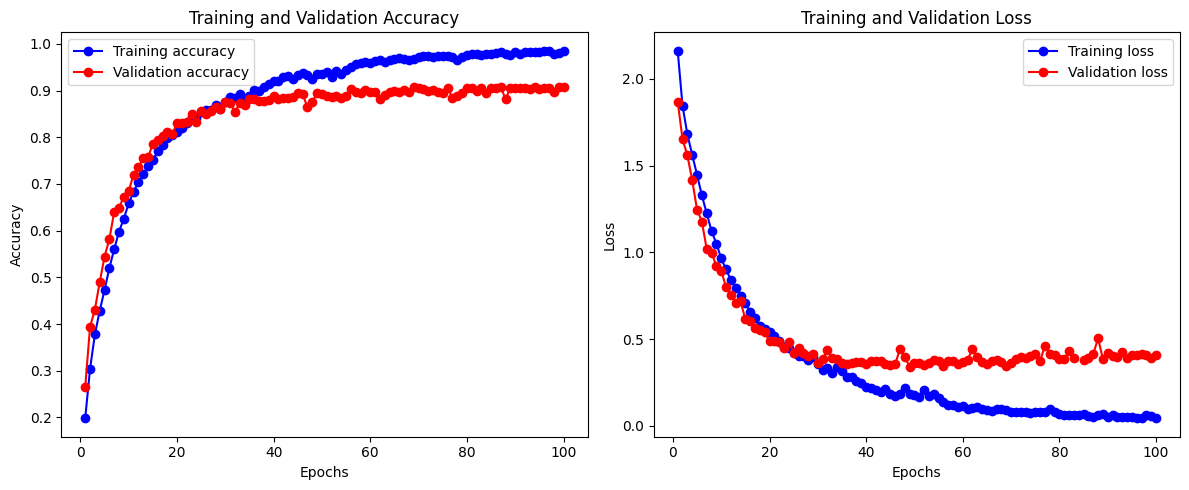

In [18]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
accuracy = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    has_validation = True
else:
    has_validation = False

# Create epochs range
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
if has_validation:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
if has_validation:
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()